# Quantum_Magnetometer eval_nnRL

In [2]:
# ==== Bootstrap (eval-only) + Params + Imports ====
from pathlib import Path
from pathlib import Path as _P
import sys, importlib.util, importlib, os, re, math, shutil
from datetime import datetime
import typing as tp
from typing import List, Optional, Tuple, Literal, Any

# --- ONLY use the eval repo root (contains `src/` and `nv_center_dc.py`) ---
EVAL_ROOT = Path("/home/yuyangzhang/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL").resolve()

# 1) Ensure EVAL_ROOT is FIRST on sys.path; remove other MagNav roots if present
def _rm_from_syspath(prefix: str):
    for p in list(sys.path):
        if prefix in p:
            sys.path.remove(p)

# Clean up the previously added training/BNN paths (to prevent them from being imported first)
_rm_from_syspath("/home/yuyangzhang/MagNav/Federated RL-training/Train-RL-Federal")
_rm_from_syspath("/home/yuyangzhang/MagNav/Federated RL-training/queso-main")

if str(EVAL_ROOT) in sys.path:
    sys.path.remove(str(EVAL_ROOT))
sys.path.insert(0, str(EVAL_ROOT))

print("[sys.path[0]] ->", sys.path[0], "  has src?:", (EVAL_ROOT/"src").exists())

# 2) Purge conflicting loaded modules so we re-import from EVAL_ROOT
for name in list(sys.modules):
    if name == "qsensoropt" or name.startswith("qsensoropt.") \
       or name == "src" or name.startswith("src.qsensoropt") \
       or name == "nv_center_dc":
        del sys.modules[name]

# 3) Sanity: what will be found?
def _find(name: str):
    spec = importlib.util.find_spec(name)
    print(f"[import check] {name}:", "FOUND" if spec else "NOT FOUND")
_find("src.qsensoropt")
_find("nv_center_dc")

# ---- General deps ----
import numpy as np
import pandas as pd
import jax, h5py, types
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import display
try:
    import numpy.lib.index_tricks  
except Exception:
    mod = types.ModuleType("numpy.lib.index_tricks")
    # mgrid is an instance of nd_grid; use its type as the nd_grid
    mod.nd_grid = type(np.mgrid)
    mod.mgrid = np.mgrid
    mod.ogrid = np.ogrid
    sys.modules["numpy.lib.index_tricks"] = mod

import tensorflow as tf
from tensorflow import constant, reshape, ones, expand_dims, cast
from tensorflow.math import exp, cos
from tensorflow.random import uniform as tf_uniform
from tensorflow.keras.models import load_model

from flax import linen as nn
from orbax.checkpoint import Checkpointer, PyTreeCheckpointHandler

# --- add examples/ to sys.path so nv_center_dc.py is importable ---
EXAMPLES_DIR = EVAL_ROOT / "examples"
if str(EXAMPLES_DIR) not in sys.path:
    sys.path.insert(0, str(EXAMPLES_DIR))
print("[examples dir]", EXAMPLES_DIR, " exists?:", EXAMPLES_DIR.exists())

# ---- Import ONLY from eval repo ----
from src.qsensoropt import InverseSqrtDecay, ParticleFilter, Parameter, SimulationParameters
from src.qsensoropt.utils import performance_evaluation, store_input_control, standard_model
from nv_center_dc import NVCenter, Magnetometry

import src.qsensoropt as _qs
print("[using qsensoropt from]", Path(_qs.__file__).resolve())
import inspect, nv_center_dc as _nv
print("[using nv_center_dc  from]", Path(inspect.getsourcefile(_nv)).resolve())

[sys.path[0]] -> /home/yuyangzhang/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL   has src?: True
[import check] src.qsensoropt: FOUND
[import check] nv_center_dc: FOUND
[examples dir] /home/yuyangzhang/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL/examples  exists?: True
[using qsensoropt from] /home/yuyangzhang/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL/src/qsensoropt/__init__.py
[using nv_center_dc  from] /home/yuyangzhang/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL/examples/nv_center_dc.py


### Patches

In [3]:
if not getattr(tf.keras.Model.save_weights, "_patched", False):
    _orig_sw = tf.keras.Model.save_weights
    def _safe_sw(self, fn, *a, **k):
        fn = str(fn)
        if not (fn.endswith(".weights.h5")):
            fn += ".weights.h5"
        _P(fn).parent.mkdir(parents=True, exist_ok=True)
        return _orig_sw(self, fn, *a, **k)
    _safe_sw._patched = True
    tf.keras.Model.save_weights = _safe_sw

if not getattr(tf.keras.Model.load_weights, "_patched", False):
    _orig_lw = tf.keras.Model.load_weights
    def _safe_lw(self, fp, *a, **k):
        fp = str(fp)
        if not (fp.endswith(".weights.h5") or fp.endswith(".h5") or fp.endswith(".keras")):
            fp += ".weights.h5"
        # Optional fallback: "<iter><head>.weights.h5" -> "<iter>_<head>.weights.h5"
        if not _P(fp).exists():
            m = re.search(r"(\d+)(\d)\.weights\.h5$", fp)
            if m:
                fp2 = re.sub(r"(\d+)(\d)\.weights\.h5$", r"\1_\2.weights.h5", fp)
                if _P(fp2).exists():
                    fp = fp2
        return _orig_lw(self, fp, *a, **k)
    _safe_lw._patched = True
    tf.keras.Model.load_weights = _safe_lw

if not getattr(tf.keras.Model.save, "_patched", False):
    _orig_save = tf.keras.Model.save
    def _safe_save(self, fp, *a, **k):
        fp = str(fp)
        if not (fp.endswith(".keras") or fp.endswith(".h5") or fp.endswith(".weights.h5")):
            fp += ".keras"
        _P(fp).parent.mkdir(parents=True, exist_ok=True)
        return _orig_save(self, fp, *a, **k)
    _safe_save._patched = True
    tf.keras.Model.save = _safe_save

print("üü¢ Keras patches active")

üü¢ Keras patches active


#### Parameter setting

In [4]:
# ================== Experiment parameters ==================
OMEGA_BOUNDS   = (0.0, 10.0)     # œâ in [0, 10]
INV_T2         = 1/1500          # Fix T2 = 1500 ¬µs (1/INV_T2)
F0, F1         = 0.88, 0.95      # Readout fidelities (likelihood)

BATCHSIZE      = 1024
N_HEADS        = 10
NUM_PARTICLES  = 240             # 240 is the common setting used in the original eval

# BNN window size: Œî=1.0 ‚Üí half-width=0.5
DELTA_WINDOW   = 1.0

FED_ROOT    = Path("/blue/iruchkin/yuyangzhang/MagNavRL") / "Federal"
TRAINED_DIR = FED_ROOT / "trained_models"
WEIGHTS_DIR = FED_ROOT / "trained_models_history_weights"

DATA_ROOT   = Path("/blue/iruchkin/yuyangzhang/MagNavRL") / f"eval_data_fid_{int(OMEGA_BOUNDS[1])}"
DATA_ROOT.mkdir(parents=True, exist_ok=True)

# BNN run dir (contains ckpts/ and nn.h5). Change this if needed.
BNN_DIR = Path.cwd() / "queso_run_BNN"

print("[config]")
print("  EVAL_ROOT  :", EVAL_ROOT)
print("  DATA_ROOT  :", DATA_ROOT)
print("  TRAINED_DIR:", TRAINED_DIR)
print("  WEIGHTS_DIR:", WEIGHTS_DIR)
print("  BNN_DIR    :", BNN_DIR)

[config]
  EVAL_ROOT  : /home/yuyangzhang/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL
  DATA_ROOT  : /blue/iruchkin/yuyangzhang/MagNavRL/eval_data_fid_10
  TRAINED_DIR: /blue/iruchkin/yuyangzhang/MagNavRL/Federal/trained_models
  WEIGHTS_DIR: /blue/iruchkin/yuyangzhang/MagNavRL/Federal/trained_models_history_weights
  BNN_DIR    : /home/yuyangzhang/MagNav/queso_run_BNN


#### Load BNN

In [5]:
# ==== BNN: model + load + posterior from shots ====
class BayesianDNNEstimator(nn.Module):
    nn_dims: tuple
    @nn.compact
    def __call__(self, x):
        for dim in self.nn_dims[:-1]:
            x = nn.relu(nn.Dense(dim)(x))
        return nn.Dense(self.nn_dims[-1])(x)

def load_bnn(ckpt_dir: str):
    ckptr   = Checkpointer(PyTreeCheckpointHandler())
    restored= ckptr.restore(ckpt_dir, item=None)
    model   = BayesianDNNEstimator(tuple(restored["nn_dims"]))
    params  = restored["params"]
    # read œâ grid saved by training
    nn_h5 = Path(ckpt_dir).parent / "nn.h5"
    with h5py.File(str(nn_h5), "r") as hf:
        omega_grid = jnp.array(hf["grid"][:], dtype=jnp.float32)  # [B], e.g. 0..10
    return model, params, omega_grid

# TensorFlow helper for p0 during a quick BNN sanity check
def _p0_bias_contrast_tf(omega, tau, F0, F1, T2):
    """p(0|œâ) = a + b * exp(-tau/T2) * cos(œâ * tau)."""
    decay = tf.exp(-tf.cast(tau, tf.float32) / tf.cast(T2, tf.float32))
    a     = tf.cast(0.5 * (1.0 + F0 - F1), tf.float32)
    b     = tf.cast(0.5 * (F0 + F1 - 1.0), tf.float32)
    return a + b * decay * tf.cos(tf.cast(omega, tf.float32) * tf.cast(tau, tf.float32))

In [6]:
# 1) load BNN
model_bnn, params_bnn, omega_grid = load_bnn(str((BNN_DIR / "ckpts").resolve()))

# 2) sample true omegas for a quick BNN sanity check
N_TEST = 20
rng = np.random.RandomState(42)
true_omegas = np.sort(rng.uniform(OMEGA_BOUNDS[0], OMEGA_BOUNDS[1], size=N_TEST)).astype(np.float32)

# 3) generate shots consistent with training (tau = pi/omega_max, phi=0)
tau_bnn = math.pi / float(OMEGA_BOUNDS[1])
n_shots = 5000

omega_tf = tf.reshape(tf.constant(true_omegas, tf.float32), (N_TEST,1))   # [N,1]
p0       = _p0_bias_contrast_tf(omega_tf, tau_bnn, F0, F1, 1/INV_T2)      # [N,1]
p0       = tf.repeat(p0, repeats=n_shots, axis=1)                          # [N,S]
u        = tf.random.Generator.from_seed(2025).uniform(tf.shape(p0), dtype=tf.float32)
shots    = (tf.cast(u < p0, tf.float32) * 2.0 - 1.0)[..., None].numpy()    # [N,S,1]

# 4) decode with BNN
logits = model_bnn.apply({"params": params_bnn}, shots)  # [N,S,B]
logp   = jax.nn.log_softmax(logits, axis=-1)
logpost= logp.sum(axis=1)                                 # [N,B]
post   = jnp.exp(logpost - logpost.max(axis=-1, keepdims=True))
post   = post / post.sum(axis=-1, keepdims=True)

omega_pred = (post * omega_grid[None,:]).sum(axis=-1)     # expectation

# 5) report BNN sanity
df = pd.DataFrame({
    "omega_true_MHz": np.round(true_omegas, 6),
    "omega_pred_MHz": np.round(np.asarray(omega_pred), 6),
})
rmse = float(np.sqrt(np.mean((df["omega_true_MHz"] - df["omega_pred_MHz"])**2)))
display(df)
print(f"[BNN quick check] RMSE ‚âà {rmse:.4f} MHz  (N={N_TEST}, shots={n_shots})")

/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


omega_true_MHz  omega_pred_MHz
0         0.205845        0.178013
1         0.580836        0.542682
2         1.559945        1.386293
3         1.560186        1.558396
4         1.818250        1.786318
5         1.834045        1.723126
6         2.123391        2.099760
7         2.912291        2.964453
8         3.042422        3.048740
9         3.745401        3.651252
10        4.319450        4.282988
11        5.247564        5.126010
12        5.986584        6.046426
13        6.011150        6.087422
14        7.080726        7.151055
15        7.319940        7.241214
16        8.324426        8.382943
17        8.661761        8.722810
18        9.507143        9.583361
19        9.699099        9.763202

[BNN quick check] RMSE ‚âà 0.0747 MHz  (N=20, shots=5000)


#### Load RL

In [7]:
# ==== NV model with fidelity (TF) ====
class NVCenterDCMagnPhase(NVCenter):
    def __init__(self, batchsize: int, params: List[Parameter],
                 prec: Literal["float64","float32"] = "float32",
                 res : Literal["meas","time"]      = "time",
                 invT2: Optional[float]            = None,
                 F0  : float                       = 0.88,
                 F1  : float                       = 0.95):
        super().__init__(batchsize, params, prec=prec, res=res, control_phase=True)
        self.invT2 = invT2
        self.F0, self.F1 = F0, F1

    def model(self, idxN: int, outcomes, controls,
              parameters, meas_step,
              num_systems: int = 1):
        œÑ   = controls[:, :, 0]
        œÜ   = controls[:, :, 1]
        œâ   = parameters[:, :, 0]
        invT2 = self.invT2 if self.invT2 is not None else parameters[:, :, 1]
        decay = exp(-œÑ * invT2)
        r = outcomes[:, :, 0]  # ¬±1
        bias     = 0.5 * (1 + self.F0 - self.F1)
        contrast = 0.5 * (self.F0 + self.F1 - 1)
        p0_fid   = bias + contrast * decay * cos(œâ * œÑ + œÜ)
        return tf.where(r > 0, p0_fid, 1.0 - p0_fid)

# ==== RL utils: pick best iter, warmup, load heads ====
def pick_best_iteration(trained_models_dir: Path,
                        weights_dir: Path = None,
                        smooth: int = 50) -> int:
    hist_csv = trained_models_dir.with_name(trained_models_dir.name + "_history.csv")
    if not hist_csv.exists():
        raise FileNotFoundError(hist_csv)
    df = pd.read_csv(hist_csv)
    loss = df["Loss"].rolling(smooth, min_periods=1).mean()
    idx0 = int(loss.idxmin())

    wdir = weights_dir or trained_models_dir.with_name(trained_models_dir.name + "_history_weights")
    if not wdir.exists():
        raise FileNotFoundError(wdir)
    iters_avail = sorted({
        int(m.group(1))
        for p in wdir.glob("*.weights.h5")
        for m in [re.search(r"(\d+)_\d+\.weights\.h5$", p.name)]
        if m
    })
    if not iters_avail:
        raise RuntimeError(f"No weight snapshots found under {wdir}")
    best_iter = min(iters_avail, key=lambda i: abs(i - idx0))
    print(f"[eval] best_iter={best_iter}  (csv idx={idx0}, smooth={smooth}, loss~{loss.iloc[idx0]:.4f})")
    return best_iter

def warmup_controller(input_size: int, control_size: int,
                      neurons: int = 64, prec: str = "float32",
                      epochs: int = 12, batch: int = 1024) -> tf.keras.Model:
    net = standard_model(input_size, control_size,
                         neurons_per_layer=neurons, prec=prec)
    x = tf.random.uniform((16384, input_size), dtype=prec) * 2 - 1
    tau_tgt = (x[:, -1:] + 1) / 2
    phi_tgt = tf.random.uniform((16384, 1), dtype=prec) * 2 - 1
    y = tf.concat([tau_tgt, phi_tgt], axis=1)
    net.compile(optimizer="adam", loss="mse")
    net.fit(x, y, epochs=epochs, batch_size=batch, verbose=0)
    return net

def load_controllers(iter_no: int,
                     n_heads: int,
                     weight_dir: Path,
                     neurons: int = 64,
                     input_size: int = 5,
                     control_size: int = 2) -> list[tf.keras.Model]:
    proto = warmup_controller(input_size, control_size, neurons)
    nets = []
    for h in range(n_heads):
        w_path = weight_dir / f"{iter_no}_{h}.weights.h5"
        if not w_path.exists():
            raise FileNotFoundError(w_path)
        net = standard_model(input_size, control_size,
                             neurons_per_layer=neurons,
                             prec="float32",
                             normalize_activation=True)
        net.build((None, input_size))
        net.set_weights(proto.get_weights())
        net.load_weights(str(w_path))
        nets.append(net)
    print(f"‚úì loaded {n_heads} heads from iteration {iter_no}")
    return nets

In [8]:
# compute RL input size (invT2 fixed -> d=1 -> 5)
d = 1
INPUT_SIZE = d**2 + 2*d + 2   # == 5

BEST_ITER = pick_best_iteration(TRAINED_DIR, WEIGHTS_DIR, smooth=1)
controllers = load_controllers(iter_no=BEST_ITER,
                               n_heads=N_HEADS,
                               weight_dir=WEIGHTS_DIR,
                               neurons=64,
                               input_size=INPUT_SIZE,
                               control_size=2)

[eval] best_iter=2572  (csv idx=2572, smooth=1, loss~4.2184)


/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759206652.837644 2879180 service.cc:152] XLA service 0x154be4163cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759206652.844835 2879180 service.cc:160]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
I0000 00:00:1759206657.314529 2879180 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1759206671.357962 2879180 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


‚úì loaded 10 heads from iteration 2572


#### Evaluation

In [9]:
# Keep runs reproducible
tf.random.set_seed(20250929)
np.random.seed(20250929)

# ------ Physics & evaluation config (microseconds for time/resource) ------
OMEGA_MIN, OMEGA_MAX = OMEGA_BOUNDS
F0 = 0.88
F1 = 0.95
INV_T2 = 1/1500
T2 = 1.0/float(INV_T2) if (INV_T2 is not None and INV_T2 != 0) else 1e9

K_BOOTSTRAP    = 70              # fixed-control bootstrap shots (œÑ=œÄ/œâmax, œÜ=0)
R_MAX_US       = 22_000.0        # strict total budget (includes overhead)
TAU_BUDGET_US  = 10_000.0        # œÑ-only budget for Stage-2 style curves
SHOT_OVERHEAD_US = 240.0         # per-shot fixed overhead
RESOURCE_BIN_US  = 500.0         # bin width for resource axis

# œÑ scales (paper-like): œÑ = TAU_MIN_US + PREF_TAU_US * |x|
TAU_MIN_US   = float(np.pi / float(OMEGA_MAX))   # œÑ_min used in bootstrap and as lower bound
PREF_TAU_US  = 6.0 * TAU_MIN_US                  # controllable œÑ scale during RL

In [10]:
# ---------- Likelihood model p(r=+1 | œâ,œÑ,œÜ) with bias/contrast ----------
def p0_bias_contrast(omega, tau, phi):
    """
    p0 = a + b * exp(-tau/T2) * cos(omega*tau + phi).
    Works with numpy or tf tensors; shapes broadcast.
    """
    T2 = (1.0/float(INV_T2)) if (INV_T2 and INV_T2 != 0.0) else 1e9
    a  = 0.5 * (1.0 + F0 - F1)
    b  = 0.5 * (F0 + F1 - 1.0)
    if isinstance(tau, tf.Tensor) or isinstance(omega, tf.Tensor):
        decay = tf.exp(-tf.cast(tau, tf.float32)/T2)
        return a + b * decay * tf.cos(tf.cast(omega, tf.float32)*tf.cast(tau, tf.float32) + tf.cast(phi, tf.float32))
    else:
        decay = np.exp(-tau / T2)
        return a + b * decay * np.cos(omega*tau + phi)

# ---------- Small helpers ----------
def ess(weights: np.ndarray) -> float:
    return 1.0 / (np.sum(np.square(weights)) + 1e-12)

def multinomial_resample(weights: np.ndarray, n: int) -> np.ndarray:
    return np.random.choice(len(weights), size=n, p=weights)

def pick_heads_around_center(omega_center: float, n_heads_total: int, k: int=3):
    span = OMEGA_MAX - OMEGA_MIN
    step = span / float(n_heads_total)
    idx0 = int(round((float(omega_center) - OMEGA_MIN) / step))
    cand = [idx0-1, idx0, idx0+1] if k >= 3 else ([idx0] if k == 1 else [idx0-1, idx0])
    return sorted(set(max(0, min(n_heads_total-1, i)) for i in cand))[:k]

def omega_window_from_bnn(center: float, delta: float=1.0):
    half = 0.5*delta
    lo   = max(OMEGA_MIN, float(center)-half)
    hi   = min(OMEGA_MAX, float(center)+half)
    if hi <= lo:
        eps=1e-6
        lo, hi = float(center)-half-eps, float(center)+half+eps
    return (lo, hi)

# ---------- Bootstrap (fixed control K=70); resource consumed is counted ----------
def collect_bootstrap_shots(true_omegas: np.ndarray,
                            K: int = K_BOOTSTRAP,
                            seed: int = 2025) -> tuple[tf.Tensor, np.ndarray]:
    """
    Fixed œÑ=œÄ/œâ_max, œÜ=0 sampling for K shots.
    Returns (shots[N,K] in {-1,+1}, used_res[N] in ¬µs).
    """
    N = true_omegas.shape[0]
    tau0 = np.float32(TAU_MIN_US)
    phi0 = np.float32(0.0)
    omega_tf = tf.reshape(tf.constant(true_omegas, tf.float32), (N,1))
    p0 = p0_bias_contrast(omega_tf, tau0, phi0)    # [N,1]
    p0 = tf.repeat(p0, repeats=K, axis=1)          # [N,K]
    u  = tf.random.Generator.from_seed(seed).uniform(tf.shape(p0), dtype=tf.float32)
    shots = (tf.cast(u < p0, tf.float32)*2.0 - 1.0)  # [N,K]
    used_res = np.full((N,), K*(float(tau0) + SHOT_OVERHEAD_US), dtype=np.float32)
    return shots, used_res

# ---------- BNN posterior on the given shots (batched) ----------
def bnn_posterior_from_shots_batched(shots_bnn: tf.Tensor) -> np.ndarray:
    """
    Input [N,K] in {-1,+1}; returns [N,B] posterior over omega_grid.
    Depends on globally loaded model_bnn/params_bnn/omega_grid.
    """
    x = shots_bnn[..., None].numpy()                     # [N,K,1]
    logits = model_bnn.apply({"params": params_bnn}, x)  # [N,K,B]
    logp   = jax.nn.log_softmax(logits, axis=-1)
    logpost= np.asarray(logp).sum(axis=1)                # [N,B]
    logpost -= logpost.max(axis=1, keepdims=True)
    post = np.exp(logpost)
    post = post / (post.sum(axis=1, keepdims=True) + 1e-12)
    return post

# ---------- PF initialization by resampling from BNN discrete posterior ----------
def pf_from_grid_posterior(post_grid: np.ndarray, grid: np.ndarray, num_particles: int=NUM_PARTICLES):
    """
    Returns (particles[N,P], weights[N,P]) with uniform weights after resampling.
    """
    N, B = post_grid.shape
    particles = np.zeros((N, num_particles), dtype=np.float32)
    weights   = np.ones((N, num_particles), dtype=np.float32) / float(num_particles)
    for i in range(N):
        idx = np.random.choice(B, size=num_particles, p=post_grid[i])
        particles[i] = np.asarray(grid[idx], dtype=np.float32)
    return particles, weights

def posterior_stats(particles: np.ndarray, weights: np.ndarray):
    mean = np.sum(particles * weights, axis=1)
    var  = np.sum(weights * (particles - mean[:,None])**2, axis=1)
    return mean, var

# ---------- RL input features (5-D, aligned with training) ----------
def build_rl_input(particles: np.ndarray, weights: np.ndarray,
                   step: int, used_res: np.ndarray,
                   max_steps: int = 1000, max_resources: float = None) -> np.ndarray:
    """
    inp[N,5] = [mean_norm, logdev_norm, corr11(=1), step_norm, res_norm]
    - mean_norm    : scale œâ-mean from [OMEGA_MIN, OMEGA_MAX] to [-1,1]
    - logdev_norm  : scale log(sigma) from [-10,0] to [-1,1]
    - step_norm    : linear map to [-1,1] for network convenience
    - res_norm     : linear map to [-1,1] using max_resources normalization
    """
    N, P = particles.shape
    mean, var = posterior_stats(particles, weights)
    sigma = np.maximum(np.sqrt(np.maximum(var, 1e-18)), 1e-18)

    mean_norm = 2.0*(mean - OMEGA_MIN)/(OMEGA_MAX-OMEGA_MIN) - 1.0
    logdev = np.log(np.maximum(sigma, 1e-18))
    logdev_norm = 2.0*(logdev - (-10.0))/(0.0 - (-10.0)) - 1.0
    logdev_norm = np.clip(logdev_norm, -1.0, 1.0)
    corr11 = np.ones_like(mean_norm)

    step_norm = 2.0*(step)/(max_steps) - 1.0
    step_vec  = np.full_like(mean_norm, step_norm, dtype=np.float32)

    if max_resources is None:
        max_resources = (TAU_MIN_US + PREF_TAU_US) * max_steps
    res_norm = 2.0*(used_res / max_resources) - 1.0

    return np.stack([mean_norm, logdev_norm, corr11, step_vec, res_norm], axis=1).astype(np.float32)

# ---------- Controller output ‚Üí physical controls (œÑ, œÜ) ----------
def map_controller_to_controls(net_out: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    œÑ = TAU_MIN_US + PREF_TAU_US * |x0|,  œÜ = œÄ * x1
    """
    tau = TAU_MIN_US + PREF_TAU_US * np.abs(net_out[:,0:1])
    phi = math.pi * net_out[:,1:2]
    return tau.astype(np.float32), phi.astype(np.float32)

# ---------- One measurement + PF weight update (+ ESS resample if needed) ----------
def one_step_measure_and_update(true_omega: np.ndarray,
                                particles: np.ndarray, weights: np.ndarray,
                                tau: np.ndarray, phi: np.ndarray,
                                resample_ess_ratio: float=0.5
                                ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns: r, new_particles, new_weights, delta_resources (= tau[:,0]).
    The fixed 240 ¬µs overhead is added in the outer loop (not here).
    """
    N, P = particles.shape

    # True outcome sampling
    p0_true = p0_bias_contrast(true_omega[:,None], tau, phi)
    if isinstance(p0_true, tf.Tensor): p0_true = p0_true.numpy()
    u = np.random.rand(N,1).astype(np.float32)
    r = np.where(u < p0_true, 1.0, -1.0).astype(np.float32)   # [N,1]

    # Particle likelihoods and weight update
    p0_part = p0_bias_contrast(particles, tau, phi)           # [N,P]
    if isinstance(p0_part, tf.Tensor): p0_part = p0_part.numpy()
    like = np.where(r > 0.0, p0_part, 1.0 - p0_part)
    like = np.clip(like, 1e-12, 1.0)

    w = weights * like
    w /= (np.sum(w, axis=1, keepdims=True) + 1e-18)

    new_particles = particles.copy()
    new_weights   = w.copy()
    for i in range(N):
        if ess(w[i]) < resample_ess_ratio * P:
            idx = multinomial_resample(w[i], P)
            new_particles[i] = particles[i, idx]
            new_weights[i]   = np.ones((P,), dtype=np.float32)/float(P)

    delta_resources = tau[:,0].astype(np.float32)
    return r[:,0], new_particles, new_weights, delta_resources

# ---------- 500 ¬µs binning on the resource axis ----------
def resources_bin_curve(resources_avg: np.ndarray,
                        mse_curve: np.ndarray,
                        bin_us: float = RESOURCE_BIN_US,
                        rmax_us: float = R_MAX_US) -> tuple[np.ndarray, np.ndarray]:
    bins = np.arange(0.0, rmax_us + 1e-6, bin_us, dtype=np.float32)
    idx  = np.digitize(resources_avg, bins, right=False) - 1
    nb   = len(bins) - 1
    out  = np.full((nb,), np.nan, dtype=np.float32)
    for b in range(nb):
        m = mse_curve[idx == b]
        if m.size > 0:
            out[b] = float(np.mean(m))
    centers = (bins[:-1] + bins[1:]) * 0.5
    return centers, out

# ---------- Main strict evaluation (BNN‚ÜíRL under 22 ms total budget) ----------
def eval_once_batch(true_omegas: np.ndarray, choose_k_heads: int = 3):
    """
    Strict protocol:
      1) Bootstrap: K=70 shots under œÑ=œÄ/œâmax, œÜ=0; resource is counted.
      2) BNN posterior ‚Üí PF prior; select heads near BNN center.
      3) RL loop (inference only): each step enforces resource cap; per-step resource = œÑ + 240 ¬µs.
      4) Return step-level traces and 500 ¬µs-binned curves.
    Depends on: controllers, model_bnn/params_bnn/omega_grid.
    """
    N = true_omegas.shape[0]

    # 1) Bootstrap
    shots, used_res = collect_bootstrap_shots(true_omegas, K=K_BOOTSTRAP)
    post_grid = bnn_posterior_from_shots_batched(shots)                # [N,B]
    omega_center_batch = (post_grid * omega_grid[None,:]).sum(axis=1)  # [N]
    omega_center = float(np.mean(omega_center_batch))
    window = omega_window_from_bnn(omega_center, delta=1.0)
    heads = pick_heads_around_center(omega_center, len(controllers), k=choose_k_heads)

    # 2) PF prior from BNN posterior
    particles, weights = pf_from_grid_posterior(post_grid, np.asarray(omega_grid, np.float32), NUM_PARTICLES)

    results = {}
    for h in heads:
        part = particles.copy()
        w    = weights.copy()
        res_used = used_res.copy()

        mse_curve, res_curve, mean_trace = [], [], []
        step = 0

        def avg_budget_left():
            return float(np.mean(np.maximum(0.0, R_MAX_US - res_used)))

        while True:
            # Stop if average remaining budget cannot cover the smallest shot
            if avg_budget_left() < (TAU_MIN_US + SHOT_OVERHEAD_US):
                break

            # Build RL input and get (œÑ, œÜ) from the controller
            inp = build_rl_input(part, w, step=step, used_res=res_used, max_steps=1000)
            net_out = controllers[h](inp, training=False).numpy()
            tau, phi = map_controller_to_controls(net_out)

            # Clip œÑ per-sample: res_used + œÑ + overhead ‚â§ R_MAX_US
            tau_cap = (R_MAX_US - res_used - SHOT_OVERHEAD_US).reshape(-1,1)
            tau_cap = np.maximum(tau_cap, 0.0).astype(np.float32)
            tau = np.minimum(tau, tau_cap)

            if float(np.mean(tau)) <= 1e-8:
                break

            # Measure + PF update + resource accumulation (œÑ + overhead)
            r, part, w, dres_tau = one_step_measure_and_update(true_omegas, part, w, tau, phi)
            res_used += (dres_tau + SHOT_OVERHEAD_US)

            mean, var = posterior_stats(part, w)
            mse = np.mean((mean - true_omegas)**2)
            mse_curve.append(mse)
            res_curve.append(float(np.mean(res_used)))
            mean_trace.append(mean)
            step += 1

            if res_curve[-1] >= R_MAX_US - 1e-6:
                break

        res_curve = np.asarray(res_curve, dtype=np.float32)
        mse_curve = np.asarray(mse_curve, dtype=np.float32)
        mean_trace= np.asarray(mean_trace, dtype=np.float32)

        # 500 ¬µs binning
        bin_x, bin_mse = resources_bin_curve(res_curve, mse_curve,
                                             bin_us=RESOURCE_BIN_US, rmax_us=R_MAX_US)

        results[h] = {
            "resources_step": res_curve,
            "mse_step": mse_curve,
            "mean_trace": mean_trace,     # [T,N]
            "bin_x_us": bin_x,
            "bin_mse": bin_mse,
            "omega_center": omega_center,
            "window": window,
        }
        if len(mse_curve) > 0:
            print(f"[head {h}] steps={len(mse_curve)}  last(avg_res)={res_curve[-1]:.1f} ¬µs  last(MSE)={mse_curve[-1]:.4f}")
        else:
            print(f"[head {h}] no steps executed (budget exhausted during bootstrap?)")

    return results

# ---------- Stage-2 style œÑ-only evaluation (0‚Üí10 ms, bootstrap excluded on x-axis) ----------
def eval_once_batch_tau_only(true_omegas: np.ndarray, choose_k_heads: int = 3):
    """
    œÑ-only Stage-2 evaluation:
      - Bootstrap (K=70, œÑ=œÄ/œâmax, œÜ=0) initializes PF & picks heads; bootstrap time is NOT shown on x-axis.
      - Budget: œÑ_tot ‚â§ 10 ms; per-step x-axis adds œÑ only (no 240 ¬µs).
      - Otherwise same PF/RL logic as the strict setting.
    Returns both step-level and œÑ-binned curves.
    """
    N = true_omegas.shape[0]

    # Bootstrap (initialization only; not on x-axis)
    shots, _ = collect_bootstrap_shots(true_omegas, K=K_BOOTSTRAP)
    post_grid = bnn_posterior_from_shots_batched(shots)
    omega_center_batch = (post_grid * omega_grid[None,:]).sum(axis=1)
    omega_center = float(np.mean(omega_center_batch))
    heads = pick_heads_around_center(omega_center, len(controllers), k=choose_k_heads)

    # PF init from BNN posterior
    particles, weights = pf_from_grid_posterior(post_grid, np.asarray(omega_grid, np.float32), NUM_PARTICLES)

    results = {}
    for h in heads:
        part = particles.copy()
        w    = weights.copy()

        tau_used = np.zeros((N,), dtype=np.float32)  # œÑ-only
        mse_curve, res_tau_curve, mean_trace = [], [], []
        step = 0

        while True:
            if float(np.mean(TAU_BUDGET_US - tau_used)) <= TAU_MIN_US:
                break

            inp = build_rl_input(part, w, step=step, used_res=tau_used, max_steps=1000, max_resources=TAU_BUDGET_US)
            net_out = controllers[h](inp, training=False).numpy()
            tau, phi = map_controller_to_controls(net_out)

            tau_cap = (TAU_BUDGET_US - tau_used).reshape(-1,1)
            tau_cap = np.maximum(tau_cap, 0.0).astype(np.float32)
            tau = np.minimum(tau, tau_cap)
            if float(np.mean(tau)) <= 1e-8:
                break

            r, part, w, d_tau = one_step_measure_and_update(true_omegas, part, w, tau, phi)
            tau_used += d_tau

            mean, var = posterior_stats(part, w)
            mse = np.mean((mean - true_omegas)**2)
            mse_curve.append(mse)
            res_tau_curve.append(float(np.mean(tau_used)))
            mean_trace.append(mean)
            step += 1

            if res_tau_curve[-1] >= TAU_BUDGET_US - 1e-6:
                break

        res_tau_curve = np.asarray(res_tau_curve, dtype=np.float32)
        mse_curve     = np.asarray(mse_curve, dtype=np.float32)

        # 500 ¬µs(œÑ) binning (use same width for apples-to-apples)
        bin_x_tau, bin_mse_tau = resources_bin_curve(res_tau_curve, mse_curve,
                                                     bin_us=RESOURCE_BIN_US,
                                                     rmax_us=TAU_BUDGET_US)

        results[h] = {
            "resources_tau_step": res_tau_curve,   # œÑ-only axis
            "mse_step": mse_curve,
            "bin_x_tau": bin_x_tau,
            "bin_mse_tau": bin_mse_tau,
            "omega_center": omega_center,
        }
        if len(mse_curve) > 0:
            print(f"[œÑ-only | head {h}] steps={len(mse_curve)} last(œÑ_avg)={res_tau_curve[-1]:.1f} ¬µs  last(MSE)={mse_curve[-1]:.4f}")
        else:
            print(f"[œÑ-only | head {h}] no steps executed.")
    return results

# ---------- RL-only, 22 ms budget (10 heads) ----------
def init_pf_uniform(N: int, P: int, lo: float, hi: float):
    """
    Uniform prior on [lo,hi] with equal weights (used for RL-only evaluation).
    """
    particles = np.random.uniform(lo, hi, size=(N, P)).astype(np.float32)
    weights   = np.ones((N, P), dtype=np.float32) / float(P)
    return particles, weights

def eval_heads_rl_only_22ms(true_omegas: np.ndarray, heads: list[int] = None):
    """
    RL-only: no BNN; PF prior is uniform; each head is evaluated under the same 22 ms budget.
    X-axis = œÑ + 240 ¬µs; 500 ¬µs bins (same as strict evaluation).
    """
    N = true_omegas.shape[0]
    if heads is None:
        heads = list(range(len(controllers)))

    results = {}
    for h in heads:
        part, w = init_pf_uniform(N, NUM_PARTICLES, OMEGA_MIN, OMEGA_MAX)
        res_used = np.zeros((N,), dtype=np.float32)

        mse_curve, res_curve = [], []
        step = 0

        def avg_budget_left():
            return float(np.mean(np.maximum(0.0, R_MAX_US - res_used)))

        while True:
            if avg_budget_left() < (TAU_MIN_US + SHOT_OVERHEAD_US):
                break

            inp = build_rl_input(part, w, step=step, used_res=res_used, max_steps=1000)
            net_out = controllers[h](inp, training=False).numpy()
            tau, phi = map_controller_to_controls(net_out)

            tau_cap = (R_MAX_US - res_used - SHOT_OVERHEAD_US).reshape(-1,1)
            tau_cap = np.maximum(tau_cap, 0.0).astype(np.float32)
            tau = np.minimum(tau, tau_cap)
            if float(np.mean(tau)) <= 1e-8:
                break

            r, part, w, dres_tau = one_step_measure_and_update(true_omegas, part, w, tau, phi)
            res_used += (dres_tau + SHOT_OVERHEAD_US)

            mean, var = posterior_stats(part, w)
            mse = np.mean((mean - true_omegas)**2)
            mse_curve.append(mse)
            res_curve.append(float(np.mean(res_used)))
            step += 1

            if res_curve[-1] >= R_MAX_US - 1e-6:
                break

        res_curve = np.asarray(res_curve, dtype=np.float32)
        mse_curve = np.asarray(mse_curve, dtype=np.float32)
        bin_x, bin_mse = resources_bin_curve(res_curve, mse_curve,
                                             bin_us=RESOURCE_BIN_US, rmax_us=R_MAX_US)
        results[h] = {"bin_x_us": bin_x, "bin_mse": bin_mse}
        if len(mse_curve) > 0:
            print(f"[RL-only22ms | head {h}] steps={len(mse_curve)} last(avg_res)={res_curve[-1]:.1f} ¬µs last(MSE)={mse_curve[-1]:.4f}")
        else:
            print(f"[RL-only22ms | head {h}] no steps executed.")
    return results

[head 4] steps=21  last(avg_res)=21895.6 ¬µs  last(MSE)=0.1348
[head 5] steps=21  last(avg_res)=21895.6 ¬µs  last(MSE)=0.1421
[head 6] steps=21  last(avg_res)=21895.6 ¬µs  last(MSE)=0.1468


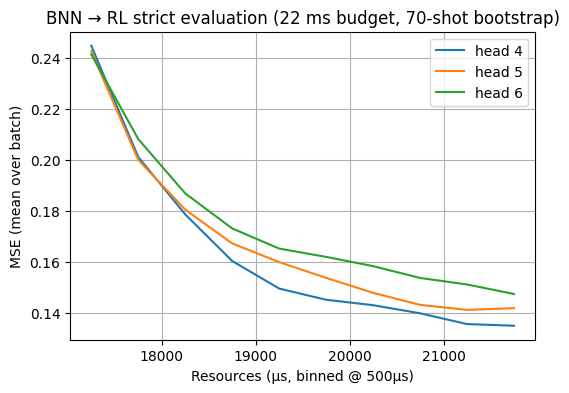

   head  resources_bin_us  mse_binned
0     4             250.0         NaN
1     4             750.0         NaN
2     4            1250.0         NaN
3     4            1750.0         NaN
4     4            2250.0         NaN
5     4            2750.0         NaN
6     4            3250.0         NaN
7     4            3750.0         NaN
8     4            4250.0         NaN
9     4            4750.0         NaN
[RL-only22ms | head 0] steps=91 last(avg_res)=21973.7 ¬µs last(MSE)=0.4886
[RL-only22ms | head 1] steps=91 last(avg_res)=21973.7 ¬µs last(MSE)=0.5236
[RL-only22ms | head 2] steps=91 last(avg_res)=21973.7 ¬µs last(MSE)=0.3807
[RL-only22ms | head 3] steps=91 last(avg_res)=21973.7 ¬µs last(MSE)=0.4250
[RL-only22ms | head 4] steps=91 last(avg_res)=21973.7 ¬µs last(MSE)=0.5668
[RL-only22ms | head 5] steps=91 last(avg_res)=21973.7 ¬µs last(MSE)=0.4335
[RL-only22ms | head 6] steps=91 last(avg_res)=21973.7 ¬µs last(MSE)=0.6440
[RL-only22ms | head 7] steps=91 last(avg_res)=21973.7 ¬µs

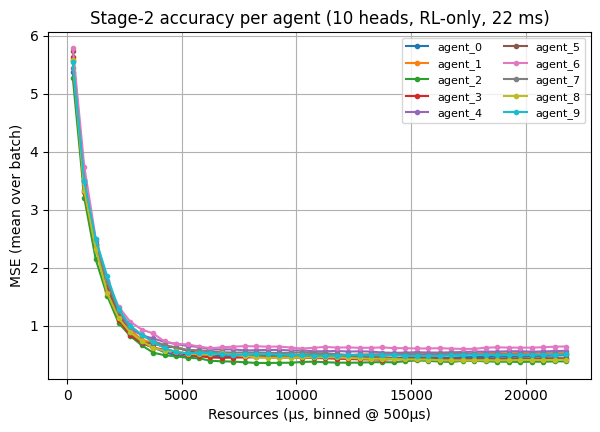

In [11]:
# ---------- One-click evaluation + 500 ¬µs binned plots ----------
N_TEST = BATCHSIZE
true_omegas = np.sort(np.random.uniform(OMEGA_MIN, OMEGA_MAX, size=N_TEST).astype(np.float32))

# Strict (BNN‚ÜíRL under 22 ms)
strict_results = eval_once_batch(true_omegas, choose_k_heads=3)

plt.figure(figsize=(6,4))
for h, res in strict_results.items():
    plt.plot(res["bin_x_us"], res["bin_mse"], label=f"head {h}")
plt.xlabel("Resources (¬µs, binned @ 500¬µs)")
plt.ylabel("MSE (mean over batch)")
plt.title("BNN ‚Üí RL strict evaluation (22 ms budget, 70-shot bootstrap)")
plt.grid(True); plt.legend(); plt.show()

# Export binned CSV (optional)
rows = []
for h, res in strict_results.items():
    bx, bm = res["bin_x_us"], res["bin_mse"]
    for x, m in zip(bx, bm):
        rows.append({"head": h, "resources_bin_us": float(x), "mse_binned": (np.nan if np.isnan(m) else float(m))})
df_out = pd.DataFrame(rows)
print(df_out.head(10))

# RL-only (10 heads), 22 ms total
rl_only_results = eval_heads_rl_only_22ms(true_omegas, heads=list(range(len(controllers))))

plt.figure(figsize=(7,4.5))
for h, res in rl_only_results.items():
    plt.plot(res["bin_x_us"], res["bin_mse"], marker='o', ms=3, label=f"agent_{h}")
plt.xlabel("Resources (¬µs, binned @ 500¬µs)")
plt.ylabel("MSE (mean over batch)")
plt.title("Stage-2 accuracy per agent (10 heads, RL-only, 22 ms)")
plt.grid(True); plt.legend(ncol=2, fontsize=8); plt.show()

#### Evaluation

In [15]:
def collect_bnn_bootstrap_shots(sim, K: int):
    """
    Fix controlÔºàœÑ0=œÄ/OMEGA_BOUNDS[1], œÜ0=0Ôºâsample KÔºåreturn [batch,K] in {-1,+1}
    Note: Here we still use the global upper bound œÑ0; the window will be applied to Stage-2 after BNN.
    """
    tau0 = tf.constant(math.pi / float(OMEGA_BOUNDS[1]), dtype=tf.float32)
    phi0 = tf.constant(0.0, dtype=tf.float32)

    def control_fixed(head_idx, x):
        bs = tf.shape(x)[0]
        œÑ = tf.ones((bs, 1), dtype=tf.float32) * tau0
        œÜ = tf.ones((bs, 1), dtype=tf.float32) * phi0
        return tf.concat([œÑ, œÜ], axis=1)

    pf   = ParticleFilter(num_particles=NUM_PARTICLES, phys_model=sim.phys_model, prec="float32")
    simpars_short = SimulationParameters(sim_name="bnn_bootstrap",
                                         num_steps=K, max_resources=K,
                                         prec="float32", cumulative_loss=True, log_loss=False)
    sim_fixed = Magnetometry(particle_filter=pf,
                             simpars=simpars_short,
                             phys_model=sim.phys_model,
                             control_strategy=control_fixed,
                             eta_flag=False)

    rangen = tf.random.Generator.from_seed(12345)
    _ = sim_fixed.execute(0, rangen, deploy=True)
    shots_pm = sim_fixed.hist_outcomes_rec[:, :, 0]   # [batch,K] in {-1,+1] 
    return tf.convert_to_tensor(shots_pm, dtype=tf.float32)

def omega_window_from_bnn(omega_center: float, delta: float = DELTA_WINDOW):
    half = 0.5 * float(delta)
    low  = max(OMEGA_BOUNDS[0], float(omega_center) - half)
    high = min(OMEGA_BOUNDS[1], float(omega_center) + half)
    if high <= low:
        eps = 1e-6
        low, high = float(omega_center) - half - eps, float(omega_center) + half + eps
    return (low, high)

def make_pf_with_prior_from_grid(sim, omega_grid: np.ndarray, post_grid: np.ndarray):
    """
    Place particles on the omega_grid and use the BNN posteriors as weights.
    Return a new PF object (for subsequent use in the main simulation).
    """
    pf = ParticleFilter(num_particles=NUM_PARTICLES, phys_model=sim.phys_model, prec="float32")
    B = post_grid.shape[1]
    batch = post_grid.shape[0]
    part_grid = np.tile(omega_grid[None, :, None], (batch, 1, 1))  # [batch,B,1]
    if B >= NUM_PARTICLES:
        part = part_grid[:, :NUM_PARTICLES, :]
        w    = post_grid[:, :NUM_PARTICLES]
        w    = w / (w.sum(axis=1, keepdims=True) + 1e-12)
    else:
        reps = NUM_PARTICLES // B + 1
        part = np.tile(part_grid, (1, reps, 1))[:, :NUM_PARTICLES, :]
        wrep = np.tile(post_grid, (1, reps))[:, :NUM_PARTICLES]
        w    = wrep / (wrep.sum(axis=1, keepdims=True) + 1e-12)

    pf.particles = tf.convert_to_tensor(part, dtype=tf.float32)
    pf.weights   = tf.convert_to_tensor(w,    dtype=tf.float32)
    return pf

In [16]:
def collect_bnn_bootstrap_shots(sim, K: int):
    """
    Fixed-control (tau0=pi/OMEGA_BOUNDS[1], phi0=0) for K steps, return shots [batch,K] in {-1,+1}.
    No other logic changed. Falls back to tuple return if `hist_outcomes_rec` is not an attribute.
    """
    tau0 = tf.constant(math.pi / float(OMEGA_BOUNDS[1]), dtype=tf.float32)
    phi0 = tf.constant(0.0, dtype=tf.float32)

    def control_fixed(head_idx, x):
        bs = tf.shape(x)[0]
        œÑ = tf.ones((bs, 1), dtype=tf.float32) * tau0
        œÜ = tf.ones((bs, 1), dtype=tf.float32) * phi0
        return tf.concat([œÑ, œÜ], axis=1)

    # short sim with fixed control for K steps
    pf   = ParticleFilter(num_particles=NUM_PARTICLES, phys_model=sim.phys_model, prec="float32")
    simpars_short = SimulationParameters(sim_name="bnn_bootstrap",
                                         num_steps=K, max_resources=K,
                                         prec="float32", cumulative_loss=True, log_loss=False)
    sim_fixed = Magnetometry(particle_filter=pf,
                             simpars=simpars_short,
                             phys_model=sim.phys_model,
                             control_strategy=control_fixed,
                             eta_flag=False)

    rangen = tf.random.Generator.from_seed(12345)
    ret = sim_fixed.execute(0, rangen, deploy=True)

    # Find shot
    try:
        shots_pm = sim_fixed.hist_outcomes_rec[:, :, 0]  # [batch,K]
        return tf.cast(shots_pm, tf.float32)
    except AttributeError:
        pass

    hist_outcomes_rec = ret[-4]  # expected shape [batch,K,1] or [batch,K]
    t = tf.convert_to_tensor(hist_outcomes_rec)

    if t.shape.rank == 3 and t.shape[-1] == 1:
        shots_pm = t[:, :, 0]
    elif t.shape.rank == 2:
        shots_pm = t
    else:
        shots_pm = tf.squeeze(t)

    return tf.cast(shots_pm, tf.float32)


# 1) Load BNN checkpoint
model_bnn, params_bnn, omega_grid = load_bnn(str(BNN_DIR / "ckpts"))

# 2) Use shots_bnn computing post_grid  (shape [batch, B])
def bnn_posterior_from_shots(shots_bnn):
    # shots_bnn: [batch, K] in {-1,+1} -> add channel dim to [batch, K, 1]
    shots = shots_bnn[..., None].numpy()
    logits = model_bnn.apply({"params": params_bnn}, shots)     # [batch, K, B]
    logp   = jax.nn.log_softmax(logits, axis=-1)                # [batch, K, B]
    logpost= logp.sum(axis=1)                                   # [batch, B]
    post   = jnp.exp(logpost - logpost.max(axis=-1, keepdims=True))
    post   = post / post.sum(axis=-1, keepdims=True)
    return np.asarray(post)                                     # numpy [batch,B]

# 3) Convert the posterior to a PF prior (two ways, choose one)
def make_pf_with_prior_from_grid(sim, post_grid):
    """
    post_grid: numpy [batch, B] posterior over omega_grid
    Method A: Place the PF particles on the omega_grid and use the post_grid as the weights.
    Method B: Sample Gaussian particles centered around the MAP/expected value of each batch and assign uniform weights.
    Method A (the most intuitive) is shown below.
    """
    pf = ParticleFilter(num_particles=NUM_PARTICLES, phys_model=sim.phys_model, prec="float32")
    B = post_grid.shape[1]
    batch = post_grid.shape[0]
    # Copy omega_grid to each batch and repeat/truncate to num_particles size
    part_grid = np.tile(omega_grid[None, :, None], (batch, 1, 1))  # [batch,B,1]
    if B >= NUM_PARTICLES:
        part = part_grid[:, :NUM_PARTICLES, :]                     
        w    = post_grid[:, :NUM_PARTICLES]
        w    = w / (w.sum(axis=1, keepdims=True) + 1e-12)
    else:
        reps = NUM_PARTICLES // B + 1
        part = np.tile(part_grid, (1, reps, 1))[:, :NUM_PARTICLES, :]
        wrep = np.tile(post_grid, (1, reps))[:, :NUM_PARTICLES]
        w    = wrep / (wrep.sum(axis=1, keepdims=True) + 1e-12)

    # ÂÜôÂõû PFÔºàÂ¶Ç API ‰∏çÂêåÔºåËØ∑Êåâ‰Ω†Â∑•Á®ãÁöÑÂ≠óÊÆµÂêçÊîπÂÜôÔºâ
    pf.particles = tf.convert_to_tensor(part, dtype=tf.float32)
    pf.weights   = tf.convert_to_tensor(w,    dtype=tf.float32)
    return pf

# ‚Äî‚Äî Auxiliary function: construct window from BNN point estimate ‚Äî‚Äî 
def omega_window_from_bnn(omega_center: float, delta: float = 1.0):
    half = 0.5 * float(delta)
    low  = max(OMEGA_BOUNDS[0], float(omega_center) - half)
    high = min(OMEGA_BOUNDS[1], float(omega_center) + half)
    # Avoid degradation
    if high <= low:
        eps = 1e-6
        low, high = float(omega_center) - half - eps, float(omega_center) + half + eps
    return (low, high)

# 4) BNN + RL
def run_stage2_hybrid(idxN: int, controllers, data_dir: Path, K_bootstrap: int = 100):

    if omega_bounds is None:
        omega_bounds = OMEGA_BOUNDS
    pars = [Parameter(omega_bounds, name="omega")]
    nv   = NVCenterDCMagnPhase(batchsize=BATCHSIZE, params=pars, prec="float32", res="time",
                               invT2=INV_T2, F0=F0, F1=F1)

    # First, build a temporary sim to collect BNN shots (control fixed)
    sim_tmp = Magnetometry(
        particle_filter=ParticleFilter(num_particles=NUM_PARTICLES, phys_model=nv, prec="float32"),
        simpars=SimulationParameters(sim_name=f"bnn_bootstrap_idx{idxN}",
                                     num_steps=K_bootstrap, max_resources=K_bootstrap,
                                     prec="float32", cumulative_loss=True, log_loss=False),
        phys_model=nv,
        control_strategy=lambda head, x: tf.concat(
            [tf.ones((tf.shape(x)[0],1),tf.float32)*(math.pi/float(OMEGA_BOUNDS[1])),
             tf.zeros((tf.shape(x)[0],1),tf.float32)], axis=1),
        eta_flag=False
    )
    shots_bnn = collect_bnn_bootstrap_shots(sim_tmp, K_bootstrap)  # [batch,K] in {-1,+1}

    # BNN Posterior
    post_grid = bnn_posterior_from_shots(shots_bnn)                # [batch,B]

    # Use the BNN posterior to set the PF prior, then run the RL main simulation
    pf_prior = make_pf_with_prior_from_grid(sim_tmp, post_grid)
    simpars = SimulationParameters(sim_name=f"eval_idx{idxN}",
                                   num_steps=MAX_RESOURCES,
                                   max_resources=MAX_RESOURCES,
                                   prec="float32", cumulative_loss=True, log_loss=True)

    pref = MAX_RESOURCES / 20.0
    def control_nn(head_idx: int, x):
        œÑ  = pref * tf.abs(controllers[head_idx](x)[:, :1]) + 1.0
        œÜ  = math.pi * controllers[head_idx](x)[:, 1:2]
        return tf.concat([œÑ, œÜ], axis=1) 

    sim = Magnetometry(particle_filter=pf_prior,
                       simpars=simpars,
                       phys_model=nv,
                       control_strategy=control_nn,
                       eta_flag=False)

    data_dir.mkdir(parents=True, exist_ok=True)
    performance_evaluation(sim, idxN, 200,
                           str(data_dir),
                           xla_compile=False,
                           delta_resources=500,
                           y_label='MSE')
    store_input_control(sim, idxN, str(data_dir), 1, xla_compile=False)
    print(f"‚úì hybrid BNN+RL idxN={idxN}: csv written to {data_dir}")
    
    
def run_stage2_with_prior(idxN: int,
                          controllers,
                          pf_prior: ParticleFilter,
                          omega_bounds: Tuple[float,float],
                          data_dir: Path):
    # NV with the (possibly narrowed) omega_bounds
    pars = [Parameter(omega_bounds, name="omega")]
    nv   = NVCenterDCMagnPhase(batchsize=BATCHSIZE, params=pars, prec="float32", res="time",
                               invT2=INV_T2, F0=F0, F1=F1)

    # Create PF bound to the new NV, and copy prior particles/weights
    pf   = ParticleFilter(num_particles=NUM_PARTICLES, phys_model=nv, prec="float32")
    # ADDED: copy prior into the new PF (same shapes)
    pf.particles = tf.identity(pf_prior.particles)
    pf.weights   = tf.identity(pf_prior.weights)

    simpars = SimulationParameters(sim_name=f"eval_idx{idxN}",
                                   num_steps=MAX_RESOURCES,
                                   max_resources=MAX_RESOURCES,
                                   prec="float32",
                                   cumulative_loss=True,
                                   log_loss=True)

    pref = MAX_RESOURCES / 20.0
    def control_nn(head_idx: int, x):
        œÑ  = pref * tf.abs(controllers[head_idx](x)[:, :1]) + 1.0
        œÜ  = math.pi * controllers[head_idx](x)[:, 1:2]
        return tf.concat([œÑ, œÜ], axis=1)

    sim = Magnetometry(particle_filter=pf,
                       simpars=simpars,
                       phys_model=nv,
                       control_strategy=control_nn,
                       eta_flag=False)

    data_dir.mkdir(parents=True, exist_ok=True)
    performance_evaluation(sim, idxN, 200,
                           str(data_dir),
                           xla_compile=False,
                           delta_resources=500,
                           y_label='MSE')
    store_input_control(sim, idxN, str(data_dir), 1, xla_compile=False)
    print(f"‚úì hybrid BNN+RL idxN={idxN}: csv written to {data_dir}")

/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [17]:
# 0) Load BNN
model_bnn, params_bnn, omega_grid = load_bnn(str((BNN_DIR / "ckpts").resolve()))

# 1) Bootstrap sim ONLY for collecting K fixed-control shots
pars_boot = [Parameter(OMEGA_BOUNDS, name="omega")]
nv_boot   = NVCenterDCMagnPhase(batchsize=BATCHSIZE, params=pars_boot, prec="float32", res="time",
                                invT2=INV_T2, F0=F0, F1=F1)
sim_boot  = Magnetometry(
    particle_filter=ParticleFilter(num_particles=NUM_PARTICLES, phys_model=nv_boot, prec="float32"),
    simpars=SimulationParameters(sim_name="bnn_bootstrap",
                                 num_steps=100, max_resources=100,
                                 prec="float32", cumulative_loss=True, log_loss=False),
    phys_model=nv_boot,
    control_strategy=lambda head, x: tf.concat(
        [tf.ones((tf.shape(x)[0],1),tf.float32)*(math.pi/float(OMEGA_BOUNDS[1])),
         tf.zeros((tf.shape(x)[0],1),tf.float32)], axis=1),
    eta_flag=False
)

# 2) Collect shots for BNN and compute posterior over omega_grid
shots_bnn = collect_bnn_bootstrap_shots(sim_boot, K=100)                  # [batch,K]
post_grid = bnn_posterior_from_shots(shots_bnn)  # [batch,B]

# 3) Compute center estimate (batch-wise expectation, then mean over batch)
omega_center_batch = (post_grid * omega_grid[None,:]).sum(axis=1)         # [batch]
omega_center = float(np.mean(omega_center_batch))

# 4) Make dynamic omega window from BNN (Œî = DELTA_WINDOW)
omega_bounds = omega_window_from_bnn(omega_center, delta=DELTA_WINDOW)
print(f"[BNN] center‚âà{omega_center:.4f} ‚Üí window={omega_bounds}")

# 5) Build PF prior from BNN posterior
pf_prior = make_pf_with_prior_from_grid(sim_boot, post_grid)

# 6) Pick only 1‚Äì3 nearest heads around the BNN center
head_list = pick_heads_around_center(omega_center, N_HEADS, k=3)  # set k=1/2/3 as you wish
print("Heads to run:", head_list)

# 7) Run evaluation for the selected heads
for idxN in head_list:
    run_stage2_with_prior(idxN, controllers, pf_prior, omega_bounds, DATA_ROOT / f"agent_{idxN}")

0 paTruees tf.Tensor(
[[[0.95696926]]

 [[0.91996133]]

 [[0.5144868 ]]

 ...

 [[0.882463  ]]

 [[0.62068117]]

 [[0.01282763]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[0.21867478]
  [0.03995216]
  [0.2765602 ]
  ...
  [0.61005986]
  [0.72723174]
  [0.61286366]]

 [[0.42615366]
  [0.68165445]
  [0.47763658]
  ...
  [0.35042465]
  [0.2542169 ]
  [0.55648625]]

 [[0.9262291 ]
  [0.59983635]
  [0.6910323 ]
  ...
  [0.8461083 ]
  [0.14638853]
  [0.02265096]]

 ...

 [[0.45678127]
  [0.21754241]
  [0.91475976]
  ...
  [0.9586247 ]
  [0.11776733]
  [0.22447073]]

 [[0.88561094]
  [0.8506669 ]
  [0.5708363 ]
  ...
  [0.10151625]
  [0.35336685]
  [0.13878584]]

 [[0.8399401 ]
  [0.35124063]
  [0.12604558]
  ...
  [0.4156407 ]
  [0.42735302]
  [0.7443334 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 3.6009815


  0% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[BNN] center‚âà4.3199 ‚Üí window=(3.8198676109313965, 4.8198676109313965)
Heads to run: [3, 4, 5]
3 paTruees tf.Tensor(
[[[3.747438 ]]

 [[3.0404484]]

 [[3.098782 ]]

 ...

 [[3.8003023]]

 [[3.6376557]]

 [[3.2119734]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.0009189]
  [3.7824912]
  [3.3395953]
  ...
  [3.3202367]
  [3.7019074]
  [3.19591  ]]

 [[3.87017  ]
  [3.5307784]
  [3.681856 ]
  ...
  [3.1536264]
  [3.348619 ]
  [3.6434758]]

 [[3.539308 ]
  [3.276608 ]
  [3.039567 ]
  ...
  [3.2675378]
  [3.32437  ]
  [3.27811  ]]

 ...

 [[3.1451564]
  [3.921629 ]
  [3.007856 ]
  ...
  [3.947962 ]
  [3.0763006]
  [3.447362 ]]

 [[3.059883 ]
  [3.8080072]
  [3.5740077]
  ...
  [3.5330591]
  [3.283351 ]
  [3.166121 ]]

 [[3.476072 ]
  [3.390407 ]
  [3.3389754]
  ...
  [3.9659476]
  [3.312924 ]
  [3.0448947]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44074562


/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
I0000 00:00:1759197484.956767 2869611 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x5612bbeaa150
  0% (1 of 200) |                        | Elapsed Time: 0:00:03 ETA:   0:12:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. 

3 paTruees tf.Tensor(
[[[3.3112211]]

 [[3.2885613]]

 [[3.0713434]]

 ...

 [[3.62986  ]]

 [[3.951712 ]]

 [[3.428615 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1029465]
  [3.458983 ]
  [3.1375034]
  ...
  [3.4400811]
  [3.963553 ]
  [3.7961447]]

 [[3.3701177]
  [3.4922948]
  [3.1586046]
  ...
  [3.296541 ]
  [3.0615005]
  [3.0769799]]

 [[3.4081554]
  [3.2831147]
  [3.0266278]
  ...
  [3.6806061]
  [3.9523544]
  [3.0276933]]

 ...

 [[3.5093207]
  [3.0931604]
  [3.9950871]
  ...
  [3.9716036]
  [3.4350314]
  [3.5691628]]

 [[3.7158499]
  [3.6753292]
  [3.713355 ]
  ...
  [3.0007572]
  [3.0321121]
  [3.1979308]]

 [[3.2274313]
  [3.3925824]
  [3.3109207]
  ...
  [3.68345  ]
  [3.919219 ]
  [3.9330552]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43057385


  1% (2 of 200) |                        | Elapsed Time: 0:00:05 ETA:   0:08:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5999079]]

 [[3.9329906]]

 [[3.456378 ]]

 ...

 [[3.516162 ]]

 [[3.2778552]]

 [[3.353578 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5285091]
  [3.114911 ]
  [3.2958102]
  ...
  [3.959382 ]
  [3.7149968]
  [3.2695148]]

 [[3.2396946]
  [3.3308835]
  [3.1906843]
  ...
  [3.5919876]
  [3.327629 ]
  [3.9341698]]

 [[3.5260382]
  [3.7613182]
  [3.8109305]
  ...
  [3.8694441]
  [3.7517061]
  [3.3325348]]

 ...

 [[3.3471322]
  [3.1106215]
  [3.8629472]
  ...
  [3.3593707]
  [3.9031086]
  [3.0691888]]

 [[3.7730012]
  [3.919025 ]
  [3.3357244]
  ...
  [3.8214521]
  [3.8816373]
  [3.6488092]]

 [[3.826827 ]
  [3.7304184]
  [3.0377285]
  ...
  [3.868841 ]
  [3.5359077]
  [3.3167443]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44223335


  1% (3 of 200) |                        | Elapsed Time: 0:00:06 ETA:   0:06:59/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3203917]]

 [[3.6287808]]

 [[3.3990438]]

 ...

 [[3.0548177]]

 [[3.3385222]]

 [[3.015101 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9885154]
  [3.4230385]
  [3.3376555]
  ...
  [3.3816962]
  [3.4623194]
  [3.1551943]]

 [[3.5496016]
  [3.7440927]
  [3.4127083]
  ...
  [3.323723 ]
  [3.006044 ]
  [3.0971115]]

 [[3.4071324]
  [3.6506376]
  [3.0956807]
  ...
  [3.538876 ]
  [3.349448 ]
  [3.7008514]]

 ...

 [[3.1986156]
  [3.446115 ]
  [3.6324773]
  ...
  [3.414537 ]
  [3.078715 ]
  [3.3270688]]

 [[3.0308278]
  [3.2025146]
  [3.1016939]
  ...
  [3.6400425]
  [3.0961726]
  [3.2734241]]

 [[3.547226 ]
  [3.2556887]
  [3.9863443]
  ...
  [3.432789 ]
  [3.7719884]
  [3.9372663]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42538178


  2% (4 of 200) |                        | Elapsed Time: 0:00:07 ETA:   0:06:20/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5543652]]

 [[3.411069 ]]

 [[3.0901346]]

 ...

 [[3.3085594]]

 [[3.2980878]]

 [[3.9606466]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8710356]
  [3.900825 ]
  [3.3768802]
  ...
  [3.7605286]
  [3.090456 ]
  [3.3360312]]

 [[3.3968334]
  [3.345692 ]
  [3.7151973]
  ...
  [3.201065 ]
  [3.7321467]
  [3.6808991]]

 [[3.9657807]
  [3.2607942]
  [3.5703979]
  ...
  [3.041399 ]
  [3.6523123]
  [3.9824948]]

 ...

 [[3.4128423]
  [3.4370646]
  [3.0488558]
  ...
  [3.2220564]
  [3.4949715]
  [3.5219574]]

 [[3.4108872]
  [3.653864 ]
  [3.8956718]
  ...
  [3.0636616]
  [3.8300056]
  [3.4387865]]

 [[3.0858374]
  [3.3961625]
  [3.2222033]
  ...
  [3.1516318]
  [3.3463778]
  [3.6167924]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42238358


  2% (5 of 200) |                        | Elapsed Time: 0:00:09 ETA:   0:05:55/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4905705]]

 [[3.074582 ]]

 [[3.0345995]]

 ...

 [[3.0082526]]

 [[3.537005 ]]

 [[3.5358114]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4817865]
  [3.1928563]
  [3.2043996]
  ...
  [3.47608  ]
  [3.377188 ]
  [3.2267308]]

 [[3.943053 ]
  [3.3142219]
  [3.7973423]
  ...
  [3.5374415]
  [3.505509 ]
  [3.6328595]]

 [[3.8841307]
  [3.2596862]
  [3.86056  ]
  ...
  [3.9689212]
  [3.8320332]
  [3.3896544]]

 ...

 [[3.9709406]
  [3.6800222]
  [3.5184612]
  ...
  [3.0214605]
  [3.4972074]
  [3.5241146]]

 [[3.0051045]
  [3.2727299]
  [3.9753542]
  ...
  [3.7440293]
  [3.212451 ]
  [3.834552 ]]

 [[3.766138 ]
  [3.992962 ]
  [3.5126638]
  ...
  [3.1341448]
  [3.7522802]
  [3.5860145]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43470174


  3% (6 of 200) |                        | Elapsed Time: 0:00:10 ETA:   0:05:40/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6006136]]

 [[3.0806136]]

 [[3.0529723]]

 ...

 [[3.2498193]]

 [[3.0594525]]

 [[3.6889048]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.0950692]
  [3.4865346]
  [3.9701715]
  ...
  [3.7382295]
  [3.3568463]
  [3.7845457]]

 [[3.0666966]
  [3.8057904]
  [3.9659765]
  ...
  [3.8829184]
  [3.3486347]
  [3.2039137]]

 [[3.199622 ]
  [3.8909945]
  [3.009721 ]
  ...
  [3.5665565]
  [3.8945885]
  [3.7806468]]

 ...

 [[3.0573006]
  [3.876697 ]
  [3.7982533]
  ...
  [3.0321507]
  [3.2842877]
  [3.9293118]]

 [[3.5832653]
  [3.7078853]
  [3.2435799]
  ...
  [3.6066246]
  [3.3385096]
  [3.571846 ]]

 [[3.8214567]
  [3.847915 ]
  [3.757153 ]
  ...
  [3.2438688]
  [3.8071957]
  [3.3266678]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42858762


  3% (7 of 200) |                        | Elapsed Time: 0:00:11 ETA:   0:05:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2198327]]

 [[3.995487 ]]

 [[3.2064333]]

 ...

 [[3.0894136]]

 [[3.2087846]]

 [[3.370892 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8561122]
  [3.1087863]
  [3.459476 ]
  ...
  [3.132409 ]
  [3.2003667]
  [3.3407297]]

 [[3.9505446]
  [3.731104 ]
  [3.6707964]
  ...
  [3.6954603]
  [3.812655 ]
  [3.5777056]]

 [[3.6537602]
  [3.3632913]
  [3.8353348]
  ...
  [3.2480237]
  [3.949065 ]
  [3.7881799]]

 ...

 [[3.337136 ]
  [3.683518 ]
  [3.2579205]
  ...
  [3.99795  ]
  [3.2457795]
  [3.0446625]]

 [[3.27916  ]
  [3.6333246]
  [3.5377693]
  ...
  [3.575211 ]
  [3.6547093]
  [3.1338894]]

 [[3.0346406]
  [3.979157 ]
  [3.9795725]
  ...
  [3.208456 ]
  [3.960015 ]
  [3.6927695]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4293477


  4% (8 of 200) |                        | Elapsed Time: 0:00:13 ETA:   0:05:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.9571927]]

 [[3.5029278]]

 [[3.803636 ]]

 ...

 [[3.1926055]]

 [[3.499292 ]]

 [[3.8543992]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9189105]
  [3.8420029]
  [3.1283195]
  ...
  [3.1290965]
  [3.072425 ]
  [3.6394966]]

 [[3.972551 ]
  [3.356338 ]
  [3.3237488]
  ...
  [3.440662 ]
  [3.3934267]
  [3.8311868]]

 [[3.0919347]
  [3.80512  ]
  [3.4406044]
  ...
  [3.5395656]
  [3.2371652]
  [3.073191 ]]

 ...

 [[3.369527 ]
  [3.4956512]
  [3.0877786]
  ...
  [3.7985525]
  [3.2143621]
  [3.6165261]]

 [[3.150714 ]
  [3.3424785]
  [3.9156942]
  ...
  [3.6265087]
  [3.3942986]
  [3.707587 ]]

 [[3.1159463]
  [3.4135783]
  [3.8028011]
  ...
  [3.2718806]
  [3.1852984]
  [3.860358 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43181273


  4% (9 of 200) |#                       | Elapsed Time: 0:00:14 ETA:   0:05:09/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5911613]]

 [[3.7442007]]

 [[3.6904933]]

 ...

 [[3.2290294]]

 [[3.035572 ]]

 [[3.983376 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.19301  ]
  [3.7232237]
  [3.6372309]
  ...
  [3.8754625]
  [3.708561 ]
  [3.3017292]]

 [[3.4262817]
  [3.905216 ]
  [3.4128346]
  ...
  [3.1396017]
  [3.818191 ]
  [3.712657 ]]

 [[3.235269 ]
  [3.6545596]
  [3.3008409]
  ...
  [3.791346 ]
  [3.1326685]
  [3.3272505]]

 ...

 [[3.8083582]
  [3.9391513]
  [3.8686862]
  ...
  [3.2932997]
  [3.3360047]
  [3.3545327]]

 [[3.141629 ]
  [3.588634 ]
  [3.251434 ]
  ...
  [3.0555103]
  [3.224403 ]
  [3.0866861]]

 [[3.5512352]
  [3.839841 ]
  [3.5166862]
  ...
  [3.2369547]
  [3.1401813]
  [3.1725986]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42530185


  5% (10 of 200) |#                      | Elapsed Time: 0:00:15 ETA:   0:05:03/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.927531 ]]

 [[3.5911422]]

 [[3.687644 ]]

 ...

 [[3.632042 ]]

 [[3.929063 ]]

 [[3.568859 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4275465]
  [3.7163754]
  [3.5825381]
  ...
  [3.4495542]
  [3.1044202]
  [3.6027021]]

 [[3.9648647]
  [3.7946134]
  [3.3622637]
  ...
  [3.4000506]
  [3.3884077]
  [3.7546582]]

 [[3.8129785]
  [3.187264 ]
  [3.491259 ]
  ...
  [3.74656  ]
  [3.7676172]
  [3.4952636]]

 ...

 [[3.9883432]
  [3.655513 ]
  [3.3681693]
  ...
  [3.2167382]
  [3.84099  ]
  [3.0131764]]

 [[3.1692004]
  [3.240621 ]
  [3.4825451]
  ...
  [3.000728 ]
  [3.3503492]
  [3.6087291]]

 [[3.8592052]
  [3.6724753]
  [3.1576982]
  ...
  [3.1327124]
  [3.548294 ]
  [3.8552928]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4273013


  5% (11 of 200) |#                      | Elapsed Time: 0:00:17 ETA:   0:04:57/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3412256]]

 [[3.7008777]]

 [[3.2465978]]

 ...

 [[3.3360076]]

 [[3.559723 ]]

 [[3.8783474]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6700616]
  [3.754181 ]
  [3.2464366]
  ...
  [3.4554086]
  [3.9081655]
  [3.771477 ]]

 [[3.677021 ]
  [3.6478753]
  [3.619532 ]
  ...
  [3.1655123]
  [3.382907 ]
  [3.0498219]]

 [[3.6350675]
  [3.8651564]
  [3.9563134]
  ...
  [3.7503643]
  [3.1771846]
  [3.6474404]]

 ...

 [[3.7768898]
  [3.4215207]
  [3.8632545]
  ...
  [3.909255 ]
  [3.9112937]
  [3.3786423]]

 [[3.2003841]
  [3.7111902]
  [3.4006124]
  ...
  [3.8761258]
  [3.9059615]
  [3.0021794]]

 [[3.7785478]
  [3.8075652]
  [3.1645527]
  ...
  [3.7967236]
  [3.7183764]
  [3.6332061]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43185505


  6% (12 of 200) |#                      | Elapsed Time: 0:00:18 ETA:   0:04:52/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6176364]]

 [[3.6740537]]

 [[3.8928463]]

 ...

 [[3.1938777]]

 [[3.104053 ]]

 [[3.6350207]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8099155]
  [3.9397979]
  [3.3453689]
  ...
  [3.826809 ]
  [3.0082462]
  [3.9286933]]

 [[3.1122751]
  [3.9117904]
  [3.9656239]
  ...
  [3.3128755]
  [3.2590995]
  [3.9912083]]

 [[3.1790133]
  [3.0602403]
  [3.4478488]
  ...
  [3.667695 ]
  [3.6893244]
  [3.455048 ]]

 ...

 [[3.726994 ]
  [3.0853589]
  [3.4699368]
  ...
  [3.6011171]
  [3.7191734]
  [3.7913022]]

 [[3.1733723]
  [3.564075 ]
  [3.7347288]
  ...
  [3.8938308]
  [3.5037851]
  [3.103178 ]]

 [[3.3562584]
  [3.3636007]
  [3.421461 ]
  ...
  [3.7847738]
  [3.6990895]
  [3.6848655]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.41818023


  6% (13 of 200) |#                      | Elapsed Time: 0:00:20 ETA:   0:04:48/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3768578]]

 [[3.7453213]]

 [[3.3330922]]

 ...

 [[3.5839155]]

 [[3.204055 ]]

 [[3.9476428]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8538823]
  [3.9970877]
  [3.7181613]
  ...
  [3.7684836]
  [3.289062 ]
  [3.3600545]]

 [[3.9304514]
  [3.6164176]
  [3.6119657]
  ...
  [3.8266025]
  [3.3824553]
  [3.9384584]]

 [[3.1271045]
  [3.012729 ]
  [3.46865  ]
  ...
  [3.858558 ]
  [3.9063907]
  [3.890937 ]]

 ...

 [[3.323046 ]
  [3.0191038]
  [3.6492622]
  ...
  [3.9373527]
  [3.5193024]
  [3.492765 ]]

 [[3.311775 ]
  [3.3361883]
  [3.1908975]
  ...
  [3.3623695]
  [3.6927314]
  [3.2672148]]

 [[3.6989381]
  [3.662936 ]
  [3.9072344]
  ...
  [3.107984 ]
  [3.8477764]
  [3.9026587]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4467916


  7% (14 of 200) |#                      | Elapsed Time: 0:00:21 ETA:   0:04:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.9756413]]

 [[3.613317 ]]

 [[3.2549448]]

 ...

 [[3.829949 ]]

 [[3.972776 ]]

 [[3.0373485]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1513162]
  [3.5337496]
  [3.5637379]
  ...
  [3.3509889]
  [3.0435023]
  [3.408707 ]]

 [[3.2257347]
  [3.934753 ]
  [3.7991848]
  ...
  [3.997542 ]
  [3.5326314]
  [3.0578828]]

 [[3.8459873]
  [3.152132 ]
  [3.5295396]
  ...
  [3.9359775]
  [3.3393872]
  [3.454423 ]]

 ...

 [[3.967601 ]
  [3.9672236]
  [3.9457903]
  ...
  [3.5737681]
  [3.363182 ]
  [3.0259485]]

 [[3.682847 ]
  [3.4120398]
  [3.8142438]
  ...
  [3.8331618]
  [3.9595542]
  [3.3232896]]

 [[3.2399483]
  [3.8682418]
  [3.4842424]
  ...
  [3.2530394]
  [3.8742332]
  [3.9458766]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43477646


  7% (15 of 200) |#                      | Elapsed Time: 0:00:22 ETA:   0:04:41/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3901765]]

 [[3.8277073]]

 [[3.3444834]]

 ...

 [[3.0302587]]

 [[3.4432776]]

 [[3.9994524]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8840294]
  [3.955565 ]
  [3.8130789]
  ...
  [3.4888086]
  [3.8775043]
  [3.4267788]]

 [[3.605013 ]
  [3.1978264]
  [3.9880056]
  ...
  [3.2826085]
  [3.191978 ]
  [3.5217109]]

 [[3.0178852]
  [3.7626634]
  [3.2199898]
  ...
  [3.0541286]
  [3.0333757]
  [3.6738355]]

 ...

 [[3.9432468]
  [3.9675817]
  [3.411317 ]
  ...
  [3.43341  ]
  [3.301484 ]
  [3.2866197]]

 [[3.9039235]
  [3.3801203]
  [3.1995275]
  ...
  [3.7685623]
  [3.68011  ]
  [3.5965016]]

 [[3.1941442]
  [3.1595893]
  [3.3566916]
  ...
  [3.661277 ]
  [3.1148074]
  [3.003273 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43374726


  8% (16 of 200) |#                      | Elapsed Time: 0:00:24 ETA:   0:04:37/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.8455334]]

 [[3.3730657]]

 [[3.4205117]]

 ...

 [[3.61309  ]]

 [[3.5258474]]

 [[3.550737 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9548306]
  [3.9904428]
  [3.858055 ]
  ...
  [3.3244014]
  [3.5229707]
  [3.0057654]]

 [[3.0162039]
  [3.5082817]
  [3.5152006]
  ...
  [3.661944 ]
  [3.5940068]
  [3.7756138]]

 [[3.4336996]
  [3.1026692]
  [3.9007306]
  ...
  [3.541421 ]
  [3.6142702]
  [3.2336943]]

 ...

 [[3.4090006]
  [3.160572 ]
  [3.2926812]
  ...
  [3.4260793]
  [3.6317253]
  [3.082406 ]]

 [[3.3761058]
  [3.45983  ]
  [3.1288042]
  ...
  [3.3087978]
  [3.775197 ]
  [3.2105107]]

 [[3.8682632]
  [3.328589 ]
  [3.9428532]
  ...
  [3.3603747]
  [3.0178747]
  [3.6581244]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4432372


  8% (17 of 200) |#                      | Elapsed Time: 0:00:25 ETA:   0:04:34/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7555   ]]

 [[3.3191676]]

 [[3.7367067]]

 ...

 [[3.8788838]]

 [[3.6523104]]

 [[3.063973 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5779724]
  [3.334343 ]
  [3.55238  ]
  ...
  [3.205144 ]
  [3.9925113]
  [3.9120593]]

 [[3.4038684]
  [3.3382058]
  [3.2410207]
  ...
  [3.8662553]
  [3.9229374]
  [3.6337194]]

 [[3.6748476]
  [3.154592 ]
  [3.791432 ]
  ...
  [3.9071343]
  [3.149712 ]
  [3.6453133]]

 ...

 [[3.1162395]
  [3.3407123]
  [3.3826776]
  ...
  [3.1054087]
  [3.1112719]
  [3.2647643]]

 [[3.1413412]
  [3.6025906]
  [3.3233528]
  ...
  [3.0822477]
  [3.8590808]
  [3.686209 ]]

 [[3.806301 ]
  [3.7131805]
  [3.440374 ]
  ...
  [3.7429314]
  [3.2506924]
  [3.8347273]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45282197


  9% (18 of 200) |##                     | Elapsed Time: 0:00:26 ETA:   0:04:32/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5240955]]

 [[3.023891 ]]

 [[3.782268 ]]

 ...

 [[3.132244 ]]

 [[3.334082 ]]

 [[3.0437932]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5086017]
  [3.1275744]
  [3.0097067]
  ...
  [3.0138662]
  [3.8617702]
  [3.2018855]]

 [[3.6311696]
  [3.1563106]
  [3.2440982]
  ...
  [3.8333416]
  [3.8802645]
  [3.3466916]]

 [[3.6462765]
  [3.0822592]
  [3.251428 ]
  ...
  [3.4006133]
  [3.7966058]
  [3.4937408]]

 ...

 [[3.134142 ]
  [3.540811 ]
  [3.7802696]
  ...
  [3.3961146]
  [3.125469 ]
  [3.8606846]]

 [[3.667347 ]
  [3.8624187]
  [3.633101 ]
  ...
  [3.669932 ]
  [3.2867897]
  [3.0415072]]

 [[3.0558248]
  [3.1330326]
  [3.5959446]
  ...
  [3.8559384]
  [3.5151806]
  [3.8672357]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4367652


  9% (19 of 200) |##                     | Elapsed Time: 0:00:28 ETA:   0:04:29/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6355464]]

 [[3.5855412]]

 [[3.7616532]]

 ...

 [[3.0976806]]

 [[3.681502 ]]

 [[3.776411 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4745164]
  [3.0201275]
  [3.6597462]
  ...
  [3.0622802]
  [3.482884 ]
  [3.9105453]]

 [[3.4955506]
  [3.1776414]
  [3.895721 ]
  ...
  [3.4662135]
  [3.386023 ]
  [3.9627318]]

 [[3.7639215]
  [3.638047 ]
  [3.5800662]
  ...
  [3.2747555]
  [3.0655217]
  [3.0458665]]

 ...

 [[3.7210984]
  [3.7234025]
  [3.861082 ]
  ...
  [3.6772165]
  [3.788335 ]
  [3.8175545]]

 [[3.4412668]
  [3.9358969]
  [3.7739267]
  ...
  [3.4689982]
  [3.5987296]
  [3.7434416]]

 [[3.4219937]
  [3.8087137]
  [3.4397593]
  ...
  [3.2504878]
  [3.9511867]
  [3.437718 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42655557


 10% (20 of 200) |##                     | Elapsed Time: 0:00:29 ETA:   0:04:26/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.145554 ]]

 [[3.7122018]]

 [[3.5854998]]

 ...

 [[3.7636511]]

 [[3.223134 ]]

 [[3.2123063]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.7270262]
  [3.2984867]
  [3.595421 ]
  ...
  [3.8525624]
  [3.8658378]
  [3.6223416]]

 [[3.6200624]
  [3.0439188]
  [3.5309176]
  ...
  [3.0141668]
  [3.9913723]
  [3.405704 ]]

 [[3.7517338]
  [3.725633 ]
  [3.072279 ]
  ...
  [3.3350458]
  [3.0269148]
  [3.0702958]]

 ...

 [[3.9439929]
  [3.6461678]
  [3.6678236]
  ...
  [3.5514808]
  [3.873987 ]
  [3.5462623]]

 [[3.153324 ]
  [3.026719 ]
  [3.7657356]
  ...
  [3.7270894]
  [3.316227 ]
  [3.5009422]]

 [[3.5053034]
  [3.8870924]
  [3.5472536]
  ...
  [3.009066 ]
  [3.9753737]
  [3.9089622]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4478833


 10% (21 of 200) |##                     | Elapsed Time: 0:00:30 ETA:   0:04:24/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7768044]]

 [[3.6665878]]

 [[3.6891923]]

 ...

 [[3.3039331]]

 [[3.622807 ]]

 [[3.7572525]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6517892]
  [3.1637354]
  [3.9774625]
  ...
  [3.7932715]
  [3.7410207]
  [3.3427129]]

 [[3.1252165]
  [3.981991 ]
  [3.7667637]
  ...
  [3.897668 ]
  [3.5165756]
  [3.1698384]]

 [[3.1460247]
  [3.240819 ]
  [3.2785196]
  ...
  [3.2323275]
  [3.5695314]
  [3.7183022]]

 ...

 [[3.6466444]
  [3.4777646]
  [3.106019 ]
  ...
  [3.9319694]
  [3.5339878]
  [3.8553867]]

 [[3.8224382]
  [3.7824268]
  [3.6790109]
  ...
  [3.061037 ]
  [3.7335014]
  [3.8656964]]

 [[3.846498 ]
  [3.1027322]
  [3.4431736]
  ...
  [3.0451908]
  [3.5074792]
  [3.120203 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42079622


 11% (22 of 200) |##                     | Elapsed Time: 0:00:32 ETA:   0:04:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4910734]]

 [[3.4977982]]

 [[3.959393 ]]

 ...

 [[3.7914615]]

 [[3.339941 ]]

 [[3.055103 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.839281 ]
  [3.1532001]
  [3.6107926]
  ...
  [3.864486 ]
  [3.385233 ]
  [3.531009 ]]

 [[3.538086 ]
  [3.1777997]
  [3.7534513]
  ...
  [3.3672433]
  [3.51116  ]
  [3.062368 ]]

 [[3.7424526]
  [3.3363624]
  [3.9152799]
  ...
  [3.19213  ]
  [3.0704951]
  [3.6359978]]

 ...

 [[3.2047973]
  [3.3721485]
  [3.1307678]
  ...
  [3.442684 ]
  [3.7128036]
  [3.9395108]]

 [[3.8318076]
  [3.3383741]
  [3.6811185]
  ...
  [3.3407128]
  [3.9372315]
  [3.6331697]]

 [[3.3848348]
  [3.5759683]
  [3.0906549]
  ...
  [3.4625063]
  [3.5214686]
  [3.8953505]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4501618


 11% (23 of 200) |##                     | Elapsed Time: 0:00:33 ETA:   0:04:19/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4465904]]

 [[3.4334722]]

 [[3.4238358]]

 ...

 [[3.2919254]]

 [[3.6660926]]

 [[3.8925662]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9456267]
  [3.7211556]
  [3.9353862]
  ...
  [3.0651498]
  [3.9169862]
  [3.631044 ]]

 [[3.1129875]
  [3.9874444]
  [3.7758312]
  ...
  [3.2529807]
  [3.812703 ]
  [3.1699648]]

 [[3.283637 ]
  [3.9215174]
  [3.3494143]
  ...
  [3.553749 ]
  [3.604556 ]
  [3.2545981]]

 ...

 [[3.8371434]
  [3.4110153]
  [3.851552 ]
  ...
  [3.9670935]
  [3.1525698]
  [3.7524476]]

 [[3.864399 ]
  [3.0449739]
  [3.9208312]
  ...
  [3.458634 ]
  [3.64858  ]
  [3.7920375]]

 [[3.306538 ]
  [3.7117271]
  [3.310604 ]
  ...
  [3.98099  ]
  [3.9515607]
  [3.4010677]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4435868


 12% (24 of 200) |##                     | Elapsed Time: 0:00:35 ETA:   0:04:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.211825 ]]

 [[3.6045356]]

 [[3.873507 ]]

 ...

 [[3.8266091]]

 [[3.7189853]]

 [[3.3657408]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4899566]
  [3.232132 ]
  [3.958347 ]
  ...
  [3.5602722]
  [3.9281406]
  [3.4795372]]

 [[3.810019 ]
  [3.0341558]
  [3.642479 ]
  ...
  [3.0665834]
  [3.197764 ]
  [3.6953678]]

 [[3.2732882]
  [3.4548795]
  [3.301612 ]
  ...
  [3.1447158]
  [3.0268078]
  [3.1753433]]

 ...

 [[3.8791013]
  [3.6900873]
  [3.7330494]
  ...
  [3.9442062]
  [3.2307355]
  [3.4412467]]

 [[3.5231636]
  [3.083938 ]
  [3.422715 ]
  ...
  [3.365984 ]
  [3.1477242]
  [3.3691053]]

 [[3.0486507]
  [3.4350054]
  [3.7763078]
  ...
  [3.5135424]
  [3.289501 ]
  [3.001804 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4125449


 12% (25 of 200) |##                     | Elapsed Time: 0:00:36 ETA:   0:04:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2916267]]

 [[3.630105 ]]

 [[3.401334 ]]

 ...

 [[3.4180977]]

 [[3.8848362]]

 [[3.6157193]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3180628]
  [3.0750868]
  [3.4017308]
  ...
  [3.733893 ]
  [3.6475816]
  [3.7610292]]

 [[3.3097973]
  [3.8324966]
  [3.5752733]
  ...
  [3.6824684]
  [3.3674808]
  [3.160643 ]]

 [[3.2536495]
  [3.0958343]
  [3.1893811]
  ...
  [3.3209763]
  [3.9550233]
  [3.7038467]]

 ...

 [[3.8111691]
  [3.2131438]
  [3.7863348]
  ...
  [3.1022296]
  [3.4484386]
  [3.9114199]]

 [[3.736046 ]
  [3.9019024]
  [3.9381204]
  ...
  [3.2234597]
  [3.384853 ]
  [3.8036985]]

 [[3.182251 ]
  [3.776555 ]
  [3.3338008]
  ...
  [3.9402988]
  [3.347355 ]
  [3.958126 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4383216


 13% (26 of 200) |##                     | Elapsed Time: 0:00:37 ETA:   0:04:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.906323 ]]

 [[3.4969983]]

 [[3.1751814]]

 ...

 [[3.6874285]]

 [[3.447344 ]]

 [[3.414119 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6266658]
  [3.176691 ]
  [3.748384 ]
  ...
  [3.713201 ]
  [3.0674531]
  [3.4067197]]

 [[3.5613103]
  [3.0357027]
  [3.7989178]
  ...
  [3.5674882]
  [3.4556408]
  [3.4803052]]

 [[3.277141 ]
  [3.366962 ]
  [3.0989008]
  ...
  [3.4062228]
  [3.8861856]
  [3.7926016]]

 ...

 [[3.2120945]
  [3.0452566]
  [3.8366199]
  ...
  [3.009529 ]
  [3.027975 ]
  [3.9488902]]

 [[3.28348  ]
  [3.819523 ]
  [3.6340313]
  ...
  [3.7397175]
  [3.2079868]
  [3.8012338]]

 [[3.0797167]
  [3.1706471]
  [3.9074807]
  ...
  [3.4540968]
  [3.7614555]
  [3.252913 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4428954


 13% (27 of 200) |###                    | Elapsed Time: 0:00:39 ETA:   0:04:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.999887 ]]

 [[3.160713 ]]

 [[3.4621158]]

 ...

 [[3.033154 ]]

 [[3.5854826]]

 [[3.262857 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2401247]
  [3.2065861]
  [3.9780657]
  ...
  [3.9303913]
  [3.79914  ]
  [3.8405476]]

 [[3.0672174]
  [3.0490952]
  [3.8219676]
  ...
  [3.486291 ]
  [3.4253955]
  [3.8951454]]

 [[3.9114175]
  [3.7468162]
  [3.6383781]
  ...
  [3.8640833]
  [3.449038 ]
  [3.5393338]]

 ...

 [[3.435822 ]
  [3.2807388]
  [3.4332385]
  ...
  [3.0601268]
  [3.902345 ]
  [3.5553756]]

 [[3.6204796]
  [3.3194401]
  [3.9002523]
  ...
  [3.8455133]
  [3.9398851]
  [3.5259624]]

 [[3.1159847]
  [3.5158713]
  [3.0485048]
  ...
  [3.1308017]
  [3.1342545]
  [3.8009489]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42634928


 14% (28 of 200) |###                    | Elapsed Time: 0:00:40 ETA:   0:04:09/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5637918]]

 [[3.103407 ]]

 [[3.415995 ]]

 ...

 [[3.614131 ]]

 [[3.0514574]]

 [[3.5000558]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2603846]
  [3.086669 ]
  [3.9528918]
  ...
  [3.2104945]
  [3.9547107]
  [3.9831724]]

 [[3.1723995]
  [3.4139624]
  [3.0352762]
  ...
  [3.9611373]
  [3.8300374]
  [3.1255708]]

 [[3.4811163]
  [3.5714722]
  [3.918158 ]
  ...
  [3.8254662]
  [3.0298722]
  [3.203647 ]]

 ...

 [[3.6308093]
  [3.105466 ]
  [3.9525704]
  ...
  [3.6798868]
  [3.7476745]
  [3.9301805]]

 [[3.4590816]
  [3.4207382]
  [3.842544 ]
  ...
  [3.225921 ]
  [3.0543816]
  [3.149611 ]]

 [[3.246333 ]
  [3.4342976]
  [3.982886 ]
  ...
  [3.6505554]
  [3.1280465]
  [3.7541103]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43942994


 14% (29 of 200) |###                    | Elapsed Time: 0:00:41 ETA:   0:04:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3129873]]

 [[3.4009347]]

 [[3.330245 ]]

 ...

 [[3.5046883]]

 [[3.3056016]]

 [[3.8055987]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5985959]
  [3.6941695]
  [3.226862 ]
  ...
  [3.3474002]
  [3.910655 ]
  [3.6523383]]

 [[3.8091726]
  [3.984811 ]
  [3.4476876]
  ...
  [3.1780045]
  [3.3279917]
  [3.086533 ]]

 [[3.5108414]
  [3.1828828]
  [3.0612426]
  ...
  [3.272359 ]
  [3.4011738]
  [3.664093 ]]

 ...

 [[3.4546351]
  [3.7753413]
  [3.9788437]
  ...
  [3.621076 ]
  [3.332081 ]
  [3.8207972]]

 [[3.2375474]
  [3.4550622]
  [3.1714087]
  ...
  [3.8225093]
  [3.3464398]
  [3.9211702]]

 [[3.6330638]
  [3.3041377]
  [3.8838506]
  ...
  [3.791739 ]
  [3.8095713]
  [3.4997015]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.41317365


 15% (30 of 200) |###                    | Elapsed Time: 0:00:43 ETA:   0:04:05/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.8857985]]

 [[3.957233 ]]

 [[3.953982 ]]

 ...

 [[3.638465 ]]

 [[3.178563 ]]

 [[3.7592738]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4120297]
  [3.834523 ]
  [3.1839783]
  ...
  [3.557352 ]
  [3.6548805]
  [3.8845892]]

 [[3.0852275]
  [3.1606421]
  [3.626562 ]
  ...
  [3.5695646]
  [3.4347744]
  [3.5066452]]

 [[3.9850292]
  [3.40177  ]
  [3.470052 ]
  ...
  [3.9116683]
  [3.144433 ]
  [3.823295 ]]

 ...

 [[3.4711747]
  [3.4319468]
  [3.7131014]
  ...
  [3.281262 ]
  [3.458325 ]
  [3.0293105]]

 [[3.6434977]
  [3.4412038]
  [3.2403617]
  ...
  [3.6187851]
  [3.3114195]
  [3.9572845]]

 [[3.2525709]
  [3.0501778]
  [3.4742825]
  ...
  [3.1632152]
  [3.0341897]
  [3.710427 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45273298


 15% (31 of 200) |###                    | Elapsed Time: 0:00:44 ETA:   0:04:03/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.0044413]]

 [[3.1343255]]

 [[3.5363553]]

 ...

 [[3.5302958]]

 [[3.7446687]]

 [[3.2862067]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2388792]
  [3.7389207]
  [3.642141 ]
  ...
  [3.5442123]
  [3.7865129]
  [3.6295743]]

 [[3.6228623]
  [3.1863363]
  [3.7230248]
  ...
  [3.1159148]
  [3.3280284]
  [3.2904658]]

 [[3.998197 ]
  [3.031798 ]
  [3.3898377]
  ...
  [3.0118446]
  [3.8397856]
  [3.7202053]]

 ...

 [[3.049099 ]
  [3.1474628]
  [3.8400378]
  ...
  [3.274506 ]
  [3.939641 ]
  [3.1260953]]

 [[3.6702237]
  [3.8315234]
  [3.6284106]
  ...
  [3.7755654]
  [3.3461308]
  [3.42469  ]]

 [[3.4042835]
  [3.673984 ]
  [3.3900433]
  ...
  [3.0012884]
  [3.935008 ]
  [3.8404288]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43845627


 16% (32 of 200) |###                    | Elapsed Time: 0:00:46 ETA:   0:04:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7330728]]

 [[3.6413486]]

 [[3.258767 ]]

 ...

 [[3.3289218]]

 [[3.5098743]]

 [[3.0493913]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.079772 ]
  [3.0073752]
  [3.552997 ]
  ...
  [3.7982526]
  [3.4920492]
  [3.034646 ]]

 [[3.1181917]
  [3.1219926]
  [3.1890779]
  ...
  [3.3876238]
  [3.7914715]
  [3.423555 ]]

 [[3.6187854]
  [3.5559392]
  [3.9039598]
  ...
  [3.795907 ]
  [3.8980498]
  [3.8637657]]

 ...

 [[3.0119238]
  [3.1067386]
  [3.9385176]
  ...
  [3.0868812]
  [3.4788852]
  [3.4193861]]

 [[3.555228 ]
  [3.3785076]
  [3.101994 ]
  ...
  [3.6634116]
  [3.2560477]
  [3.45377  ]]

 [[3.4909954]
  [3.0716662]
  [3.3061566]
  ...
  [3.6525228]
  [3.6836028]
  [3.0007563]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.41456932


 16% (33 of 200) |###                    | Elapsed Time: 0:00:47 ETA:   0:03:59/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3277087]]

 [[3.6450841]]

 [[3.2351928]]

 ...

 [[3.9290648]]

 [[3.958121 ]]

 [[3.9549584]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.34477  ]
  [3.15023  ]
  [3.8825936]
  ...
  [3.3548303]
  [3.0926669]
  [3.6829228]]

 [[3.6983116]
  [3.1334658]
  [3.046259 ]
  ...
  [3.2468746]
  [3.4859502]
  [3.9562116]]

 [[3.8370044]
  [3.3709707]
  [3.832254 ]
  ...
  [3.3277216]
  [3.8850465]
  [3.4492545]]

 ...

 [[3.9677129]
  [3.6379352]
  [3.4834204]
  ...
  [3.6771986]
  [3.2226486]
  [3.85647  ]]

 [[3.6592531]
  [3.9868536]
  [3.2108428]
  ...
  [3.4194784]
  [3.23843  ]
  [3.8665676]]

 [[3.8978982]
  [3.815857 ]
  [3.4995885]
  ...
  [3.759773 ]
  [3.6142678]
  [3.517521 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.40952417


 17% (34 of 200) |###                    | Elapsed Time: 0:00:48 ETA:   0:03:58/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.997805 ]]

 [[3.0585904]]

 [[3.8716328]]

 ...

 [[3.3049824]]

 [[3.3604615]]

 [[3.4414437]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9762747]
  [3.489352 ]
  [3.3619761]
  ...
  [3.959428 ]
  [3.5921726]
  [3.0500677]]

 [[3.879634 ]
  [3.0119257]
  [3.95864  ]
  ...
  [3.80161  ]
  [3.8815103]
  [3.232144 ]]

 [[3.6370764]
  [3.6600332]
  [3.2232642]
  ...
  [3.587394 ]
  [3.6369517]
  [3.4295592]]

 ...

 [[3.5867257]
  [3.8712044]
  [3.9641495]
  ...
  [3.5847545]
  [3.7004833]
  [3.8620832]]

 [[3.2135577]
  [3.9945304]
  [3.291648 ]
  ...
  [3.0559912]
  [3.0767274]
  [3.5606647]]

 [[3.6465046]
  [3.835289 ]
  [3.366868 ]
  ...
  [3.1186972]
  [3.7675357]
  [3.037008 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44442612


 17% (35 of 200) |####                   | Elapsed Time: 0:00:50 ETA:   0:03:56/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.844617 ]]

 [[3.287575 ]]

 [[3.3388557]]

 ...

 [[3.824594 ]]

 [[3.2385223]]

 [[3.2857985]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.786223 ]
  [3.2671514]
  [3.415648 ]
  ...
  [3.2244527]
  [3.2485158]
  [3.4791071]]

 [[3.6832895]
  [3.7544966]
  [3.7512112]
  ...
  [3.876902 ]
  [3.6053324]
  [3.3313866]]

 [[3.1605155]
  [3.7119699]
  [3.246862 ]
  ...
  [3.2897153]
  [3.1063871]
  [3.1213799]]

 ...

 [[3.673231 ]
  [3.6898484]
  [3.7615438]
  ...
  [3.2780046]
  [3.6394973]
  [3.6242938]]

 [[3.2449934]
  [3.4851294]
  [3.943004 ]
  ...
  [3.8359618]
  [3.8418036]
  [3.2794418]]

 [[3.5370107]
  [3.8491986]
  [3.5124636]
  ...
  [3.3668098]
  [3.7670162]
  [3.1169019]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4176965


 18% (36 of 200) |####                   | Elapsed Time: 0:00:51 ETA:   0:03:54/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1657748]]

 [[3.4659367]]

 [[3.605589 ]]

 ...

 [[3.2399235]]

 [[3.0888681]]

 [[3.818775 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1299162]
  [3.792207 ]
  [3.054368 ]
  ...
  [3.5804243]
  [3.4785092]
  [3.2737231]]

 [[3.651628 ]
  [3.1438603]
  [3.2549186]
  ...
  [3.9765651]
  [3.510264 ]
  [3.2318945]]

 [[3.932805 ]
  [3.42486  ]
  [3.5480032]
  ...
  [3.0360384]
  [3.6167483]
  [3.8210382]]

 ...

 [[3.4224024]
  [3.118895 ]
  [3.3851101]
  ...
  [3.1940684]
  [3.75217  ]
  [3.8356414]]

 [[3.130147 ]
  [3.75939  ]
  [3.6550136]
  ...
  [3.4518514]
  [3.9456358]
  [3.690915 ]]

 [[3.3159137]
  [3.6458893]
  [3.0324545]
  ...
  [3.2745774]
  [3.7096014]
  [3.0898633]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4416229


 18% (37 of 200) |####                   | Elapsed Time: 0:00:52 ETA:   0:03:52/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5996196]]

 [[3.9487205]]

 [[3.139227 ]]

 ...

 [[3.7653298]]

 [[3.5663517]]

 [[3.1289365]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5474243]
  [3.113686 ]
  [3.7802696]
  ...
  [3.8277402]
  [3.4786582]
  [3.1248567]]

 [[3.3206162]
  [3.910324 ]
  [3.1630578]
  ...
  [3.3353822]
  [3.407698 ]
  [3.1710553]]

 [[3.340108 ]
  [3.2267895]
  [3.9442365]
  ...
  [3.028278 ]
  [3.0854497]
  [3.8738637]]

 ...

 [[3.632113 ]
  [3.2843199]
  [3.8856487]
  ...
  [3.4441974]
  [3.3494275]
  [3.159494 ]]

 [[3.1198716]
  [3.421557 ]
  [3.715682 ]
  ...
  [3.7649245]
  [3.946188 ]
  [3.1046681]]

 [[3.93604  ]
  [3.6450787]
  [3.475042 ]
  ...
  [3.627126 ]
  [3.3706558]
  [3.9846306]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.40984362


 19% (38 of 200) |####                   | Elapsed Time: 0:00:54 ETA:   0:03:51/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6513913]]

 [[3.3997982]]

 [[3.6114104]]

 ...

 [[3.5722613]]

 [[3.9892163]]

 [[3.2644687]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.0419204]
  [3.5315223]
  [3.9748793]
  ...
  [3.6333368]
  [3.1347911]
  [3.815948 ]]

 [[3.477141 ]
  [3.0700812]
  [3.5812128]
  ...
  [3.0879326]
  [3.940721 ]
  [3.3438697]]

 [[3.7228007]
  [3.0306902]
  [3.8858452]
  ...
  [3.8250854]
  [3.2565637]
  [3.4709   ]]

 ...

 [[3.7492647]
  [3.8040738]
  [3.9272645]
  ...
  [3.7527587]
  [3.267599 ]
  [3.0410495]]

 [[3.394176 ]
  [3.054842 ]
  [3.9263434]
  ...
  [3.4674678]
  [3.6352391]
  [3.744064 ]]

 [[3.3884192]
  [3.9749832]
  [3.4499269]
  ...
  [3.6396575]
  [3.8010192]
  [3.6961575]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4285825


 19% (39 of 200) |####                   | Elapsed Time: 0:00:55 ETA:   0:03:49/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7569103]]

 [[3.720972 ]]

 [[3.0329943]]

 ...

 [[3.4110277]]

 [[3.2122931]]

 [[3.5760727]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8986802]
  [3.086411 ]
  [3.956407 ]
  ...
  [3.3905091]
  [3.8222477]
  [3.933979 ]]

 [[3.7336273]
  [3.7094808]
  [3.553987 ]
  ...
  [3.8933418]
  [3.2912874]
  [3.3533592]]

 [[3.1301064]
  [3.3470998]
  [3.73101  ]
  ...
  [3.4862702]
  [3.428377 ]
  [3.5706015]]

 ...

 [[3.0735826]
  [3.5316238]
  [3.5384421]
  ...
  [3.8558893]
  [3.3275046]
  [3.599519 ]]

 [[3.288795 ]
  [3.0381954]
  [3.7493453]
  ...
  [3.8146708]
  [3.7972085]
  [3.0511007]]

 [[3.80308  ]
  [3.3924198]
  [3.3911445]
  ...
  [3.1432033]
  [3.5228672]
  [3.1562514]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4370814


 20% (40 of 200) |####                   | Elapsed Time: 0:00:56 ETA:   0:03:47/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5258043]]

 [[3.0179715]]

 [[3.2483711]]

 ...

 [[3.8494701]]

 [[3.5782864]]

 [[3.494953 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2600696]
  [3.5886087]
  [3.8996823]
  ...
  [3.625401 ]
  [3.481563 ]
  [3.3920393]]

 [[3.7074194]
  [3.7285588]
  [3.8817382]
  ...
  [3.0301933]
  [3.817152 ]
  [3.5745585]]

 [[3.5309494]
  [3.1807742]
  [3.4411821]
  ...
  [3.1910334]
  [3.608808 ]
  [3.3453624]]

 ...

 [[3.1789103]
  [3.6259928]
  [3.9959846]
  ...
  [3.404121 ]
  [3.1782405]
  [3.4645681]]

 [[3.6718903]
  [3.754096 ]
  [3.3296897]
  ...
  [3.4073713]
  [3.363421 ]
  [3.2645152]]

 [[3.8737485]
  [3.236673 ]
  [3.423059 ]
  ...
  [3.4438457]
  [3.209354 ]
  [3.7346416]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4334284


 20% (41 of 200) |####                   | Elapsed Time: 0:00:58 ETA:   0:03:46/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.350665 ]]

 [[3.3162587]]

 [[3.6356115]]

 ...

 [[3.8511584]]

 [[3.5892954]]

 [[3.9013202]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.400094 ]
  [3.5156124]
  [3.411321 ]
  ...
  [3.3124156]
  [3.9315643]
  [3.9087076]]

 [[3.4097047]
  [3.762842 ]
  [3.5880566]
  ...
  [3.1302629]
  [3.5609317]
  [3.1758733]]

 [[3.5361972]
  [3.3298945]
  [3.7793612]
  ...
  [3.5121307]
  [3.3429046]
  [3.7481136]]

 ...

 [[3.8221855]
  [3.0065503]
  [3.4189138]
  ...
  [3.5641246]
  [3.0660932]
  [3.1593966]]

 [[3.4395132]
  [3.8848023]
  [3.9408507]
  ...
  [3.5200615]
  [3.067978 ]
  [3.4755163]]

 [[3.863851 ]
  [3.6672273]
  [3.8972733]
  ...
  [3.4070065]
  [3.6471148]
  [3.6773973]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43293244


 21% (42 of 200) |####                   | Elapsed Time: 0:00:59 ETA:   0:03:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1494308]]

 [[3.8231633]]

 [[3.923602 ]]

 ...

 [[3.3537533]]

 [[3.8541405]]

 [[3.7829323]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2867017]
  [3.7360868]
  [3.8447506]
  ...
  [3.992683 ]
  [3.4003735]
  [3.7818108]]

 [[3.1750069]
  [3.4458756]
  [3.9561617]
  ...
  [3.689377 ]
  [3.1872733]
  [3.6870213]]

 [[3.6929097]
  [3.737534 ]
  [3.9062495]
  ...
  [3.8946657]
  [3.8904397]
  [3.7188   ]]

 ...

 [[3.5874066]
  [3.6496634]
  [3.8368216]
  ...
  [3.9899843]
  [3.5537527]
  [3.1218824]]

 [[3.0719748]
  [3.4031992]
  [3.0371337]
  ...
  [3.0786624]
  [3.3016763]
  [3.742979 ]]

 [[3.5225968]
  [3.4021964]
  [3.0652206]
  ...
  [3.1460536]
  [3.7046537]
  [3.7003996]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.40806562


 21% (43 of 200) |####                   | Elapsed Time: 0:01:01 ETA:   0:03:42/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.8194432]]

 [[3.8066802]]

 [[3.4679976]]

 ...

 [[3.2008266]]

 [[3.355682 ]]

 [[3.7016225]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1902008]
  [3.4363918]
  [3.580578 ]
  ...
  [3.4160805]
  [3.3812292]
  [3.003252 ]]

 [[3.8697915]
  [3.493297 ]
  [3.4419074]
  ...
  [3.9310431]
  [3.7833607]
  [3.6605754]]

 [[3.5802069]
  [3.8834016]
  [3.4499326]
  ...
  [3.1644478]
  [3.0409608]
  [3.090172 ]]

 ...

 [[3.732123 ]
  [3.3465943]
  [3.1052456]
  ...
  [3.9329834]
  [3.199305 ]
  [3.4087257]]

 [[3.896855 ]
  [3.6904206]
  [3.116763 ]
  ...
  [3.0982742]
  [3.1738946]
  [3.8367553]]

 [[3.8828332]
  [3.0430987]
  [3.6124606]
  ...
  [3.4546447]
  [3.9664078]
  [3.3372757]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45694637


 22% (44 of 200) |#####                  | Elapsed Time: 0:01:02 ETA:   0:03:41/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.9724877]]

 [[3.8420613]]

 [[3.490903 ]]

 ...

 [[3.288742 ]]

 [[3.0369873]]

 [[3.4081604]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8297324]
  [3.3803968]
  [3.289327 ]
  ...
  [3.583859 ]
  [3.2483127]
  [3.535222 ]]

 [[3.6880116]
  [3.2200475]
  [3.196113 ]
  ...
  [3.3529415]
  [3.8394823]
  [3.9622526]]

 [[3.0424805]
  [3.5522165]
  [3.2715106]
  ...
  [3.0303385]
  [3.7695796]
  [3.6243663]]

 ...

 [[3.076984 ]
  [3.653299 ]
  [3.5535412]
  ...
  [3.0614715]
  [3.1038833]
  [3.4078755]]

 [[3.1525278]
  [3.7204385]
  [3.1602397]
  ...
  [3.959558 ]
  [3.5401163]
  [3.2552412]]

 [[3.6556466]
  [3.3982415]
  [3.7786512]
  ...
  [3.6415637]
  [3.130062 ]
  [3.5103652]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4407425


 22% (45 of 200) |#####                  | Elapsed Time: 0:01:03 ETA:   0:03:39/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6675715]]

 [[3.9663897]]

 [[3.7106335]]

 ...

 [[3.0258746]]

 [[3.9939547]]

 [[3.2078285]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1594045]
  [3.668468 ]
  [3.188081 ]
  ...
  [3.1380014]
  [3.2279606]
  [3.952606 ]]

 [[3.4469295]
  [3.869347 ]
  [3.0980392]
  ...
  [3.7190928]
  [3.7264042]
  [3.1286914]]

 [[3.2071059]
  [3.8230417]
  [3.2499602]
  ...
  [3.5923648]
  [3.482614 ]
  [3.9009974]]

 ...

 [[3.7761645]
  [3.5096266]
  [3.5355604]
  ...
  [3.6175141]
  [3.556143 ]
  [3.205237 ]]

 [[3.5290494]
  [3.801443 ]
  [3.9318767]
  ...
  [3.063174 ]
  [3.281529 ]
  [3.204991 ]]

 [[3.4943166]
  [3.7997985]
  [3.8371968]
  ...
  [3.3791327]
  [3.644729 ]
  [3.1727958]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43079302


 23% (46 of 200) |#####                  | Elapsed Time: 0:01:05 ETA:   0:03:38/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.699686 ]]

 [[3.264338 ]]

 [[3.0747356]]

 ...

 [[3.5204184]]

 [[3.3720918]]

 [[3.304367 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6126566]
  [3.5509653]
  [3.2482333]
  ...
  [3.3330877]
  [3.3948514]
  [3.6241486]]

 [[3.7134542]
  [3.9224262]
  [3.6669154]
  ...
  [3.6277084]
  [3.501884 ]
  [3.2514338]]

 [[3.5785272]
  [3.6274123]
  [3.541778 ]
  ...
  [3.5184574]
  [3.207921 ]
  [3.6864696]]

 ...

 [[3.9606996]
  [3.4036126]
  [3.8079295]
  ...
  [3.9630072]
  [3.6701825]
  [3.417406 ]]

 [[3.4673157]
  [3.89985  ]
  [3.030495 ]
  ...
  [3.1426134]
  [3.866807 ]
  [3.7249088]]

 [[3.5846295]
  [3.8150172]
  [3.1014898]
  ...
  [3.9246674]
  [3.8916702]
  [3.4751678]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42542106


 23% (47 of 200) |#####                  | Elapsed Time: 0:01:06 ETA:   0:03:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.337578 ]]

 [[3.8885384]]

 [[3.514512 ]]

 ...

 [[3.5224552]]

 [[3.2070005]]

 [[3.686359 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.584969 ]
  [3.859578 ]
  [3.466286 ]
  ...
  [3.831395 ]
  [3.98212  ]
  [3.0901814]]

 [[3.2728677]
  [3.8405313]
  [3.8718977]
  ...
  [3.4170475]
  [3.1859775]
  [3.626201 ]]

 [[3.2459126]
  [3.5521677]
  [3.8115463]
  ...
  [3.8829541]
  [3.577178 ]
  [3.7448816]]

 ...

 [[3.4356873]
  [3.9313388]
  [3.088072 ]
  ...
  [3.4006355]
  [3.9761558]
  [3.4754097]]

 [[3.1209452]
  [3.9896448]
  [3.9777231]
  ...
  [3.8091872]
  [3.1677423]
  [3.8392825]]

 [[3.79375  ]
  [3.0835876]
  [3.5736814]
  ...
  [3.7473009]
  [3.6525936]
  [3.412064 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.41740105


 24% (48 of 200) |#####                  | Elapsed Time: 0:01:07 ETA:   0:03:34/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.9568782]]

 [[3.1156914]]

 [[3.9384518]]

 ...

 [[3.6392868]]

 [[3.6264334]]

 [[3.571437 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3536887]
  [3.0169873]
  [3.9950447]
  ...
  [3.1290069]
  [3.833247 ]
  [3.1862993]]

 [[3.3850663]
  [3.3250837]
  [3.2330785]
  ...
  [3.0334144]
  [3.3284025]
  [3.5889769]]

 [[3.5863457]
  [3.698636 ]
  [3.120309 ]
  ...
  [3.0862794]
  [3.5695677]
  [3.2797618]]

 ...

 [[3.4903607]
  [3.3769827]
  [3.2724524]
  ...
  [3.2358046]
  [3.8693848]
  [3.3328514]]

 [[3.7378175]
  [3.2147872]
  [3.1368618]
  ...
  [3.449029 ]
  [3.2047122]
  [3.6189733]]

 [[3.3141098]
  [3.459568 ]
  [3.4553041]
  ...
  [3.1973677]
  [3.0318642]
  [3.969884 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4383656


 24% (49 of 200) |#####                  | Elapsed Time: 0:01:09 ETA:   0:03:33/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.552713 ]]

 [[3.139164 ]]

 [[3.9274383]]

 ...

 [[3.0946622]]

 [[3.538642 ]]

 [[3.9128985]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3592963]
  [3.8894792]
  [3.77088  ]
  ...
  [3.5021224]
  [3.0017056]
  [3.6148412]]

 [[3.6570854]
  [3.7337368]
  [3.4310296]
  ...
  [3.5249176]
  [3.4061818]
  [3.208452 ]]

 [[3.9462495]
  [3.992988 ]
  [3.2199786]
  ...
  [3.0121708]
  [3.0597515]
  [3.6183527]]

 ...

 [[3.3376303]
  [3.263866 ]
  [3.2749174]
  ...
  [3.7955499]
  [3.95499  ]
  [3.155921 ]]

 [[3.6412196]
  [3.5151708]
  [3.11756  ]
  ...
  [3.5743227]
  [3.7325864]
  [3.9529896]]

 [[3.514599 ]
  [3.0654254]
  [3.6339502]
  ...
  [3.0871537]
  [3.4173136]
  [3.4248466]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44514793


 25% (50 of 200) |#####                  | Elapsed Time: 0:01:10 ETA:   0:03:31/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.39099  ]]

 [[3.0974462]]

 [[3.9053676]]

 ...

 [[3.7413254]]

 [[3.1313357]]

 [[3.5362659]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.7330453]
  [3.2493072]
  [3.6347914]
  ...
  [3.6507125]
  [3.543065 ]
  [3.2094107]]

 [[3.6576607]
  [3.5616796]
  [3.2607453]
  ...
  [3.6904223]
  [3.0315664]
  [3.6415522]]

 [[3.6865425]
  [3.9389946]
  [3.673117 ]
  ...
  [3.2461066]
  [3.6888406]
  [3.9787045]]

 ...

 [[3.9339623]
  [3.0003304]
  [3.7745976]
  ...
  [3.6280284]
  [3.0453477]
  [3.0660634]]

 [[3.2768898]
  [3.1758785]
  [3.2071037]
  ...
  [3.4239635]
  [3.4335608]
  [3.0466003]]

 [[3.7520785]
  [3.9065788]
  [3.5886593]
  ...
  [3.2205327]
  [3.8672354]
  [3.686743 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.41788486


 25% (51 of 200) |#####                  | Elapsed Time: 0:01:11 ETA:   0:03:30/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6979012]]

 [[3.9995437]]

 [[3.1375742]]

 ...

 [[3.871481 ]]

 [[3.490727 ]]

 [[3.6903038]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.629654 ]
  [3.2905123]
  [3.5415645]
  ...
  [3.1518414]
  [3.916448 ]
  [3.6762471]]

 [[3.0872555]
  [3.7169738]
  [3.989154 ]
  ...
  [3.150156 ]
  [3.7166672]
  [3.8477795]]

 [[3.6731446]
  [3.2035985]
  [3.753398 ]
  ...
  [3.1318634]
  [3.918118 ]
  [3.9977117]]

 ...

 [[3.487559 ]
  [3.7987819]
  [3.718285 ]
  ...
  [3.3439248]
  [3.4386535]
  [3.2310123]]

 [[3.0028253]
  [3.0104446]
  [3.3119962]
  ...
  [3.2156599]
  [3.9825985]
  [3.2737563]]

 [[3.947423 ]
  [3.0429492]
  [3.6819105]
  ...
  [3.0662825]
  [3.772285 ]
  [3.2582989]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42123228


 26% (52 of 200) |#####                  | Elapsed Time: 0:01:13 ETA:   0:03:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.259275 ]]

 [[3.7014127]]

 [[3.4313865]]

 ...

 [[3.630546 ]]

 [[3.9542425]]

 [[3.1262434]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.723689 ]
  [3.0086741]
  [3.8292875]
  ...
  [3.8881493]
  [3.4244251]
  [3.1721914]]

 [[3.1661737]
  [3.6002092]
  [3.9898725]
  ...
  [3.3479223]
  [3.3193545]
  [3.6426053]]

 [[3.2290783]
  [3.4063466]
  [3.4927635]
  ...
  [3.1265206]
  [3.4233854]
  [3.6480544]]

 ...

 [[3.8886733]
  [3.1027184]
  [3.9589288]
  ...
  [3.2408438]
  [3.9930973]
  [3.8881707]]

 [[3.2351408]
  [3.362888 ]
  [3.241939 ]
  ...
  [3.2051048]
  [3.254437 ]
  [3.6318817]]

 [[3.13782  ]
  [3.5101209]
  [3.749816 ]
  ...
  [3.7552307]
  [3.3763003]
  [3.6589108]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44761878


 26% (53 of 200) |######                 | Elapsed Time: 0:01:14 ETA:   0:03:27/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2874045]]

 [[3.4508734]]

 [[3.9759097]]

 ...

 [[3.4570413]]

 [[3.5725365]]

 [[3.1181843]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1546788]
  [3.5467386]
  [3.2935214]
  ...
  [3.0731275]
  [3.3026805]
  [3.2433443]]

 [[3.1877778]
  [3.8428335]
  [3.2099605]
  ...
  [3.5390291]
  [3.6987462]
  [3.0129886]]

 [[3.303791 ]
  [3.5068488]
  [3.6416073]
  ...
  [3.632695 ]
  [3.8414154]
  [3.0047798]]

 ...

 [[3.8433099]
  [3.3460999]
  [3.119476 ]
  ...
  [3.748218 ]
  [3.440877 ]
  [3.9452355]]

 [[3.518927 ]
  [3.2422755]
  [3.1096947]
  ...
  [3.218514 ]
  [3.817461 ]
  [3.8261714]]

 [[3.5131693]
  [3.5578651]
  [3.0360217]
  ...
  [3.312954 ]
  [3.8559165]
  [3.874141 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45782936


 27% (54 of 200) |######                 | Elapsed Time: 0:01:16 ETA:   0:03:25/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1212893]]

 [[3.1372495]]

 [[3.16848  ]]

 ...

 [[3.8406882]]

 [[3.0865407]]

 [[3.8249524]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9722152]
  [3.05167  ]
  [3.4601355]
  ...
  [3.2213812]
  [3.7717593]
  [3.8746219]]

 [[3.7646258]
  [3.46388  ]
  [3.7981634]
  ...
  [3.6771235]
  [3.546855 ]
  [3.6830719]]

 [[3.5898705]
  [3.6217737]
  [3.0394397]
  ...
  [3.2765756]
  [3.8094594]
  [3.7269578]]

 ...

 [[3.5992255]
  [3.608462 ]
  [3.9670818]
  ...
  [3.9816766]
  [3.05837  ]
  [3.6314042]]

 [[3.2746851]
  [3.622591 ]
  [3.246492 ]
  ...
  [3.9189167]
  [3.6565037]
  [3.4529114]]

 [[3.3060157]
  [3.6057072]
  [3.8087716]
  ...
  [3.2635756]
  [3.823413 ]
  [3.0073628]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44272083


 27% (55 of 200) |######                 | Elapsed Time: 0:01:17 ETA:   0:03:24/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6359036]]

 [[3.964294 ]]

 [[3.2440987]]

 ...

 [[3.0354877]]

 [[3.2590814]]

 [[3.5641875]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.080172 ]
  [3.6475368]
  [3.8302689]
  ...
  [3.2404752]
  [3.2021194]
  [3.164659 ]]

 [[3.3937168]
  [3.8370342]
  [3.288168 ]
  ...
  [3.2254686]
  [3.218477 ]
  [3.7234516]]

 [[3.147729 ]
  [3.8269644]
  [3.5991616]
  ...
  [3.7352285]
  [3.3508968]
  [3.2104983]]

 ...

 [[3.87806  ]
  [3.0532053]
  [3.0283897]
  ...
  [3.218852 ]
  [3.6272726]
  [3.0958114]]

 [[3.0172307]
  [3.47238  ]
  [3.7835155]
  ...
  [3.3090324]
  [3.4965687]
  [3.172869 ]]

 [[3.8107116]
  [3.403312 ]
  [3.182148 ]
  ...
  [3.861529 ]
  [3.4421096]
  [3.8495512]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44896853


 28% (56 of 200) |######                 | Elapsed Time: 0:01:18 ETA:   0:03:22/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.0801573]]

 [[3.299837 ]]

 [[3.6745896]]

 ...

 [[3.043902 ]]

 [[3.1746716]]

 [[3.4714148]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1354897]
  [3.6275816]
  [3.4971056]
  ...
  [3.3274941]
  [3.5272846]
  [3.9138188]]

 [[3.130877 ]
  [3.2925782]
  [3.7976267]
  ...
  [3.2479506]
  [3.3196013]
  [3.0111516]]

 [[3.097791 ]
  [3.7133613]
  [3.8484082]
  ...
  [3.0591283]
  [3.8347511]
  [3.3590484]]

 ...

 [[3.6538055]
  [3.905795 ]
  [3.050405 ]
  ...
  [3.9304886]
  [3.408444 ]
  [3.6306639]]

 [[3.347886 ]
  [3.6110115]
  [3.757318 ]
  ...
  [3.300234 ]
  [3.977005 ]
  [3.750506 ]]

 [[3.1587393]
  [3.5633292]
  [3.9683604]
  ...
  [3.106702 ]
  [3.4677067]
  [3.0783277]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4229349


 28% (57 of 200) |######                 | Elapsed Time: 0:01:20 ETA:   0:03:20/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.148068 ]]

 [[3.992444 ]]

 [[3.128487 ]]

 ...

 [[3.2782698]]

 [[3.154964 ]]

 [[3.6536243]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5986009]
  [3.389107 ]
  [3.3767064]
  ...
  [3.165252 ]
  [3.1200898]
  [3.8334515]]

 [[3.0222955]
  [3.7072103]
  [3.0371008]
  ...
  [3.9836307]
  [3.0361147]
  [3.997472 ]]

 [[3.9778318]
  [3.2470212]
  [3.024013 ]
  ...
  [3.4074163]
  [3.9520113]
  [3.3278177]]

 ...

 [[3.7975607]
  [3.12653  ]
  [3.6109776]
  ...
  [3.6334696]
  [3.763082 ]
  [3.821532 ]]

 [[3.0725794]
  [3.775992 ]
  [3.3566089]
  ...
  [3.977621 ]
  [3.543064 ]
  [3.8857281]]

 [[3.518027 ]
  [3.9298806]
  [3.6570337]
  ...
  [3.8132505]
  [3.2990425]
  [3.5039291]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44994426


 29% (58 of 200) |######                 | Elapsed Time: 0:01:21 ETA:   0:03:19/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.8864305]]

 [[3.4975126]]

 [[3.9187312]]

 ...

 [[3.2817698]]

 [[3.7859607]]

 [[3.9041739]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2533832]
  [3.1102185]
  [3.4053092]
  ...
  [3.8759232]
  [3.1596644]
  [3.7727284]]

 [[3.8585784]
  [3.708527 ]
  [3.9526725]
  ...
  [3.9990492]
  [3.0268798]
  [3.4580433]]

 [[3.304852 ]
  [3.4543364]
  [3.7626748]
  ...
  [3.8018522]
  [3.7963357]
  [3.466149 ]]

 ...

 [[3.6970444]
  [3.1969576]
  [3.9514837]
  ...
  [3.7927818]
  [3.2207823]
  [3.2224948]]

 [[3.2217462]
  [3.0065074]
  [3.9370394]
  ...
  [3.986219 ]
  [3.7614846]
  [3.527501 ]]

 [[3.938727 ]
  [3.263739 ]
  [3.0550585]
  ...
  [3.6437387]
  [3.7006292]
  [3.6587286]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42634666


 29% (59 of 200) |######                 | Elapsed Time: 0:01:22 ETA:   0:03:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4026554]]

 [[3.303456 ]]

 [[3.548144 ]]

 ...

 [[3.7731214]]

 [[3.5526829]]

 [[3.7621107]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1161885]
  [3.9843335]
  [3.901083 ]
  ...
  [3.8650885]
  [3.9227057]
  [3.8520572]]

 [[3.3201585]
  [3.4796638]
  [3.9318771]
  ...
  [3.0679696]
  [3.0010517]
  [3.0282888]]

 [[3.6426105]
  [3.665386 ]
  [3.7490892]
  ...
  [3.6311054]
  [3.097249 ]
  [3.1635094]]

 ...

 [[3.3387308]
  [3.3729448]
  [3.539656 ]
  ...
  [3.1485834]
  [3.1463275]
  [3.5270405]]

 [[3.4327667]
  [3.2920914]
  [3.371841 ]
  ...
  [3.4180846]
  [3.903316 ]
  [3.6250658]]

 [[3.1580224]
  [3.4750524]
  [3.6454275]
  ...
  [3.0761013]
  [3.9621449]
  [3.1451025]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42679083


 30% (60 of 200) |######                 | Elapsed Time: 0:01:24 ETA:   0:03:16/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1202765]]

 [[3.5497043]]

 [[3.4783068]]

 ...

 [[3.176518 ]]

 [[3.2896633]]

 [[3.0217748]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.950735 ]
  [3.9566178]
  [3.5776668]
  ...
  [3.0676594]
  [3.8474643]
  [3.093937 ]]

 [[3.966119 ]
  [3.8281553]
  [3.2807055]
  ...
  [3.3615997]
  [3.346963 ]
  [3.4438229]]

 [[3.7242985]
  [3.2176757]
  [3.1830864]
  ...
  [3.155383 ]
  [3.8548064]
  [3.9173293]]

 ...

 [[3.148466 ]
  [3.8979464]
  [3.092793 ]
  ...
  [3.035286 ]
  [3.4136963]
  [3.21768  ]]

 [[3.1749415]
  [3.8789804]
  [3.4946938]
  ...
  [3.666555 ]
  [3.000618 ]
  [3.0945282]]

 [[3.253535 ]
  [3.1150088]
  [3.8658497]
  ...
  [3.02183  ]
  [3.431345 ]
  [3.8026304]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43643057


 30% (61 of 200) |#######                | Elapsed Time: 0:01:25 ETA:   0:03:14/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.691184 ]]

 [[3.4984558]]

 [[3.5508478]]

 ...

 [[3.4922013]]

 [[3.2400403]]

 [[3.5558648]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9134667]
  [3.7003286]
  [3.8429143]
  ...
  [3.946756 ]
  [3.087545 ]
  [3.2899537]]

 [[3.0429544]
  [3.8904984]
  [3.4853554]
  ...
  [3.4803362]
  [3.762744 ]
  [3.5336199]]

 [[3.7876513]
  [3.8989081]
  [3.7663045]
  ...
  [3.486063 ]
  [3.2557385]
  [3.6925   ]]

 ...

 [[3.5210164]
  [3.4433537]
  [3.4108815]
  ...
  [3.052167 ]
  [3.8490944]
  [3.3109326]]

 [[3.0019627]
  [3.1319683]
  [3.2006035]
  ...
  [3.4508588]
  [3.3012965]
  [3.6905484]]

 [[3.7734046]
  [3.5443425]
  [3.3580952]
  ...
  [3.6902955]
  [3.680646 ]
  [3.471303 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44113418


 31% (62 of 200) |#######                | Elapsed Time: 0:01:26 ETA:   0:03:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.123065 ]]

 [[3.9289227]]

 [[3.7351265]]

 ...

 [[3.6095848]]

 [[3.1252213]]

 [[3.8384843]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5490234]
  [3.0564873]
  [3.8763022]
  ...
  [3.267149 ]
  [3.2964633]
  [3.1362767]]

 [[3.8855739]
  [3.0226994]
  [3.773095 ]
  ...
  [3.741601 ]
  [3.7516026]
  [3.8982172]]

 [[3.5529516]
  [3.6877754]
  [3.4887156]
  ...
  [3.0681524]
  [3.846716 ]
  [3.6486382]]

 ...

 [[3.632441 ]
  [3.7618976]
  [3.9401817]
  ...
  [3.2369409]
  [3.3160634]
  [3.5141673]]

 [[3.7329435]
  [3.869142 ]
  [3.8549843]
  ...
  [3.7003093]
  [3.0159924]
  [3.8906703]]

 [[3.4130683]
  [3.167831 ]
  [3.2239122]
  ...
  [3.2733762]
  [3.386474 ]
  [3.0063019]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43887994


 31% (63 of 200) |#######                | Elapsed Time: 0:01:28 ETA:   0:03:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4927397]]

 [[3.3841748]]

 [[3.259534 ]]

 ...

 [[3.5732007]]

 [[3.9464698]]

 [[3.4717207]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.0815234]
  [3.5169032]
  [3.2816532]
  ...
  [3.9102867]
  [3.7237577]
  [3.0201187]]

 [[3.200682 ]
  [3.7357173]
  [3.935161 ]
  ...
  [3.1872354]
  [3.5113564]
  [3.5772696]]

 [[3.0254614]
  [3.4828377]
  [3.2669334]
  ...
  [3.6739063]
  [3.4522657]
  [3.1358004]]

 ...

 [[3.244203 ]
  [3.686698 ]
  [3.7635264]
  ...
  [3.2764177]
  [3.9666963]
  [3.6796672]]

 [[3.2887979]
  [3.1234674]
  [3.2596672]
  ...
  [3.416006 ]
  [3.5748901]
  [3.620185 ]]

 [[3.1929383]
  [3.3938484]
  [3.570386 ]
  ...
  [3.136236 ]
  [3.7630177]
  [3.181484 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43236363


 32% (64 of 200) |#######                | Elapsed Time: 0:01:29 ETA:   0:03:10/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4933002]]

 [[3.7491715]]

 [[3.1288247]]

 ...

 [[3.5699172]]

 [[3.157308 ]]

 [[3.1528096]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.7563748]
  [3.75323  ]
  [3.28085  ]
  ...
  [3.548854 ]
  [3.3702512]
  [3.254191 ]]

 [[3.8898034]
  [3.7029269]
  [3.0220108]
  ...
  [3.9230506]
  [3.3982785]
  [3.136918 ]]

 [[3.8864634]
  [3.8670704]
  [3.6933584]
  ...
  [3.4762828]
  [3.136057 ]
  [3.9872427]]

 ...

 [[3.7507453]
  [3.2439752]
  [3.5519323]
  ...
  [3.4187074]
  [3.0967155]
  [3.0373333]]

 [[3.5081267]
  [3.5552883]
  [3.5354414]
  ...
  [3.2899203]
  [3.408928 ]
  [3.7735705]]

 [[3.5534172]
  [3.3676684]
  [3.7529297]
  ...
  [3.0396686]
  [3.5420902]
  [3.044579 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44310844


 32% (65 of 200) |#######                | Elapsed Time: 0:01:31 ETA:   0:03:09/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.9966044]]

 [[3.165975 ]]

 [[3.1765747]]

 ...

 [[3.832316 ]]

 [[3.0945642]]

 [[3.3345807]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.7637124]
  [3.6426334]
  [3.7606783]
  ...
  [3.4757037]
  [3.990447 ]
  [3.235859 ]]

 [[3.8273518]
  [3.2271824]
  [3.0024748]
  ...
  [3.5279546]
  [3.4387178]
  [3.551043 ]]

 [[3.6488266]
  [3.186614 ]
  [3.76364  ]
  ...
  [3.6362727]
  [3.101207 ]
  [3.2009504]]

 ...

 [[3.8266025]
  [3.1775465]
  [3.5299602]
  ...
  [3.866626 ]
  [3.0256567]
  [3.5721884]]

 [[3.0023022]
  [3.1726341]
  [3.3509235]
  ...
  [3.6320677]
  [3.163554 ]
  [3.8388329]]

 [[3.4658308]
  [3.9441438]
  [3.4222386]
  ...
  [3.180543 ]
  [3.3003278]
  [3.4070802]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43858662


 33% (66 of 200) |#######                | Elapsed Time: 0:01:32 ETA:   0:03:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.9569874]]

 [[3.0581992]]

 [[3.284568 ]]

 ...

 [[3.0249724]]

 [[3.8290162]]

 [[3.2097287]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5002947]
  [3.4900336]
  [3.726322 ]
  ...
  [3.2395177]
  [3.3678644]
  [3.7532759]]

 [[3.9454207]
  [3.032888 ]
  [3.6044836]
  ...
  [3.8928072]
  [3.747962 ]
  [3.1404054]]

 [[3.4448524]
  [3.498568 ]
  [3.1607425]
  ...
  [3.0196564]
  [3.3613856]
  [3.1616075]]

 ...

 [[3.7793784]
  [3.5364604]
  [3.7825165]
  ...
  [3.3396063]
  [3.941453 ]
  [3.479679 ]]

 [[3.4418678]
  [3.412177 ]
  [3.9931834]
  ...
  [3.027865 ]
  [3.5159245]
  [3.4817839]]

 [[3.0955184]
  [3.241383 ]
  [3.1627183]
  ...
  [3.8703573]
  [3.2037606]
  [3.865549 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44509575


 33% (67 of 200) |#######                | Elapsed Time: 0:01:33 ETA:   0:03:06/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5697737]]

 [[3.262926 ]]

 [[3.8161516]]

 ...

 [[3.75024  ]]

 [[3.362688 ]]

 [[3.8669348]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2670527]
  [3.4769516]
  [3.4568052]
  ...
  [3.4524238]
  [3.1997004]
  [3.7127435]]

 [[3.910612 ]
  [3.3652415]
  [3.2774677]
  ...
  [3.576825 ]
  [3.3107946]
  [3.2439919]]

 [[3.4260743]
  [3.0225267]
  [3.1908047]
  ...
  [3.7490137]
  [3.4458032]
  [3.9679937]]

 ...

 [[3.36907  ]
  [3.007451 ]
  [3.7938685]
  ...
  [3.87714  ]
  [3.520881 ]
  [3.5303156]]

 [[3.1693573]
  [3.3898783]
  [3.5194206]
  ...
  [3.685247 ]
  [3.211831 ]
  [3.3021207]]

 [[3.505294 ]
  [3.374945 ]
  [3.4921722]
  ...
  [3.4180455]
  [3.625022 ]
  [3.8632288]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43356568


 34% (68 of 200) |#######                | Elapsed Time: 0:01:35 ETA:   0:03:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1961842]]

 [[3.520872 ]]

 [[3.5357842]]

 ...

 [[3.1308317]]

 [[3.175207 ]]

 [[3.9304914]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5858545]
  [3.9703293]
  [3.1074796]
  ...
  [3.7178423]
  [3.7805138]
  [3.5677757]]

 [[3.6091075]
  [3.323956 ]
  [3.564374 ]
  ...
  [3.5160303]
  [3.1511855]
  [3.747116 ]]

 [[3.107623 ]
  [3.9618533]
  [3.6024156]
  ...
  [3.4534726]
  [3.1646857]
  [3.9475937]]

 ...

 [[3.4305577]
  [3.1585789]
  [3.8899121]
  ...
  [3.435596 ]
  [3.1070323]
  [3.949367 ]]

 [[3.183856 ]
  [3.2747169]
  [3.710021 ]
  ...
  [3.1549718]
  [3.8347626]
  [3.5017648]]

 [[3.3367107]
  [3.1807227]
  [3.622646 ]
  ...
  [3.5169158]
  [3.3949528]
  [3.4772968]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43818948


 34% (69 of 200) |#######                | Elapsed Time: 0:01:36 ETA:   0:03:03/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2244146]]

 [[3.0907815]]

 [[3.435041 ]]

 ...

 [[3.9323108]]

 [[3.7235155]]

 [[3.3600373]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2229142]
  [3.93597  ]
  [3.3255818]
  ...
  [3.650803 ]
  [3.0404258]
  [3.4965608]]

 [[3.1963997]
  [3.8223495]
  [3.1159847]
  ...
  [3.2909591]
  [3.1381807]
  [3.7604818]]

 [[3.0118268]
  [3.3043144]
  [3.7166414]
  ...
  [3.9886699]
  [3.4475174]
  [3.1402473]]

 ...

 [[3.161653 ]
  [3.7667603]
  [3.7826424]
  ...
  [3.8926296]
  [3.7324734]
  [3.4954686]]

 [[3.2499542]
  [3.4444633]
  [3.3231134]
  ...
  [3.5778897]
  [3.7828493]
  [3.1768394]]

 [[3.6344907]
  [3.446347 ]
  [3.211975 ]
  ...
  [3.9282222]
  [3.9683561]
  [3.1382222]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44058722


 35% (70 of 200) |########               | Elapsed Time: 0:01:37 ETA:   0:03:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.0110083]]

 [[3.063998 ]]

 [[3.673276 ]]

 ...

 [[3.091602 ]]

 [[3.5335956]]

 [[3.5979104]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8546855]
  [3.764465 ]
  [3.963934 ]
  ...
  [3.0060534]
  [3.174144 ]
  [3.9622793]]

 [[3.1479855]
  [3.8082585]
  [3.8469043]
  ...
  [3.4488282]
  [3.6280205]
  [3.5481334]]

 [[3.6531768]
  [3.3330574]
  [3.4301445]
  ...
  [3.013475 ]
  [3.6367261]
  [3.3538818]]

 ...

 [[3.480418 ]
  [3.6399338]
  [3.957281 ]
  ...
  [3.5939918]
  [3.1921635]
  [3.2611752]]

 [[3.8532286]
  [3.1008725]
  [3.4760783]
  ...
  [3.0487046]
  [3.7467313]
  [3.460555 ]]

 [[3.982862 ]
  [3.1853275]
  [3.9862432]
  ...
  [3.0697265]
  [3.203887 ]
  [3.8735251]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44386452


 35% (71 of 200) |########               | Elapsed Time: 0:01:39 ETA:   0:03:00/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.672579 ]]

 [[3.0296535]]

 [[3.583018 ]]

 ...

 [[3.3875854]]

 [[3.1518204]]

 [[3.23843  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6137056]
  [3.7363293]
  [3.4520798]
  ...
  [3.5534787]
  [3.346806 ]
  [3.1076615]]

 [[3.3887415]
  [3.0725174]
  [3.017295 ]
  ...
  [3.8501127]
  [3.6940289]
  [3.8596416]]

 [[3.4701371]
  [3.1426177]
  [3.245693 ]
  ...
  [3.1658382]
  [3.9504876]
  [3.8418794]]

 ...

 [[3.3595054]
  [3.570692 ]
  [3.510275 ]
  ...
  [3.5113978]
  [3.0029585]
  [3.025875 ]]

 [[3.0931225]
  [3.8006892]
  [3.7631097]
  ...
  [3.8842697]
  [3.163926 ]
  [3.879312 ]]

 [[3.572815 ]
  [3.7327647]
  [3.5402074]
  ...
  [3.9444666]
  [3.7813   ]
  [3.8028293]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42157102


 36% (72 of 200) |########               | Elapsed Time: 0:01:40 ETA:   0:02:58/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7842798]]

 [[3.441414 ]]

 [[3.7063723]]

 ...

 [[3.7845383]]

 [[3.9034114]]

 [[3.1045685]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.314718 ]
  [3.3897486]
  [3.35732  ]
  ...
  [3.9050288]
  [3.4655056]
  [3.7822723]]

 [[3.39685  ]
  [3.7171383]
  [3.7846658]
  ...
  [3.084994 ]
  [3.437314 ]
  [3.0616403]]

 [[3.6302338]
  [3.223422 ]
  [3.3200142]
  ...
  [3.1024375]
  [3.5700297]
  [3.3136563]]

 ...

 [[3.661396 ]
  [3.1672688]
  [3.9170887]
  ...
  [3.9959807]
  [3.8853345]
  [3.35958  ]]

 [[3.0172634]
  [3.7072132]
  [3.6425357]
  ...
  [3.9790947]
  [3.1160681]
  [3.3738775]]

 [[3.6133866]
  [3.8342645]
  [3.3539243]
  ...
  [3.7247837]
  [3.836228 ]
  [3.2722163]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43087608


 36% (73 of 200) |########               | Elapsed Time: 0:01:41 ETA:   0:02:57/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1299121]]

 [[3.859778 ]]

 [[3.7581189]]

 ...

 [[3.1218605]]

 [[3.4551091]]

 [[3.6552184]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3369434]
  [3.1967108]
  [3.2266262]
  ...
  [3.392099 ]
  [3.672061 ]
  [3.8759227]]

 [[3.8280187]
  [3.7856364]
  [3.7271576]
  ...
  [3.3127642]
  [3.0418427]
  [3.1241236]]

 [[3.286574 ]
  [3.8979747]
  [3.8365622]
  ...
  [3.713306 ]
  [3.0525746]
  [3.5721817]]

 ...

 [[3.0673194]
  [3.045708 ]
  [3.0343504]
  ...
  [3.4624715]
  [3.4602027]
  [3.659967 ]]

 [[3.0480485]
  [3.512453 ]
  [3.4480443]
  ...
  [3.61787  ]
  [3.325416 ]
  [3.983039 ]]

 [[3.4434314]
  [3.2358801]
  [3.6263466]
  ...
  [3.3752341]
  [3.6627145]
  [3.8696623]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.455238


 37% (74 of 200) |########               | Elapsed Time: 0:01:43 ETA:   0:02:55/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5550609]]

 [[3.616996 ]]

 [[3.8044171]]

 ...

 [[3.2623663]]

 [[3.7737968]]

 [[3.623496 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.259172 ]
  [3.019207 ]
  [3.1950023]
  ...
  [3.4911418]
  [3.3580947]
  [3.628046 ]]

 [[3.9459968]
  [3.8954568]
  [3.3704882]
  ...
  [3.1005273]
  [3.1791272]
  [3.5972314]]

 [[3.2128308]
  [3.1061997]
  [3.9244583]
  ...
  [3.5551338]
  [3.7649982]
  [3.0173554]]

 ...

 [[3.3909235]
  [3.791118 ]
  [3.7350006]
  ...
  [3.2160356]
  [3.0970788]
  [3.1490889]]

 [[3.4643252]
  [3.4946175]
  [3.5009794]
  ...
  [3.0371377]
  [3.0973487]
  [3.237239 ]]

 [[3.9323845]
  [3.6721234]
  [3.2123907]
  ...
  [3.8441668]
  [3.96029  ]
  [3.398103 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.46699762


 37% (75 of 200) |########               | Elapsed Time: 0:01:44 ETA:   0:02:54/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1704276]]

 [[3.1006863]]

 [[3.9688344]]

 ...

 [[3.1103258]]

 [[3.2832718]]

 [[3.4034448]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.200491 ]
  [3.8564239]
  [3.6738374]
  ...
  [3.8603122]
  [3.940103 ]
  [3.6836553]]

 [[3.5432005]
  [3.3787189]
  [3.7534692]
  ...
  [3.8878388]
  [3.173764 ]
  [3.5336366]]

 [[3.6065638]
  [3.8364997]
  [3.0635023]
  ...
  [3.6172676]
  [3.2646518]
  [3.048163 ]]

 ...

 [[3.112369 ]
  [3.3183784]
  [3.880057 ]
  ...
  [3.403294 ]
  [3.622956 ]
  [3.6986434]]

 [[3.959942 ]
  [3.0609915]
  [3.9583974]
  ...
  [3.142477 ]
  [3.7885315]
  [3.4672003]]

 [[3.2403831]
  [3.4642253]
  [3.264865 ]
  ...
  [3.4577599]
  [3.6765263]
  [3.885604 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43328205


 38% (76 of 200) |########               | Elapsed Time: 0:01:45 ETA:   0:02:52/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6973624]]

 [[3.1093836]]

 [[3.4710426]]

 ...

 [[3.2471533]]

 [[3.8422475]]

 [[3.6947503]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5783453]
  [3.630498 ]
  [3.9043105]
  ...
  [3.056055 ]
  [3.4011617]
  [3.82694  ]]

 [[3.073627 ]
  [3.6946688]
  [3.8597417]
  ...
  [3.3376894]
  [3.6112778]
  [3.76524  ]]

 [[3.6957722]
  [3.9883971]
  [3.5518632]
  ...
  [3.0810165]
  [3.0905728]
  [3.0867295]]

 ...

 [[3.998671 ]
  [3.9901853]
  [3.9581733]
  ...
  [3.4030614]
  [3.5528634]
  [3.64848  ]]

 [[3.9712386]
  [3.6281524]
  [3.272939 ]
  ...
  [3.4694688]
  [3.3042502]
  [3.2919564]]

 [[3.3365047]
  [3.7148867]
  [3.0548053]
  ...
  [3.7505593]
  [3.9927416]
  [3.785469 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44768012


 38% (77 of 200) |########               | Elapsed Time: 0:01:47 ETA:   0:02:51/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4447997]]

 [[3.7500346]]

 [[3.5958452]]

 ...

 [[3.7898047]]

 [[3.094211 ]]

 [[3.0658379]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3009787]
  [3.2526164]
  [3.502745 ]
  ...
  [3.0386486]
  [3.812409 ]
  [3.3483224]]

 [[3.5432324]
  [3.0384235]
  [3.9055753]
  ...
  [3.137773 ]
  [3.935609 ]
  [3.0569673]]

 [[3.9900432]
  [3.5203924]
  [3.5777516]
  ...
  [3.1241198]
  [3.0250816]
  [3.2820902]]

 ...

 [[3.8305807]
  [3.9103634]
  [3.0180929]
  ...
  [3.2314906]
  [3.9623713]
  [3.4072285]]

 [[3.4144387]
  [3.0219374]
  [3.8634124]
  ...
  [3.6819592]
  [3.40478  ]
  [3.017201 ]]

 [[3.6411712]
  [3.891817 ]
  [3.2940788]
  ...
  [3.1495414]
  [3.4140115]
  [3.6809278]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42459738


 39% (78 of 200) |########               | Elapsed Time: 0:01:48 ETA:   0:02:49/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.339564 ]]

 [[3.1397457]]

 [[3.1994972]]

 ...

 [[3.53756  ]]

 [[3.0062094]]

 [[3.4964447]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1933522]
  [3.3699849]
  [3.931659 ]
  ...
  [3.9972272]
  [3.3544273]
  [3.122133 ]]

 [[3.7152958]
  [3.97717  ]
  [3.388161 ]
  ...
  [3.4192817]
  [3.7580342]
  [3.3414953]]

 [[3.7015085]
  [3.2432272]
  [3.781536 ]
  ...
  [3.9926224]
  [3.6295485]
  [3.1480122]]

 ...

 [[3.8273711]
  [3.0255752]
  [3.4475007]
  ...
  [3.167513 ]
  [3.1871414]
  [3.7528133]]

 [[3.4841347]
  [3.7250714]
  [3.0062685]
  ...
  [3.439037 ]
  [3.9574406]
  [3.9011655]]

 [[3.6076512]
  [3.6980634]
  [3.003728 ]
  ...
  [3.097562 ]
  [3.1315324]
  [3.7979527]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42408115


 39% (79 of 200) |#########              | Elapsed Time: 0:01:50 ETA:   0:02:48/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.431957 ]]

 [[3.2751808]]

 [[3.8566608]]

 ...

 [[3.2064672]]

 [[3.222053 ]]

 [[3.6313975]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4698005]
  [3.1290705]
  [3.1450262]
  ...
  [3.841596 ]
  [3.6475577]
  [3.38559  ]]

 [[3.73111  ]
  [3.823507 ]
  [3.8805676]
  ...
  [3.2261214]
  [3.54773  ]
  [3.6508462]]

 [[3.4148052]
  [3.659186 ]
  [3.5627182]
  ...
  [3.5320435]
  [3.390372 ]
  [3.5924168]]

 ...

 [[3.1217828]
  [3.0900633]
  [3.0801778]
  ...
  [3.2161548]
  [3.3537457]
  [3.4627633]]

 [[3.7484603]
  [3.116366 ]
  [3.584103 ]
  ...
  [3.4622078]
  [3.016756 ]
  [3.3106966]]

 [[3.9228895]
  [3.3956044]
  [3.8907657]
  ...
  [3.7814255]
  [3.2010207]
  [3.8980346]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45338234


 40% (80 of 200) |#########              | Elapsed Time: 0:01:51 ETA:   0:02:47/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.781272 ]]

 [[3.4958942]]

 [[3.3702526]]

 ...

 [[3.0369399]]

 [[3.0304615]]

 [[3.5026813]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4442286]
  [3.4362297]
  [3.94706  ]
  ...
  [3.206227 ]
  [3.2873356]
  [3.5272264]]

 [[3.2655149]
  [3.774664 ]
  [3.7511933]
  ...
  [3.4500484]
  [3.4073164]
  [3.2513766]]

 [[3.6263294]
  [3.9486568]
  [3.7924461]
  ...
  [3.7492476]
  [3.9174685]
  [3.014724 ]]

 ...

 [[3.8859136]
  [3.3151882]
  [3.21664  ]
  ...
  [3.1921258]
  [3.8775487]
  [3.534041 ]]

 [[3.9309926]
  [3.502613 ]
  [3.2292557]
  ...
  [3.9357219]
  [3.9772491]
  [3.8488154]]

 [[3.5443966]
  [3.2635965]
  [3.2794037]
  ...
  [3.2989237]
  [3.6468797]
  [3.7139144]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42885554


 40% (81 of 200) |#########              | Elapsed Time: 0:01:52 ETA:   0:02:45/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.9891915]]

 [[3.1960244]]

 [[3.68266  ]]

 ...

 [[3.6788676]]

 [[3.4090889]]

 [[3.323317 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.109024 ]
  [3.8645043]
  [3.3615472]
  ...
  [3.337483 ]
  [3.3604565]
  [3.2836065]]

 [[3.5817385]
  [3.0365653]
  [3.2777128]
  ...
  [3.2742305]
  [3.9222836]
  [3.944702 ]]

 [[3.5214539]
  [3.951174 ]
  [3.7253542]
  ...
  [3.3704035]
  [3.3797019]
  [3.3318138]]

 ...

 [[3.7967145]
  [3.2351885]
  [3.7489176]
  ...
  [3.9969597]
  [3.1527863]
  [3.5854044]]

 [[3.8306646]
  [3.261462 ]
  [3.680764 ]
  ...
  [3.7322788]
  [3.677833 ]
  [3.7732947]]

 [[3.4416604]
  [3.3036895]
  [3.8806272]
  ...
  [3.591871 ]
  [3.0942206]
  [3.3122563]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44033882


 41% (82 of 200) |#########              | Elapsed Time: 0:01:54 ETA:   0:02:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.955821 ]]

 [[3.7383995]]

 [[3.8972332]]

 ...

 [[3.4456024]]

 [[3.9924376]]

 [[3.0982566]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.700119 ]
  [3.3593006]
  [3.625268 ]
  ...
  [3.7643864]
  [3.8462582]
  [3.9185867]]

 [[3.6785293]
  [3.4395742]
  [3.2636905]
  ...
  [3.0481272]
  [3.1460938]
  [3.2880497]]

 [[3.8669271]
  [3.1591525]
  [3.2101102]
  ...
  [3.019753 ]
  [3.7244315]
  [3.4824746]]

 ...

 [[3.9734232]
  [3.2590508]
  [3.0415282]
  ...
  [3.4747324]
  [3.8604894]
  [3.221354 ]]

 [[3.4285264]
  [3.038509 ]
  [3.8830006]
  ...
  [3.037003 ]
  [3.2584705]
  [3.3855557]]

 [[3.0878172]
  [3.235641 ]
  [3.7264147]
  ...
  [3.19511  ]
  [3.9939919]
  [3.607163 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44518006


 41% (83 of 200) |#########              | Elapsed Time: 0:01:55 ETA:   0:02:43/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.983007 ]]

 [[3.8162026]]

 [[3.4698493]]

 ...

 [[3.0746932]]

 [[3.2782924]]

 [[3.8422484]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1361938]
  [3.760711 ]
  [3.4296694]
  ...
  [3.625862 ]
  [3.291713 ]
  [3.054202 ]]

 [[3.245004 ]
  [3.1220016]
  [3.148148 ]
  ...
  [3.9788547]
  [3.5981321]
  [3.5179853]]

 [[3.0664263]
  [3.59232  ]
  [3.554498 ]
  ...
  [3.2492976]
  [3.6974618]
  [3.3876681]]

 ...

 [[3.4290752]
  [3.1212938]
  [3.6183257]
  ...
  [3.8900166]
  [3.4768991]
  [3.523116 ]]

 [[3.6742952]
  [3.2846007]
  [3.3126476]
  ...
  [3.401465 ]
  [3.0724688]
  [3.4269862]]

 [[3.371983 ]
  [3.8730564]
  [3.1230147]
  ...
  [3.8717694]
  [3.0885057]
  [3.5388885]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42654628


 42% (84 of 200) |#########              | Elapsed Time: 0:01:57 ETA:   0:02:41/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.590648 ]]

 [[3.5643122]]

 [[3.7131906]]

 ...

 [[3.4806285]]

 [[3.4689445]]

 [[3.16082  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2043948]
  [3.5321503]
  [3.6555524]
  ...
  [3.5603895]
  [3.3242514]
  [3.1019733]]

 [[3.3095622]
  [3.575105 ]
  [3.213324 ]
  ...
  [3.5685513]
  [3.5265396]
  [3.3899024]]

 [[3.8894615]
  [3.8088226]
  [3.5373273]
  ...
  [3.932129 ]
  [3.5562036]
  [3.1405115]]

 ...

 [[3.3083348]
  [3.0206287]
  [3.195933 ]
  ...
  [3.488223 ]
  [3.7456284]
  [3.1850712]]

 [[3.9044886]
  [3.3740401]
  [3.4634213]
  ...
  [3.2957206]
  [3.0058799]
  [3.7269425]]

 [[3.1365404]
  [3.2521381]
  [3.0628998]
  ...
  [3.9169035]
  [3.758978 ]
  [3.8362303]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43284988


 42% (85 of 200) |#########              | Elapsed Time: 0:01:58 ETA:   0:02:40/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3580184]]

 [[3.992189 ]]

 [[3.8317513]]

 ...

 [[3.072433 ]]

 [[3.8720288]]

 [[3.710802 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.058564 ]
  [3.8116748]
  [3.8594677]
  ...
  [3.4289594]
  [3.6639633]
  [3.6798043]]

 [[3.2988605]
  [3.342237 ]
  [3.1621757]
  ...
  [3.7633066]
  [3.0224285]
  [3.9749007]]

 [[3.6588254]
  [3.7350173]
  [3.351111 ]
  ...
  [3.3788943]
  [3.198197 ]
  [3.4534378]]

 ...

 [[3.2577806]
  [3.8437412]
  [3.9064822]
  ...
  [3.2457612]
  [3.293571 ]
  [3.9269822]]

 [[3.1321826]
  [3.226956 ]
  [3.5299723]
  ...
  [3.3795578]
  [3.8525085]
  [3.7374172]]

 [[3.0890565]
  [3.1208472]
  [3.438174 ]
  ...
  [3.2666936]
  [3.8274918]
  [3.081007 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44521537


 43% (86 of 200) |#########              | Elapsed Time: 0:02:00 ETA:   0:02:39/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5538843]]

 [[3.976959 ]]

 [[3.0856814]]

 ...

 [[3.3192844]]

 [[3.712493 ]]

 [[3.7725506]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9735062]
  [3.746251 ]
  [3.1224992]
  ...
  [3.694004 ]
  [3.9664345]
  [3.2973158]]

 [[3.516993 ]
  [3.336043 ]
  [3.7190552]
  ...
  [3.0112162]
  [3.9276967]
  [3.6664197]]

 [[3.0773597]
  [3.143124 ]
  [3.0291781]
  ...
  [3.1396728]
  [3.2979326]
  [3.5832992]]

 ...

 [[3.6556182]
  [3.5958066]
  [3.128868 ]
  ...
  [3.222591 ]
  [3.2860088]
  [3.6012223]]

 [[3.6405902]
  [3.4247184]
  [3.912071 ]
  ...
  [3.4424605]
  [3.2565036]
  [3.9792109]]

 [[3.298306 ]
  [3.1819892]
  [3.6801147]
  ...
  [3.9614027]
  [3.443365 ]
  [3.68601  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44073427


 43% (87 of 200) |##########             | Elapsed Time: 0:02:01 ETA:   0:02:37/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6131113]]

 [[3.1394787]]

 [[3.471265 ]]

 ...

 [[3.1527095]]

 [[3.1642308]]

 [[3.9291162]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.7816777]
  [3.6617498]
  [3.415926 ]
  ...
  [3.3121514]
  [3.2725134]
  [3.1300826]]

 [[3.5882292]
  [3.0466487]
  [3.2530708]
  ...
  [3.6734624]
  [3.2759485]
  [3.7476504]]

 [[3.469189 ]
  [3.0073075]
  [3.9822388]
  ...
  [3.5252974]
  [3.8186927]
  [3.1340442]]

 ...

 [[3.5346408]
  [3.0603156]
  [3.9612103]
  ...
  [3.428005 ]
  [3.4069085]
  [3.8702817]]

 [[3.4636903]
  [3.5123618]
  [3.8937452]
  ...
  [3.8308375]
  [3.764958 ]
  [3.4796069]]

 [[3.142022 ]
  [3.817051 ]
  [3.239675 ]
  ...
  [3.0271654]
  [3.3943062]
  [3.9095678]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43105805


 44% (88 of 200) |##########             | Elapsed Time: 0:02:02 ETA:   0:02:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4505424]]

 [[3.5248785]]

 [[3.1313899]]

 ...

 [[3.6293793]]

 [[3.2170246]]

 [[3.247737 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3581133]
  [3.788218 ]
  [3.7804134]
  ...
  [3.703186 ]
  [3.4948196]
  [3.9875646]]

 [[3.4795194]
  [3.6412826]
  [3.8983002]
  ...
  [3.1500168]
  [3.812808 ]
  [3.7016842]]

 [[3.2446206]
  [3.9995468]
  [3.614199 ]
  ...
  [3.243445 ]
  [3.1492662]
  [3.5796738]]

 ...

 [[3.7565289]
  [3.3474755]
  [3.3611808]
  ...
  [3.957631 ]
  [3.5503244]
  [3.10744  ]]

 [[3.7665741]
  [3.1165116]
  [3.8586452]
  ...
  [3.2168097]
  [3.432939 ]
  [3.153667 ]]

 [[3.5365636]
  [3.0620787]
  [3.2197576]
  ...
  [3.6154919]
  [3.6301808]
  [3.2557707]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4249603


 44% (89 of 200) |##########             | Elapsed Time: 0:02:04 ETA:   0:02:35/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1385589]]

 [[3.331888 ]]

 [[3.3253577]]

 ...

 [[3.3819256]]

 [[3.474815 ]]

 [[3.4305725]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.28904  ]
  [3.0760653]
  [3.9135113]
  ...
  [3.6248798]
  [3.9568312]
  [3.6782427]]

 [[3.1883616]
  [3.4853508]
  [3.9910753]
  ...
  [3.375916 ]
  [3.49581  ]
  [3.385888 ]]

 [[3.345541 ]
  [3.9569635]
  [3.1386802]
  ...
  [3.548647 ]
  [3.4498634]
  [3.4842572]]

 ...

 [[3.6961799]
  [3.9966269]
  [3.6011133]
  ...
  [3.1705174]
  [3.3415165]
  [3.993334 ]]

 [[3.7289298]
  [3.8103757]
  [3.595255 ]
  ...
  [3.155284 ]
  [3.23784  ]
  [3.0970106]]

 [[3.7456145]
  [3.9970965]
  [3.7675586]
  ...
  [3.4612737]
  [3.5393245]
  [3.2794466]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44398755


 45% (90 of 200) |##########             | Elapsed Time: 0:02:05 ETA:   0:02:33/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.691936 ]]

 [[3.8382769]]

 [[3.9240134]]

 ...

 [[3.054808 ]]

 [[3.4123836]]

 [[3.996605 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9192286]
  [3.0147712]
  [3.910262 ]
  ...
  [3.0717483]
  [3.5619526]
  [3.4420118]]

 [[3.4476237]
  [3.5790448]
  [3.9120426]
  ...
  [3.6323671]
  [3.630836 ]
  [3.5640273]]

 [[3.0971842]
  [3.164252 ]
  [3.6704578]
  ...
  [3.3254237]
  [3.7366827]
  [3.0620766]]

 ...

 [[3.7033904]
  [3.0364232]
  [3.9324775]
  ...
  [3.2045956]
  [3.2481916]
  [3.5039275]]

 [[3.8092356]
  [3.9436345]
  [3.5555696]
  ...
  [3.2942595]
  [3.2666683]
  [3.768028 ]]

 [[3.6264532]
  [3.5414612]
  [3.083095 ]
  ...
  [3.0271974]
  [3.3434033]
  [3.2326393]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4293183


 45% (91 of 200) |##########             | Elapsed Time: 0:02:07 ETA:   0:02:32/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2414393]]

 [[3.4416878]]

 [[3.5866504]]

 ...

 [[3.6637454]]

 [[3.0523012]]

 [[3.3617926]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8233364]
  [3.6589077]
  [3.9857736]
  ...
  [3.9924033]
  [3.7962222]
  [3.407547 ]]

 [[3.958416 ]
  [3.1042688]
  [3.2617834]
  ...
  [3.9986167]
  [3.9686797]
  [3.7284033]]

 [[3.8800588]
  [3.4602184]
  [3.5782013]
  ...
  [3.1811252]
  [3.3916712]
  [3.0680299]]

 ...

 [[3.5290513]
  [3.239214 ]
  [3.6654446]
  ...
  [3.6351943]
  [3.0671973]
  [3.7215066]]

 [[3.8480144]
  [3.613342 ]
  [3.2351747]
  ...
  [3.7139347]
  [3.6525578]
  [3.6981282]]

 [[3.5555787]
  [3.2290459]
  [3.5761726]
  ...
  [3.8233619]
  [3.1770532]
  [3.3587155]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44538087


 46% (92 of 200) |##########             | Elapsed Time: 0:02:08 ETA:   0:02:30/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6069584]]

 [[3.8224344]]

 [[3.4057899]]

 ...

 [[3.4415193]]

 [[3.5490417]]

 [[3.5416722]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.7477622]
  [3.3889444]
  [3.8497272]
  ...
  [3.8795376]
  [3.0791645]
  [3.2399654]]

 [[3.4043014]
  [3.5869157]
  [3.890609 ]
  ...
  [3.1138525]
  [3.142074 ]
  [3.860992 ]]

 [[3.596553 ]
  [3.5444765]
  [3.637652 ]
  ...
  [3.231844 ]
  [3.5948415]
  [3.6884136]]

 ...

 [[3.2373555]
  [3.1110535]
  [3.0562832]
  ...
  [3.2708144]
  [3.6030097]
  [3.553111 ]]

 [[3.2213318]
  [3.3472583]
  [3.0088518]
  ...
  [3.5767853]
  [3.3431358]
  [3.5975637]]

 [[3.051885 ]
  [3.3151212]
  [3.8971217]
  ...
  [3.8520741]
  [3.1962762]
  [3.7277787]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44730666


 46% (93 of 200) |##########             | Elapsed Time: 0:02:09 ETA:   0:02:29/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.9255433]]

 [[3.1860547]]

 [[3.6756053]]

 ...

 [[3.397462 ]]

 [[3.9579074]]

 [[3.3412087]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4370017]
  [3.2027378]
  [3.562612 ]
  ...
  [3.755289 ]
  [3.2684612]
  [3.4045694]]

 [[3.5798054]
  [3.7806144]
  [3.9396996]
  ...
  [3.335321 ]
  [3.9497232]
  [3.6506133]]

 [[3.2255888]
  [3.593811 ]
  [3.2304611]
  ...
  [3.16952  ]
  [3.437944 ]
  [3.8339553]]

 ...

 [[3.0403893]
  [3.2146711]
  [3.646206 ]
  ...
  [3.1690779]
  [3.5099611]
  [3.707652 ]]

 [[3.559681 ]
  [3.178791 ]
  [3.797038 ]
  ...
  [3.0342062]
  [3.559824 ]
  [3.9663742]]

 [[3.9668818]
  [3.2647743]
  [3.815896 ]
  ...
  [3.2750502]
  [3.7494795]
  [3.6937118]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43371037


 47% (94 of 200) |##########             | Elapsed Time: 0:02:11 ETA:   0:02:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1613858]]

 [[3.2680798]]

 [[3.0780854]]

 ...

 [[3.862116 ]]

 [[3.1429641]]

 [[3.7144601]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2811449]
  [3.822508 ]
  [3.4915657]
  ...
  [3.8966603]
  [3.8824906]
  [3.1644735]]

 [[3.8423798]
  [3.95989  ]
  [3.2646835]
  ...
  [3.1326323]
  [3.6386418]
  [3.1553526]]

 [[3.6403177]
  [3.201695 ]
  [3.0071692]
  ...
  [3.86201  ]
  [3.4042273]
  [3.0275807]]

 ...

 [[3.4332576]
  [3.465303 ]
  [3.9828448]
  ...
  [3.1269479]
  [3.6453376]
  [3.020242 ]]

 [[3.6629415]
  [3.7445521]
  [3.1208057]
  ...
  [3.9597564]
  [3.8718085]
  [3.9659648]]

 [[3.313474 ]
  [3.302073 ]
  [3.59799  ]
  ...
  [3.7493126]
  [3.6994972]
  [3.00423  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4484573


 47% (95 of 200) |##########             | Elapsed Time: 0:02:12 ETA:   0:02:26/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6354032]]

 [[3.1038005]]

 [[3.5296712]]

 ...

 [[3.9704037]]

 [[3.5568879]]

 [[3.3305764]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.369425 ]
  [3.1332123]
  [3.407418 ]
  ...
  [3.9704876]
  [3.331945 ]
  [3.5066795]]

 [[3.3577142]
  [3.712499 ]
  [3.504768 ]
  ...
  [3.0606112]
  [3.990028 ]
  [3.2824645]]

 [[3.8812218]
  [3.486869 ]
  [3.992105 ]
  ...
  [3.1961122]
  [3.8137507]
  [3.4609163]]

 ...

 [[3.179862 ]
  [3.5882425]
  [3.210638 ]
  ...
  [3.827884 ]
  [3.5156636]
  [3.334642 ]]

 [[3.9661698]
  [3.7568731]
  [3.8720682]
  ...
  [3.3547   ]
  [3.7548814]
  [3.52793  ]]

 [[3.8027499]
  [3.8078685]
  [3.2987185]
  ...
  [3.057005 ]
  [3.9854555]
  [3.8124838]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43848246


 48% (96 of 200) |###########            | Elapsed Time: 0:02:14 ETA:   0:02:25/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2049541]]

 [[3.6178484]]

 [[3.7438073]]

 ...

 [[3.9077659]]

 [[3.1179736]]

 [[3.9150996]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1033938]
  [3.8266308]
  [3.6148083]
  ...
  [3.8631234]
  [3.3561397]
  [3.29211  ]]

 [[3.5370436]
  [3.308062 ]
  [3.9522982]
  ...
  [3.9571142]
  [3.3648577]
  [3.5405746]]

 [[3.5472155]
  [3.567826 ]
  [3.2736583]
  ...
  [3.5926743]
  [3.4669795]
  [3.0450952]]

 ...

 [[3.0255356]
  [3.2281075]
  [3.7381818]
  ...
  [3.316746 ]
  [3.9994345]
  [3.2193966]]

 [[3.0526972]
  [3.6011682]
  [3.9717975]
  ...
  [3.019991 ]
  [3.960319 ]
  [3.5800185]]

 [[3.689775 ]
  [3.2556858]
  [3.2369041]
  ...
  [3.349359 ]
  [3.9896326]
  [3.4470305]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43839437


 48% (97 of 200) |###########            | Elapsed Time: 0:02:15 ETA:   0:02:24/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.989487 ]]

 [[3.706089 ]]

 [[3.6893682]]

 ...

 [[3.5475154]]

 [[3.976324 ]]

 [[3.9878774]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6892743]
  [3.933167 ]
  [3.2932727]
  ...
  [3.9019017]
  [3.204544 ]
  [3.123588 ]]

 [[3.047482 ]
  [3.3250523]
  [3.327983 ]
  ...
  [3.8572016]
  [3.4157357]
  [3.219735 ]]

 [[3.346324 ]
  [3.1849995]
  [3.3456867]
  ...
  [3.0526466]
  [3.6587536]
  [3.8475585]]

 ...

 [[3.7064872]
  [3.4371617]
  [3.9957583]
  ...
  [3.4815469]
  [3.8516731]
  [3.3570256]]

 [[3.4689097]
  [3.6232114]
  [3.2827349]
  ...
  [3.5258627]
  [3.7735565]
  [3.3901143]]

 [[3.9714506]
  [3.882347 ]
  [3.7726738]
  ...
  [3.050006 ]
  [3.4984179]
  [3.4045618]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45402086


 49% (98 of 200) |###########            | Elapsed Time: 0:02:17 ETA:   0:02:22/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7381864]]

 [[3.240939 ]]

 [[3.598191 ]]

 ...

 [[3.3305883]]

 [[3.414802 ]]

 [[3.6599178]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6676083]
  [3.295476 ]
  [3.3775456]
  ...
  [3.704876 ]
  [3.710528 ]
  [3.503293 ]]

 [[3.1538572]
  [3.1416283]
  [3.4733446]
  ...
  [3.88347  ]
  [3.0463605]
  [3.1130662]]

 [[3.023282 ]
  [3.0308237]
  [3.8004436]
  ...
  [3.2989464]
  [3.5506535]
  [3.2890573]]

 ...

 [[3.197713 ]
  [3.7787237]
  [3.5143256]
  ...
  [3.5947366]
  [3.742188 ]
  [3.980347 ]]

 [[3.235723 ]
  [3.4060388]
  [3.581234 ]
  ...
  [3.561172 ]
  [3.2898965]
  [3.1529393]]

 [[3.5684454]
  [3.918435 ]
  [3.9911695]
  ...
  [3.993093 ]
  [3.5009434]
  [3.35331  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42646292


 49% (99 of 200) |###########            | Elapsed Time: 0:02:18 ETA:   0:02:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5208719]]

 [[3.6085768]]

 [[3.15068  ]]

 ...

 [[3.4123466]]

 [[3.151143 ]]

 [[3.1815019]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.738961 ]
  [3.4712024]
  [3.8763716]
  ...
  [3.6904902]
  [3.3462648]
  [3.8393552]]

 [[3.962522 ]
  [3.4144936]
  [3.1977785]
  ...
  [3.7652583]
  [3.1480575]
  [3.210626 ]]

 [[3.0881844]
  [3.221443 ]
  [3.4043517]
  ...
  [3.3230724]
  [3.4042225]
  [3.5644045]]

 ...

 [[3.6182756]
  [3.4506269]
  [3.5626092]
  ...
  [3.9757528]
  [3.5421276]
  [3.0554914]]

 [[3.789156 ]
  [3.6765995]
  [3.5993233]
  ...
  [3.667128 ]
  [3.2372835]
  [3.4827986]]

 [[3.0392656]
  [3.5660038]
  [3.7606053]
  ...
  [3.3440495]
  [3.6659079]
  [3.9955893]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45608437


 50% (100 of 200) |###########           | Elapsed Time: 0:02:19 ETA:   0:02:19/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.450277 ]]

 [[3.0566568]]

 [[3.3158917]]

 ...

 [[3.3325891]]

 [[3.881964 ]]

 [[3.1777077]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5141163]
  [3.4035358]
  [3.8609424]
  ...
  [3.014092 ]
  [3.3960218]
  [3.9148028]]

 [[3.1722045]
  [3.6465783]
  [3.8486958]
  ...
  [3.0098455]
  [3.1534019]
  [3.2406502]]

 [[3.9447794]
  [3.8896787]
  [3.5364387]
  ...
  [3.5424771]
  [3.3280041]
  [3.9225671]]

 ...

 [[3.2624702]
  [3.9119682]
  [3.7635963]
  ...
  [3.1867526]
  [3.1354823]
  [3.3905382]]

 [[3.520998 ]
  [3.614933 ]
  [3.6670446]
  ...
  [3.7454748]
  [3.1830668]
  [3.4687057]]

 [[3.657436 ]
  [3.239891 ]
  [3.5940118]
  ...
  [3.66616  ]
  [3.4063854]
  [3.3411455]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44400823


 50% (101 of 200) |###########           | Elapsed Time: 0:02:21 ETA:   0:02:18/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7123146]]

 [[3.0444055]]

 [[3.0983706]]

 ...

 [[3.9838037]]

 [[3.6068034]]

 [[3.20654  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6512873]
  [3.0505025]
  [3.8951297]
  ...
  [3.8157134]
  [3.7199132]
  [3.5864527]]

 [[3.4473183]
  [3.1293387]
  [3.231161 ]
  ...
  [3.9366918]
  [3.4558187]
  [3.4249728]]

 [[3.7284532]
  [3.6703768]
  [3.2324367]
  ...
  [3.6150045]
  [3.756671 ]
  [3.1451375]]

 ...

 [[3.056408 ]
  [3.7645574]
  [3.1838183]
  ...
  [3.107438 ]
  [3.1369674]
  [3.3536634]]

 [[3.514031 ]
  [3.6041408]
  [3.0520146]
  ...
  [3.0721312]
  [3.318377 ]
  [3.9197502]]

 [[3.1514115]
  [3.969154 ]
  [3.6320229]
  ...
  [3.5161543]
  [3.9217649]
  [3.602014 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4242551


 51% (102 of 200) |###########           | Elapsed Time: 0:02:22 ETA:   0:02:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.727341 ]]

 [[3.3455453]]

 [[3.697013 ]]

 ...

 [[3.4682145]]

 [[3.9376888]]

 [[3.2436159]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8873744]
  [3.9926007]
  [3.7232327]
  ...
  [3.8270862]
  [3.2238345]
  [3.1632028]]

 [[3.7814198]
  [3.316712 ]
  [3.2466357]
  ...
  [3.9210896]
  [3.9565082]
  [3.4024177]]

 [[3.7116551]
  [3.118782 ]
  [3.0494022]
  ...
  [3.5291266]
  [3.9408002]
  [3.0839775]]

 ...

 [[3.9562902]
  [3.616949 ]
  [3.2059474]
  ...
  [3.4904785]
  [3.347662 ]
  [3.0085368]]

 [[3.0558004]
  [3.5941162]
  [3.1364794]
  ...
  [3.5958738]
  [3.7393084]
  [3.3470979]]

 [[3.7345986]
  [3.3178806]
  [3.0591695]
  ...
  [3.0889733]
  [3.981561 ]
  [3.355759 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42880833


 51% (103 of 200) |###########           | Elapsed Time: 0:02:24 ETA:   0:02:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.680128 ]]

 [[3.7882695]]

 [[3.805882 ]]

 ...

 [[3.5828247]]

 [[3.923181 ]]

 [[3.7878861]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8315868]
  [3.5305688]
  [3.0262318]
  ...
  [3.5709014]
  [3.2644181]
  [3.9274178]]

 [[3.5299263]
  [3.2861576]
  [3.4443114]
  ...
  [3.861417 ]
  [3.6913571]
  [3.0808182]]

 [[3.1099634]
  [3.4849339]
  [3.4888258]
  ...
  [3.6074667]
  [3.5531645]
  [3.5844078]]

 ...

 [[3.716106 ]
  [3.1563442]
  [3.3234897]
  ...
  [3.3437822]
  [3.4802215]
  [3.0604692]]

 [[3.1153271]
  [3.6204767]
  [3.9105828]
  ...
  [3.7482045]
  [3.172978 ]
  [3.2224288]]

 [[3.0952864]
  [3.1829805]
  [3.2160134]
  ...
  [3.5604203]
  [3.8175554]
  [3.062405 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.41413516


 52% (104 of 200) |###########           | Elapsed Time: 0:02:25 ETA:   0:02:14/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.268294 ]]

 [[3.7759547]]

 [[3.0772958]]

 ...

 [[3.5688434]]

 [[3.555733 ]]

 [[3.324428 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1846128]
  [3.6338992]
  [3.0428305]
  ...
  [3.7571192]
  [3.878312 ]
  [3.8460288]]

 [[3.10563  ]
  [3.7501822]
  [3.0623627]
  ...
  [3.9758873]
  [3.0168867]
  [3.3748531]]

 [[3.1968231]
  [3.5127141]
  [3.4030457]
  ...
  [3.970961 ]
  [3.1124556]
  [3.7308505]]

 ...

 [[3.9361887]
  [3.529422 ]
  [3.958737 ]
  ...
  [3.9062123]
  [3.339334 ]
  [3.1718569]]

 [[3.1078262]
  [3.003858 ]
  [3.667228 ]
  ...
  [3.0243938]
  [3.0158525]
  [3.5005312]]

 [[3.4238653]
  [3.034286 ]
  [3.8768477]
  ...
  [3.2175474]
  [3.4606462]
  [3.1203318]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45677173


 52% (105 of 200) |###########           | Elapsed Time: 0:02:27 ETA:   0:02:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.767939 ]]

 [[3.9782467]]

 [[3.4492698]]

 ...

 [[3.3793743]]

 [[3.816026 ]]

 [[3.4538531]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6273198]
  [3.1499739]
  [3.6205487]
  ...
  [3.4060898]
  [3.6183262]
  [3.5515106]]

 [[3.7979145]
  [3.8137436]
  [3.28521  ]
  ...
  [3.1759696]
  [3.7861629]
  [3.2015078]]

 [[3.6893368]
  [3.88967  ]
  [3.5378642]
  ...
  [3.811682 ]
  [3.6692271]
  [3.3480234]]

 ...

 [[3.1905265]
  [3.512814 ]
  [3.2267609]
  ...
  [3.9589229]
  [3.1462502]
  [3.715124 ]]

 [[3.9032369]
  [3.2670004]
  [3.671002 ]
  ...
  [3.0585332]
  [3.6850185]
  [3.9158785]]

 [[3.4148817]
  [3.3600037]
  [3.4072838]
  ...
  [3.3630967]
  [3.9663215]
  [3.4401505]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.435546


 53% (106 of 200) |###########           | Elapsed Time: 0:02:28 ETA:   0:02:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2593172]]

 [[3.523038 ]]

 [[3.4368806]]

 ...

 [[3.9603875]]

 [[3.3152678]]

 [[3.1107259]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9846067]
  [3.105319 ]
  [3.4957008]
  ...
  [3.3966932]
  [3.4457421]
  [3.5605369]]

 [[3.989754 ]
  [3.860859 ]
  [3.3946576]
  ...
  [3.1029308]
  [3.7403097]
  [3.1392412]]

 [[3.9502354]
  [3.5316627]
  [3.4344282]
  ...
  [3.7949646]
  [3.1806211]
  [3.891789 ]]

 ...

 [[3.731147 ]
  [3.8015614]
  [3.258616 ]
  ...
  [3.9541507]
  [3.9696085]
  [3.167222 ]]

 [[3.2943501]
  [3.1335235]
  [3.253342 ]
  ...
  [3.2170544]
  [3.8058188]
  [3.443904 ]]

 [[3.1988869]
  [3.0998483]
  [3.6608212]
  ...
  [3.1222029]
  [3.5555224]
  [3.219242 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42810747


 53% (107 of 200) |###########           | Elapsed Time: 0:02:29 ETA:   0:02:10/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.0697625]]

 [[3.0119357]]

 [[3.739747 ]]

 ...

 [[3.377204 ]]

 [[3.9711213]]

 [[3.2276516]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2137628]
  [3.107574 ]
  [3.7486556]
  ...
  [3.3176155]
  [3.3149931]
  [3.1341002]]

 [[3.1981423]
  [3.703618 ]
  [3.640451 ]
  ...
  [3.9322245]
  [3.4918213]
  [3.8221025]]

 [[3.177063 ]
  [3.8400097]
  [3.6807818]
  ...
  [3.202663 ]
  [3.50859  ]
  [3.12737  ]]

 ...

 [[3.655415 ]
  [3.919262 ]
  [3.5822253]
  ...
  [3.6828625]
  [3.5704288]
  [3.7024393]]

 [[3.557338 ]
  [3.2512329]
  [3.4327748]
  ...
  [3.4905226]
  [3.2361407]
  [3.3030782]]

 [[3.2878728]
  [3.3700135]
  [3.159421 ]
  ...
  [3.5120807]
  [3.4904356]
  [3.152431 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44806233


 54% (108 of 200) |###########           | Elapsed Time: 0:02:31 ETA:   0:02:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.737536 ]]

 [[3.9731603]]

 [[3.1769593]]

 ...

 [[3.56474  ]]

 [[3.9401727]]

 [[3.7821586]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.7284076]
  [3.9389184]
  [3.4782982]
  ...
  [3.7848935]
  [3.8232918]
  [3.6523314]]

 [[3.8790834]
  [3.5986667]
  [3.6251984]
  ...
  [3.6963809]
  [3.4982026]
  [3.605299 ]]

 [[3.3716726]
  [3.71409  ]
  [3.0030165]
  ...
  [3.533678 ]
  [3.198304 ]
  [3.3229864]]

 ...

 [[3.47184  ]
  [3.8818655]
  [3.265685 ]
  ...
  [3.4457703]
  [3.0247207]
  [3.0768955]]

 [[3.3984928]
  [3.9159214]
  [3.2326155]
  ...
  [3.9622397]
  [3.9186015]
  [3.9588056]]

 [[3.902958 ]
  [3.8106055]
  [3.8514526]
  ...
  [3.009893 ]
  [3.132815 ]
  [3.0678997]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.41587383


 54% (109 of 200) |###########           | Elapsed Time: 0:02:32 ETA:   0:02:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6699138]]

 [[3.4175243]]

 [[3.9735224]]

 ...

 [[3.5021489]]

 [[3.8757954]]

 [[3.2009087]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.387946 ]
  [3.315172 ]
  [3.0828595]
  ...
  [3.6407127]
  [3.865013 ]
  [3.251897 ]]

 [[3.0469403]
  [3.4477415]
  [3.9500313]
  ...
  [3.3029695]
  [3.9436235]
  [3.1401157]]

 [[3.573463 ]
  [3.3056977]
  [3.6669981]
  ...
  [3.9340506]
  [3.6395745]
  [3.8008244]]

 ...

 [[3.6116176]
  [3.9686117]
  [3.5981069]
  ...
  [3.6544316]
  [3.7837324]
  [3.4872236]]

 [[3.157744 ]
  [3.5596006]
  [3.6917872]
  ...
  [3.6519904]
  [3.833919 ]
  [3.210399 ]]

 [[3.9094563]
  [3.084359 ]
  [3.9224892]
  ...
  [3.3331327]
  [3.10989  ]
  [3.132798 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44915766


 55% (110 of 200) |############          | Elapsed Time: 0:02:34 ETA:   0:02:06/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5063944]]

 [[3.6500106]]

 [[3.057489 ]]

 ...

 [[3.3272626]]

 [[3.8546348]]

 [[3.212823 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6932683]
  [3.5922227]
  [3.3654158]
  ...
  [3.0433886]
  [3.9936633]
  [3.0636702]]

 [[3.9039688]
  [3.593076 ]
  [3.220612 ]
  ...
  [3.9378057]
  [3.7386103]
  [3.9134874]]

 [[3.287929 ]
  [3.8243423]
  [3.343483 ]
  ...
  [3.4693236]
  [3.191564 ]
  [3.8286524]]

 ...

 [[3.3430007]
  [3.0596523]
  [3.260661 ]
  ...
  [3.0804627]
  [3.6469393]
  [3.1827679]]

 [[3.5816948]
  [3.6478388]
  [3.3772502]
  ...
  [3.1053834]
  [3.635195 ]
  [3.3756433]]

 [[3.3090465]
  [3.9580483]
  [3.5707731]
  ...
  [3.7106318]
  [3.5348535]
  [3.8141663]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44030038


 55% (111 of 200) |############          | Elapsed Time: 0:02:35 ETA:   0:02:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5039072]]

 [[3.1314867]]

 [[3.3666599]]

 ...

 [[3.5971901]]

 [[3.7375631]]

 [[3.816341 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1533928]
  [3.7578943]
  [3.1426067]
  ...
  [3.9878232]
  [3.7341764]
  [3.6243405]]

 [[3.8010526]
  [3.7689414]
  [3.3083034]
  ...
  [3.9926374]
  [3.7149315]
  [3.3639483]]

 [[3.561239 ]
  [3.854011 ]
  [3.2203403]
  ...
  [3.2734897]
  [3.3287222]
  [3.147088 ]]

 ...

 [[3.8974607]
  [3.8138716]
  [3.2036366]
  ...
  [3.9904728]
  [3.0533276]
  [3.8373752]]

 [[3.0204005]
  [3.4140358]
  [3.088453 ]
  ...
  [3.7236037]
  [3.4186754]
  [3.5703073]]

 [[3.217174 ]
  [3.1779394]
  [3.2826958]
  ...
  [3.1712947]
  [3.8510714]
  [3.5443425]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43721145


 56% (112 of 200) |############          | Elapsed Time: 0:02:36 ETA:   0:02:03/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7821696]]

 [[3.3394175]]

 [[3.0348558]]

 ...

 [[3.2055297]]

 [[3.5653577]]

 [[3.4370375]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.338007 ]
  [3.648889 ]
  [3.385222 ]
  ...
  [3.5250382]
  [3.7633471]
  [3.8590293]]

 [[3.6519985]
  [3.5298939]
  [3.9025617]
  ...
  [3.5100846]
  [3.8708029]
  [3.7186377]]

 [[3.9077716]
  [3.6275043]
  [3.9765592]
  ...
  [3.5162725]
  [3.8788335]
  [3.703073 ]]

 ...

 [[3.4599385]
  [3.1289153]
  [3.816802 ]
  ...
  [3.783567 ]
  [3.3650577]
  [3.5809836]]

 [[3.7901878]
  [3.5535975]
  [3.9663136]
  ...
  [3.429953 ]
  [3.9309065]
  [3.9919884]]

 [[3.2624831]
  [3.2254853]
  [3.206101 ]
  ...
  [3.197122 ]
  [3.743713 ]
  [3.2578962]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.41094851


 56% (113 of 200) |############          | Elapsed Time: 0:02:38 ETA:   0:02:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.45567  ]]

 [[3.8898873]]

 [[3.1587331]]

 ...

 [[3.7522893]]

 [[3.801846 ]]

 [[3.374689 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.171049 ]
  [3.3989031]
  [3.8088977]
  ...
  [3.1431885]
  [3.8144288]
  [3.338941 ]]

 [[3.902112 ]
  [3.030995 ]
  [3.6452289]
  ...
  [3.5033026]
  [3.2868972]
  [3.2565036]]

 [[3.5577035]
  [3.1680589]
  [3.0280092]
  ...
  [3.8904238]
  [3.3998961]
  [3.0608194]]

 ...

 [[3.3737404]
  [3.7885697]
  [3.9664273]
  ...
  [3.1470485]
  [3.9673743]
  [3.6355171]]

 [[3.225346 ]
  [3.1475484]
  [3.1464772]
  ...
  [3.9492474]
  [3.8761892]
  [3.870288 ]]

 [[3.519886 ]
  [3.3575325]
  [3.9476748]
  ...
  [3.9344473]
  [3.9634943]
  [3.9672284]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43935293


 57% (114 of 200) |############          | Elapsed Time: 0:02:39 ETA:   0:02:00/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.444737 ]]

 [[3.1986196]]

 [[3.770484 ]]

 ...

 [[3.2142212]]

 [[3.7921422]]

 [[3.5534992]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8804278]
  [3.0511823]
  [3.601399 ]
  ...
  [3.4820418]
  [3.0091226]
  [3.7169356]]

 [[3.2570014]
  [3.7214417]
  [3.5723689]
  ...
  [3.3108466]
  [3.9944844]
  [3.3834581]]

 [[3.6443396]
  [3.8484344]
  [3.0305953]
  ...
  [3.0177746]
  [3.397475 ]
  [3.7480567]]

 ...

 [[3.8824005]
  [3.5853758]
  [3.2546442]
  ...
  [3.6032581]
  [3.141238 ]
  [3.0873103]]

 [[3.9236608]
  [3.8788166]
  [3.2259636]
  ...
  [3.0303488]
  [3.4136686]
  [3.0320992]]

 [[3.7254062]
  [3.019173 ]
  [3.3039517]
  ...
  [3.2765374]
  [3.7873454]
  [3.2093883]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42476618


 57% (115 of 200) |############          | Elapsed Time: 0:02:41 ETA:   0:01:59/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2391057]]

 [[3.8348978]]

 [[3.4207196]]

 ...

 [[3.3262982]]

 [[3.5127194]]

 [[3.8183355]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4498382]
  [3.072523 ]
  [3.5289936]
  ...
  [3.158559 ]
  [3.4317632]
  [3.7937074]]

 [[3.6146488]
  [3.0564284]
  [3.2134686]
  ...
  [3.7226944]
  [3.6663427]
  [3.969695 ]]

 [[3.2933822]
  [3.3449516]
  [3.131527 ]
  ...
  [3.47045  ]
  [3.2450635]
  [3.0641222]]

 ...

 [[3.0920663]
  [3.5036173]
  [3.8556511]
  ...
  [3.4377162]
  [3.6748934]
  [3.9038486]]

 [[3.627634 ]
  [3.817792 ]
  [3.6139786]
  ...
  [3.013469 ]
  [3.9812334]
  [3.767309 ]]

 [[3.54285  ]
  [3.3739405]
  [3.9938996]
  ...
  [3.9971857]
  [3.1839752]
  [3.647596 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44527182


 58% (116 of 200) |############          | Elapsed Time: 0:02:42 ETA:   0:01:57/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6585097]]

 [[3.3030396]]

 [[3.0594401]]

 ...

 [[3.2597613]]

 [[3.729199 ]]

 [[3.1636143]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8493145]
  [3.9692254]
  [3.3987095]
  ...
  [3.4523084]
  [3.4859967]
  [3.1447628]]

 [[3.6423612]
  [3.9022653]
  [3.0368614]
  ...
  [3.765727 ]
  [3.866853 ]
  [3.9738722]]

 [[3.5567393]
  [3.277001 ]
  [3.8443022]
  ...
  [3.8802426]
  [3.9858298]
  [3.1920857]]

 ...

 [[3.1998124]
  [3.884739 ]
  [3.8513103]
  ...
  [3.0749602]
  [3.1001382]
  [3.4618464]]

 [[3.4806895]
  [3.542079 ]
  [3.7947054]
  ...
  [3.266673 ]
  [3.934651 ]
  [3.724403 ]]

 [[3.0031786]
  [3.9020016]
  [3.9441805]
  ...
  [3.2373497]
  [3.459972 ]
  [3.815556 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43040454


 58% (117 of 200) |############          | Elapsed Time: 0:02:44 ETA:   0:01:56/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6127598]]

 [[3.0416465]]

 [[3.9021075]]

 ...

 [[3.999852 ]]

 [[3.2823346]]

 [[3.8218393]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5507448]
  [3.8176675]
  [3.1342802]
  ...
  [3.8817534]
  [3.6434498]
  [3.488335 ]]

 [[3.948687 ]
  [3.1982064]
  [3.1557198]
  ...
  [3.4207778]
  [3.1364853]
  [3.2496638]]

 [[3.9336276]
  [3.1383767]
  [3.0350819]
  ...
  [3.2277393]
  [3.4291158]
  [3.237112 ]]

 ...

 [[3.8593626]
  [3.0913553]
  [3.719983 ]
  ...
  [3.9249363]
  [3.570854 ]
  [3.4363708]]

 [[3.1197438]
  [3.6836119]
  [3.6480994]
  ...
  [3.4846184]
  [3.3601756]
  [3.9074657]]

 [[3.3615851]
  [3.8299232]
  [3.6708379]
  ...
  [3.3741174]
  [3.7121685]
  [3.743329 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42639256


 59% (118 of 200) |############          | Elapsed Time: 0:02:45 ETA:   0:01:54/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1258655]]

 [[3.3697186]]

 [[3.1468656]]

 ...

 [[3.2621868]]

 [[3.0474608]]

 [[3.8015442]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2103126]
  [3.4026532]
  [3.608787 ]
  ...
  [3.1649728]
  [3.6220243]
  [3.2715528]]

 [[3.9062672]
  [3.9513404]
  [3.70711  ]
  ...
  [3.862213 ]
  [3.7790723]
  [3.2781878]]

 [[3.2650728]
  [3.1807055]
  [3.2221704]
  ...
  [3.1970954]
  [3.6883302]
  [3.0521393]]

 ...

 [[3.1927607]
  [3.457477 ]
  [3.797184 ]
  ...
  [3.370588 ]
  [3.4699728]
  [3.6322148]]

 [[3.6743207]
  [3.8285563]
  [3.394936 ]
  ...
  [3.5239081]
  [3.8444457]
  [3.7864685]]

 [[3.5800471]
  [3.0117283]
  [3.58428  ]
  ...
  [3.6867626]
  [3.3823886]
  [3.312469 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42163604


 59% (119 of 200) |#############         | Elapsed Time: 0:02:46 ETA:   0:01:53/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2832165]]

 [[3.562621 ]]

 [[3.8239336]]

 ...

 [[3.3091745]]

 [[3.7828288]]

 [[3.2983205]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.051891 ]
  [3.753148 ]
  [3.3059964]
  ...
  [3.8896785]
  [3.2615914]
  [3.370858 ]]

 [[3.3764725]
  [3.7480776]
  [3.0226207]
  ...
  [3.1790626]
  [3.6270692]
  [3.7752414]]

 [[3.6339407]
  [3.4350748]
  [3.7668505]
  ...
  [3.5072346]
  [3.8470716]
  [3.9123282]]

 ...

 [[3.6866755]
  [3.9254184]
  [3.7304354]
  ...
  [3.3007967]
  [3.817258 ]
  [3.1650133]]

 [[3.4781985]
  [3.9414163]
  [3.021593 ]
  ...
  [3.26075  ]
  [3.0437436]
  [3.825385 ]]

 [[3.390646 ]
  [3.8867967]
  [3.0184088]
  ...
  [3.474103 ]
  [3.9290645]
  [3.5557446]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44793648


 60% (120 of 200) |#############         | Elapsed Time: 0:02:48 ETA:   0:01:52/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3457336]]

 [[3.771762 ]]

 [[3.6505642]]

 ...

 [[3.9829648]]

 [[3.8128095]]

 [[3.9961035]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1311302]
  [3.0078535]
  [3.0086644]
  ...
  [3.5751579]
  [3.0916176]
  [3.7040904]]

 [[3.6109886]
  [3.4767287]
  [3.3171077]
  ...
  [3.3873796]
  [3.647788 ]
  [3.1029105]]

 [[3.8442411]
  [3.3054438]
  [3.3477352]
  ...
  [3.0040898]
  [3.8172703]
  [3.3599281]]

 ...

 [[3.1898067]
  [3.9457154]
  [3.2874882]
  ...
  [3.494363 ]
  [3.4235764]
  [3.097474 ]]

 [[3.7862394]
  [3.8150752]
  [3.1165786]
  ...
  [3.9983795]
  [3.9552422]
  [3.6702294]]

 [[3.6963737]
  [3.3931217]
  [3.8986259]
  ...
  [3.8494189]
  [3.1260142]
  [3.5463815]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44292292


 60% (121 of 200) |#############         | Elapsed Time: 0:02:49 ETA:   0:01:50/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2715697]]

 [[3.5707996]]

 [[3.2987847]]

 ...

 [[3.9719422]]

 [[3.0125117]]

 [[3.7311044]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4605527]
  [3.3659816]
  [3.4127593]
  ...
  [3.670075 ]
  [3.163884 ]
  [3.2779756]]

 [[3.1978316]
  [3.7696302]
  [3.498211 ]
  ...
  [3.0231843]
  [3.1513948]
  [3.487394 ]]

 [[3.7338543]
  [3.8311045]
  [3.8633807]
  ...
  [3.826488 ]
  [3.5180426]
  [3.599931 ]]

 ...

 [[3.2110956]
  [3.5449204]
  [3.3069944]
  ...
  [3.2485445]
  [3.524137 ]
  [3.4287903]]

 [[3.750228 ]
  [3.8696477]
  [3.648137 ]
  ...
  [3.1745458]
  [3.2645483]
  [3.8400583]]

 [[3.599932 ]
  [3.348551 ]
  [3.6972117]
  ...
  [3.8907819]
  [3.809504 ]
  [3.7239504]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44508395


 61% (122 of 200) |#############         | Elapsed Time: 0:02:51 ETA:   0:01:49/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6802592]]

 [[3.260264 ]]

 [[3.0220935]]

 ...

 [[3.8243744]]

 [[3.6156178]]

 [[3.7500412]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.0632706]
  [3.3388894]
  [3.8693428]
  ...
  [3.3512778]
  [3.1599917]
  [3.9149203]]

 [[3.522027 ]
  [3.3514023]
  [3.758328 ]
  ...
  [3.7431588]
  [3.264475 ]
  [3.411336 ]]

 [[3.7353024]
  [3.8454127]
  [3.205412 ]
  ...
  [3.1851897]
  [3.8837981]
  [3.3078077]]

 ...

 [[3.9227426]
  [3.6599283]
  [3.6577697]
  ...
  [3.9297528]
  [3.5761557]
  [3.5448408]]

 [[3.0341368]
  [3.0166044]
  [3.6260185]
  ...
  [3.9702702]
  [3.2127457]
  [3.8142657]]

 [[3.22444  ]
  [3.5834327]
  [3.1046233]
  ...
  [3.1029596]
  [3.0525937]
  [3.1062799]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43044677


 61% (123 of 200) |#############         | Elapsed Time: 0:02:52 ETA:   0:01:48/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3997998]]

 [[3.9407463]]

 [[3.265462 ]]

 ...

 [[3.2474003]]

 [[3.9794874]]

 [[3.095727 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9382086]
  [3.9243486]
  [3.7191482]
  ...
  [3.9251106]
  [3.8297765]
  [3.0449176]]

 [[3.0679586]
  [3.648637 ]
  [3.507185 ]
  ...
  [3.8138695]
  [3.2900991]
  [3.1357749]]

 [[3.421104 ]
  [3.2371745]
  [3.0072832]
  ...
  [3.566114 ]
  [3.638136 ]
  [3.8056512]]

 ...

 [[3.354117 ]
  [3.9589057]
  [3.7990916]
  ...
  [3.4079018]
  [3.4651964]
  [3.0184305]]

 [[3.6128242]
  [3.487578 ]
  [3.0238528]
  ...
  [3.3035245]
  [3.804573 ]
  [3.6824117]]

 [[3.9690115]
  [3.6947806]
  [3.5090113]
  ...
  [3.848352 ]
  [3.0341625]
  [3.5556781]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45544347


 62% (124 of 200) |#############         | Elapsed Time: 0:02:53 ETA:   0:01:46/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7190533]]

 [[3.842136 ]]

 [[3.3838239]]

 ...

 [[3.2114844]]

 [[3.8350024]]

 [[3.4808722]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5110016]
  [3.9612756]
  [3.8169892]
  ...
  [3.8358836]
  [3.9555986]
  [3.485775 ]]

 [[3.8557363]
  [3.3509102]
  [3.4186072]
  ...
  [3.157998 ]
  [3.4532275]
  [3.154536 ]]

 [[3.2208898]
  [3.0012727]
  [3.3176765]
  ...
  [3.0113664]
  [3.7551196]
  [3.5185876]]

 ...

 [[3.3736486]
  [3.4802055]
  [3.9510617]
  ...
  [3.7061415]
  [3.6995966]
  [3.2428327]]

 [[3.0933776]
  [3.7697349]
  [3.1920934]
  ...
  [3.435285 ]
  [3.6166663]
  [3.164421 ]]

 [[3.9321506]
  [3.197558 ]
  [3.3052936]
  ...
  [3.0195231]
  [3.337286 ]
  [3.6337428]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4308332


 62% (125 of 200) |#############         | Elapsed Time: 0:02:55 ETA:   0:01:45/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2797747]]

 [[3.3399951]]

 [[3.9209485]]

 ...

 [[3.3186815]]

 [[3.677669 ]]

 [[3.1834254]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6540494]
  [3.1060467]
  [3.4912853]
  ...
  [3.9976273]
  [3.6760328]
  [3.0401788]]

 [[3.3026936]
  [3.8065696]
  [3.498069 ]
  ...
  [3.5726326]
  [3.0789633]
  [3.1992006]]

 [[3.8289642]
  [3.480895 ]
  [3.5358295]
  ...
  [3.2442324]
  [3.069716 ]
  [3.0230708]]

 ...

 [[3.012189 ]
  [3.4816809]
  [3.6358676]
  ...
  [3.9627995]
  [3.405744 ]
  [3.4300404]]

 [[3.9675884]
  [3.8066893]
  [3.330543 ]
  ...
  [3.5010605]
  [3.3040786]
  [3.0987244]]

 [[3.6279414]
  [3.9799938]
  [3.6528904]
  ...
  [3.6595602]
  [3.55511  ]
  [3.972722 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4323764


 63% (126 of 200) |#############         | Elapsed Time: 0:02:56 ETA:   0:01:43/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1234128]]

 [[3.087554 ]]

 [[3.0035396]]

 ...

 [[3.3519056]]

 [[3.2675357]]

 [[3.6435432]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.442767 ]
  [3.6212544]
  [3.8924906]
  ...
  [3.118736 ]
  [3.7293296]
  [3.1511424]]

 [[3.280809 ]
  [3.186335 ]
  [3.0511656]
  ...
  [3.639989 ]
  [3.176344 ]
  [3.4466002]]

 [[3.8084807]
  [3.483558 ]
  [3.5466633]
  ...
  [3.5789843]
  [3.6265817]
  [3.5307164]]

 ...

 [[3.7726617]
  [3.647172 ]
  [3.4862456]
  ...
  [3.4910104]
  [3.2778497]
  [3.6251097]]

 [[3.7753835]
  [3.7453327]
  [3.3507962]
  ...
  [3.802794 ]
  [3.943287 ]
  [3.223268 ]]

 [[3.8175604]
  [3.918202 ]
  [3.7406132]
  ...
  [3.8177495]
  [3.359933 ]
  [3.0260758]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4173958


 63% (127 of 200) |#############         | Elapsed Time: 0:02:58 ETA:   0:01:42/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6158643]]

 [[3.5743713]]

 [[3.5545685]]

 ...

 [[3.4051676]]

 [[3.569774 ]]

 [[3.3557959]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8389978]
  [3.0607011]
  [3.0063705]
  ...
  [3.8710208]
  [3.48415  ]
  [3.322119 ]]

 [[3.8677282]
  [3.4462533]
  [3.0145648]
  ...
  [3.945231 ]
  [3.1778274]
  [3.0901182]]

 [[3.3151984]
  [3.0857465]
  [3.0846603]
  ...
  [3.8039255]
  [3.4065425]
  [3.4944632]]

 ...

 [[3.820256 ]
  [3.1995358]
  [3.9142213]
  ...
  [3.7782288]
  [3.0337582]
  [3.017829 ]]

 [[3.6702733]
  [3.8328335]
  [3.4031818]
  ...
  [3.1518776]
  [3.4893198]
  [3.2958803]]

 [[3.5198956]
  [3.9173484]
  [3.7036567]
  ...
  [3.3206215]
  [3.6845646]
  [3.7757146]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4564401


 64% (128 of 200) |##############        | Elapsed Time: 0:02:59 ETA:   0:01:41/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.826829 ]]

 [[3.6556811]]

 [[3.242146 ]]

 ...

 [[3.9560337]]

 [[3.2709136]]

 [[3.5908873]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8819795]
  [3.2610145]
  [3.215337 ]
  ...
  [3.8208127]
  [3.5939522]
  [3.7910018]]

 [[3.343687 ]
  [3.7426662]
  [3.5978055]
  ...
  [3.7439146]
  [3.5911145]
  [3.1087687]]

 [[3.6807168]
  [3.4703963]
  [3.6351469]
  ...
  [3.5052507]
  [3.3612492]
  [3.8724008]]

 ...

 [[3.4404178]
  [3.0371666]
  [3.937517 ]
  ...
  [3.9354813]
  [3.1623845]
  [3.6771832]]

 [[3.222038 ]
  [3.2635996]
  [3.166513 ]
  ...
  [3.910009 ]
  [3.9314132]
  [3.735896 ]]

 [[3.4180038]
  [3.5198333]
  [3.7687697]
  ...
  [3.1091528]
  [3.4297638]
  [3.2057104]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42989954


 64% (129 of 200) |##############        | Elapsed Time: 0:03:01 ETA:   0:01:39/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2950726]]

 [[3.5749245]]

 [[3.3994746]]

 ...

 [[3.4097328]]

 [[3.9019227]]

 [[3.582964 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.121288 ]
  [3.5738337]
  [3.6935935]
  ...
  [3.1388664]
  [3.8729935]
  [3.7228744]]

 [[3.891685 ]
  [3.1735187]
  [3.078975 ]
  ...
  [3.0065477]
  [3.2309527]
  [3.237121 ]]

 [[3.761002 ]
  [3.2210093]
  [3.5461493]
  ...
  [3.5918303]
  [3.956108 ]
  [3.1424088]]

 ...

 [[3.328599 ]
  [3.810962 ]
  [3.6537566]
  ...
  [3.3228712]
  [3.395298 ]
  [3.3880782]]

 [[3.417395 ]
  [3.3976557]
  [3.67911  ]
  ...
  [3.9077787]
  [3.2262695]
  [3.0914087]]

 [[3.9107141]
  [3.9479795]
  [3.104231 ]
  ...
  [3.0199003]
  [3.8615413]
  [3.8695164]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42437798


 65% (130 of 200) |##############        | Elapsed Time: 0:03:02 ETA:   0:01:38/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.557249 ]]

 [[3.3821383]]

 [[3.5511346]]

 ...

 [[3.741808 ]]

 [[3.943991 ]]

 [[3.706564 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2303052]
  [3.1684155]
  [3.8568773]
  ...
  [3.0637913]
  [3.4751632]
  [3.2183409]]

 [[3.638424 ]
  [3.8287084]
  [3.0664268]
  ...
  [3.597841 ]
  [3.8734336]
  [3.2551374]]

 [[3.8921945]
  [3.5344977]
  [3.8847318]
  ...
  [3.501134 ]
  [3.5128613]
  [3.4422913]]

 ...

 [[3.4349449]
  [3.2504315]
  [3.7878342]
  ...
  [3.6376028]
  [3.9815383]
  [3.358119 ]]

 [[3.0579786]
  [3.5575624]
  [3.0574422]
  ...
  [3.2206182]
  [3.7357326]
  [3.5125532]]

 [[3.810496 ]
  [3.1663547]
  [3.1934175]
  ...
  [3.7111464]
  [3.0856934]
  [3.4377646]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4596888


 65% (131 of 200) |##############        | Elapsed Time: 0:03:03 ETA:   0:01:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.235853 ]]

 [[3.3331153]]

 [[3.3547368]]

 ...

 [[3.299648 ]]

 [[3.6320949]]

 [[3.7141438]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5066743]
  [3.3662133]
  [3.1267653]
  ...
  [3.8149052]
  [3.9742393]
  [3.4245238]]

 [[3.9023323]
  [3.1434927]
  [3.6510556]
  ...
  [3.7688534]
  [3.7848625]
  [3.6286035]]

 [[3.1266503]
  [3.7867756]
  [3.1301694]
  ...
  [3.0699315]
  [3.9868932]
  [3.8893862]]

 ...

 [[3.2072835]
  [3.0674393]
  [3.7340155]
  ...
  [3.550459 ]
  [3.7550788]
  [3.2659285]]

 [[3.0249524]
  [3.8848722]
  [3.2303243]
  ...
  [3.2114463]
  [3.8133545]
  [3.7452724]]

 [[3.479425 ]
  [3.664368 ]
  [3.0415668]
  ...
  [3.7355351]
  [3.064396 ]
  [3.4375908]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43351102


 66% (132 of 200) |##############        | Elapsed Time: 0:03:05 ETA:   0:01:35/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2275915]]

 [[3.2791476]]

 [[3.7095594]]

 ...

 [[3.7529697]]

 [[3.7383313]]

 [[3.756245 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.83002  ]
  [3.996857 ]
  [3.4686184]
  ...
  [3.3213806]
  [3.4073431]
  [3.7883406]]

 [[3.4838462]
  [3.3056972]
  [3.8306947]
  ...
  [3.255556 ]
  [3.741683 ]
  [3.8152971]]

 [[3.5824146]
  [3.0945168]
  [3.1016407]
  ...
  [3.476996 ]
  [3.0907984]
  [3.952003 ]]

 ...

 [[3.0215354]
  [3.3302662]
  [3.5598586]
  ...
  [3.2820764]
  [3.2063441]
  [3.9391432]]

 [[3.966489 ]
  [3.6205554]
  [3.2213652]
  ...
  [3.5517972]
  [3.475574 ]
  [3.2833543]]

 [[3.8083563]
  [3.7641068]
  [3.356504 ]
  ...
  [3.0573995]
  [3.3027072]
  [3.4772284]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43022418


 66% (133 of 200) |##############        | Elapsed Time: 0:03:06 ETA:   0:01:34/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1813436]]

 [[3.477037 ]]

 [[3.0650525]]

 ...

 [[3.3674169]]

 [[3.1993833]]

 [[3.083343 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.0930634]
  [3.4100027]
  [3.2596192]
  ...
  [3.6584494]
  [3.073793 ]
  [3.9270031]]

 [[3.7450068]
  [3.8877747]
  [3.9903803]
  ...
  [3.757813 ]
  [3.8362737]
  [3.6761491]]

 [[3.044536 ]
  [3.0488012]
  [3.9423094]
  ...
  [3.7896   ]
  [3.7992911]
  [3.9667318]]

 ...

 [[3.3998947]
  [3.501175 ]
  [3.2076254]
  ...
  [3.3607378]
  [3.193837 ]
  [3.7440767]]

 [[3.664394 ]
  [3.1891441]
  [3.876361 ]
  ...
  [3.4441056]
  [3.5905173]
  [3.491481 ]]

 [[3.999156 ]
  [3.0523648]
  [3.1317613]
  ...
  [3.11663  ]
  [3.5196996]
  [3.7792833]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42273754


 67% (134 of 200) |##############        | Elapsed Time: 0:03:08 ETA:   0:01:32/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1542687]]

 [[3.2526033]]

 [[3.577362 ]]

 ...

 [[3.4953012]]

 [[3.111565 ]]

 [[3.5158   ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4428887]
  [3.246839 ]
  [3.4068222]
  ...
  [3.5941105]
  [3.550459 ]
  [3.1113353]]

 [[3.464407 ]
  [3.1972115]
  [3.0793984]
  ...
  [3.0778844]
  [3.2147942]
  [3.892246 ]]

 [[3.339776 ]
  [3.3952138]
  [3.8297577]
  ...
  [3.0435715]
  [3.9634948]
  [3.3085907]]

 ...

 [[3.9596019]
  [3.1312966]
  [3.9511163]
  ...
  [3.3019433]
  [3.7760773]
  [3.2668471]]

 [[3.3528938]
  [3.3016233]
  [3.1385758]
  ...
  [3.4392872]
  [3.1274486]
  [3.14609  ]]

 [[3.8370056]
  [3.971466 ]
  [3.291185 ]
  ...
  [3.101828 ]
  [3.1477387]
  [3.0237255]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43914294


 67% (135 of 200) |##############        | Elapsed Time: 0:03:09 ETA:   0:01:31/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1068645]]

 [[3.892266 ]]

 [[3.8392208]]

 ...

 [[3.056015 ]]

 [[3.0543878]]

 [[3.030727 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8431726]
  [3.5414104]
  [3.4327853]
  ...
  [3.624959 ]
  [3.1112428]
  [3.4507244]]

 [[3.9471407]
  [3.7783914]
  [3.6269026]
  ...
  [3.804181 ]
  [3.9707768]
  [3.7683752]]

 [[3.0881295]
  [3.082216 ]
  [3.3344796]
  ...
  [3.4325302]
  [3.321539 ]
  [3.6146584]]

 ...

 [[3.6943073]
  [3.466196 ]
  [3.3798738]
  ...
  [3.1549425]
  [3.7324984]
  [3.6982508]]

 [[3.417591 ]
  [3.118266 ]
  [3.9882014]
  ...
  [3.614045 ]
  [3.1267438]
  [3.9041665]]

 [[3.2667909]
  [3.3294435]
  [3.1972346]
  ...
  [3.6087651]
  [3.71609  ]
  [3.4809566]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.41160634


 68% (136 of 200) |##############        | Elapsed Time: 0:03:10 ETA:   0:01:29/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4375668]]

 [[3.138481 ]]

 [[3.7355237]]

 ...

 [[3.3251138]]

 [[3.309607 ]]

 [[3.9641876]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8252509]
  [3.872614 ]
  [3.3209603]
  ...
  [3.352213 ]
  [3.8951998]
  [3.2866287]]

 [[3.8270612]
  [3.3040483]
  [3.486312 ]
  ...
  [3.2619717]
  [3.5990174]
  [3.8759527]]

 [[3.5052896]
  [3.9112928]
  [3.2390232]
  ...
  [3.1867146]
  [3.7443209]
  [3.3511677]]

 ...

 [[3.2084408]
  [3.6851897]
  [3.6698425]
  ...
  [3.851181 ]
  [3.3634043]
  [3.7750735]]

 [[3.0676942]
  [3.7198367]
  [3.5415018]
  ...
  [3.722053 ]
  [3.8716087]
  [3.4920378]]

 [[3.0208244]
  [3.7616735]
  [3.9680367]
  ...
  [3.3095703]
  [3.5458527]
  [3.1838322]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4591161


 68% (137 of 200) |###############       | Elapsed Time: 0:03:12 ETA:   0:01:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.943191 ]]

 [[3.4270272]]

 [[3.9061522]]

 ...

 [[3.9719303]]

 [[3.2828164]]

 [[3.1853726]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3097348]
  [3.871934 ]
  [3.9044333]
  ...
  [3.2586398]
  [3.2427294]
  [3.7149634]]

 [[3.1237512]
  [3.121573 ]
  [3.0564184]
  ...
  [3.1354663]
  [3.5158057]
  [3.369205 ]]

 [[3.0118337]
  [3.2848473]
  [3.557435 ]
  ...
  [3.6437051]
  [3.958696 ]
  [3.6602435]]

 ...

 [[3.9941459]
  [3.8786774]
  [3.9979942]
  ...
  [3.7121081]
  [3.1609812]
  [3.532703 ]]

 [[3.397814 ]
  [3.4427648]
  [3.180955 ]
  ...
  [3.8586962]
  [3.4844933]
  [3.187305 ]]

 [[3.1388123]
  [3.819725 ]
  [3.2646518]
  ...
  [3.8558352]
  [3.889748 ]
  [3.9183102]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42283764


 69% (138 of 200) |###############       | Elapsed Time: 0:03:13 ETA:   0:01:27/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5185483]]

 [[3.241458 ]]

 [[3.0877128]]

 ...

 [[3.6702542]]

 [[3.912716 ]]

 [[3.970294 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8266323]
  [3.3434258]
  [3.641407 ]
  ...
  [3.3562899]
  [3.5385656]
  [3.3614826]]

 [[3.1249146]
  [3.2890291]
  [3.1926389]
  ...
  [3.964342 ]
  [3.6733093]
  [3.6697185]]

 [[3.8182461]
  [3.055453 ]
  [3.2620528]
  ...
  [3.7574086]
  [3.8313622]
  [3.244947 ]]

 ...

 [[3.6499503]
  [3.9156942]
  [3.5523913]
  ...
  [3.9976501]
  [3.9268732]
  [3.2748475]]

 [[3.2250185]
  [3.1482935]
  [3.7721796]
  ...
  [3.3279915]
  [3.316174 ]
  [3.6837628]]

 [[3.765706 ]
  [3.7840023]
  [3.8618512]
  ...
  [3.2399573]
  [3.0533452]
  [3.6117003]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44391957


 69% (139 of 200) |###############       | Elapsed Time: 0:03:15 ETA:   0:01:25/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.876725 ]]

 [[3.1108785]]

 [[3.4853625]]

 ...

 [[3.8800688]]

 [[3.8332114]]

 [[3.9532597]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2820156]
  [3.5623055]
  [3.1791964]
  ...
  [3.1787653]
  [3.6592543]
  [3.243875 ]]

 [[3.9338427]
  [3.3841083]
  [3.6602035]
  ...
  [3.2944007]
  [3.1656766]
  [3.5423985]]

 [[3.646019 ]
  [3.4238887]
  [3.9829268]
  ...
  [3.015543 ]
  [3.1722407]
  [3.8107958]]

 ...

 [[3.9707594]
  [3.3231268]
  [3.9759645]
  ...
  [3.5790167]
  [3.1577923]
  [3.7104335]]

 [[3.1015506]
  [3.9325082]
  [3.6314936]
  ...
  [3.4908142]
  [3.6505322]
  [3.3070254]]

 [[3.259545 ]
  [3.333651 ]
  [3.0491195]
  ...
  [3.4247608]
  [3.6788893]
  [3.8230705]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43803304


 70% (140 of 200) |###############       | Elapsed Time: 0:03:16 ETA:   0:01:24/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3335   ]]

 [[3.5340567]]

 [[3.8140135]]

 ...

 [[3.9946194]]

 [[3.4592474]]

 [[3.5003803]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2309659]
  [3.8053436]
  [3.1385067]
  ...
  [3.3132973]
  [3.6469731]
  [3.1698918]]

 [[3.1779757]
  [3.695919 ]
  [3.0124917]
  ...
  [3.8561556]
  [3.840705 ]
  [3.9690385]]

 [[3.1913838]
  [3.3950257]
  [3.2323875]
  ...
  [3.9417877]
  [3.8482456]
  [3.5446482]]

 ...

 [[3.297658 ]
  [3.0447347]
  [3.0631323]
  ...
  [3.3710792]
  [3.6668463]
  [3.9242196]]

 [[3.4896462]
  [3.7599962]
  [3.8882494]
  ...
  [3.0511785]
  [3.950861 ]
  [3.3760793]]

 [[3.3342938]
  [3.8346329]
  [3.1838436]
  ...
  [3.9938474]
  [3.8860044]
  [3.5478966]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44670963


 70% (141 of 200) |###############       | Elapsed Time: 0:03:18 ETA:   0:01:22/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.0004845]]

 [[3.111125 ]]

 [[3.1390576]]

 ...

 [[3.6102557]]

 [[3.190082 ]]

 [[3.7630086]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.362953 ]
  [3.311328 ]
  [3.425377 ]
  ...
  [3.9457064]
  [3.8079221]
  [3.374248 ]]

 [[3.1549163]
  [3.2662263]
  [3.3270826]
  ...
  [3.510359 ]
  [3.5638514]
  [3.0777426]]

 [[3.042585 ]
  [3.0250564]
  [3.69913  ]
  ...
  [3.0216942]
  [3.1941266]
  [3.1100166]]

 ...

 [[3.7955985]
  [3.972205 ]
  [3.0013027]
  ...
  [3.7317913]
  [3.879605 ]
  [3.5451229]]

 [[3.8784747]
  [3.5728624]
  [3.534874 ]
  ...
  [3.4096217]
  [3.2280006]
  [3.3830886]]

 [[3.8849149]
  [3.5873747]
  [3.7581835]
  ...
  [3.0886335]
  [3.857552 ]
  [3.8887675]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4523036


 71% (142 of 200) |###############       | Elapsed Time: 0:03:19 ETA:   0:01:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.8062444]]

 [[3.2198915]]

 [[3.2181735]]

 ...

 [[3.6024652]]

 [[3.5295985]]

 [[3.0744095]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3198218]
  [3.1403341]
  [3.1369927]
  ...
  [3.203246 ]
  [3.4391613]
  [3.353192 ]]

 [[3.5359392]
  [3.3229318]
  [3.080415 ]
  ...
  [3.1885843]
  [3.220129 ]
  [3.9973168]]

 [[3.6395087]
  [3.5197258]
  [3.9484859]
  ...
  [3.2003386]
  [3.0753336]
  [3.4186192]]

 ...

 [[3.0490167]
  [3.384663 ]
  [3.4320471]
  ...
  [3.3299053]
  [3.3835154]
  [3.4518638]]

 [[3.368528 ]
  [3.743144 ]
  [3.4473972]
  ...
  [3.5316424]
  [3.73654  ]
  [3.671505 ]]

 [[3.7638307]
  [3.482953 ]
  [3.1181946]
  ...
  [3.900832 ]
  [3.33226  ]
  [3.147366 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.40819663


 71% (143 of 200) |###############       | Elapsed Time: 0:03:20 ETA:   0:01:20/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4816818]]

 [[3.1388679]]

 [[3.4795015]]

 ...

 [[3.7594738]]

 [[3.0312243]]

 [[3.885422 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.96694  ]
  [3.3926606]
  [3.1978269]
  ...
  [3.2907176]
  [3.480206 ]
  [3.1999512]]

 [[3.3908994]
  [3.2113924]
  [3.7612257]
  ...
  [3.4687521]
  [3.290246 ]
  [3.4295497]]

 [[3.833445 ]
  [3.0379848]
  [3.831778 ]
  ...
  [3.9865737]
  [3.8760011]
  [3.1916227]]

 ...

 [[3.4877744]
  [3.0281296]
  [3.4962692]
  ...
  [3.7509918]
  [3.0978217]
  [3.235802 ]]

 [[3.934706 ]
  [3.3798964]
  [3.5198154]
  ...
  [3.6165187]
  [3.090359 ]
  [3.2093825]]

 [[3.5548959]
  [3.9344068]
  [3.372622 ]
  ...
  [3.7587407]
  [3.7944164]
  [3.699097 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45260498


 72% (144 of 200) |###############       | Elapsed Time: 0:03:22 ETA:   0:01:18/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.918874 ]]

 [[3.9395854]]

 [[3.066368 ]]

 ...

 [[3.0183115]]

 [[3.8822556]]

 [[3.1110997]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.309918 ]
  [3.5326238]
  [3.8264556]
  ...
  [3.9676485]
  [3.7486463]
  [3.5348759]]

 [[3.3074188]
  [3.5237136]
  [3.1142488]
  ...
  [3.7919357]
  [3.5775676]
  [3.7090316]]

 [[3.0388875]
  [3.0839996]
  [3.3782172]
  ...
  [3.8755739]
  [3.2748816]
  [3.9414937]]

 ...

 [[3.536008 ]
  [3.7619133]
  [3.7014265]
  ...
  [3.1524615]
  [3.1409507]
  [3.5672505]]

 [[3.1937633]
  [3.3594704]
  [3.105504 ]
  ...
  [3.958671 ]
  [3.9033804]
  [3.0581672]]

 [[3.448363 ]
  [3.4098399]
  [3.6065772]
  ...
  [3.8273568]
  [3.5793965]
  [3.1768394]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43563676


 72% (145 of 200) |###############       | Elapsed Time: 0:03:23 ETA:   0:01:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6656425]]

 [[3.1821527]]

 [[3.0106242]]

 ...

 [[3.2371917]]

 [[3.558455 ]]

 [[3.7755365]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.641578 ]
  [3.870009 ]
  [3.599162 ]
  ...
  [3.876584 ]
  [3.8955812]
  [3.4370503]]

 [[3.3144004]
  [3.999657 ]
  [3.5654511]
  ...
  [3.5624266]
  [3.587534 ]
  [3.1268485]]

 [[3.984131 ]
  [3.4697855]
  [3.2897272]
  ...
  [3.2292047]
  [3.6707199]
  [3.064496 ]]

 ...

 [[3.1327143]
  [3.5893755]
  [3.5128136]
  ...
  [3.7311335]
  [3.6511393]
  [3.7081017]]

 [[3.2777233]
  [3.7688844]
  [3.0965223]
  ...
  [3.9813771]
  [3.5455642]
  [3.774518 ]]

 [[3.0309975]
  [3.1574864]
  [3.4325407]
  ...
  [3.0209134]
  [3.6846414]
  [3.3577046]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43260762


 73% (146 of 200) |################      | Elapsed Time: 0:03:25 ETA:   0:01:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3670502]]

 [[3.2241974]]

 [[3.296424 ]]

 ...

 [[3.6192718]]

 [[3.51333  ]]

 [[3.9394827]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.41041  ]
  [3.5646007]
  [3.9713542]
  ...
  [3.1336293]
  [3.3718045]
  [3.7612832]]

 [[3.7137833]
  [3.7733307]
  [3.1149864]
  ...
  [3.3547056]
  [3.6434555]
  [3.012649 ]]

 [[3.943502 ]
  [3.549811 ]
  [3.4344552]
  ...
  [3.9389846]
  [3.4788175]
  [3.9434698]]

 ...

 [[3.73521  ]
  [3.487672 ]
  [3.091331 ]
  ...
  [3.8697922]
  [3.256766 ]
  [3.3353198]]

 [[3.13792  ]
  [3.1682653]
  [3.1774004]
  ...
  [3.6016006]
  [3.776381 ]
  [3.9535599]]

 [[3.8355422]
  [3.2275481]
  [3.067069 ]
  ...
  [3.2657418]
  [3.2011504]
  [3.4797168]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4462869


 73% (147 of 200) |################      | Elapsed Time: 0:03:26 ETA:   0:01:14/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1015646]]

 [[3.2804098]]

 [[3.2237387]]

 ...

 [[3.964212 ]]

 [[3.7654657]]

 [[3.5571322]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9046803]
  [3.0503974]
  [3.8445146]
  ...
  [3.1828203]
  [3.9691303]
  [3.8654804]]

 [[3.7840757]
  [3.2747636]
  [3.1542342]
  ...
  [3.6288397]
  [3.0535276]
  [3.761869 ]]

 [[3.7625241]
  [3.344698 ]
  [3.1825376]
  ...
  [3.9276834]
  [3.5285847]
  [3.4521673]]

 ...

 [[3.3946373]
  [3.1860862]
  [3.1667976]
  ...
  [3.1014283]
  [3.5828867]
  [3.9132457]]

 [[3.7089767]
  [3.7719653]
  [3.104343 ]
  ...
  [3.3526478]
  [3.2683914]
  [3.4667912]]

 [[3.612635 ]
  [3.3878877]
  [3.4202278]
  ...
  [3.2483966]
  [3.8777382]
  [3.5009966]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45255947


 74% (148 of 200) |################      | Elapsed Time: 0:03:27 ETA:   0:01:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.730794 ]]

 [[3.7420788]]

 [[3.0558014]]

 ...

 [[3.9670732]]

 [[3.3095243]]

 [[3.9675722]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1650374]
  [3.9666018]
  [3.356339 ]
  ...
  [3.092609 ]
  [3.5659156]
  [3.9590144]]

 [[3.0402846]
  [3.905911 ]
  [3.3571434]
  ...
  [3.830556 ]
  [3.455715 ]
  [3.9737754]]

 [[3.6672392]
  [3.8164413]
  [3.2245295]
  ...
  [3.6521053]
  [3.8850605]
  [3.2972374]]

 ...

 [[3.3790474]
  [3.2685022]
  [3.696774 ]
  ...
  [3.9529486]
  [3.2785249]
  [3.121678 ]]

 [[3.3684812]
  [3.9780507]
  [3.9545999]
  ...
  [3.1684024]
  [3.9970813]
  [3.7186599]]

 [[3.2692432]
  [3.464771 ]
  [3.2209897]
  ...
  [3.3022382]
  [3.6731791]
  [3.6950321]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4538692


 74% (149 of 200) |################      | Elapsed Time: 0:03:29 ETA:   0:01:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1596801]]

 [[3.4455166]]

 [[3.4644299]]

 ...

 [[3.337017 ]]

 [[3.450517 ]]

 [[3.9691224]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.282992 ]
  [3.2177267]
  [3.1511202]
  ...
  [3.8140006]
  [3.1478724]
  [3.0247474]]

 [[3.2103972]
  [3.221557 ]
  [3.9053302]
  ...
  [3.6509638]
  [3.145479 ]
  [3.6916568]]

 [[3.8129716]
  [3.2019544]
  [3.6406755]
  ...
  [3.8724267]
  [3.052449 ]
  [3.9885077]]

 ...

 [[3.9374974]
  [3.466481 ]
  [3.0170913]
  ...
  [3.9628878]
  [3.870252 ]
  [3.2289033]]

 [[3.414528 ]
  [3.0885644]
  [3.9242797]
  ...
  [3.1128047]
  [3.851635 ]
  [3.1975994]]

 [[3.9627793]
  [3.2213356]
  [3.8014698]
  ...
  [3.408129 ]
  [3.9609253]
  [3.2421584]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4250599


 75% (150 of 200) |################      | Elapsed Time: 0:03:30 ETA:   0:01:10/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2743287]]

 [[3.0619874]]

 [[3.0108988]]

 ...

 [[3.2527556]]

 [[3.2537699]]

 [[3.4780045]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1178846]
  [3.3527906]
  [3.6057692]
  ...
  [3.874899 ]
  [3.0769367]
  [3.4555726]]

 [[3.1615148]
  [3.207473 ]
  [3.7664456]
  ...
  [3.4464695]
  [3.6964436]
  [3.6381655]]

 [[3.1492572]
  [3.72055  ]
  [3.931106 ]
  ...
  [3.0878582]
  [3.7516923]
  [3.1382682]]

 ...

 [[3.8490748]
  [3.7417426]
  [3.7136784]
  ...
  [3.0019593]
  [3.4272265]
  [3.3367023]]

 [[3.959007 ]
  [3.5452447]
  [3.4032998]
  ...
  [3.2414272]
  [3.9209542]
  [3.4415617]]

 [[3.6366453]
  [3.0021043]
  [3.3635907]
  ...
  [3.064168 ]
  [3.2272377]
  [3.144924 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42315084


 75% (151 of 200) |################      | Elapsed Time: 0:03:32 ETA:   0:01:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5570521]]

 [[3.4392986]]

 [[3.6520295]]

 ...

 [[3.3675659]]

 [[3.3992815]]

 [[3.8231134]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6859858]
  [3.9610336]
  [3.51217  ]
  ...
  [3.9450295]
  [3.6590672]
  [3.2029781]]

 [[3.5872111]
  [3.0575361]
  [3.8723927]
  ...
  [3.2677054]
  [3.7927833]
  [3.5497952]]

 [[3.9786272]
  [3.8854408]
  [3.6681254]
  ...
  [3.4987302]
  [3.0732298]
  [3.2638273]]

 ...

 [[3.8543167]
  [3.4645653]
  [3.0800185]
  ...
  [3.668754 ]
  [3.1084986]
  [3.2769165]]

 [[3.2721508]
  [3.11971  ]
  [3.6653056]
  ...
  [3.0208933]
  [3.2965226]
  [3.794866 ]]

 [[3.303151 ]
  [3.3020391]
  [3.2147632]
  ...
  [3.2146845]
  [3.0015361]
  [3.0530777]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4142721


 76% (152 of 200) |################      | Elapsed Time: 0:03:33 ETA:   0:01:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1256795]]

 [[3.9201953]]

 [[3.185875 ]]

 ...

 [[3.8365018]]

 [[3.0477767]]

 [[3.6974967]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4299226]
  [3.7743707]
  [3.5864086]
  ...
  [3.1898465]
  [3.0519824]
  [3.1421275]]

 [[3.8763013]
  [3.8881717]
  [3.2944584]
  ...
  [3.1237097]
  [3.9269981]
  [3.0429134]]

 [[3.611511 ]
  [3.0055382]
  [3.723917 ]
  ...
  [3.1799502]
  [3.6681077]
  [3.352159 ]]

 ...

 [[3.9612474]
  [3.6154485]
  [3.0439317]
  ...
  [3.1097221]
  [3.939013 ]
  [3.842617 ]]

 [[3.2770715]
  [3.3593202]
  [3.292242 ]
  ...
  [3.1313162]
  [3.9276206]
  [3.313344 ]]

 [[3.3131895]
  [3.0096867]
  [3.7724953]
  ...
  [3.0171454]
  [3.9882722]
  [3.7178326]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4239929


 76% (153 of 200) |################      | Elapsed Time: 0:03:34 ETA:   0:01:06/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.967699 ]]

 [[3.631926 ]]

 [[3.559825 ]]

 ...

 [[3.340362 ]]

 [[3.5380673]]

 [[3.9806814]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.433939 ]
  [3.5213342]
  [3.2481403]
  ...
  [3.453773 ]
  [3.67873  ]
  [3.138051 ]]

 [[3.6626186]
  [3.8191113]
  [3.8811216]
  ...
  [3.1478095]
  [3.2683272]
  [3.014678 ]]

 [[3.7930796]
  [3.2970285]
  [3.7595544]
  ...
  [3.8026793]
  [3.9662318]
  [3.1714892]]

 ...

 [[3.85906  ]
  [3.7717776]
  [3.0070412]
  ...
  [3.532389 ]
  [3.1712852]
  [3.3995364]]

 [[3.3848047]
  [3.2833543]
  [3.5057092]
  ...
  [3.0981882]
  [3.7161274]
  [3.6125693]]

 [[3.4385378]
  [3.2618392]
  [3.9332595]
  ...
  [3.5335417]
  [3.2116098]
  [3.9256783]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44028884


 77% (154 of 200) |################      | Elapsed Time: 0:03:36 ETA:   0:01:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7308393]]

 [[3.2002149]]

 [[3.5431247]]

 ...

 [[3.1673605]]

 [[3.6537924]]

 [[3.8317869]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.053257 ]
  [3.2200606]
  [3.9330573]
  ...
  [3.5096445]
  [3.150126 ]
  [3.8944168]]

 [[3.5649157]
  [3.0077417]
  [3.8046536]
  ...
  [3.629661 ]
  [3.1055899]
  [3.1380262]]

 [[3.4942727]
  [3.971737 ]
  [3.1817226]
  ...
  [3.8367343]
  [3.731862 ]
  [3.837342 ]]

 ...

 [[3.1395621]
  [3.604402 ]
  [3.9415274]
  ...
  [3.230905 ]
  [3.7946405]
  [3.4134474]]

 [[3.4679716]
  [3.8110425]
  [3.737691 ]
  ...
  [3.3263931]
  [3.9495187]
  [3.881472 ]]

 [[3.2220974]
  [3.2244692]
  [3.4457777]
  ...
  [3.8374586]
  [3.2781134]
  [3.8257687]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.41987702


 77% (155 of 200) |#################     | Elapsed Time: 0:03:37 ETA:   0:01:03/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6970701]]

 [[3.7364385]]

 [[3.0345888]]

 ...

 [[3.2583814]]

 [[3.5605097]]

 [[3.4846725]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.0858068]
  [3.5873542]
  [3.885814 ]
  ...
  [3.102134 ]
  [3.3958406]
  [3.1511378]]

 [[3.9332585]
  [3.8478994]
  [3.108024 ]
  ...
  [3.1205182]
  [3.2383733]
  [3.2138638]]

 [[3.8819845]
  [3.1067986]
  [3.235948 ]
  ...
  [3.6365356]
  [3.3990083]
  [3.1019664]]

 ...

 [[3.0941696]
  [3.3373768]
  [3.0265489]
  ...
  [3.9135437]
  [3.7948985]
  [3.7662659]]

 [[3.5674727]
  [3.8275967]
  [3.539557 ]
  ...
  [3.3010545]
  [3.354691 ]
  [3.1668816]]

 [[3.6288881]
  [3.7146792]
  [3.1959147]
  ...
  [3.5486236]
  [3.2389412]
  [3.6909516]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45276567


 78% (156 of 200) |#################     | Elapsed Time: 0:03:39 ETA:   0:01:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.9642425]]

 [[3.6648965]]

 [[3.8256192]]

 ...

 [[3.1447153]]

 [[3.0307345]]

 [[3.6631389]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1513987]
  [3.37537  ]
  [3.7490191]
  ...
  [3.2432814]
  [3.369323 ]
  [3.1794863]]

 [[3.0471911]
  [3.5427747]
  [3.4753494]
  ...
  [3.3533297]
  [3.8727448]
  [3.2000604]]

 [[3.096542 ]
  [3.3493047]
  [3.0572   ]
  ...
  [3.2067158]
  [3.8470354]
  [3.3795857]]

 ...

 [[3.596663 ]
  [3.4787493]
  [3.2688398]
  ...
  [3.8453012]
  [3.4065995]
  [3.893681 ]]

 [[3.7483478]
  [3.68969  ]
  [3.0972447]
  ...
  [3.6267538]
  [3.9082239]
  [3.180921 ]]

 [[3.3743   ]
  [3.138249 ]
  [3.3430672]
  ...
  [3.134667 ]
  [3.9174962]
  [3.3675873]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44236335


 78% (157 of 200) |#################     | Elapsed Time: 0:03:40 ETA:   0:01:00/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.0247164]]

 [[3.8527803]]

 [[3.4424758]]

 ...

 [[3.7765293]]

 [[3.2631173]]

 [[3.4100976]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.071666 ]
  [3.8492126]
  [3.1314945]
  ...
  [3.0446925]
  [3.4886382]
  [3.480376 ]]

 [[3.7510438]
  [3.8149388]
  [3.6020145]
  ...
  [3.942958 ]
  [3.4925141]
  [3.891824 ]]

 [[3.024561 ]
  [3.3397052]
  [3.94566  ]
  ...
  [3.5957804]
  [3.2483978]
  [3.3565817]]

 ...

 [[3.6070006]
  [3.7223577]
  [3.2131734]
  ...
  [3.0861166]
  [3.7108488]
  [3.0660834]]

 [[3.3853598]
  [3.156193 ]
  [3.6598887]
  ...
  [3.4310136]
  [3.5256314]
  [3.9584856]]

 [[3.1862764]
  [3.9924865]
  [3.6777246]
  ...
  [3.3176174]
  [3.3697567]
  [3.4671352]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.45016438


 79% (158 of 200) |#################     | Elapsed Time: 0:03:42 ETA:   0:00:59/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.410565 ]]

 [[3.384017 ]]

 [[3.0122304]]

 ...

 [[3.316726 ]]

 [[3.745739 ]]

 [[3.053143 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3689613]
  [3.20449  ]
  [3.1514661]
  ...
  [3.3288975]
  [3.6266372]
  [3.8795033]]

 [[3.964521 ]
  [3.1136572]
  [3.4075592]
  ...
  [3.3654795]
  [3.7765193]
  [3.4639268]]

 [[3.0986757]
  [3.7025905]
  [3.2044435]
  ...
  [3.8223176]
  [3.46911  ]
  [3.279705 ]]

 ...

 [[3.8820226]
  [3.682943 ]
  [3.0709748]
  ...
  [3.7487514]
  [3.9741697]
  [3.8919215]]

 [[3.115078 ]
  [3.7066848]
  [3.0902102]
  ...
  [3.8058882]
  [3.5922265]
  [3.0824645]]

 [[3.3411098]
  [3.2532673]
  [3.178914 ]
  ...
  [3.653799 ]
  [3.9054894]
  [3.108741 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44217274


 79% (159 of 200) |#################     | Elapsed Time: 0:03:43 ETA:   0:00:57/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2489204]]

 [[3.905628 ]]

 [[3.9283147]]

 ...

 [[3.8516645]]

 [[3.8450022]]

 [[3.6318774]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.345407 ]
  [3.5989037]
  [3.10599  ]
  ...
  [3.4997888]
  [3.1095037]
  [3.6814775]]

 [[3.5796328]
  [3.8403332]
  [3.0948346]
  ...
  [3.6952581]
  [3.066493 ]
  [3.0068645]]

 [[3.237685 ]
  [3.2660332]
  [3.9112573]
  ...
  [3.659636 ]
  [3.392623 ]
  [3.8856091]]

 ...

 [[3.3337429]
  [3.7828643]
  [3.6126375]
  ...
  [3.212584 ]
  [3.7100582]
  [3.0462976]]

 [[3.5625503]
  [3.765634 ]
  [3.4824276]
  ...
  [3.9438276]
  [3.5034459]
  [3.2968907]]

 [[3.5369976]
  [3.8715386]
  [3.2992992]
  ...
  [3.691989 ]
  [3.0519717]
  [3.8609548]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44267914


 80% (160 of 200) |#################     | Elapsed Time: 0:03:44 ETA:   0:00:56/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.0528612]]

 [[3.4484324]]

 [[3.1019955]]

 ...

 [[3.4025102]]

 [[3.1045895]]

 [[3.2818594]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.6667953]
  [3.4809234]
  [3.3820136]
  ...
  [3.5370197]
  [3.7397552]
  [3.419455 ]]

 [[3.8693612]
  [3.4988532]
  [3.2140372]
  ...
  [3.3754373]
  [3.309524 ]
  [3.3578234]]

 [[3.3585734]
  [3.0742135]
  [3.2229962]
  ...
  [3.431345 ]
  [3.4045517]
  [3.8740368]]

 ...

 [[3.2132645]
  [3.912446 ]
  [3.051548 ]
  ...
  [3.9296284]
  [3.2489247]
  [3.8770502]]

 [[3.8240764]
  [3.6563053]
  [3.2118387]
  ...
  [3.8888884]
  [3.698741 ]
  [3.173202 ]]

 [[3.7571478]
  [3.0078144]
  [3.223062 ]
  ...
  [3.4331608]
  [3.4484563]
  [3.7616942]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44805303


 80% (161 of 200) |#################     | Elapsed Time: 0:03:46 ETA:   0:00:54/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2271452]]

 [[3.6362607]]

 [[3.858249 ]]

 ...

 [[3.2839599]]

 [[3.6754842]]

 [[3.3570883]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.12861  ]
  [3.1449006]
  [3.9127076]
  ...
  [3.036265 ]
  [3.074194 ]
  [3.3025327]]

 [[3.1983485]
  [3.8879619]
  [3.8742738]
  ...
  [3.724199 ]
  [3.4027772]
  [3.4531004]]

 [[3.8446915]
  [3.6461654]
  [3.2356136]
  ...
  [3.287493 ]
  [3.3191237]
  [3.240755 ]]

 ...

 [[3.9027643]
  [3.5884929]
  [3.4126372]
  ...
  [3.766232 ]
  [3.7196784]
  [3.45876  ]]

 [[3.6125484]
  [3.4269323]
  [3.1981282]
  ...
  [3.036196 ]
  [3.1481009]
  [3.008348 ]]

 [[3.831397 ]
  [3.9698324]
  [3.774809 ]
  ...
  [3.3284707]
  [3.4118638]
  [3.1613412]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43521962


 81% (162 of 200) |#################     | Elapsed Time: 0:03:47 ETA:   0:00:53/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2474709]]

 [[3.8189857]]

 [[3.1450107]]

 ...

 [[3.2903132]]

 [[3.861989 ]]

 [[3.6820228]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3331711]
  [3.4438078]
  [3.0891757]
  ...
  [3.452757 ]
  [3.084379 ]
  [3.454867 ]]

 [[3.0767477]
  [3.498035 ]
  [3.3231487]
  ...
  [3.8706899]
  [3.4094768]
  [3.667153 ]]

 [[3.554488 ]
  [3.2540483]
  [3.8969135]
  ...
  [3.1673584]
  [3.7855282]
  [3.6423078]]

 ...

 [[3.562456 ]
  [3.5217938]
  [3.7466202]
  ...
  [3.5520434]
  [3.9764256]
  [3.635199 ]]

 [[3.080476 ]
  [3.7102327]
  [3.599572 ]
  ...
  [3.2687411]
  [3.4168878]
  [3.4603882]]

 [[3.4412198]
  [3.52281  ]
  [3.1662874]
  ...
  [3.1725416]
  [3.1823597]
  [3.5756454]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4115617


 81% (163 of 200) |#################     | Elapsed Time: 0:03:49 ETA:   0:00:51/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1224935]]

 [[3.2958822]]

 [[3.8272123]]

 ...

 [[3.239161 ]]

 [[3.2498183]]

 [[3.7794318]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.126271 ]
  [3.3769982]
  [3.5585036]
  ...
  [3.5466957]
  [3.4746423]
  [3.9569893]]

 [[3.4128032]
  [3.219515 ]
  [3.1770525]
  ...
  [3.5678618]
  [3.632882 ]
  [3.0606217]]

 [[3.296225 ]
  [3.0583467]
  [3.863459 ]
  ...
  [3.897262 ]
  [3.8849196]
  [3.3052723]]

 ...

 [[3.0576153]
  [3.4216094]
  [3.433452 ]
  ...
  [3.6925447]
  [3.1604452]
  [3.8034062]]

 [[3.5141041]
  [3.9501348]
  [3.632136 ]
  ...
  [3.7344356]
  [3.2582085]
  [3.9943838]]

 [[3.0885   ]
  [3.002417 ]
  [3.215539 ]
  ...
  [3.0584764]
  [3.0660622]
  [3.1970615]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43194687


 82% (164 of 200) |##################    | Elapsed Time: 0:03:50 ETA:   0:00:50/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2007837]]

 [[3.6369982]]

 [[3.3174329]]

 ...

 [[3.0601592]]

 [[3.6708827]]

 [[3.0232642]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.0893838]
  [3.880134 ]
  [3.0255837]
  ...
  [3.7549098]
  [3.7517166]
  [3.51857  ]]

 [[3.7527175]
  [3.3930702]
  [3.1762576]
  ...
  [3.3273988]
  [3.2808855]
  [3.4722388]]

 [[3.5514584]
  [3.4155269]
  [3.8170137]
  ...
  [3.1848276]
  [3.4961872]
  [3.7264488]]

 ...

 [[3.0285563]
  [3.8044376]
  [3.6917431]
  ...
  [3.2254667]
  [3.8955936]
  [3.8545237]]

 [[3.3097386]
  [3.1720808]
  [3.525234 ]
  ...
  [3.8990293]
  [3.1853764]
  [3.833408 ]]

 [[3.278131 ]
  [3.936316 ]
  [3.3779125]
  ...
  [3.9347296]
  [3.6857996]
  [3.0087128]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43627197


 82% (165 of 200) |##################    | Elapsed Time: 0:03:51 ETA:   0:00:49/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4098277]]

 [[3.49311  ]]

 [[3.236446 ]]

 ...

 [[3.0176094]]

 [[3.464909 ]]

 [[3.6557584]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1245658]
  [3.2010317]
  [3.5149841]
  ...
  [3.9417357]
  [3.3547723]
  [3.6873803]]

 [[3.576552 ]
  [3.624442 ]
  [3.4744601]
  ...
  [3.9518502]
  [3.4312837]
  [3.7654452]]

 [[3.8976426]
  [3.7367895]
  [3.1012907]
  ...
  [3.3766146]
  [3.781542 ]
  [3.3806224]]

 ...

 [[3.9062734]
  [3.4012184]
  [3.025907 ]
  ...
  [3.8324342]
  [3.681489 ]
  [3.5518231]]

 [[3.5498118]
  [3.9397051]
  [3.5832176]
  ...
  [3.6988153]
  [3.2243195]
  [3.0211704]]

 [[3.1346626]
  [3.1303468]
  [3.8188448]
  ...
  [3.7555661]
  [3.095243 ]
  [3.356791 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.46508068


 83% (166 of 200) |##################    | Elapsed Time: 0:03:53 ETA:   0:00:47/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3775396]]

 [[3.5604491]]

 [[3.328922 ]]

 ...

 [[3.2107663]]

 [[3.690245 ]]

 [[3.001878 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1177764]
  [3.3188784]
  [3.973957 ]
  ...
  [3.513699 ]
  [3.0568266]
  [3.1505456]]

 [[3.4952202]
  [3.9226866]
  [3.0368805]
  ...
  [3.0239766]
  [3.5256507]
  [3.8939104]]

 [[3.3772295]
  [3.3296824]
  [3.473325 ]
  ...
  [3.6201887]
  [3.569083 ]
  [3.1551027]]

 ...

 [[3.5579658]
  [3.0278797]
  [3.7058425]
  ...
  [3.2245502]
  [3.85072  ]
  [3.2645323]]

 [[3.3378937]
  [3.6199803]
  [3.7740774]
  ...
  [3.4602346]
  [3.5025563]
  [3.4405532]]

 [[3.569065 ]
  [3.4136689]
  [3.818184 ]
  ...
  [3.5782034]
  [3.770773 ]
  [3.483235 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4341361


 83% (167 of 200) |##################    | Elapsed Time: 0:03:54 ETA:   0:00:46/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6035101]]

 [[3.7733383]]

 [[3.6362376]]

 ...

 [[3.1756153]]

 [[3.3867874]]

 [[3.3609176]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.0623558]
  [3.5129561]
  [3.4533896]
  ...
  [3.481905 ]
  [3.3142242]
  [3.522999 ]]

 [[3.4611115]
  [3.4859843]
  [3.6726646]
  ...
  [3.4318671]
  [3.6264472]
  [3.8137584]]

 [[3.0189145]
  [3.6296535]
  [3.451519 ]
  ...
  [3.079482 ]
  [3.3046598]
  [3.6597567]]

 ...

 [[3.9152503]
  [3.7456355]
  [3.6178253]
  ...
  [3.6838694]
  [3.1690083]
  [3.1880846]]

 [[3.9406662]
  [3.774407 ]
  [3.7212737]
  ...
  [3.8983183]
  [3.5440946]
  [3.6756086]]

 [[3.9611707]
  [3.7786767]
  [3.516981 ]
  ...
  [3.3229764]
  [3.704608 ]
  [3.8091724]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4253764


 84% (168 of 200) |##################    | Elapsed Time: 0:03:56 ETA:   0:00:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.0186043]]

 [[3.240129 ]]

 [[3.9000685]]

 ...

 [[3.9169476]]

 [[3.2198782]]

 [[3.314569 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.186327 ]
  [3.896923 ]
  [3.205938 ]
  ...
  [3.3749247]
  [3.3334465]
  [3.1342974]]

 [[3.2793136]
  [3.2514188]
  [3.5828629]
  ...
  [3.0491982]
  [3.8202565]
  [3.6884565]]

 [[3.2911024]
  [3.7045884]
  [3.4982266]
  ...
  [3.9199116]
  [3.969541 ]
  [3.513998 ]]

 ...

 [[3.9244795]
  [3.3934877]
  [3.205898 ]
  ...
  [3.9670076]
  [3.5440938]
  [3.0489898]]

 [[3.4383388]
  [3.0168657]
  [3.0716434]
  ...
  [3.675845 ]
  [3.5034683]
  [3.6572685]]

 [[3.2605386]
  [3.467494 ]
  [3.3531737]
  ...
  [3.0485663]
  [3.84157  ]
  [3.3804421]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42952162


 84% (169 of 200) |##################    | Elapsed Time: 0:03:57 ETA:   0:00:43/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2116098]]

 [[3.2659225]]

 [[3.4324303]]

 ...

 [[3.4087806]]

 [[3.043754 ]]

 [[3.0897207]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5923996]
  [3.9755893]
  [3.218142 ]
  ...
  [3.487184 ]
  [3.7464042]
  [3.4235158]]

 [[3.8654022]
  [3.4174728]
  [3.9248822]
  ...
  [3.2674987]
  [3.5165124]
  [3.8359237]]

 [[3.5776463]
  [3.7690148]
  [3.1000051]
  ...
  [3.620769 ]
  [3.9680464]
  [3.2308307]]

 ...

 [[3.0004926]
  [3.3220809]
  [3.6183214]
  ...
  [3.253603 ]
  [3.4557037]
  [3.8069892]]

 [[3.4188395]
  [3.8331132]
  [3.9015512]
  ...
  [3.2065864]
  [3.5185056]
  [3.0618358]]

 [[3.660368 ]
  [3.3211932]
  [3.0621905]
  ...
  [3.2221756]
  [3.642118 ]
  [3.664117 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42564154


 85% (170 of 200) |##################    | Elapsed Time: 0:03:58 ETA:   0:00:42/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.398838 ]]

 [[3.778998 ]]

 [[3.1420693]]

 ...

 [[3.1616333]]

 [[3.1472802]]

 [[3.9846673]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9837046]
  [3.1881747]
  [3.6371675]
  ...
  [3.6865366]
  [3.3015084]
  [3.125385 ]]

 [[3.9366536]
  [3.0323756]
  [3.9908764]
  ...
  [3.233611 ]
  [3.8966222]
  [3.2439508]]

 [[3.1505394]
  [3.642366 ]
  [3.5849762]
  ...
  [3.834356 ]
  [3.4813328]
  [3.8215227]]

 ...

 [[3.7982693]
  [3.117916 ]
  [3.5145333]
  ...
  [3.9043875]
  [3.4200463]
  [3.2049387]]

 [[3.7065516]
  [3.4144173]
  [3.9930885]
  ...
  [3.694436 ]
  [3.2781906]
  [3.5828116]]

 [[3.952415 ]
  [3.4942079]
  [3.506443 ]
  ...
  [3.5870786]
  [3.5277152]
  [3.9411104]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43544713


 85% (171 of 200) |##################    | Elapsed Time: 0:04:00 ETA:   0:00:40/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.9893498]]

 [[3.8143828]]

 [[3.9334135]]

 ...

 [[3.8482666]]

 [[3.6176658]]

 [[3.2823377]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.358901 ]
  [3.4161305]
  [3.4278216]
  ...
  [3.237099 ]
  [3.9084148]
  [3.955439 ]]

 [[3.869379 ]
  [3.2585516]
  [3.2239423]
  ...
  [3.4172595]
  [3.087152 ]
  [3.5751863]]

 [[3.132434 ]
  [3.1005824]
  [3.879106 ]
  ...
  [3.77026  ]
  [3.6540186]
  [3.4460483]]

 ...

 [[3.821138 ]
  [3.8025818]
  [3.2986622]
  ...
  [3.0682821]
  [3.5616422]
  [3.3175168]]

 [[3.4895234]
  [3.871097 ]
  [3.0598905]
  ...
  [3.260703 ]
  [3.0118966]
  [3.8515732]]

 [[3.9235492]
  [3.7705584]
  [3.2955582]
  ...
  [3.6453176]
  [3.301711 ]
  [3.012186 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4374081


 86% (172 of 200) |##################    | Elapsed Time: 0:04:01 ETA:   0:00:39/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1451972]]

 [[3.0551543]]

 [[3.9112792]]

 ...

 [[3.602084 ]]

 [[3.3939176]]

 [[3.7726834]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.60357  ]
  [3.5460315]
  [3.7850873]
  ...
  [3.326957 ]
  [3.1943007]
  [3.663303 ]]

 [[3.8872528]
  [3.88967  ]
  [3.3834748]
  ...
  [3.057359 ]
  [3.3858557]
  [3.6151772]]

 [[3.2960415]
  [3.9767027]
  [3.0237563]
  ...
  [3.708147 ]
  [3.915947 ]
  [3.6784391]]

 ...

 [[3.3089108]
  [3.1319551]
  [3.447095 ]
  ...
  [3.7912207]
  [3.282323 ]
  [3.174533 ]]

 [[3.9383433]
  [3.239263 ]
  [3.7991729]
  ...
  [3.0671277]
  [3.5446432]
  [3.0430489]]

 [[3.4393487]
  [3.4598918]
  [3.8976865]
  ...
  [3.1710567]
  [3.3761687]
  [3.0308862]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4413357


 86% (173 of 200) |###################   | Elapsed Time: 0:04:03 ETA:   0:00:37/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.384684 ]]

 [[3.4095397]]

 [[3.3110824]]

 ...

 [[3.3004456]]

 [[3.2621388]]

 [[3.2554655]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8882704]
  [3.9492872]
  [3.5377207]
  ...
  [3.5060205]
  [3.1976855]
  [3.0188665]]

 [[3.529022 ]
  [3.0753155]
  [3.885952 ]
  ...
  [3.237934 ]
  [3.4630423]
  [3.2381437]]

 [[3.1325078]
  [3.0570292]
  [3.6778598]
  ...
  [3.373331 ]
  [3.2942715]
  [3.3544261]]

 ...

 [[3.4853783]
  [3.1520398]
  [3.6324906]
  ...
  [3.3048902]
  [3.193653 ]
  [3.313078 ]]

 [[3.735767 ]
  [3.6148548]
  [3.9823334]
  ...
  [3.4321837]
  [3.9314313]
  [3.0960264]]

 [[3.84019  ]
  [3.7653568]
  [3.9129252]
  ...
  [3.2850132]
  [3.540689 ]
  [3.4721088]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44110954


 87% (174 of 200) |###################   | Elapsed Time: 0:04:04 ETA:   0:00:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.0877237]]

 [[3.4603436]]

 [[3.4582112]]

 ...

 [[3.3015652]]

 [[3.4497745]]

 [[3.0191936]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5588033]
  [3.665515 ]
  [3.0064154]
  ...
  [3.1272364]
  [3.943842 ]
  [3.372122 ]]

 [[3.584917 ]
  [3.4640515]
  [3.1452289]
  ...
  [3.8642974]
  [3.218256 ]
  [3.223444 ]]

 [[3.515193 ]
  [3.8115468]
  [3.289898 ]
  ...
  [3.5541112]
  [3.7398143]
  [3.4789062]]

 ...

 [[3.5393815]
  [3.154394 ]
  [3.4369407]
  ...
  [3.7233996]
  [3.3807433]
  [3.8975708]]

 [[3.6150534]
  [3.5862749]
  [3.0632734]
  ...
  [3.200254 ]
  [3.256895 ]
  [3.9082758]]

 [[3.5405865]
  [3.9791777]
  [3.1788075]
  ...
  [3.9079895]
  [3.9259162]
  [3.5306034]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43173337


 87% (175 of 200) |###################   | Elapsed Time: 0:04:05 ETA:   0:00:35/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3380575]]

 [[3.7292545]]

 [[3.8850956]]

 ...

 [[3.9386575]]

 [[3.7318738]]

 [[3.576155 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8417363]
  [3.9924672]
  [3.0514674]
  ...
  [3.967586 ]
  [3.5942533]
  [3.2544227]]

 [[3.2551227]
  [3.443996 ]
  [3.6158438]
  ...
  [3.0247667]
  [3.3424857]
  [3.6408007]]

 [[3.7124326]
  [3.7260988]
  [3.2145538]
  ...
  [3.4006755]
  [3.7113745]
  [3.1847124]]

 ...

 [[3.227017 ]
  [3.1811361]
  [3.771793 ]
  ...
  [3.5271957]
  [3.2410793]
  [3.3341699]]

 [[3.1684566]
  [3.985384 ]
  [3.4752731]
  ...
  [3.555378 ]
  [3.5100355]
  [3.1249948]]

 [[3.0103557]
  [3.5439072]
  [3.8740516]
  ...
  [3.887381 ]
  [3.4329262]
  [3.6278698]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43984035


 88% (176 of 200) |###################   | Elapsed Time: 0:04:07 ETA:   0:00:33/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.922263 ]]

 [[3.3956628]]

 [[3.2331018]]

 ...

 [[3.2523534]]

 [[3.0630102]]

 [[3.8517072]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9061959]
  [3.3082013]
  [3.0384028]
  ...
  [3.4743142]
  [3.11068  ]
  [3.0418417]]

 [[3.0166578]
  [3.0582647]
  [3.3766575]
  ...
  [3.9915133]
  [3.1261182]
  [3.1039805]]

 [[3.1379294]
  [3.1139896]
  [3.2499514]
  ...
  [3.4726686]
  [3.7465792]
  [3.4677436]]

 ...

 [[3.4880257]
  [3.9195042]
  [3.1634538]
  ...
  [3.1983066]
  [3.096066 ]
  [3.650785 ]]

 [[3.2111974]
  [3.519557 ]
  [3.2356372]
  ...
  [3.4161024]
  [3.8012114]
  [3.9018714]]

 [[3.2866163]
  [3.232902 ]
  [3.9076085]
  ...
  [3.2412553]
  [3.0904384]
  [3.9900856]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43290117


 88% (177 of 200) |###################   | Elapsed Time: 0:04:08 ETA:   0:00:32/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.4690769]]

 [[3.4653478]]

 [[3.3380659]]

 ...

 [[3.426342 ]]

 [[3.727288 ]]

 [[3.331977 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.595584 ]
  [3.6837742]
  [3.1663108]
  ...
  [3.2819147]
  [3.5694807]
  [3.8121111]]

 [[3.6441329]
  [3.736105 ]
  [3.692697 ]
  ...
  [3.9150133]
  [3.3795629]
  [3.910921 ]]

 [[3.9054134]
  [3.9263003]
  [3.0092382]
  ...
  [3.7575073]
  [3.4234147]
  [3.2721064]]

 ...

 [[3.2891912]
  [3.4269645]
  [3.2514954]
  ...
  [3.775401 ]
  [3.5186248]
  [3.7538874]]

 [[3.701895 ]
  [3.8546777]
  [3.5691137]
  ...
  [3.5482225]
  [3.5096512]
  [3.935955 ]]

 [[3.743889 ]
  [3.414304 ]
  [3.8925254]
  ...
  [3.9557886]
  [3.0248685]
  [3.9899254]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43358395


 89% (178 of 200) |###################   | Elapsed Time: 0:04:10 ETA:   0:00:30/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.59581  ]]

 [[3.4975233]]

 [[3.5830574]]

 ...

 [[3.2628562]]

 [[3.0012765]]

 [[3.7875078]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5209727]
  [3.862658 ]
  [3.2873535]
  ...
  [3.5918403]
  [3.259284 ]
  [3.3651958]]

 [[3.5860121]
  [3.7582436]
  [3.460429 ]
  ...
  [3.4271226]
  [3.8811367]
  [3.0681949]]

 [[3.3533912]
  [3.7170484]
  [3.7680802]
  ...
  [3.8544722]
  [3.0812104]
  [3.37914  ]]

 ...

 [[3.79003  ]
  [3.055488 ]
  [3.8042724]
  ...
  [3.5597472]
  [3.905778 ]
  [3.5983238]]

 [[3.4793692]
  [3.1093206]
  [3.7218666]
  ...
  [3.7292387]
  [3.8776898]
  [3.883992 ]]

 [[3.7948728]
  [3.1877937]
  [3.0003479]
  ...
  [3.0244493]
  [3.0192327]
  [3.1064997]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44595444


 89% (179 of 200) |###################   | Elapsed Time: 0:04:11 ETA:   0:00:29/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.3623197]]

 [[3.2152371]]

 [[3.4367719]]

 ...

 [[3.4632597]]

 [[3.2927704]]

 [[3.6701431]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8738692]
  [3.300326 ]
  [3.0255818]
  ...
  [3.97855  ]
  [3.3081799]
  [3.9124732]]

 [[3.3706021]
  [3.18535  ]
  [3.2630758]
  ...
  [3.4884088]
  [3.887176 ]
  [3.5618038]]

 [[3.2329817]
  [3.073698 ]
  [3.382951 ]
  ...
  [3.1421309]
  [3.3143656]
  [3.5902307]]

 ...

 [[3.4324622]
  [3.0797822]
  [3.3656752]
  ...
  [3.6121707]
  [3.5958471]
  [3.192132 ]]

 [[3.5398917]
  [3.7408295]
  [3.869414 ]
  ...
  [3.3001008]
  [3.589271 ]
  [3.9891262]]

 [[3.0523267]
  [3.8287072]
  [3.0557082]
  ...
  [3.9714642]
  [3.1143136]
  [3.5496302]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42715633


 90% (180 of 200) |###################   | Elapsed Time: 0:04:12 ETA:   0:00:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.8773506]]

 [[3.86022  ]]

 [[3.171339 ]]

 ...

 [[3.4114366]]

 [[3.6260834]]

 [[3.631083 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.9235373]
  [3.3683674]
  [3.0359006]
  ...
  [3.0739183]
  [3.4989717]
  [3.8701663]]

 [[3.132892 ]
  [3.4711304]
  [3.0436263]
  ...
  [3.383861 ]
  [3.1076238]
  [3.4276583]]

 [[3.1944556]
  [3.5042057]
  [3.946605 ]
  ...
  [3.6748734]
  [3.3540463]
  [3.304925 ]]

 ...

 [[3.5147135]
  [3.219802 ]
  [3.758832 ]
  ...
  [3.837532 ]
  [3.759577 ]
  [3.6046019]]

 [[3.8433707]
  [3.1821086]
  [3.8087645]
  ...
  [3.2128615]
  [3.3025508]
  [3.191877 ]]

 [[3.5533025]
  [3.0551171]
  [3.4988441]
  ...
  [3.3689024]
  [3.8707566]
  [3.8453703]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4154273


 90% (181 of 200) |###################   | Elapsed Time: 0:04:14 ETA:   0:00:26/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.8873558]]

 [[3.2279925]]

 [[3.6587796]]

 ...

 [[3.1266482]]

 [[3.064318 ]]

 [[3.8864548]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.8605204]
  [3.2730803]
  [3.21346  ]
  ...
  [3.9681687]
  [3.3625114]
  [3.0451865]]

 [[3.735252 ]
  [3.545061 ]
  [3.0949616]
  ...
  [3.774347 ]
  [3.3980126]
  [3.3458533]]

 [[3.8153048]
  [3.3237185]
  [3.354093 ]
  ...
  [3.5280576]
  [3.8909354]
  [3.5743577]]

 ...

 [[3.5516753]
  [3.6318982]
  [3.8181062]
  ...
  [3.180716 ]
  [3.4657087]
  [3.9287868]]

 [[3.747048 ]
  [3.7991018]
  [3.7478275]
  ...
  [3.085762 ]
  [3.9131312]
  [3.9194527]]

 [[3.9566975]
  [3.5678391]
  [3.7643218]
  ...
  [3.216884 ]
  [3.762758 ]
  [3.2041266]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43632764


 91% (182 of 200) |####################  | Elapsed Time: 0:04:15 ETA:   0:00:25/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.6245866]]

 [[3.2630448]]

 [[3.0249763]]

 ...

 [[3.5553088]]

 [[3.4259703]]

 [[3.7839446]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.084485 ]
  [3.649767 ]
  [3.990848 ]
  ...
  [3.0378017]
  [3.2417545]
  [3.4816155]]

 [[3.5218506]
  [3.9509983]
  [3.8917618]
  ...
  [3.0431943]
  [3.0844092]
  [3.6154432]]

 [[3.9528255]
  [3.602469 ]
  [3.889153 ]
  ...
  [3.2571833]
  [3.4740472]
  [3.664448 ]]

 ...

 [[3.2446008]
  [3.119481 ]
  [3.9555984]
  ...
  [3.3770072]
  [3.9822764]
  [3.9177628]]

 [[3.6786015]
  [3.8228   ]
  [3.958972 ]
  ...
  [3.266643 ]
  [3.1457648]
  [3.802123 ]]

 [[3.7927382]
  [3.8102477]
  [3.2762384]
  ...
  [3.7561352]
  [3.4818242]
  [3.52702  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42139056


 91% (183 of 200) |####################  | Elapsed Time: 0:04:17 ETA:   0:00:23/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7551436]]

 [[3.1202888]]

 [[3.514605 ]]

 ...

 [[3.3043036]]

 [[3.602248 ]]

 [[3.9408457]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2661786]
  [3.8848097]
  [3.3781116]
  ...
  [3.7943993]
  [3.1626508]
  [3.9748693]]

 [[3.3226566]
  [3.815352 ]
  [3.4841383]
  ...
  [3.2111268]
  [3.769532 ]
  [3.3991203]]

 [[3.121359 ]
  [3.953096 ]
  [3.3636227]
  ...
  [3.228693 ]
  [3.7009366]
  [3.2828383]]

 ...

 [[3.973939 ]
  [3.523409 ]
  [3.6544924]
  ...
  [3.1340704]
  [3.6338606]
  [3.013577 ]]

 [[3.1267624]
  [3.6014807]
  [3.3330998]
  ...
  [3.457117 ]
  [3.5632172]
  [3.9442933]]

 [[3.6058059]
  [3.5713074]
  [3.8063443]
  ...
  [3.3592803]
  [3.9827957]
  [3.344365 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4554152


 92% (184 of 200) |####################  | Elapsed Time: 0:04:18 ETA:   0:00:22/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.9757042]]

 [[3.8869085]]

 [[3.9686484]]

 ...

 [[3.666954 ]]

 [[3.5317268]]

 [[3.587175 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2277217]
  [3.4455807]
  [3.7151804]
  ...
  [3.5711102]
  [3.4587765]
  [3.2183926]]

 [[3.4127846]
  [3.3471413]
  [3.6016123]
  ...
  [3.0677772]
  [3.6318479]
  [3.3314886]]

 [[3.319391 ]
  [3.9719584]
  [3.622889 ]
  ...
  [3.9496133]
  [3.5499277]
  [3.790615 ]]

 ...

 [[3.9497275]
  [3.253367 ]
  [3.0942452]
  ...
  [3.6995044]
  [3.8776183]
  [3.1913743]]

 [[3.463754 ]
  [3.0960066]
  [3.0607562]
  ...
  [3.809572 ]
  [3.6278949]
  [3.3299804]]

 [[3.0612295]
  [3.9215941]
  [3.4152954]
  ...
  [3.5271974]
  [3.9308271]
  [3.0337975]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42577136


 92% (185 of 200) |####################  | Elapsed Time: 0:04:19 ETA:   0:00:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2049952]]

 [[3.0084982]]

 [[3.661407 ]]

 ...

 [[3.744052 ]]

 [[3.1515284]]

 [[3.2863102]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.765511 ]
  [3.0539453]
  [3.0984182]
  ...
  [3.516079 ]
  [3.6801326]
  [3.7795722]]

 [[3.1016698]
  [3.5855508]
  [3.0516183]
  ...
  [3.1034222]
  [3.0062225]
  [3.1738276]]

 [[3.9999297]
  [3.8682957]
  [3.5837824]
  ...
  [3.155671 ]
  [3.3606086]
  [3.8092737]]

 ...

 [[3.8225102]
  [3.7409215]
  [3.6372166]
  ...
  [3.4989653]
  [3.975718 ]
  [3.8395553]]

 [[3.152471 ]
  [3.7403185]
  [3.7155163]
  ...
  [3.279133 ]
  [3.3866513]
  [3.5808635]]

 [[3.2903311]
  [3.7292728]
  [3.0504274]
  ...
  [3.1270885]
  [3.7160854]
  [3.3189101]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44203085


 93% (186 of 200) |####################  | Elapsed Time: 0:04:21 ETA:   0:00:19/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5617847]]

 [[3.2407792]]

 [[3.762169 ]]

 ...

 [[3.7291365]]

 [[3.7922664]]

 [[3.2220936]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.5982168]
  [3.6214952]
  [3.6247442]
  ...
  [3.7535937]
  [3.882357 ]
  [3.3217454]]

 [[3.0394907]
  [3.841754 ]
  [3.6112692]
  ...
  [3.4115782]
  [3.591157 ]
  [3.795333 ]]

 [[3.4986887]
  [3.7702913]
  [3.8447714]
  ...
  [3.6694112]
  [3.8110785]
  [3.748988 ]]

 ...

 [[3.0383196]
  [3.0412757]
  [3.0443125]
  ...
  [3.262165 ]
  [3.9662416]
  [3.524743 ]]

 [[3.32979  ]
  [3.6607556]
  [3.2650886]
  ...
  [3.5795016]
  [3.9683628]
  [3.7905626]]

 [[3.0065613]
  [3.3462305]
  [3.4113843]
  ...
  [3.523131 ]
  [3.5919957]
  [3.9819546]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44747284


 93% (187 of 200) |####################  | Elapsed Time: 0:04:22 ETA:   0:00:18/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1541128]]

 [[3.0736694]]

 [[3.8120723]]

 ...

 [[3.6962395]]

 [[3.065414 ]]

 [[3.6066122]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.622164 ]
  [3.4799457]
  [3.3359017]
  ...
  [3.0526295]
  [3.7891254]
  [3.9425383]]

 [[3.4039698]
  [3.016225 ]
  [3.117492 ]
  ...
  [3.5979712]
  [3.369621 ]
  [3.9402676]]

 [[3.3799644]
  [3.5676098]
  [3.183342 ]
  ...
  [3.3042374]
  [3.395525 ]
  [3.6735573]]

 ...

 [[3.1464438]
  [3.6887112]
  [3.3042107]
  ...
  [3.0532563]
  [3.3988776]
  [3.1589026]]

 [[3.2709622]
  [3.0581088]
  [3.6442375]
  ...
  [3.8077593]
  [3.2405186]
  [3.1106992]]

 [[3.742897 ]
  [3.7068543]
  [3.945538 ]
  ...
  [3.5163722]
  [3.4932375]
  [3.5830579]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42760533


 94% (188 of 200) |####################  | Elapsed Time: 0:04:24 ETA:   0:00:16/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1630301]]

 [[3.4246817]]

 [[3.8699675]]

 ...

 [[3.9111838]]

 [[3.9168348]]

 [[3.844654 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3326411]
  [3.7316673]
  [3.1458745]
  ...
  [3.9388893]
  [3.4756362]
  [3.8035846]]

 [[3.509575 ]
  [3.7572854]
  [3.7645402]
  ...
  [3.781546 ]
  [3.7577152]
  [3.4388754]]

 [[3.996422 ]
  [3.2523339]
  [3.7740479]
  ...
  [3.7626395]
  [3.381124 ]
  [3.8515196]]

 ...

 [[3.340004 ]
  [3.6078582]
  [3.2070885]
  ...
  [3.3608418]
  [3.3058906]
  [3.1579103]]

 [[3.480538 ]
  [3.593853 ]
  [3.3706605]
  ...
  [3.3510149]
  [3.5583794]
  [3.9373941]]

 [[3.4029226]
  [3.385053 ]
  [3.2966046]
  ...
  [3.9764767]
  [3.5698655]
  [3.37151  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.40639725


 94% (189 of 200) |####################  | Elapsed Time: 0:04:25 ETA:   0:00:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.7267182]]

 [[3.7469125]]

 [[3.0534742]]

 ...

 [[3.4111903]]

 [[3.8046317]]

 [[3.4010744]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2920637]
  [3.9306772]
  [3.0831165]
  ...
  [3.1794453]
  [3.9257784]
  [3.2246423]]

 [[3.3145962]
  [3.843893 ]
  [3.223053 ]
  ...
  [3.2529557]
  [3.3236637]
  [3.2052684]]

 [[3.0442128]
  [3.0879068]
  [3.845848 ]
  ...
  [3.461413 ]
  [3.3216019]
  [3.4595447]]

 ...

 [[3.8930368]
  [3.8934302]
  [3.8054237]
  ...
  [3.0088904]
  [3.461605 ]
  [3.4518623]]

 [[3.809371 ]
  [3.153311 ]
  [3.4342887]
  ...
  [3.0457807]
  [3.8076453]
  [3.620493 ]]

 [[3.1173806]
  [3.6053166]
  [3.0463061]
  ...
  [3.840517 ]
  [3.0757327]
  [3.9943514]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44526955


 95% (190 of 200) |####################  | Elapsed Time: 0:04:26 ETA:   0:00:14/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.8335104]]

 [[3.2198524]]

 [[3.6386905]]

 ...

 [[3.892748 ]]

 [[3.5602126]]

 [[3.1256454]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1802454]
  [3.1322541]
  [3.947547 ]
  ...
  [3.0584397]
  [3.66642  ]
  [3.8930502]]

 [[3.4630485]
  [3.800412 ]
  [3.2100844]
  ...
  [3.1292562]
  [3.8301742]
  [3.0715644]]

 [[3.018785 ]
  [3.7346375]
  [3.6077964]
  ...
  [3.7429771]
  [3.3629746]
  [3.597097 ]]

 ...

 [[3.1838543]
  [3.9794664]
  [3.2750053]
  ...
  [3.5165858]
  [3.7997806]
  [3.832162 ]]

 [[3.1026433]
  [3.1461415]
  [3.1239522]
  ...
  [3.8091908]
  [3.0488455]
  [3.347856 ]]

 [[3.837774 ]
  [3.1326404]
  [3.5473728]
  ...
  [3.3133311]
  [3.3138957]
  [3.4171467]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43455628


 95% (191 of 200) |##################### | Elapsed Time: 0:04:28 ETA:   0:00:12/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.8225484]]

 [[3.1350422]]

 [[3.6967082]]

 ...

 [[3.2377532]]

 [[3.8220608]]

 [[3.436294 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.7002084]
  [3.1420984]
  [3.5682983]
  ...
  [3.0140972]
  [3.5103774]
  [3.9680953]]

 [[3.4015226]
  [3.2813118]
  [3.9876857]
  ...
  [3.7935512]
  [3.764785 ]
  [3.9431539]]

 [[3.4611883]
  [3.1456492]
  [3.6691427]
  ...
  [3.24542  ]
  [3.0780568]
  [3.5485017]]

 ...

 [[3.935039 ]
  [3.0131173]
  [3.6112933]
  ...
  [3.7239766]
  [3.0933628]
  [3.2472227]]

 [[3.0245695]
  [3.7131624]
  [3.8460953]
  ...
  [3.7955356]
  [3.4733791]
  [3.142827 ]]

 [[3.1220317]
  [3.3446393]
  [3.3779407]
  ...
  [3.8818426]
  [3.053565 ]
  [3.1919198]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43543956


 96% (192 of 200) |##################### | Elapsed Time: 0:04:29 ETA:   0:00:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.5055265]]

 [[3.6491237]]

 [[3.9310431]]

 ...

 [[3.8071036]]

 [[3.2195368]]

 [[3.1743155]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3853002]
  [3.4312067]
  [3.7786355]
  ...
  [3.1479301]
  [3.0470116]
  [3.069044 ]]

 [[3.9421248]
  [3.4354284]
  [3.7584035]
  ...
  [3.1866252]
  [3.9398894]
  [3.916273 ]]

 [[3.8546033]
  [3.5424323]
  [3.5084214]
  ...
  [3.9710011]
  [3.8749795]
  [3.1195765]]

 ...

 [[3.7077782]
  [3.4967964]
  [3.2995903]
  ...
  [3.118724 ]
  [3.6216078]
  [3.3987234]]

 [[3.909111 ]
  [3.5519466]
  [3.192396 ]
  ...
  [3.4118252]
  [3.2712917]
  [3.5470228]]

 [[3.7699564]
  [3.5662868]
  [3.3882532]
  ...
  [3.049358 ]
  [3.754071 ]
  [3.4970293]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4022553


 96% (193 of 200) |##################### | Elapsed Time: 0:04:31 ETA:   0:00:09/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.8080516]]

 [[3.7631505]]

 [[3.4393027]]

 ...

 [[3.8442655]]

 [[3.872839 ]]

 [[3.1789703]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1796467]
  [3.985399 ]
  [3.1103067]
  ...
  [3.989995 ]
  [3.1684637]
  [3.3326406]]

 [[3.6072032]
  [3.0424328]
  [3.1771321]
  ...
  [3.8646765]
  [3.478877 ]
  [3.2039313]]

 [[3.6140432]
  [3.3886452]
  [3.357163 ]
  ...
  [3.4409266]
  [3.7836792]
  [3.5656333]]

 ...

 [[3.9891548]
  [3.0987885]
  [3.3047843]
  ...
  [3.314108 ]
  [3.9657187]
  [3.5237782]]

 [[3.18427  ]
  [3.0721238]
  [3.7253575]
  ...
  [3.7059007]
  [3.8812675]
  [3.023019 ]]

 [[3.0158668]
  [3.0268383]
  [3.1386232]
  ...
  [3.6883287]
  [3.8054314]
  [3.4666774]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4468651


 97% (194 of 200) |##################### | Elapsed Time: 0:04:32 ETA:   0:00:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.048568 ]]

 [[3.6984327]]

 [[3.719099 ]]

 ...

 [[3.6355898]]

 [[3.3035216]]

 [[3.7466993]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.1647234]
  [3.155208 ]
  [3.5381365]
  ...
  [3.2434027]
  [3.1315546]
  [3.6567793]]

 [[3.7645454]
  [3.4983027]
  [3.9040163]
  ...
  [3.19769  ]
  [3.5543094]
  [3.238151 ]]

 [[3.6785166]
  [3.6356149]
  [3.0281587]
  ...
  [3.2513852]
  [3.431837 ]
  [3.5359912]]

 ...

 [[3.4814963]
  [3.0691032]
  [3.8648324]
  ...
  [3.1246724]
  [3.0982673]
  [3.0396109]]

 [[3.9420896]
  [3.0088797]
  [3.5984983]
  ...
  [3.1069622]
  [3.370026 ]
  [3.4961562]]

 [[3.2455533]
  [3.9261167]
  [3.189709 ]
  ...
  [3.9839277]
  [3.7180357]
  [3.572884 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.46540147


 97% (195 of 200) |##################### | Elapsed Time: 0:04:33 ETA:   0:00:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.728709 ]]

 [[3.6164246]]

 [[3.7213016]]

 ...

 [[3.4757547]]

 [[3.688911 ]]

 [[3.8819072]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.13137  ]
  [3.521744 ]
  [3.3801467]
  ...
  [3.7717624]
  [3.6380727]
  [3.9292536]]

 [[3.6305594]
  [3.0014143]
  [3.1374784]
  ...
  [3.3604193]
  [3.1362424]
  [3.720146 ]]

 [[3.3281138]
  [3.161079 ]
  [3.7019746]
  ...
  [3.1781745]
  [3.8916888]
  [3.9998112]]

 ...

 [[3.2146478]
  [3.7200072]
  [3.8282156]
  ...
  [3.9156451]
  [3.0395088]
  [3.1769445]]

 [[3.0918708]
  [3.9083674]
  [3.1067219]
  ...
  [3.322726 ]
  [3.3468752]
  [3.403008 ]]

 [[3.4790869]
  [3.1707406]
  [3.0786386]
  ...
  [3.860228 ]
  [3.955368 ]
  [3.0778074]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.4498291


 98% (196 of 200) |##################### | Elapsed Time: 0:04:35 ETA:   0:00:05/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.401373 ]]

 [[3.0602005]]

 [[3.9208555]]

 ...

 [[3.3578181]]

 [[3.8846426]]

 [[3.2587724]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.2081952]
  [3.785234 ]
  [3.019322 ]
  ...
  [3.6044343]
  [3.0367608]
  [3.9254942]]

 [[3.1832283]
  [3.9947999]
  [3.7257662]
  ...
  [3.4917214]
  [3.6535   ]
  [3.1548555]]

 [[3.380426 ]
  [3.7554564]
  [3.6652536]
  ...
  [3.479653 ]
  [3.0465717]
  [3.8793747]]

 ...

 [[3.4115057]
  [3.8397336]
  [3.44243  ]
  ...
  [3.1494045]
  [3.8906431]
  [3.2337875]]

 [[3.0806804]
  [3.333465 ]
  [3.4737153]
  ...
  [3.832923 ]
  [3.3299155]
  [3.165844 ]]

 [[3.4795942]
  [3.5536551]
  [3.967092 ]
  ...
  [3.4417682]
  [3.7316244]
  [3.9505663]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.42573774


 98% (197 of 200) |##################### | Elapsed Time: 0:04:36 ETA:   0:00:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.1762278]]

 [[3.6694865]]

 [[3.852446 ]]

 ...

 [[3.9526355]]

 [[3.9473906]]

 [[3.453382 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.3255625]
  [3.9793751]
  [3.0863862]
  ...
  [3.9469206]
  [3.2483325]
  [3.6220622]]

 [[3.1046135]
  [3.6984131]
  [3.388235 ]
  ...
  [3.5640717]
  [3.9186182]
  [3.1559486]]

 [[3.227683 ]
  [3.0155451]
  [3.8558517]
  ...
  [3.3671858]
  [3.4880404]
  [3.5608811]]

 ...

 [[3.8616285]
  [3.0950727]
  [3.7616491]
  ...
  [3.815349 ]
  [3.4731665]
  [3.992795 ]]

 [[3.8210628]
  [3.0782657]
  [3.6814966]
  ...
  [3.1002789]
  [3.4198751]
  [3.468505 ]]

 [[3.998931 ]
  [3.1818566]
  [3.620205 ]
  ...
  [3.8419604]
  [3.6296334]
  [3.5706072]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.41650873


 99% (198 of 200) |##################### | Elapsed Time: 0:04:38 ETA:   0:00:02/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.427874 ]]

 [[3.983621 ]]

 [[3.8575647]]

 ...

 [[3.284031 ]]

 [[3.192141 ]]

 [[3.6637173]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.128489 ]
  [3.3723912]
  [3.1590493]
  ...
  [3.1802585]
  [3.8088355]
  [3.1470423]]

 [[3.4372804]
  [3.8344202]
  [3.9501896]
  ...
  [3.419785 ]
  [3.5607915]
  [3.3074646]]

 [[3.3443952]
  [3.2774463]
  [3.2944047]
  ...
  [3.4898176]
  [3.9974341]
  [3.6206784]]

 ...

 [[3.933285 ]
  [3.7120492]
  [3.6944418]
  ...
  [3.9854932]
  [3.2133894]
  [3.6572256]]

 [[3.5018594]
  [3.2313814]
  [3.4881573]
  ...
  [3.1193247]
  [3.9301145]
  [3.1649828]]

 [[3.8745513]
  [3.8925114]
  [3.151051 ]
  ...
  [3.0378447]
  [3.8356218]
  [3.15481  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.44001868


 99% (199 of 200) |##################### | Elapsed Time: 0:04:39 ETA:   0:00:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.2255387]]

 [[3.6972632]]

 [[3.9604502]]

 ...

 [[3.5115774]]

 [[3.6403565]]

 [[3.1856704]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.4879463]
  [3.5425143]
  [3.8050041]
  ...
  [3.1446712]
  [3.8551455]
  [3.0076191]]

 [[3.4282136]
  [3.3166957]
  [3.5471077]
  ...
  [3.1061   ]
  [3.1829581]
  [3.3996422]]

 [[3.9442852]
  [3.9157753]
  [3.9371881]
  ...
  [3.6291342]
  [3.1498048]
  [3.8201888]]

 ...

 [[3.6764457]
  [3.5922065]
  [3.2925463]
  ...
  [3.2883346]
  [3.0951023]
  [3.0799165]]

 [[3.922114 ]
  [3.3122559]
  [3.8995357]
  ...
  [3.3594813]
  [3.2549517]
  [3.5557234]]

 [[3.2115378]
  [3.164065 ]
  [3.4761298]
  ...
  [3.2385473]
  [3.9531693]
  [3.3741302]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43027124


100% (200 of 200) |######################| Elapsed Time: 0:04:40 Time:  0:04:40
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


3 paTruees tf.Tensor(
[[[3.747438 ]]

 [[3.0404484]]

 [[3.098782 ]]

 ...

 [[3.8003023]]

 [[3.6376557]]

 [[3.2119734]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[3.0009189]
  [3.7824912]
  [3.3395953]
  ...
  [3.3202367]
  [3.7019074]
  [3.19591  ]]

 [[3.87017  ]
  [3.5307784]
  [3.681856 ]
  ...
  [3.1536264]
  [3.348619 ]
  [3.6434758]]

 [[3.539308 ]
  [3.276608 ]
  [3.039567 ]
  ...
  [3.2675378]
  [3.32437  ]
  [3.27811  ]]

 ...

 [[3.1451564]
  [3.921629 ]
  [3.007856 ]
  ...
  [3.947962 ]
  [3.0763006]
  [3.447362 ]]

 [[3.059883 ]
  [3.8080072]
  [3.5740077]
  ...
  [3.5330591]
  [3.283351 ]
  [3.166121 ]]

 [[3.476072 ]
  [3.390407 ]
  [3.3389754]
  ...
  [3.9659476]
  [3.312924 ]
  [3.0448947]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.43744147
Sotr-- 0 10000 [[0 1 2 ... 1021 1022 1023]]


100% (1 of 1) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

‚úì hybrid BNN+RL idxN=3: csv written to /blue/iruchkin/yuyangzhang/MagNavRL/eval_data_fid_10/agent_3
4 paTruees tf.Tensor(
[[[4.129694 ]]

 [[4.8207984]]

 [[4.948663 ]]

 ...

 [[4.445729 ]]

 [[4.0294237]]

 [[4.382947 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.142418 ]
  [4.172132 ]
  [4.5373907]
  ...
  [4.4109364]
  [4.9855537]
  [4.976436 ]]

 [[4.4319706]
  [4.9380913]
  [4.889949 ]
  ...
  [4.2963085]
  [4.553867 ]
  [4.6378565]]

 [[4.883052 ]
  [4.5700502]
  [4.50409  ]
  ...
  [4.1521926]
  [4.201683 ]
  [4.2121124]]

 ...

 [[4.249586 ]
  [4.3560877]
  [4.903379 ]
  ...
  [4.1667633]
  [4.5186205]
  [4.7061806]]

 [[4.7237396]
  [4.7625356]
  [4.8547664]
  ...
  [4.4267406]
  [4.251893 ]
  [4.182296 ]]

 [[4.092272 ]
  [4.5640707]
  [4.056043 ]
  ...
  [4.7745733]
  [4.71606  ]
  [4.952494 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19622174


/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
  0% (1 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:04:40/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.


4 paTruees tf.Tensor(
[[[4.4515023]]

 [[4.852237 ]]

 [[4.7918673]]

 ...

 [[4.279996 ]]

 [[4.2276134]]

 [[4.551463 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.0233655]
  [4.4432793]
  [4.506588 ]
  ...
  [4.753628 ]
  [4.4846163]
  [4.4882193]]

 [[4.8081417]
  [4.43798  ]
  [4.9738865]
  ...
  [4.6155376]
  [4.038851 ]
  [4.2771587]]

 [[4.042757 ]
  [4.834956 ]
  [4.984983 ]
  ...
  [4.8944874]
  [4.053216 ]
  [4.599598 ]]

 ...

 [[4.3506804]
  [4.1338778]
  [4.150694 ]
  ...
  [4.2949142]
  [4.0205746]
  [4.818058 ]]

 [[4.783427 ]
  [4.162068 ]
  [4.0196433]
  ...
  [4.004117 ]
  [4.1168623]
  [4.998856 ]]

 [[4.019969 ]
  [4.745846 ]
  [4.4901733]
  ...
  [4.586353 ]
  [4.595443 ]
  [4.3617992]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19265552


  1% (2 of 200) |                        | Elapsed Time: 0:00:02 ETA:   0:04:39/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8959036]]

 [[4.7021456]]

 [[4.2326407]]

 ...

 [[4.6651278]]

 [[4.981639 ]]

 [[4.0002146]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.036407 ]
  [4.1345067]
  [4.446408 ]
  ...
  [4.191438 ]
  [4.6898623]
  [4.456766 ]]

 [[4.7675304]
  [4.8883986]
  [4.1786566]
  ...
  [4.929074 ]
  [4.097479 ]
  [4.917472 ]]

 [[4.423296 ]
  [4.42605  ]
  [4.3200607]
  ...
  [4.6953363]
  [4.2330675]
  [4.3158383]]

 ...

 [[4.6255155]
  [4.1272926]
  [4.702696 ]
  ...
  [4.5448594]
  [4.0835333]
  [4.971097 ]]

 [[4.6956277]
  [4.746174 ]
  [4.7746468]
  ...
  [4.8784513]
  [4.1309905]
  [4.2576566]]

 [[4.81139  ]
  [4.4442935]
  [4.084834 ]
  ...
  [4.828006 ]
  [4.990423 ]
  [4.732496 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21022668


  1% (3 of 200) |                        | Elapsed Time: 0:00:04 ETA:   0:04:37/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.378795 ]]

 [[4.615041 ]]

 [[4.1781077]]

 ...

 [[4.858614 ]]

 [[4.1175804]]

 [[4.011201 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.6397247]
  [4.184059 ]
  [4.2065363]
  ...
  [4.7652535]
  [4.1438675]
  [4.1490035]]

 [[4.184524 ]
  [4.7939925]
  [4.506231 ]
  ...
  [4.8575487]
  [4.3714814]
  [4.4084487]]

 [[4.3922014]
  [4.3452253]
  [4.6622906]
  ...
  [4.2733774]
  [4.9794216]
  [4.0372705]]

 ...

 [[4.853737 ]
  [4.52951  ]
  [4.757137 ]
  ...
  [4.2673607]
  [4.8664527]
  [4.739275 ]]

 [[4.1895227]
  [4.22733  ]
  [4.824024 ]
  ...
  [4.415319 ]
  [4.051691 ]
  [4.727211 ]]

 [[4.867702 ]
  [4.529151 ]
  [4.472002 ]
  ...
  [4.988739 ]
  [4.467966 ]
  [4.498477 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20255315


  2% (4 of 200) |                        | Elapsed Time: 0:00:05 ETA:   0:04:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.616977 ]]

 [[4.4575615]]

 [[4.823947 ]]

 ...

 [[4.527043 ]]

 [[4.498097 ]]

 [[4.6218004]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.258052 ]
  [4.984459 ]
  [4.589369 ]
  ...
  [4.43672  ]
  [4.4342628]
  [4.9144115]]

 [[4.189551 ]
  [4.870452 ]
  [4.6413813]
  ...
  [4.4089627]
  [4.929527 ]
  [4.53335  ]]

 [[4.5874653]
  [4.618733 ]
  [4.801778 ]
  ...
  [4.3369064]
  [4.404139 ]
  [4.1020684]]

 ...

 [[4.7105713]
  [4.756796 ]
  [4.664612 ]
  ...
  [4.5578246]
  [4.812518 ]
  [4.880691 ]]

 [[4.966296 ]
  [4.8464565]
  [4.6934414]
  ...
  [4.0103164]
  [4.82373  ]
  [4.5617495]]

 [[4.279155 ]
  [4.425056 ]
  [4.1101646]
  ...
  [4.3824205]
  [4.5250835]
  [4.8957853]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20907557


  2% (5 of 200) |                        | Elapsed Time: 0:00:07 ETA:   0:04:34/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.345972 ]]

 [[4.8374367]]

 [[4.2035346]]

 ...

 [[4.934485 ]]

 [[4.267044 ]]

 [[4.479191 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.5337105]
  [4.557563 ]
  [4.6877937]
  ...
  [4.676509 ]
  [4.98064  ]
  [4.8938046]]

 [[4.099617 ]
  [4.5068007]
  [4.2610617]
  ...
  [4.617967 ]
  [4.9685283]
  [4.523247 ]]

 [[4.138138 ]
  [4.192587 ]
  [4.554554 ]
  ...
  [4.0805807]
  [4.5868897]
  [4.5680676]]

 ...

 [[4.972965 ]
  [4.8850713]
  [4.1970696]
  ...
  [4.93512  ]
  [4.5028043]
  [4.4091535]]

 [[4.6763287]
  [4.892788 ]
  [4.7300777]
  ...
  [4.233178 ]
  [4.9874725]
  [4.511464 ]]

 [[4.970731 ]
  [4.288347 ]
  [4.6128597]
  ...
  [4.2821307]
  [4.3282213]
  [4.613542 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1794728


  3% (6 of 200) |                        | Elapsed Time: 0:00:08 ETA:   0:04:33/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8011923]]

 [[4.1434374]]

 [[4.7507935]]

 ...

 [[4.5199194]]

 [[4.631688 ]]

 [[4.9955034]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.444376 ]
  [4.4364843]
  [4.97578  ]
  ...
  [4.4104195]
  [4.905489 ]
  [4.427017 ]]

 [[4.854371 ]
  [4.7882643]
  [4.380532 ]
  ...
  [4.01266  ]
  [4.0087533]
  [4.3779984]]

 [[4.152709 ]
  [4.7567596]
  [4.172098 ]
  ...
  [4.499214 ]
  [4.0112066]
  [4.1704974]]

 ...

 [[4.609249 ]
  [4.239071 ]
  [4.307917 ]
  ...
  [4.668606 ]
  [4.298422 ]
  [4.002371 ]]

 [[4.7783575]
  [4.0269284]
  [4.4492126]
  ...
  [4.9706545]
  [4.8655157]
  [4.5573144]]

 [[4.9212418]
  [4.5355005]
  [4.3352594]
  ...
  [4.68643  ]
  [4.477724 ]
  [4.55676  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19753604


  3% (7 of 200) |                        | Elapsed Time: 0:00:09 ETA:   0:04:31/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.505464 ]]

 [[4.15756  ]]

 [[4.418339 ]]

 ...

 [[4.3410335]]

 [[4.1136503]]

 [[4.9532695]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.449799 ]
  [4.407649 ]
  [4.0103717]
  ...
  [4.450514 ]
  [4.4400144]
  [4.3529162]]

 [[4.779418 ]
  [4.461816 ]
  [4.125357 ]
  ...
  [4.525849 ]
  [4.334683 ]
  [4.678073 ]]

 [[4.9671273]
  [4.927406 ]
  [4.0240364]
  ...
  [4.8755555]
  [4.7731123]
  [4.87696  ]]

 ...

 [[4.3774114]
  [4.560413 ]
  [4.145368 ]
  ...
  [4.0584965]
  [4.9045124]
  [4.6440654]]

 [[4.054226 ]
  [4.5372133]
  [4.2793474]
  ...
  [4.967676 ]
  [4.075911 ]
  [4.554227 ]]

 [[4.519528 ]
  [4.6439667]
  [4.758977 ]
  ...
  [4.456854 ]
  [4.319402 ]
  [4.4783745]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19869371


  4% (8 of 200) |                        | Elapsed Time: 0:00:11 ETA:   0:04:29/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.921439 ]]

 [[4.6666746]]

 [[4.213942 ]]

 ...

 [[4.628015 ]]

 [[4.772381 ]]

 [[4.2991185]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.3178005]
  [4.145742 ]
  [4.5878744]
  ...
  [4.8521137]
  [4.11803  ]
  [4.073154 ]]

 [[4.470201 ]
  [4.836052 ]
  [4.0493402]
  ...
  [4.1798677]
  [4.000411 ]
  [4.7892904]]

 [[4.0527444]
  [4.4492874]
  [4.6006665]
  ...
  [4.912175 ]
  [4.655192 ]
  [4.8943586]]

 ...

 [[4.5130706]
  [4.047506 ]
  [4.392594 ]
  ...
  [4.678439 ]
  [4.9684467]
  [4.823243 ]]

 [[4.6178594]
  [4.422097 ]
  [4.844868 ]
  ...
  [4.3215675]
  [4.0440116]
  [4.2139874]]

 [[4.317787 ]
  [4.895665 ]
  [4.025237 ]
  ...
  [4.1630187]
  [4.483307 ]
  [4.8215322]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19470105


  4% (9 of 200) |#                       | Elapsed Time: 0:00:12 ETA:   0:04:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.873756 ]]

 [[4.6220512]]

 [[4.8054686]]

 ...

 [[4.4791384]]

 [[4.873965 ]]

 [[4.6211286]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.3397794]
  [4.406311 ]
  [4.0410733]
  ...
  [4.799062 ]
  [4.4000287]
  [4.9312744]]

 [[4.670735 ]
  [4.462795 ]
  [4.7893553]
  ...
  [4.3504143]
  [4.054388 ]
  [4.080361 ]]

 [[4.917053 ]
  [4.0447154]
  [4.961514 ]
  ...
  [4.041063 ]
  [4.530077 ]
  [4.8463783]]

 ...

 [[4.200855 ]
  [4.7907643]
  [4.477106 ]
  ...
  [4.6325226]
  [4.359565 ]
  [4.44524  ]]

 [[4.2664213]
  [4.968334 ]
  [4.90388  ]
  ...
  [4.07443  ]
  [4.876437 ]
  [4.3374805]]

 [[4.2318473]
  [4.2113876]
  [4.406087 ]
  ...
  [4.821771 ]
  [4.406021 ]
  [4.394112 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1913495


  5% (10 of 200) |#                      | Elapsed Time: 0:00:14 ETA:   0:04:26/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.348418 ]]

 [[4.223704 ]]

 [[4.388177 ]]

 ...

 [[4.7208347]]

 [[4.289527 ]]

 [[4.0972085]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.6460104]
  [4.9890637]
  [4.73719  ]
  ...
  [4.0500064]
  [4.337614 ]
  [4.4953213]]

 [[4.7833166]
  [4.0690804]
  [4.5155373]
  ...
  [4.8237114]
  [4.7564745]
  [4.4710283]]

 [[4.678834 ]
  [4.465893 ]
  [4.3599067]
  ...
  [4.712543 ]
  [4.251298 ]
  [4.569546 ]]

 ...

 [[4.3116355]
  [4.7532244]
  [4.136384 ]
  ...
  [4.705819 ]
  [4.0424323]
  [4.7995133]]

 [[4.9138584]
  [4.863449 ]
  [4.156206 ]
  ...
  [4.8886795]
  [4.771462 ]
  [4.1980433]]

 [[4.030734 ]
  [4.219024 ]
  [4.6782446]
  ...
  [4.8692303]
  [4.4990926]
  [4.4518023]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19613591


  5% (11 of 200) |#                      | Elapsed Time: 0:00:15 ETA:   0:04:25/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.577165 ]]

 [[4.5039616]]

 [[4.7460194]]

 ...

 [[4.4690175]]

 [[4.178928 ]]

 [[4.5070343]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8942804]
  [4.8309045]
  [4.115822 ]
  ...
  [4.865929 ]
  [4.1249385]
  [4.6915894]]

 [[4.8720784]
  [4.183138 ]
  [4.0241594]
  ...
  [4.9199   ]
  [4.7631807]
  [4.3246517]]

 [[4.014939 ]
  [4.2251997]
  [4.7346025]
  ...
  [4.887693 ]
  [4.3542414]
  [4.262166 ]]

 ...

 [[4.6201544]
  [4.787649 ]
  [4.4478736]
  ...
  [4.92392  ]
  [4.913951 ]
  [4.494159 ]]

 [[4.035591 ]
  [4.3016   ]
  [4.270097 ]
  ...
  [4.414802 ]
  [4.907272 ]
  [4.584125 ]]

 [[4.1549788]
  [4.7193007]
  [4.8742223]
  ...
  [4.9726505]
  [4.9062138]
  [4.392517 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19709098


  6% (12 of 200) |#                      | Elapsed Time: 0:00:16 ETA:   0:04:23/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5143495]]

 [[4.9134054]]

 [[4.000898 ]]

 ...

 [[4.498263 ]]

 [[4.7193146]]

 [[4.704068 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.138279 ]
  [4.826236 ]
  [4.0708375]
  ...
  [4.3117056]
  [4.635146 ]
  [4.905968 ]]

 [[4.074598 ]
  [4.806363 ]
  [4.9605436]
  ...
  [4.87541  ]
  [4.7188373]
  [4.480113 ]]

 [[4.4312067]
  [4.688601 ]
  [4.2591734]
  ...
  [4.9884324]
  [4.3726997]
  [4.0011044]]

 ...

 [[4.4241176]
  [4.299217 ]
  [4.893392 ]
  ...
  [4.4333596]
  [4.6039066]
  [4.768629 ]]

 [[4.978297 ]
  [4.7060113]
  [4.555129 ]
  ...
  [4.1218596]
  [4.5568876]
  [4.568088 ]]

 [[4.8982377]
  [4.3932633]
  [4.9246383]
  ...
  [4.074636 ]
  [4.0143256]
  [4.7498207]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19391613


  6% (13 of 200) |#                      | Elapsed Time: 0:00:18 ETA:   0:04:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.669636 ]]

 [[4.8714075]]

 [[4.993024 ]]

 ...

 [[4.435034 ]]

 [[4.214886 ]]

 [[4.2816143]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.959195 ]
  [4.220957 ]
  [4.821078 ]
  ...
  [4.192343 ]
  [4.3618593]
  [4.089718 ]]

 [[4.1779604]
  [4.796737 ]
  [4.937783 ]
  ...
  [4.4199295]
  [4.451658 ]
  [4.148332 ]]

 [[4.1663203]
  [4.8025784]
  [4.4888883]
  ...
  [4.143504 ]
  [4.794605 ]
  [4.482861 ]]

 ...

 [[4.6551113]
  [4.365699 ]
  [4.8242655]
  ...
  [4.8528786]
  [4.994848 ]
  [4.5116496]]

 [[4.922963 ]
  [4.68639  ]
  [4.2199607]
  ...
  [4.633108 ]
  [4.5677037]
  [4.2242403]]

 [[4.9043093]
  [4.5172944]
  [4.346083 ]
  ...
  [4.859894 ]
  [4.2059746]
  [4.088024 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19141021


  7% (14 of 200) |#                      | Elapsed Time: 0:00:19 ETA:   0:04:20/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.3673177]]

 [[4.6883125]]

 [[4.801589 ]]

 ...

 [[4.675261 ]]

 [[4.1435027]]

 [[4.3399324]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.524226 ]
  [4.352812 ]
  [4.569285 ]
  ...
  [4.413613 ]
  [4.0478845]
  [4.7393303]]

 [[4.7424197]
  [4.0166197]
  [4.7392654]
  ...
  [4.9174876]
  [4.0190277]
  [4.1729493]]

 [[4.6928625]
  [4.090112 ]
  [4.5518255]
  ...
  [4.834379 ]
  [4.349592 ]
  [4.3596487]]

 ...

 [[4.0708838]
  [4.0617394]
  [4.859622 ]
  ...
  [4.777606 ]
  [4.660018 ]
  [4.2712426]]

 [[4.141302 ]
  [4.560639 ]
  [4.9039807]
  ...
  [4.4362926]
  [4.783806 ]
  [4.384283 ]]

 [[4.582683 ]
  [4.0851893]
  [4.469616 ]
  ...
  [4.2071033]
  [4.311917 ]
  [4.599432 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20215681


  7% (15 of 200) |#                      | Elapsed Time: 0:00:20 ETA:   0:04:18/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.884927 ]]

 [[4.7764025]]

 [[4.8408303]]

 ...

 [[4.260545 ]]

 [[4.5510178]]

 [[4.023823 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.0350575]
  [4.3152337]
  [4.531956 ]
  ...
  [4.9502125]
  [4.3069544]
  [4.8498716]]

 [[4.311201 ]
  [4.5241632]
  [4.928424 ]
  ...
  [4.30929  ]
  [4.164391 ]
  [4.4397717]]

 [[4.60429  ]
  [4.5190983]
  [4.062807 ]
  ...
  [4.161906 ]
  [4.822545 ]
  [4.5529556]]

 ...

 [[4.0312533]
  [4.524996 ]
  [4.3198113]
  ...
  [4.894765 ]
  [4.445237 ]
  [4.4169703]]

 [[4.518113 ]
  [4.6749444]
  [4.9889073]
  ...
  [4.966716 ]
  [4.748254 ]
  [4.2015095]]

 [[4.03048  ]
  [4.4845805]
  [4.422909 ]
  ...
  [4.768928 ]
  [4.9900975]
  [4.8030233]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19831885


  8% (16 of 200) |#                      | Elapsed Time: 0:00:22 ETA:   0:04:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2757874]]

 [[4.292594 ]]

 [[4.987807 ]]

 ...

 [[4.9192734]]

 [[4.615308 ]]

 [[4.691346 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9267635]
  [4.5921464]
  [4.114288 ]
  ...
  [4.4597383]
  [4.6743283]
  [4.925003 ]]

 [[4.2908397]
  [4.5603843]
  [4.320827 ]
  ...
  [4.1851697]
  [4.1396976]
  [4.3678317]]

 [[4.0137186]
  [4.3489428]
  [4.3265   ]
  ...
  [4.0639253]
  [4.1364517]
  [4.3116727]]

 ...

 [[4.3785353]
  [4.551668 ]
  [4.413394 ]
  ...
  [4.914796 ]
  [4.762087 ]
  [4.9066377]]

 [[4.8463445]
  [4.1112857]
  [4.425506 ]
  ...
  [4.969272 ]
  [4.556268 ]
  [4.9687624]]

 [[4.4827843]
  [4.002485 ]
  [4.246376 ]
  ...
  [4.5594053]
  [4.4601216]
  [4.219015 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19844908


  8% (17 of 200) |#                      | Elapsed Time: 0:00:23 ETA:   0:04:16/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2165985]]

 [[4.8365626]]

 [[4.4723926]]

 ...

 [[4.7448473]]

 [[4.6611423]]

 [[4.673542 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.581931 ]
  [4.591772 ]
  [4.3448334]
  ...
  [4.86034  ]
  [4.358959 ]
  [4.229761 ]]

 [[4.7001424]
  [4.2986107]
  [4.1389675]
  ...
  [4.287779 ]
  [4.9327955]
  [4.540681 ]]

 [[4.4449234]
  [4.7077627]
  [4.899694 ]
  ...
  [4.4140034]
  [4.741005 ]
  [4.9486313]]

 ...

 [[4.928218 ]
  [4.8282204]
  [4.8458676]
  ...
  [4.20211  ]
  [4.3878   ]
  [4.751416 ]]

 [[4.686533 ]
  [4.340192 ]
  [4.411597 ]
  ...
  [4.284171 ]
  [4.664694 ]
  [4.4272575]]

 [[4.644001 ]
  [4.0829396]
  [4.655791 ]
  ...
  [4.952176 ]
  [4.3336153]
  [4.2173405]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20250635


  9% (18 of 200) |##                     | Elapsed Time: 0:00:25 ETA:   0:04:14/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.490121 ]]

 [[4.208438 ]]

 [[4.087951 ]]

 ...

 [[4.5104094]]

 [[4.671099 ]]

 [[4.2597885]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.4309597]
  [4.773577 ]
  [4.177028 ]
  ...
  [4.8758335]
  [4.236994 ]
  [4.5707083]]

 [[4.8927636]
  [4.5923676]
  [4.3150864]
  ...
  [4.463764 ]
  [4.1029973]
  [4.8978987]]

 [[4.8527145]
  [4.703788 ]
  [4.775342 ]
  ...
  [4.738924 ]
  [4.887333 ]
  [4.0101776]]

 ...

 [[4.712847 ]
  [4.9351597]
  [4.9862313]
  ...
  [4.282195 ]
  [4.409831 ]
  [4.00064  ]]

 [[4.2346067]
  [4.573015 ]
  [4.670843 ]
  ...
  [4.38446  ]
  [4.633914 ]
  [4.145358 ]]

 [[4.288845 ]
  [4.8754807]
  [4.2304945]
  ...
  [4.5838623]
  [4.0401745]
  [4.4739585]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20268556


  9% (19 of 200) |##                     | Elapsed Time: 0:00:26 ETA:   0:04:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.0380697]]

 [[4.76938  ]]

 [[4.8455997]]

 ...

 [[4.0056305]]

 [[4.498617 ]]

 [[4.7506475]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1267786]
  [4.5806923]
  [4.7924995]
  ...
  [4.610549 ]
  [4.358939 ]
  [4.099382 ]]

 [[4.1649847]
  [4.2018867]
  [4.015895 ]
  ...
  [4.212654 ]
  [4.8060217]
  [4.0702496]]

 [[4.9336486]
  [4.815893 ]
  [4.263689 ]
  ...
  [4.3837748]
  [4.868353 ]
  [4.6425915]]

 ...

 [[4.9630427]
  [4.8870416]
  [4.3368883]
  ...
  [4.7374163]
  [4.163885 ]
  [4.919299 ]]

 [[4.3259106]
  [4.6748657]
  [4.344504 ]
  ...
  [4.113907 ]
  [4.794025 ]
  [4.783776 ]]

 [[4.7024517]
  [4.989889 ]
  [4.956285 ]
  ...
  [4.531026 ]
  [4.2183514]
  [4.8448286]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19732653


 10% (20 of 200) |##                     | Elapsed Time: 0:00:27 ETA:   0:04:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.3126307]]

 [[4.3943253]]

 [[4.4755   ]]

 ...

 [[4.419292 ]]

 [[4.699971 ]]

 [[4.1993833]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.5456457]
  [4.999988 ]
  [4.519968 ]
  ...
  [4.804557 ]
  [4.6181893]
  [4.382284 ]]

 [[4.931889 ]
  [4.859367 ]
  [4.439792 ]
  ...
  [4.7103295]
  [4.1776667]
  [4.2742853]]

 [[4.963566 ]
  [4.251118 ]
  [4.447654 ]
  ...
  [4.4877577]
  [4.857681 ]
  [4.590241 ]]

 ...

 [[4.6967425]
  [4.772393 ]
  [4.190206 ]
  ...
  [4.219463 ]
  [4.9156704]
  [4.940891 ]]

 [[4.059073 ]
  [4.217329 ]
  [4.2184715]
  ...
  [4.4168277]
  [4.005786 ]
  [4.0020084]]

 [[4.8623223]
  [4.701517 ]
  [4.6636953]
  ...
  [4.1271143]
  [4.349926 ]
  [4.532148 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20306967


 10% (21 of 200) |##                     | Elapsed Time: 0:00:29 ETA:   0:04:10/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.368409 ]]

 [[4.6141887]]

 [[4.613592 ]]

 ...

 [[4.7035904]]

 [[4.307192 ]]

 [[4.78135  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.4809866]
  [4.8080783]
  [4.7809234]
  ...
  [4.7329383]
  [4.0424643]
  [4.4264565]]

 [[4.156638 ]
  [4.333246 ]
  [4.662532 ]
  ...
  [4.254655 ]
  [4.1816235]
  [4.031446 ]]

 [[4.0424633]
  [4.1861553]
  [4.272398 ]
  ...
  [4.8431983]
  [4.765904 ]
  [4.057553 ]]

 ...

 [[4.511566 ]
  [4.811095 ]
  [4.3080254]
  ...
  [4.0792093]
  [4.0149117]
  [4.328698 ]]

 [[4.346816 ]
  [4.756633 ]
  [4.839111 ]
  ...
  [4.786581 ]
  [4.878454 ]
  [4.050464 ]]

 [[4.093686 ]
  [4.4516444]
  [4.3150463]
  ...
  [4.572839 ]
  [4.0670223]
  [4.0275307]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18186364


 11% (22 of 200) |##                     | Elapsed Time: 0:00:30 ETA:   0:04:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.0401106]]

 [[4.3678865]]

 [[4.1583843]]

 ...

 [[4.382779 ]]

 [[4.4033537]]

 [[4.734022 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.6501226]
  [4.42885  ]
  [4.8562737]
  ...
  [4.362172 ]
  [4.9347076]
  [4.9050264]]

 [[4.6237726]
  [4.974347 ]
  [4.094754 ]
  ...
  [4.6615   ]
  [4.610253 ]
  [4.7845483]]

 [[4.8408675]
  [4.8173175]
  [4.984931 ]
  ...
  [4.207914 ]
  [4.608757 ]
  [4.608261 ]]

 ...

 [[4.9128194]
  [4.8072424]
  [4.464159 ]
  ...
  [4.5236483]
  [4.04388  ]
  [4.597883 ]]

 [[4.016326 ]
  [4.4766836]
  [4.002078 ]
  ...
  [4.285948 ]
  [4.8119493]
  [4.862994 ]]

 [[4.656728 ]
  [4.075182 ]
  [4.8148313]
  ...
  [4.8530097]
  [4.558184 ]
  [4.0332923]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2038047


 11% (23 of 200) |##                     | Elapsed Time: 0:00:32 ETA:   0:04:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.0465403]]

 [[4.8870664]]

 [[4.2069187]]

 ...

 [[4.71422  ]]

 [[4.5964804]]

 [[4.0033298]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.6840787]
  [4.052595 ]
  [4.0678024]
  ...
  [4.2349367]
  [4.416972 ]
  [4.8179846]]

 [[4.564289 ]
  [4.07387  ]
  [4.482102 ]
  ...
  [4.134036 ]
  [4.8427014]
  [4.0774465]]

 [[4.2778373]
  [4.6245713]
  [4.280838 ]
  ...
  [4.560813 ]
  [4.423457 ]
  [4.1174207]]

 ...

 [[4.386201 ]
  [4.782217 ]
  [4.102209 ]
  ...
  [4.258734 ]
  [4.480538 ]
  [4.587935 ]]

 [[4.3479533]
  [4.91515  ]
  [4.1390963]
  ...
  [4.147026 ]
  [4.1924562]
  [4.524534 ]]

 [[4.7138352]
  [4.3298798]
  [4.705672 ]
  ...
  [4.749167 ]
  [4.328846 ]
  [4.2185216]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2005922


 12% (24 of 200) |##                     | Elapsed Time: 0:00:33 ETA:   0:04:05/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.606307 ]]

 [[4.0964794]]

 [[4.6316724]]

 ...

 [[4.531884 ]]

 [[4.342059 ]]

 [[4.801048 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.575014 ]
  [4.1637297]
  [4.8514757]
  ...
  [4.991185 ]
  [4.312403 ]
  [4.557763 ]]

 [[4.01557  ]
  [4.4627714]
  [4.738538 ]
  ...
  [4.315701 ]
  [4.9493775]
  [4.1071405]]

 [[4.999866 ]
  [4.7521615]
  [4.952055 ]
  ...
  [4.4346085]
  [4.5740075]
  [4.517125 ]]

 ...

 [[4.290352 ]
  [4.332711 ]
  [4.695939 ]
  ...
  [4.9707174]
  [4.111063 ]
  [4.3435   ]]

 [[4.4341307]
  [4.7062387]
  [4.079252 ]
  ...
  [4.3478546]
  [4.843604 ]
  [4.695942 ]]

 [[4.1747494]
  [4.7710094]
  [4.0332513]
  ...
  [4.357452 ]
  [4.762655 ]
  [4.9057393]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18372053


 12% (25 of 200) |##                     | Elapsed Time: 0:00:34 ETA:   0:04:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.6173506]]

 [[4.23787  ]]

 [[4.16884  ]]

 ...

 [[4.3252316]]

 [[4.6421604]]

 [[4.3258495]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.161106 ]
  [4.2790585]
  [4.6708846]
  ...
  [4.6012278]
  [4.396382 ]
  [4.997468 ]]

 [[4.0579967]
  [4.4247656]
  [4.631602 ]
  ...
  [4.2761717]
  [4.2206154]
  [4.669868 ]]

 [[4.6851697]
  [4.690784 ]
  [4.25699  ]
  ...
  [4.737156 ]
  [4.516165 ]
  [4.4573812]]

 ...

 [[4.9871016]
  [4.214404 ]
  [4.3023605]
  ...
  [4.1569366]
  [4.30909  ]
  [4.169379 ]]

 [[4.2615547]
  [4.2857733]
  [4.5727625]
  ...
  [4.677791 ]
  [4.3708467]
  [4.219235 ]]

 [[4.451269 ]
  [4.9487457]
  [4.682242 ]
  ...
  [4.5155783]
  [4.7928734]
  [4.1719403]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1968242


 13% (26 of 200) |##                     | Elapsed Time: 0:00:36 ETA:   0:04:02/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.994959 ]]

 [[4.157849 ]]

 [[4.0742683]]

 ...

 [[4.8371506]]

 [[4.6081924]]

 [[4.4707956]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.2467065]
  [4.3026657]
  [4.4341307]
  ...
  [4.3962293]
  [4.2686853]
  [4.42507  ]]

 [[4.648525 ]
  [4.177413 ]
  [4.1730247]
  ...
  [4.967562 ]
  [4.823677 ]
  [4.9938064]]

 [[4.9921956]
  [4.5421033]
  [4.1820297]
  ...
  [4.0520787]
  [4.39524  ]
  [4.7637   ]]

 ...

 [[4.1240172]
  [4.081345 ]
  [4.3953896]
  ...
  [4.8002124]
  [4.2961583]
  [4.906521 ]]

 [[4.744975 ]
  [4.388196 ]
  [4.4876533]
  ...
  [4.0506635]
  [4.198124 ]
  [4.234717 ]]

 [[4.5164866]
  [4.9441867]
  [4.242897 ]
  ...
  [4.4254165]
  [4.187706 ]
  [4.867454 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18620348


 13% (27 of 200) |###                    | Elapsed Time: 0:00:37 ETA:   0:04:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2908287]]

 [[4.435049 ]]

 [[4.1761093]]

 ...

 [[4.3671203]]

 [[4.063401 ]]

 [[4.6226654]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.203141 ]
  [4.0399017]
  [4.756725 ]
  ...
  [4.706949 ]
  [4.1724358]
  [4.7429767]]

 [[4.250597 ]
  [4.7912025]
  [4.6224875]
  ...
  [4.490915 ]
  [4.5875754]
  [4.792644 ]]

 [[4.1584797]
  [4.3532763]
  [4.9102497]
  ...
  [4.2326093]
  [4.3293514]
  [4.1126523]]

 ...

 [[4.616061 ]
  [4.728912 ]
  [4.225294 ]
  ...
  [4.330657 ]
  [4.46645  ]
  [4.714729 ]]

 [[4.633054 ]
  [4.564128 ]
  [4.166463 ]
  ...
  [4.221933 ]
  [4.5005584]
  [4.4568734]]

 [[4.8109164]
  [4.6763563]
  [4.287319 ]
  ...
  [4.7394886]
  [4.711268 ]
  [4.8193808]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20473057


 14% (28 of 200) |###                    | Elapsed Time: 0:00:39 ETA:   0:03:59/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.3207717]]

 [[4.005155 ]]

 [[4.045975 ]]

 ...

 [[4.5463085]]

 [[4.8900204]]

 [[4.659478 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.987068 ]
  [4.7993207]
  [4.1501083]
  ...
  [4.673156 ]
  [4.7259746]
  [4.28459  ]]

 [[4.2688723]
  [4.3847594]
  [4.5405507]
  ...
  [4.345265 ]
  [4.7907166]
  [4.41301  ]]

 [[4.8399816]
  [4.116766 ]
  [4.8844595]
  ...
  [4.111413 ]
  [4.561526 ]
  [4.6577644]]

 ...

 [[4.8522496]
  [4.94478  ]
  [4.1209974]
  ...
  [4.4670324]
  [4.039667 ]
  [4.7951307]]

 [[4.240925 ]
  [4.4779963]
  [4.4966326]
  ...
  [4.9367657]
  [4.498203 ]
  [4.4932003]]

 [[4.171227 ]
  [4.8954763]
  [4.525301 ]
  ...
  [4.7519875]
  [4.583637 ]
  [4.0032964]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19969818


 14% (29 of 200) |###                    | Elapsed Time: 0:00:40 ETA:   0:03:58/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5397444]]

 [[4.3099546]]

 [[4.79747  ]]

 ...

 [[4.8895807]]

 [[4.4655614]]

 [[4.147197 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1463184]
  [4.103779 ]
  [4.0475054]
  ...
  [4.249741 ]
  [4.590673 ]
  [4.903105 ]]

 [[4.1609015]
  [4.668114 ]
  [4.0434394]
  ...
  [4.251299 ]
  [4.714424 ]
  [4.028483 ]]

 [[4.8132796]
  [4.8146467]
  [4.261235 ]
  ...
  [4.166053 ]
  [4.187319 ]
  [4.2006855]]

 ...

 [[4.594205 ]
  [4.0494213]
  [4.3710957]
  ...
  [4.780459 ]
  [4.492885 ]
  [4.2363033]]

 [[4.6744914]
  [4.1499233]
  [4.1419277]
  ...
  [4.9685674]
  [4.43425  ]
  [4.3455057]]

 [[4.7957225]
  [4.4000134]
  [4.9103346]
  ...
  [4.5428395]
  [4.4906325]
  [4.65343  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19014497


 15% (30 of 200) |###                    | Elapsed Time: 0:00:41 ETA:   0:03:56/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.442344 ]]

 [[4.5972614]]

 [[4.026531 ]]

 ...

 [[4.389773 ]]

 [[4.9590373]]

 [[4.5272703]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8638167]
  [4.4463034]
  [4.341757 ]
  ...
  [4.046527 ]
  [4.1759176]
  [4.7333484]]

 [[4.6072927]
  [4.900173 ]
  [4.0130544]
  ...
  [4.867652 ]
  [4.8591495]
  [4.775309 ]]

 [[4.2848372]
  [4.294466 ]
  [4.582259 ]
  ...
  [4.041588 ]
  [4.793842 ]
  [4.8056784]]

 ...

 [[4.1704273]
  [4.5841846]
  [4.066701 ]
  ...
  [4.2473226]
  [4.8522625]
  [4.787426 ]]

 [[4.481187 ]
  [4.1761827]
  [4.203229 ]
  ...
  [4.773742 ]
  [4.4936557]
  [4.8440914]]

 [[4.9566245]
  [4.256845 ]
  [4.8605623]
  ...
  [4.2797785]
  [4.390436 ]
  [4.3979406]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20057938


 15% (31 of 200) |###                    | Elapsed Time: 0:00:43 ETA:   0:03:55/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1537437]]

 [[4.69963  ]]

 [[4.128756 ]]

 ...

 [[4.765772 ]]

 [[4.488263 ]]

 [[4.3546047]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9708505]
  [4.696664 ]
  [4.6543436]
  ...
  [4.203616 ]
  [4.550531 ]
  [4.820931 ]]

 [[4.932193 ]
  [4.050881 ]
  [4.9409165]
  ...
  [4.9883432]
  [4.515217 ]
  [4.855256 ]]

 [[4.671892 ]
  [4.649489 ]
  [4.118221 ]
  ...
  [4.610016 ]
  [4.333478 ]
  [4.083577 ]]

 ...

 [[4.141701 ]
  [4.3321757]
  [4.377692 ]
  ...
  [4.9007597]
  [4.2848816]
  [4.971193 ]]

 [[4.178099 ]
  [4.2585826]
  [4.9103737]
  ...
  [4.888013 ]
  [4.0580487]
  [4.216458 ]]

 [[4.972398 ]
  [4.2124624]
  [4.8339095]
  ...
  [4.230428 ]
  [4.4947467]
  [4.5790815]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19520433


 16% (32 of 200) |###                    | Elapsed Time: 0:00:44 ETA:   0:03:54/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.058427 ]]

 [[4.58383  ]]

 [[4.8533087]]

 ...

 [[4.853219 ]]

 [[4.087898 ]]

 [[4.9967923]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.665148 ]
  [4.3666787]
  [4.4533916]
  ...
  [4.724349 ]
  [4.217677 ]
  [4.26413  ]]

 [[4.462179 ]
  [4.826992 ]
  [4.776648 ]
  ...
  [4.412143 ]
  [4.690945 ]
  [4.7861595]]

 [[4.8320737]
  [4.5348763]
  [4.7483225]
  ...
  [4.3649774]
  [4.3430586]
  [4.8854737]]

 ...

 [[4.6822014]
  [4.639943 ]
  [4.853108 ]
  ...
  [4.975268 ]
  [4.6928787]
  [4.1646385]]

 [[4.464653 ]
  [4.9815607]
  [4.32425  ]
  ...
  [4.744871 ]
  [4.2678165]
  [4.467145 ]]

 [[4.8874307]
  [4.3003025]
  [4.142931 ]
  ...
  [4.1899347]
  [4.6956835]
  [4.4603977]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2029078


 16% (33 of 200) |###                    | Elapsed Time: 0:00:45 ETA:   0:03:52/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.752268 ]]

 [[4.1464043]]

 [[4.1689453]]

 ...

 [[4.1653943]]

 [[4.523492 ]]

 [[4.89592  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.054948 ]
  [4.324593 ]
  [4.7030334]
  ...
  [4.7110906]
  [4.354112 ]
  [4.306422 ]]

 [[4.367833 ]
  [4.8546352]
  [4.578946 ]
  ...
  [4.3767486]
  [4.6978073]
  [4.1073246]]

 [[4.9989004]
  [4.6364603]
  [4.7116504]
  ...
  [4.3710546]
  [4.93242  ]
  [4.4450665]]

 ...

 [[4.046793 ]
  [4.098386 ]
  [4.5478473]
  ...
  [4.7790823]
  [4.775532 ]
  [4.8613944]]

 [[4.0389357]
  [4.431566 ]
  [4.2402654]
  ...
  [4.9495134]
  [4.473207 ]
  [4.74072  ]]

 [[4.52853  ]
  [4.938101 ]
  [4.923166 ]
  ...
  [4.035322 ]
  [4.9283395]
  [4.0537086]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18547738


 17% (34 of 200) |###                    | Elapsed Time: 0:00:47 ETA:   0:03:51/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1669674]]

 [[4.2563353]]

 [[4.774989 ]]

 ...

 [[4.552073 ]]

 [[4.900759 ]]

 [[4.4667983]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.5254583]
  [4.9354134]
  [4.581576 ]
  ...
  [4.4547606]
  [4.6582766]
  [4.662112 ]]

 [[4.5352955]
  [4.592886 ]
  [4.3781877]
  ...
  [4.532059 ]
  [4.797696 ]
  [4.253293 ]]

 [[4.776653 ]
  [4.1309323]
  [4.8749657]
  ...
  [4.396263 ]
  [4.9056945]
  [4.9603844]]

 ...

 [[4.7656975]
  [4.973184 ]
  [4.6937037]
  ...
  [4.050124 ]
  [4.4427643]
  [4.893994 ]]

 [[4.15088  ]
  [4.850602 ]
  [4.5384936]
  ...
  [4.904665 ]
  [4.018269 ]
  [4.663869 ]]

 [[4.6626096]
  [4.673029 ]
  [4.09212  ]
  ...
  [4.5768223]
  [4.6490483]
  [4.237677 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20174849


 17% (35 of 200) |####                   | Elapsed Time: 0:00:48 ETA:   0:03:49/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4040966]]

 [[4.398277 ]]

 [[4.296284 ]]

 ...

 [[4.1261463]]

 [[4.871769 ]]

 [[4.012353 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.058793 ]
  [4.027369 ]
  [4.6667714]
  ...
  [4.3714247]
  [4.6811624]
  [4.991503 ]]

 [[4.4311557]
  [4.6087503]
  [4.187666 ]
  ...
  [4.093769 ]
  [4.246842 ]
  [4.96607  ]]

 [[4.042815 ]
  [4.5509806]
  [4.237258 ]
  ...
  [4.2634387]
  [4.4942183]
  [4.3989344]]

 ...

 [[4.0229883]
  [4.800708 ]
  [4.808706 ]
  ...
  [4.3916388]
  [4.8417683]
  [4.5169783]]

 [[4.534958 ]
  [4.1476493]
  [4.0034227]
  ...
  [4.923705 ]
  [4.1375947]
  [4.961744 ]]

 [[4.595851 ]
  [4.330932 ]
  [4.1303754]
  ...
  [4.4355197]
  [4.8025627]
  [4.7280335]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1981398


 18% (36 of 200) |####                   | Elapsed Time: 0:00:50 ETA:   0:03:48/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.0931077]]

 [[4.969096 ]]

 [[4.720277 ]]

 ...

 [[4.907089 ]]

 [[4.274447 ]]

 [[4.7700567]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.156188 ]
  [4.6721163]
  [4.5607443]
  ...
  [4.360689 ]
  [4.9001794]
  [4.614396 ]]

 [[4.156847 ]
  [4.3905945]
  [4.1019363]
  ...
  [4.959525 ]
  [4.5377502]
  [4.3391247]]

 [[4.5144663]
  [4.6318   ]
  [4.81888  ]
  ...
  [4.5872602]
  [4.9323645]
  [4.550335 ]]

 ...

 [[4.934352 ]
  [4.976692 ]
  [4.2580013]
  ...
  [4.745561 ]
  [4.1762476]
  [4.770864 ]]

 [[4.6733594]
  [4.116522 ]
  [4.9404716]
  ...
  [4.795043 ]
  [4.016739 ]
  [4.6843643]]

 [[4.3891597]
  [4.3328996]
  [4.885886 ]
  ...
  [4.220355 ]
  [4.8022485]
  [4.225856 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20118204


 18% (37 of 200) |####                   | Elapsed Time: 0:00:51 ETA:   0:03:47/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.994291 ]]

 [[4.0147696]]

 [[4.5280437]]

 ...

 [[4.366627 ]]

 [[4.1918373]]

 [[4.269728 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.2634196]
  [4.7999945]
  [4.354781 ]
  ...
  [4.1478844]
  [4.1160364]
  [4.2008467]]

 [[4.379422 ]
  [4.5995364]
  [4.409177 ]
  ...
  [4.180591 ]
  [4.5189214]
  [4.5752025]]

 [[4.4335923]
  [4.8562055]
  [4.087669 ]
  ...
  [4.5411906]
  [4.589884 ]
  [4.7888746]]

 ...

 [[4.7792106]
  [4.0771875]
  [4.898667 ]
  ...
  [4.7333045]
  [4.4879208]
  [4.523479 ]]

 [[4.2307706]
  [4.4174376]
  [4.677391 ]
  ...
  [4.190839 ]
  [4.82249  ]
  [4.33506  ]]

 [[4.4376707]
  [4.2251887]
  [4.288431 ]
  ...
  [4.222943 ]
  [4.4654117]
  [4.274341 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20398419


 19% (38 of 200) |####                   | Elapsed Time: 0:00:52 ETA:   0:03:45/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.3263597]]

 [[4.097769 ]]

 [[4.1386843]]

 ...

 [[4.717324 ]]

 [[4.6023836]]

 [[4.9598513]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.071471 ]
  [4.1232457]
  [4.8260355]
  ...
  [4.878237 ]
  [4.191261 ]
  [4.6602936]]

 [[4.0087576]
  [4.257718 ]
  [4.1565075]
  ...
  [4.1136017]
  [4.04356  ]
  [4.987219 ]]

 [[4.1504517]
  [4.899194 ]
  [4.708584 ]
  ...
  [4.1596   ]
  [4.7327046]
  [4.3507357]]

 ...

 [[4.897003 ]
  [4.840481 ]
  [4.9282207]
  ...
  [4.889552 ]
  [4.679381 ]
  [4.470235 ]]

 [[4.45762  ]
  [4.180348 ]
  [4.8252172]
  ...
  [4.7499037]
  [4.6942945]
  [4.0489073]]

 [[4.9377847]
  [4.4794183]
  [4.374646 ]
  ...
  [4.9362245]
  [4.8914666]
  [4.0883665]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1857163


 19% (39 of 200) |####                   | Elapsed Time: 0:00:54 ETA:   0:03:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.017428 ]]

 [[4.7166567]]

 [[4.200913 ]]

 ...

 [[4.1268167]]

 [[4.017769 ]]

 [[4.082674 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.7917023]
  [4.787641 ]
  [4.9460964]
  ...
  [4.6242166]
  [4.84945  ]
  [4.6453476]]

 [[4.8698783]
  [4.2655077]
  [4.980303 ]
  ...
  [4.2623324]
  [4.908862 ]
  [4.6041956]]

 [[4.627825 ]
  [4.0701666]
  [4.638757 ]
  ...
  [4.5932074]
  [4.109971 ]
  [4.010303 ]]

 ...

 [[4.8953834]
  [4.626912 ]
  [4.418033 ]
  ...
  [4.49495  ]
  [4.9413147]
  [4.3526354]]

 [[4.8281236]
  [4.039134 ]
  [4.798864 ]
  ...
  [4.2449846]
  [4.6262636]
  [4.5562873]]

 [[4.7290545]
  [4.6575346]
  [4.671587 ]
  ...
  [4.896182 ]
  [4.6840153]
  [4.535264 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20596611


 20% (40 of 200) |####                   | Elapsed Time: 0:00:55 ETA:   0:03:42/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.326134 ]]

 [[4.0023327]]

 [[4.085746 ]]

 ...

 [[4.1491594]]

 [[4.059735 ]]

 [[4.240224 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.348197 ]
  [4.394851 ]
  [4.8897905]
  ...
  [4.149645 ]
  [4.9386415]
  [4.7487855]]

 [[4.7064495]
  [4.8177857]
  [4.378109 ]
  ...
  [4.385429 ]
  [4.984098 ]
  [4.8583374]]

 [[4.635817 ]
  [4.1412477]
  [4.2022977]
  ...
  [4.0094604]
  [4.4112024]
  [4.768302 ]]

 ...

 [[4.2676687]
  [4.521491 ]
  [4.318632 ]
  ...
  [4.1096644]
  [4.4102936]
  [4.2951202]]

 [[4.450644 ]
  [4.045468 ]
  [4.6632104]
  ...
  [4.277934 ]
  [4.669139 ]
  [4.729965 ]]

 [[4.6414433]
  [4.451504 ]
  [4.638895 ]
  ...
  [4.255329 ]
  [4.9181814]
  [4.8175426]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19298537


 20% (41 of 200) |####                   | Elapsed Time: 0:00:57 ETA:   0:03:41/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.436577 ]]

 [[4.075031 ]]

 [[4.1496773]]

 ...

 [[4.912747 ]]

 [[4.100271 ]]

 [[4.5901675]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1137533]
  [4.5849996]
  [4.6409416]
  ...
  [4.7320666]
  [4.1427383]
  [4.636842 ]]

 [[4.613147 ]
  [4.7972608]
  [4.980221 ]
  ...
  [4.6598606]
  [4.6936817]
  [4.4390793]]

 [[4.460753 ]
  [4.2034063]
  [4.5487895]
  ...
  [4.030136 ]
  [4.3557253]
  [4.3973317]]

 ...

 [[4.100384 ]
  [4.6360965]
  [4.1651   ]
  ...
  [4.492183 ]
  [4.0527754]
  [4.478506 ]]

 [[4.3756094]
  [4.161083 ]
  [4.989075 ]
  ...
  [4.789367 ]
  [4.138385 ]
  [4.371152 ]]

 [[4.6838517]
  [4.1989856]
  [4.011262 ]
  ...
  [4.4396024]
  [4.530054 ]
  [4.0553784]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20281729


 21% (42 of 200) |####                   | Elapsed Time: 0:00:58 ETA:   0:03:40/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.215081 ]]

 [[4.83473  ]]

 [[4.1054726]]

 ...

 [[4.964937 ]]

 [[4.594145 ]]

 [[4.0317926]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8893423]
  [4.914205 ]
  [4.8441916]
  ...
  [4.407963 ]
  [4.2391195]
  [4.3182197]]

 [[4.7673216]
  [4.387865 ]
  [4.051855 ]
  ...
  [4.696709 ]
  [4.484771 ]
  [4.9748707]]

 [[4.5128427]
  [4.972001 ]
  [4.5034914]
  ...
  [4.3482985]
  [4.1653337]
  [4.716732 ]]

 ...

 [[4.035382 ]
  [4.630212 ]
  [4.3691998]
  ...
  [4.4072437]
  [4.1357512]
  [4.5024376]]

 [[4.711694 ]
  [4.0737643]
  [4.881451 ]
  ...
  [4.125438 ]
  [4.329572 ]
  [4.11499  ]]

 [[4.0470967]
  [4.4260426]
  [4.628441 ]
  ...
  [4.5875196]
  [4.507927 ]
  [4.729588 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20352814


 21% (43 of 200) |####                   | Elapsed Time: 0:00:59 ETA:   0:03:38/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5485773]]

 [[4.124011 ]]

 [[4.0569572]]

 ...

 [[4.517931 ]]

 [[4.988002 ]]

 [[4.6253552]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.665084 ]
  [4.712537 ]
  [4.418493 ]
  ...
  [4.708104 ]
  [4.208086 ]
  [4.7761126]]

 [[4.261526 ]
  [4.483023 ]
  [4.5713725]
  ...
  [4.5486884]
  [4.5697217]
  [4.2468157]]

 [[4.037118 ]
  [4.592393 ]
  [4.569045 ]
  ...
  [4.9078608]
  [4.242481 ]
  [4.026054 ]]

 ...

 [[4.704233 ]
  [4.6701083]
  [4.6308093]
  ...
  [4.321951 ]
  [4.0508337]
  [4.5261984]]

 [[4.07375  ]
  [4.752537 ]
  [4.5507526]
  ...
  [4.397289 ]
  [4.973075 ]
  [4.651919 ]]

 [[4.7906923]
  [4.655094 ]
  [4.611687 ]
  ...
  [4.394861 ]
  [4.9684563]
  [4.5317106]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1999791


 22% (44 of 200) |#####                  | Elapsed Time: 0:01:01 ETA:   0:03:37/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.282704 ]]

 [[4.2685585]]

 [[4.0086546]]

 ...

 [[4.052256 ]]

 [[4.088958 ]]

 [[4.0148478]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.7179165]
  [4.498266 ]
  [4.3760204]
  ...
  [4.4355288]
  [4.615356 ]
  [4.75496  ]]

 [[4.561893 ]
  [4.0685043]
  [4.282653 ]
  ...
  [4.727657 ]
  [4.459467 ]
  [4.24598  ]]

 [[4.642126 ]
  [4.2939606]
  [4.645726 ]
  ...
  [4.0887175]
  [4.0686493]
  [4.9442396]]

 ...

 [[4.800718 ]
  [4.149059 ]
  [4.6797047]
  ...
  [4.9547653]
  [4.009114 ]
  [4.1715603]]

 [[4.182892 ]
  [4.4532495]
  [4.145163 ]
  ...
  [4.0197678]
  [4.0361414]
  [4.7661924]]

 [[4.585602 ]
  [4.743848 ]
  [4.7291136]
  ...
  [4.936801 ]
  [4.543573 ]
  [4.979863 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21159534


 22% (45 of 200) |#####                  | Elapsed Time: 0:01:02 ETA:   0:03:35/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.6016436]]

 [[4.7424464]]

 [[4.866766 ]]

 ...

 [[4.67647  ]]

 [[4.339362 ]]

 [[4.272144 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.0609617]
  [4.9351587]
  [4.931756 ]
  ...
  [4.474106 ]
  [4.260173 ]
  [4.0968733]]

 [[4.708499 ]
  [4.353494 ]
  [4.3901978]
  ...
  [4.511407 ]
  [4.4402156]
  [4.080267 ]]

 [[4.1076164]
  [4.2526665]
  [4.2752304]
  ...
  [4.253931 ]
  [4.9360943]
  [4.6987076]]

 ...

 [[4.984104 ]
  [4.5895905]
  [4.31746  ]
  ...
  [4.086806 ]
  [4.44695  ]
  [4.236625 ]]

 [[4.294647 ]
  [4.7960067]
  [4.0200663]
  ...
  [4.360796 ]
  [4.5014067]
  [4.997138 ]]

 [[4.2060337]
  [4.461259 ]
  [4.43177  ]
  ...
  [4.4815493]
  [4.1075087]
  [4.725444 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20981202


 23% (46 of 200) |#####                  | Elapsed Time: 0:01:04 ETA:   0:03:34/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.0780563]]

 [[4.447202 ]]

 [[4.9211826]]

 ...

 [[4.6128893]]

 [[4.810487 ]]

 [[4.8723946]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.968804 ]
  [4.9739904]
  [4.784541 ]
  ...
  [4.1545763]
  [4.4094896]
  [4.4219985]]

 [[4.8763976]
  [4.403809 ]
  [4.2197905]
  ...
  [4.524486 ]
  [4.205622 ]
  [4.1940017]]

 [[4.183809 ]
  [4.02985  ]
  [4.839902 ]
  ...
  [4.1474714]
  [4.1851425]
  [4.668708 ]]

 ...

 [[4.3686867]
  [4.3251367]
  [4.4757776]
  ...
  [4.947535 ]
  [4.999487 ]
  [4.625097 ]]

 [[4.843231 ]
  [4.535927 ]
  [4.156411 ]
  ...
  [4.009149 ]
  [4.186295 ]
  [4.2667394]]

 [[4.780048 ]
  [4.588317 ]
  [4.4995856]
  ...
  [4.505113 ]
  [4.321574 ]
  [4.813266 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18439062


 23% (47 of 200) |#####                  | Elapsed Time: 0:01:05 ETA:   0:03:33/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.6979823]]

 [[4.4130635]]

 [[4.051809 ]]

 ...

 [[4.9232306]]

 [[4.7644386]]

 [[4.434841 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.5217085]
  [4.0664654]
  [4.284748 ]
  ...
  [4.887219 ]
  [4.783162 ]
  [4.847729 ]]

 [[4.186762 ]
  [4.324928 ]
  [4.4318256]
  ...
  [4.4333124]
  [4.969461 ]
  [4.0286345]]

 [[4.102293 ]
  [4.770853 ]
  [4.333807 ]
  ...
  [4.8909698]
  [4.852088 ]
  [4.479865 ]]

 ...

 [[4.7459164]
  [4.879916 ]
  [4.410016 ]
  ...
  [4.6231766]
  [4.2426147]
  [4.258602 ]]

 [[4.720216 ]
  [4.477436 ]
  [4.437294 ]
  ...
  [4.1944737]
  [4.3763566]
  [4.914008 ]]

 [[4.298083 ]
  [4.7168627]
  [4.7730103]
  ...
  [4.8760543]
  [4.0559044]
  [4.4194627]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20720385


 24% (48 of 200) |#####                  | Elapsed Time: 0:01:06 ETA:   0:03:31/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5743914]]

 [[4.6473536]]

 [[4.209697 ]]

 ...

 [[4.1109548]]

 [[4.5673656]]

 [[4.8846817]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.440593 ]
  [4.506073 ]
  [4.415808 ]
  ...
  [4.707646 ]
  [4.3315434]
  [4.7295985]]

 [[4.59887  ]
  [4.1431546]
  [4.621133 ]
  ...
  [4.6553764]
  [4.432029 ]
  [4.0030365]]

 [[4.2825665]
  [4.951232 ]
  [4.130563 ]
  ...
  [4.534936 ]
  [4.6517735]
  [4.3558836]]

 ...

 [[4.026024 ]
  [4.1150117]
  [4.1893444]
  ...
  [4.2334986]
  [4.4892874]
  [4.2570186]]

 [[4.120287 ]
  [4.8646674]
  [4.9003134]
  ...
  [4.227958 ]
  [4.016711 ]
  [4.807031 ]]

 [[4.185958 ]
  [4.8924556]
  [4.7301435]
  ...
  [4.3228536]
  [4.669164 ]
  [4.5895386]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20951137


 24% (49 of 200) |#####                  | Elapsed Time: 0:01:08 ETA:   0:03:30/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2880974]]

 [[4.8622856]]

 [[4.4173207]]

 ...

 [[4.31831  ]]

 [[4.5716157]]

 [[4.2916937]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.7137833]
  [4.7088814]
  [4.2885213]
  ...
  [4.1423383]
  [4.526079 ]
  [4.673893 ]]

 [[4.6548123]
  [4.916683 ]
  [4.1842546]
  ...
  [4.31068  ]
  [4.702057 ]
  [4.994528 ]]

 [[4.611529 ]
  [4.4306293]
  [4.9289722]
  ...
  [4.660867 ]
  [4.957345 ]
  [4.894438 ]]

 ...

 [[4.546067 ]
  [4.4297185]
  [4.907373 ]
  ...
  [4.634199 ]
  [4.937986 ]
  [4.7970667]]

 [[4.5968933]
  [4.5785427]
  [4.015293 ]
  ...
  [4.039703 ]
  [4.671157 ]
  [4.529278 ]]

 [[4.6672225]
  [4.6162806]
  [4.2388024]
  ...
  [4.1970587]
  [4.04872  ]
  [4.713335 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19979107


 25% (50 of 200) |#####                  | Elapsed Time: 0:01:09 ETA:   0:03:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.6448293]]

 [[4.060156 ]]

 [[4.168188 ]]

 ...

 [[4.394168 ]]

 [[4.1291165]]

 [[4.998317 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.636567 ]
  [4.4596367]
  [4.1184893]
  ...
  [4.0691137]
  [4.8970566]
  [4.4543257]]

 [[4.9092293]
  [4.3041663]
  [4.885774 ]
  ...
  [4.4591208]
  [4.343656 ]
  [4.9426346]]

 [[4.120558 ]
  [4.9665403]
  [4.6151514]
  ...
  [4.6520185]
  [4.5074396]
  [4.2376823]]

 ...

 [[4.294741 ]
  [4.5332527]
  [4.273756 ]
  ...
  [4.779874 ]
  [4.337474 ]
  [4.9728413]]

 [[4.0559697]
  [4.7414246]
  [4.2789736]
  ...
  [4.324641 ]
  [4.354968 ]
  [4.6507883]]

 [[4.417794 ]
  [4.023529 ]
  [4.825146 ]
  ...
  [4.937454 ]
  [4.6602116]
  [4.640503 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19484478


 25% (51 of 200) |#####                  | Elapsed Time: 0:01:10 ETA:   0:03:27/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.135487 ]]

 [[4.006613 ]]

 [[4.08408  ]]

 ...

 [[4.4312496]]

 [[4.141104 ]]

 [[4.6911798]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.169219 ]
  [4.3356237]
  [4.172616 ]
  ...
  [4.6131225]
  [4.257619 ]
  [4.386156 ]]

 [[4.372513 ]
  [4.364832 ]
  [4.493432 ]
  ...
  [4.9559937]
  [4.1714435]
  [4.2126675]]

 [[4.7498965]
  [4.9400606]
  [4.7123766]
  ...
  [4.948284 ]
  [4.457682 ]
  [4.541282 ]]

 ...

 [[4.4268675]
  [4.839119 ]
  [4.8339252]
  ...
  [4.9016137]
  [4.0313663]
  [4.2832785]]

 [[4.7345076]
  [4.9052687]
  [4.793894 ]
  ...
  [4.1432834]
  [4.635928 ]
  [4.1759996]]

 [[4.1900034]
  [4.0270185]
  [4.947986 ]
  ...
  [4.450953 ]
  [4.260843 ]
  [4.649251 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21746534


 26% (52 of 200) |#####                  | Elapsed Time: 0:01:12 ETA:   0:03:25/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5133324]]

 [[4.935858 ]]

 [[4.273734 ]]

 ...

 [[4.0274262]]

 [[4.2771597]]

 [[4.2096124]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8167   ]
  [4.747098 ]
  [4.240971 ]
  ...
  [4.125448 ]
  [4.104495 ]
  [4.9412165]]

 [[4.2239738]
  [4.954436 ]
  [4.7054663]
  ...
  [4.5814176]
  [4.248003 ]
  [4.73343  ]]

 [[4.966378 ]
  [4.776663 ]
  [4.867428 ]
  ...
  [4.697171 ]
  [4.106512 ]
  [4.68637  ]]

 ...

 [[4.133465 ]
  [4.4573717]
  [4.4302883]
  ...
  [4.5440927]
  [4.0859933]
  [4.4437265]]

 [[4.360235 ]
  [4.07579  ]
  [4.7063084]
  ...
  [4.436308 ]
  [4.690263 ]
  [4.711786 ]]

 [[4.4937577]
  [4.655554 ]
  [4.4556103]
  ...
  [4.7714505]
  [4.2670364]
  [4.2490277]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21073753


 26% (53 of 200) |######                 | Elapsed Time: 0:01:13 ETA:   0:03:24/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.981496 ]]

 [[4.7353997]]

 [[4.3071365]]

 ...

 [[4.9312086]]

 [[4.8462477]]

 [[4.6697245]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.4995465]
  [4.7007008]
  [4.935795 ]
  ...
  [4.147387 ]
  [4.3074303]
  [4.5252514]]

 [[4.5324697]
  [4.26438  ]
  [4.135014 ]
  ...
  [4.050871 ]
  [4.0755243]
  [4.1453376]]

 [[4.823497 ]
  [4.8565226]
  [4.060852 ]
  ...
  [4.7069473]
  [4.3425884]
  [4.716732 ]]

 ...

 [[4.267025 ]
  [4.2172017]
  [4.9338393]
  ...
  [4.8110743]
  [4.1352906]
  [4.6340623]]

 [[4.4526463]
  [4.28775  ]
  [4.123788 ]
  ...
  [4.702174 ]
  [4.341528 ]
  [4.0590925]]

 [[4.1830034]
  [4.067779 ]
  [4.2316422]
  ...
  [4.9615993]
  [4.8951054]
  [4.861318 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20882575


 27% (54 of 200) |######                 | Elapsed Time: 0:01:15 ETA:   0:03:23/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.141551 ]]

 [[4.3772254]]

 [[4.7983475]]

 ...

 [[4.2866325]]

 [[4.218526 ]]

 [[4.925172 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.899498 ]
  [4.9223557]
  [4.0870714]
  ...
  [4.093537 ]
  [4.665232 ]
  [4.312192 ]]

 [[4.8116283]
  [4.073776 ]
  [4.076281 ]
  ...
  [4.076932 ]
  [4.641695 ]
  [4.027108 ]]

 [[4.9810553]
  [4.973337 ]
  [4.440097 ]
  ...
  [4.164848 ]
  [4.574624 ]
  [4.399906 ]]

 ...

 [[4.564076 ]
  [4.3263316]
  [4.5558558]
  ...
  [4.6163926]
  [4.6932797]
  [4.9726276]]

 [[4.152002 ]
  [4.5427427]
  [4.9494486]
  ...
  [4.791029 ]
  [4.8982754]
  [4.6621227]]

 [[4.9767427]
  [4.8619986]
  [4.583513 ]
  ...
  [4.835203 ]
  [4.8629255]
  [4.3017616]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21002468


 27% (55 of 200) |######                 | Elapsed Time: 0:01:16 ETA:   0:03:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.6390486]]

 [[4.407686 ]]

 [[4.4430666]]

 ...

 [[4.1369762]]

 [[4.374858 ]]

 [[4.8495226]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.577086 ]
  [4.556031 ]
  [4.5386877]
  ...
  [4.7940607]
  [4.1205935]
  [4.1833863]]

 [[4.9167423]
  [4.8287206]
  [4.635748 ]
  ...
  [4.1975484]
  [4.910343 ]
  [4.193372 ]]

 [[4.765765 ]
  [4.7905283]
  [4.3276772]
  ...
  [4.1480856]
  [4.539072 ]
  [4.7055364]]

 ...

 [[4.932312 ]
  [4.141251 ]
  [4.809147 ]
  ...
  [4.250481 ]
  [4.1817026]
  [4.3030005]]

 [[4.885654 ]
  [4.3086786]
  [4.230526 ]
  ...
  [4.188179 ]
  [4.5030937]
  [4.441111 ]]

 [[4.5930557]
  [4.81703  ]
  [4.207074 ]
  ...
  [4.7288666]
  [4.2097344]
  [4.859071 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19233724


 28% (56 of 200) |######                 | Elapsed Time: 0:01:17 ETA:   0:03:20/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7319126]]

 [[4.1994247]]

 [[4.4355607]]

 ...

 [[4.5957603]]

 [[4.75072  ]]

 [[4.2752485]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.6371803]
  [4.613015 ]
  [4.40522  ]
  ...
  [4.7640524]
  [4.9715624]
  [4.553174 ]]

 [[4.0327287]
  [4.372488 ]
  [4.3344765]
  ...
  [4.0143137]
  [4.223252 ]
  [4.105845 ]]

 [[4.6441746]
  [4.774249 ]
  [4.1352262]
  ...
  [4.7601633]
  [4.944825 ]
  [4.814382 ]]

 ...

 [[4.3739996]
  [4.1869473]
  [4.812811 ]
  ...
  [4.629081 ]
  [4.655302 ]
  [4.210431 ]]

 [[4.8248363]
  [4.979609 ]
  [4.5821967]
  ...
  [4.296268 ]
  [4.310439 ]
  [4.4688997]]

 [[4.699233 ]
  [4.8104362]
  [4.311991 ]
  ...
  [4.909992 ]
  [4.0789046]
  [4.69641  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21228722


 28% (57 of 200) |######                 | Elapsed Time: 0:01:19 ETA:   0:03:18/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.401904 ]]

 [[4.493844 ]]

 [[4.7749143]]

 ...

 [[4.922391 ]]

 [[4.096124 ]]

 [[4.7234583]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.0756416]
  [4.4202123]
  [4.9591846]
  ...
  [4.628604 ]
  [4.714958 ]
  [4.674943 ]]

 [[4.526781 ]
  [4.2284374]
  [4.695167 ]
  ...
  [4.019469 ]
  [4.1054983]
  [4.9910674]]

 [[4.353163 ]
  [4.502084 ]
  [4.9703293]
  ...
  [4.2675176]
  [4.075011 ]
  [4.7211986]]

 ...

 [[4.1322055]
  [4.4069595]
  [4.409923 ]
  ...
  [4.877225 ]
  [4.4416833]
  [4.457217 ]]

 [[4.935528 ]
  [4.1820846]
  [4.501922 ]
  ...
  [4.565468 ]
  [4.9863367]
  [4.6633368]]

 [[4.1699743]
  [4.2477493]
  [4.479024 ]
  ...
  [4.2571015]
  [4.9028444]
  [4.647391 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19624709


 29% (58 of 200) |######                 | Elapsed Time: 0:01:20 ETA:   0:03:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1873226]]

 [[4.3386617]]

 [[4.531039 ]]

 ...

 [[4.6655703]]

 [[4.1685743]]

 [[4.7332497]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1393003]
  [4.098885 ]
  [4.473009 ]
  ...
  [4.822238 ]
  [4.280324 ]
  [4.732049 ]]

 [[4.783183 ]
  [4.417288 ]
  [4.040985 ]
  ...
  [4.9051933]
  [4.021307 ]
  [4.5855536]]

 [[4.382672 ]
  [4.4311924]
  [4.932495 ]
  ...
  [4.417675 ]
  [4.0944695]
  [4.5685124]]

 ...

 [[4.779044 ]
  [4.3024325]
  [4.8887196]
  ...
  [4.042566 ]
  [4.9895387]
  [4.626458 ]]

 [[4.179285 ]
  [4.025981 ]
  [4.714463 ]
  ...
  [4.733535 ]
  [4.5208282]
  [4.662043 ]]

 [[4.874878 ]
  [4.7437515]
  [4.1854367]
  ...
  [4.218925 ]
  [4.257481 ]
  [4.6206746]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21999513


 29% (59 of 200) |######                 | Elapsed Time: 0:01:21 ETA:   0:03:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.6376143]]

 [[4.310798 ]]

 [[4.921158 ]]

 ...

 [[4.433878 ]]

 [[4.799036 ]]

 [[4.1774673]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1144347]
  [4.5798335]
  [4.0466585]
  ...
  [4.1097765]
  [4.323411 ]
  [4.9012675]]

 [[4.59478  ]
  [4.2876787]
  [4.114394 ]
  ...
  [4.0813155]
  [4.0500603]
  [4.843192 ]]

 [[4.7284155]
  [4.0685496]
  [4.6548996]
  ...
  [4.228011 ]
  [4.8727427]
  [4.9011965]]

 ...

 [[4.9647   ]
  [4.126335 ]
  [4.63437  ]
  ...
  [4.607397 ]
  [4.198835 ]
  [4.2147255]]

 [[4.1319923]
  [4.2011013]
  [4.0014267]
  ...
  [4.607089 ]
  [4.1957016]
  [4.7567754]]

 [[4.176545 ]
  [4.0490804]
  [4.2536116]
  ...
  [4.5331836]
  [4.9952407]
  [4.8560586]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19736351


 30% (60 of 200) |######                 | Elapsed Time: 0:01:23 ETA:   0:03:14/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.803405 ]]

 [[4.8046603]]

 [[4.826527 ]]

 ...

 [[4.128822 ]]

 [[4.5922484]]

 [[4.023549 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.181146 ]
  [4.451709 ]
  [4.291983 ]
  ...
  [4.0107937]
  [4.548417 ]
  [4.639477 ]]

 [[4.251961 ]
  [4.406367 ]
  [4.2191324]
  ...
  [4.8925533]
  [4.2816343]
  [4.9054317]]

 [[4.3945055]
  [4.165779 ]
  [4.604289 ]
  ...
  [4.0567837]
  [4.0333805]
  [4.551856 ]]

 ...

 [[4.6982913]
  [4.245407 ]
  [4.3223705]
  ...
  [4.9868965]
  [4.4697604]
  [4.439062 ]]

 [[4.648639 ]
  [4.7436   ]
  [4.4310455]
  ...
  [4.494878 ]
  [4.9163146]
  [4.9891777]]

 [[4.009489 ]
  [4.021253 ]
  [4.720805 ]
  ...
  [4.3750377]
  [4.4311333]
  [4.336716 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19031133


 30% (61 of 200) |#######                | Elapsed Time: 0:01:24 ETA:   0:03:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8998995]]

 [[4.753799 ]]

 [[4.519248 ]]

 ...

 [[4.744345 ]]

 [[4.1724315]]

 [[4.8064175]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.5489445]
  [4.473535 ]
  [4.6151676]
  ...
  [4.1737833]
  [4.1795974]
  [4.525808 ]]

 [[4.629995 ]
  [4.973978 ]
  [4.6972365]
  ...
  [4.544515 ]
  [4.0794854]
  [4.737545 ]]

 [[4.450199 ]
  [4.5498476]
  [4.864109 ]
  ...
  [4.7367096]
  [4.763625 ]
  [4.934513 ]]

 ...

 [[4.872826 ]
  [4.8631463]
  [4.886197 ]
  ...
  [4.186448 ]
  [4.5568237]
  [4.6516714]]

 [[4.1000576]
  [4.548063 ]
  [4.8059487]
  ...
  [4.7048874]
  [4.291729 ]
  [4.2332306]]

 [[4.4909782]
  [4.6737638]
  [4.112875 ]
  ...
  [4.45873  ]
  [4.194117 ]
  [4.5911584]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2104405


 31% (62 of 200) |#######                | Elapsed Time: 0:01:26 ETA:   0:03:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.9498315]]

 [[4.425354 ]]

 [[4.6395006]]

 ...

 [[4.697508 ]]

 [[4.232403 ]]

 [[4.875141 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.111289 ]
  [4.190837 ]
  [4.567065 ]
  ...
  [4.1241384]
  [4.8046618]
  [4.587259 ]]

 [[4.4466124]
  [4.4340134]
  [4.856846 ]
  ...
  [4.9430685]
  [4.4746428]
  [4.041083 ]]

 [[4.3565965]
  [4.6385393]
  [4.8660164]
  ...
  [4.448596 ]
  [4.925038 ]
  [4.0325255]]

 ...

 [[4.448867 ]
  [4.8449345]
  [4.7778177]
  ...
  [4.1938734]
  [4.6904516]
  [4.0447   ]]

 [[4.4852867]
  [4.54912  ]
  [4.003626 ]
  ...
  [4.592051 ]
  [4.655555 ]
  [4.9270105]]

 [[4.1899166]
  [4.5388727]
  [4.0909348]
  ...
  [4.1042666]
  [4.617181 ]
  [4.4012313]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19590399


 31% (63 of 200) |#######                | Elapsed Time: 0:01:27 ETA:   0:03:10/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.0710583]]

 [[4.460856 ]]

 [[4.8738656]]

 ...

 [[4.63538  ]]

 [[4.123432 ]]

 [[4.638833 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.269826 ]
  [4.327076 ]
  [4.8864803]
  ...
  [4.8992476]
  [4.0120316]
  [4.705856 ]]

 [[4.0489206]
  [4.01344  ]
  [4.098488 ]
  ...
  [4.5874133]
  [4.500283 ]
  [4.6734304]]

 [[4.3929844]
  [4.0681143]
  [4.326601 ]
  ...
  [4.030746 ]
  [4.9522834]
  [4.06112  ]]

 ...

 [[4.6819277]
  [4.6090155]
  [4.7710958]
  ...
  [4.804311 ]
  [4.425613 ]
  [4.4690256]]

 [[4.3474836]
  [4.6067486]
  [4.1595354]
  ...
  [4.916647 ]
  [4.6856546]
  [4.1974125]]

 [[4.349308 ]
  [4.3125296]
  [4.5771527]
  ...
  [4.838976 ]
  [4.252612 ]
  [4.933688 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19891262


 32% (64 of 200) |#######                | Elapsed Time: 0:01:28 ETA:   0:03:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.779359 ]]

 [[4.616227 ]]

 [[4.342163 ]]

 ...

 [[4.3650002]]

 [[4.085967 ]]

 [[4.5705094]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.917502 ]
  [4.9889402]
  [4.0367928]
  ...
  [4.6725626]
  [4.1286163]
  [4.415965 ]]

 [[4.39463  ]
  [4.388582 ]
  [4.3285375]
  ...
  [4.7790937]
  [4.324437 ]
  [4.2807775]]

 [[4.5239115]
  [4.6652117]
  [4.571789 ]
  ...
  [4.338952 ]
  [4.366454 ]
  [4.9384394]]

 ...

 [[4.9252486]
  [4.85695  ]
  [4.40079  ]
  ...
  [4.655883 ]
  [4.2015963]
  [4.486463 ]]

 [[4.805853 ]
  [4.9618855]
  [4.8665257]
  ...
  [4.038752 ]
  [4.3553433]
  [4.417923 ]]

 [[4.0465536]
  [4.957645 ]
  [4.657364 ]
  ...
  [4.6876287]
  [4.736016 ]
  [4.341063 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19246241


 32% (65 of 200) |#######                | Elapsed Time: 0:01:30 ETA:   0:03:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.008762]]

 [[4.002079]]

 [[4.332144]]

 ...

 [[4.312026]]

 [[4.442189]]

 [[4.915814]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.758649 ]
  [4.7869225]
  [4.4310513]
  ...
  [4.9745297]
  [4.7114296]
  [4.4655766]]

 [[4.5463886]
  [4.0678864]
  [4.7481685]
  ...
  [4.875207 ]
  [4.0384297]
  [4.221579 ]]

 [[4.247309 ]
  [4.307072 ]
  [4.2638636]
  ...
  [4.840547 ]
  [4.0402026]
  [4.2782984]]

 ...

 [[4.858058 ]
  [4.8021345]
  [4.5706005]
  ...
  [4.7206583]
  [4.61559  ]
  [4.302333 ]]

 [[4.967184 ]
  [4.55291  ]
  [4.6335363]
  ...
  [4.580125 ]
  [4.264284 ]
  [4.0841074]]

 [[4.7132654]
  [4.447277 ]
  [4.9450502]
  ...
  [4.926829 ]
  [4.0829697]
  [4.2840567]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20081888


 33% (66 of 200) |#######                | Elapsed Time: 0:01:31 ETA:   0:03:06/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.144805 ]]

 [[4.361887 ]]

 [[4.949144 ]]

 ...

 [[4.9670115]]

 [[4.789168 ]]

 [[4.1375675]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.619335 ]
  [4.365629 ]
  [4.163072 ]
  ...
  [4.234194 ]
  [4.278814 ]
  [4.232499 ]]

 [[4.605224 ]
  [4.4959936]
  [4.0594134]
  ...
  [4.900982 ]
  [4.313451 ]
  [4.806677 ]]

 [[4.126031 ]
  [4.2912173]
  [4.3261127]
  ...
  [4.921405 ]
  [4.164545 ]
  [4.0149126]]

 ...

 [[4.1478796]
  [4.210952 ]
  [4.8029957]
  ...
  [4.147033 ]
  [4.500845 ]
  [4.6665397]]

 [[4.2581654]
  [4.535102 ]
  [4.952491 ]
  ...
  [4.8226786]
  [4.595582 ]
  [4.4228754]]

 [[4.7332463]
  [4.789068 ]
  [4.1149874]
  ...
  [4.298652 ]
  [4.575588 ]
  [4.70006  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18355511


 33% (67 of 200) |#######                | Elapsed Time: 0:01:32 ETA:   0:03:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.100646 ]]

 [[4.4442782]]

 [[4.4655204]]

 ...

 [[4.3265657]]

 [[4.325531 ]]

 [[4.4905205]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.4131756]
  [4.0031   ]
  [4.2193766]
  ...
  [4.174028 ]
  [4.366048 ]
  [4.2397075]]

 [[4.0375643]
  [4.758259 ]
  [4.1129713]
  ...
  [4.0077577]
  [4.8560753]
  [4.933224 ]]

 [[4.331951 ]
  [4.2408037]
  [4.9910975]
  ...
  [4.0416346]
  [4.0438924]
  [4.561534 ]]

 ...

 [[4.477169 ]
  [4.2645297]
  [4.5644474]
  ...
  [4.8440313]
  [4.8760633]
  [4.553027 ]]

 [[4.1572866]
  [4.20057  ]
  [4.857058 ]
  ...
  [4.01533  ]
  [4.9907217]
  [4.718764 ]]

 [[4.3968396]
  [4.0630083]
  [4.043422 ]
  ...
  [4.66978  ]
  [4.5106797]
  [4.96675  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20487987


 34% (68 of 200) |#######                | Elapsed Time: 0:01:34 ETA:   0:03:03/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2451496]]

 [[4.117559 ]]

 [[4.3256035]]

 ...

 [[4.180516 ]]

 [[4.6969643]]

 [[4.957351 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.4281597]
  [4.3340387]
  [4.467638 ]
  ...
  [4.51056  ]
  [4.5547295]
  [4.0435452]]

 [[4.3934555]
  [4.1911106]
  [4.875205 ]
  ...
  [4.2336426]
  [4.3939123]
  [4.400524 ]]

 [[4.976306 ]
  [4.9792786]
  [4.164952 ]
  ...
  [4.33664  ]
  [4.7171097]
  [4.7485657]]

 ...

 [[4.4685435]
  [4.4136925]
  [4.8037014]
  ...
  [4.9102817]
  [4.8258553]
  [4.3753824]]

 [[4.992638 ]
  [4.954075 ]
  [4.908229 ]
  ...
  [4.3695703]
  [4.042762 ]
  [4.105592 ]]

 [[4.2240434]
  [4.3824987]
  [4.0705175]
  ...
  [4.309202 ]
  [4.6925383]
  [4.1832466]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20849048


 34% (69 of 200) |#######                | Elapsed Time: 0:01:35 ETA:   0:03:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8904247]]

 [[4.003706 ]]

 [[4.399322 ]]

 ...

 [[4.9190993]]

 [[4.218122 ]]

 [[4.3586936]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.5571837]
  [4.254924 ]
  [4.50794  ]
  ...
  [4.10872  ]
  [4.121762 ]
  [4.2725387]]

 [[4.99129  ]
  [4.255656 ]
  [4.0256834]
  ...
  [4.013856 ]
  [4.3105125]
  [4.761156 ]]

 [[4.4451733]
  [4.7814713]
  [4.9999714]
  ...
  [4.788314 ]
  [4.861651 ]
  [4.441034 ]]

 ...

 [[4.9622707]
  [4.34851  ]
  [4.717883 ]
  ...
  [4.724962 ]
  [4.045256 ]
  [4.499904 ]]

 [[4.4809675]
  [4.02764  ]
  [4.651459 ]
  ...
  [4.217219 ]
  [4.769548 ]
  [4.8432446]]

 [[4.3445864]
  [4.9850664]
  [4.669937 ]
  ...
  [4.426366 ]
  [4.444026 ]
  [4.653547 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18750554


 35% (70 of 200) |########               | Elapsed Time: 0:01:37 ETA:   0:03:00/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4947615]]

 [[4.670928 ]]

 [[4.163872 ]]

 ...

 [[4.7688107]]

 [[4.8443937]]

 [[4.844127 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.4638057]
  [4.858463 ]
  [4.5441837]
  ...
  [4.6307306]
  [4.4661655]
  [4.3012342]]

 [[4.849777 ]
  [4.530866 ]
  [4.516613 ]
  ...
  [4.7515783]
  [4.5304403]
  [4.9543867]]

 [[4.381142 ]
  [4.9711046]
  [4.016514 ]
  ...
  [4.476817 ]
  [4.862203 ]
  [4.1454115]]

 ...

 [[4.594544 ]
  [4.979651 ]
  [4.4600043]
  ...
  [4.9983788]
  [4.8393135]
  [4.4013414]]

 [[4.3962274]
  [4.867709 ]
  [4.7649455]
  ...
  [4.420644 ]
  [4.767289 ]
  [4.248305 ]]

 [[4.832923 ]
  [4.5939856]
  [4.740983 ]
  ...
  [4.0305276]
  [4.207141 ]
  [4.857355 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20176882


 35% (71 of 200) |########               | Elapsed Time: 0:01:38 ETA:   0:02:58/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7097545]]

 [[4.594009 ]]

 [[4.5988436]]

 ...

 [[4.8582816]]

 [[4.0359716]]

 [[4.2292857]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8429956]
  [4.0970516]
  [4.157923 ]
  ...
  [4.970365 ]
  [4.03339  ]
  [4.3549533]]

 [[4.2263803]
  [4.1839914]
  [4.004249 ]
  ...
  [4.133703 ]
  [4.4944634]
  [4.80887  ]]

 [[4.7103925]
  [4.9554987]
  [4.678368 ]
  ...
  [4.733231 ]
  [4.431964 ]
  [4.108183 ]]

 ...

 [[4.3482094]
  [4.45702  ]
  [4.7321887]
  ...
  [4.4940257]
  [4.137416 ]
  [4.8273335]]

 [[4.0703225]
  [4.8607903]
  [4.2303886]
  ...
  [4.9380636]
  [4.2441525]
  [4.2512236]]

 [[4.0762086]
  [4.0154686]
  [4.2411327]
  ...
  [4.53389  ]
  [4.5855093]
  [4.93007  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1908285


 36% (72 of 200) |########               | Elapsed Time: 0:01:39 ETA:   0:02:57/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2199974]]

 [[4.403608 ]]

 [[4.7186346]]

 ...

 [[4.4959154]]

 [[4.800251 ]]

 [[4.6662683]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1966343]
  [4.3304024]
  [4.450033 ]
  ...
  [4.043794 ]
  [4.7726793]
  [4.204794 ]]

 [[4.9887266]
  [4.6263466]
  [4.091806 ]
  ...
  [4.3258724]
  [4.3793464]
  [4.2543426]]

 [[4.601765 ]
  [4.7791924]
  [4.2790914]
  ...
  [4.1946554]
  [4.595349 ]
  [4.377916 ]]

 ...

 [[4.140975 ]
  [4.7857804]
  [4.9893847]
  ...
  [4.4517817]
  [4.565279 ]
  [4.2113   ]]

 [[4.8163996]
  [4.373825 ]
  [4.854485 ]
  ...
  [4.909199 ]
  [4.913376 ]
  [4.7384033]]

 [[4.667467 ]
  [4.6659884]
  [4.823684 ]
  ...
  [4.046094 ]
  [4.101525 ]
  [4.4930353]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2009887


 36% (73 of 200) |########               | Elapsed Time: 0:01:41 ETA:   0:02:56/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4753313]]

 [[4.486553 ]]

 [[4.4497614]]

 ...

 [[4.32775  ]]

 [[4.346079 ]]

 [[4.1016436]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.541331 ]
  [4.173557 ]
  [4.351366 ]
  ...
  [4.999445 ]
  [4.2256284]
  [4.6307883]]

 [[4.483687 ]
  [4.6529083]
  [4.7985525]
  ...
  [4.4499393]
  [4.292383 ]
  [4.2769485]]

 [[4.090155 ]
  [4.497422 ]
  [4.489966 ]
  ...
  [4.7315   ]
  [4.8440266]
  [4.340023 ]]

 ...

 [[4.3007345]
  [4.9629297]
  [4.8464203]
  ...
  [4.2247334]
  [4.4264717]
  [4.2748675]]

 [[4.3537602]
  [4.315985 ]
  [4.1792307]
  ...
  [4.821351 ]
  [4.387039 ]
  [4.191504 ]]

 [[4.856182 ]
  [4.137463 ]
  [4.1230035]
  ...
  [4.542411 ]
  [4.837024 ]
  [4.408671 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20555094


 37% (74 of 200) |########               | Elapsed Time: 0:01:42 ETA:   0:02:54/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2177596]]

 [[4.1338177]]

 [[4.1179943]]

 ...

 [[4.083503 ]]

 [[4.681777 ]]

 [[4.21724  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.635153 ]
  [4.6707187]
  [4.6552496]
  ...
  [4.6995063]
  [4.417527 ]
  [4.901692 ]]

 [[4.930401 ]
  [4.0618796]
  [4.3036637]
  ...
  [4.6261635]
  [4.1741476]
  [4.7226124]]

 [[4.546395 ]
  [4.13184  ]
  [4.390051 ]
  ...
  [4.5033774]
  [4.8082976]
  [4.2281294]]

 ...

 [[4.527189 ]
  [4.0350237]
  [4.3805346]
  ...
  [4.92721  ]
  [4.077428 ]
  [4.9062138]]

 [[4.713907 ]
  [4.485106 ]
  [4.729748 ]
  ...
  [4.5931506]
  [4.3154063]
  [4.859251 ]]

 [[4.843847 ]
  [4.7023263]
  [4.1173654]
  ...
  [4.3475575]
  [4.541507 ]
  [4.710167 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19177292


 37% (75 of 200) |########               | Elapsed Time: 0:01:43 ETA:   0:02:53/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.0341635]]

 [[4.701927 ]]

 [[4.297194 ]]

 ...

 [[4.8958488]]

 [[4.8572407]]

 [[4.3708787]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.296558 ]
  [4.3478975]
  [4.479041 ]
  ...
  [4.4000874]
  [4.0781093]
  [4.876726 ]]

 [[4.991319 ]
  [4.711937 ]
  [4.294108 ]
  ...
  [4.0925655]
  [4.949043 ]
  [4.494376 ]]

 [[4.636819 ]
  [4.3764987]
  [4.044948 ]
  ...
  [4.4020014]
  [4.5120554]
  [4.3997974]]

 ...

 [[4.315892 ]
  [4.5066156]
  [4.692114 ]
  ...
  [4.756124 ]
  [4.8141346]
  [4.151879 ]]

 [[4.1345105]
  [4.600865 ]
  [4.404725 ]
  ...
  [4.142792 ]
  [4.6499677]
  [4.636875 ]]

 [[4.841071 ]
  [4.5162163]
  [4.4371653]
  ...
  [4.9511476]
  [4.539404 ]
  [4.3495493]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18155086


 38% (76 of 200) |########               | Elapsed Time: 0:01:45 ETA:   0:02:51/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.009121 ]]

 [[4.7694016]]

 [[4.0814857]]

 ...

 [[4.7719026]]

 [[4.1801195]]

 [[4.0460706]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8249016]
  [4.7731247]
  [4.8071017]
  ...
  [4.734473 ]
  [4.03611  ]
  [4.488427 ]]

 [[4.4542184]
  [4.0126276]
  [4.607905 ]
  ...
  [4.318062 ]
  [4.0348573]
  [4.5729513]]

 [[4.7901497]
  [4.612826 ]
  [4.7035384]
  ...
  [4.993554 ]
  [4.9606524]
  [4.430558 ]]

 ...

 [[4.360439 ]
  [4.588438 ]
  [4.3166947]
  ...
  [4.7378616]
  [4.8630404]
  [4.6378126]]

 [[4.7430334]
  [4.8024926]
  [4.2268276]
  ...
  [4.2603455]
  [4.750348 ]
  [4.2277217]]

 [[4.0743895]
  [4.825247 ]
  [4.312493 ]
  ...
  [4.7117233]
  [4.1914744]
  [4.629309 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20158692


 38% (77 of 200) |########               | Elapsed Time: 0:01:46 ETA:   0:02:50/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.6133904]]

 [[4.2348337]]

 [[4.589049 ]]

 ...

 [[4.7701144]]

 [[4.92049  ]]

 [[4.307151 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.640599 ]
  [4.6226134]
  [4.188307 ]
  ...
  [4.617989 ]
  [4.882621 ]
  [4.3065457]]

 [[4.0967245]
  [4.2359486]
  [4.5485373]
  ...
  [4.216664 ]
  [4.1237793]
  [4.447848 ]]

 [[4.984786 ]
  [4.804446 ]
  [4.3302827]
  ...
  [4.907148 ]
  [4.611521 ]
  [4.4610624]]

 ...

 [[4.004921 ]
  [4.553149 ]
  [4.639612 ]
  ...
  [4.5240927]
  [4.028718 ]
  [4.1266356]]

 [[4.9239264]
  [4.9081755]
  [4.439493 ]
  ...
  [4.838946 ]
  [4.322317 ]
  [4.7458925]]

 [[4.724828 ]
  [4.486811 ]
  [4.582515 ]
  ...
  [4.583671 ]
  [4.5589957]
  [4.702704 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19623545


 39% (78 of 200) |########               | Elapsed Time: 0:01:47 ETA:   0:02:48/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.6671786]]

 [[4.474823 ]]

 [[4.317362 ]]

 ...

 [[4.234981 ]]

 [[4.564478 ]]

 [[4.416655 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9849195]
  [4.6393967]
  [4.43842  ]
  ...
  [4.4121957]
  [4.5923076]
  [4.5650835]]

 [[4.584423 ]
  [4.4056644]
  [4.376417 ]
  ...
  [4.631399 ]
  [4.4611406]
  [4.2415996]]

 [[4.3742113]
  [4.6826434]
  [4.455543 ]
  ...
  [4.722666 ]
  [4.707489 ]
  [4.230735 ]]

 ...

 [[4.8304853]
  [4.9794583]
  [4.747032 ]
  ...
  [4.6284018]
  [4.482479 ]
  [4.541619 ]]

 [[4.5724463]
  [4.720332 ]
  [4.673554 ]
  ...
  [4.2164683]
  [4.9113054]
  [4.733564 ]]

 [[4.8342566]
  [4.928256 ]
  [4.1980276]
  ...
  [4.2048373]
  [4.789076 ]
  [4.660444 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19996071


 39% (79 of 200) |#########              | Elapsed Time: 0:01:49 ETA:   0:02:47/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.3778744]]

 [[4.286326 ]]

 [[4.0397716]]

 ...

 [[4.8394837]]

 [[4.042387 ]]

 [[4.8284545]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.193558 ]
  [4.5198383]
  [4.7048626]
  ...
  [4.313165 ]
  [4.0899253]
  [4.6468267]]

 [[4.651866 ]
  [4.1443224]
  [4.1459103]
  ...
  [4.2845182]
  [4.1498227]
  [4.209343 ]]

 [[4.92235  ]
  [4.6301265]
  [4.3677773]
  ...
  [4.2683287]
  [4.7896624]
  [4.243234 ]]

 ...

 [[4.403193 ]
  [4.9209423]
  [4.3151493]
  ...
  [4.9369316]
  [4.2539787]
  [4.6442833]]

 [[4.9521523]
  [4.5302744]
  [4.9390926]
  ...
  [4.0281644]
  [4.4203577]
  [4.040632 ]]

 [[4.412166 ]
  [4.253327 ]
  [4.926613 ]
  ...
  [4.1059937]
  [4.043908 ]
  [4.0344477]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19287948


 40% (80 of 200) |#########              | Elapsed Time: 0:01:50 ETA:   0:02:46/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8248477]]

 [[4.538123 ]]

 [[4.70984  ]]

 ...

 [[4.6585865]]

 [[4.7429585]]

 [[4.1481857]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9851427]
  [4.5995607]
  [4.400358 ]
  ...
  [4.281789 ]
  [4.454082 ]
  [4.5586615]]

 [[4.267653 ]
  [4.207653 ]
  [4.7708445]
  ...
  [4.130888 ]
  [4.9781227]
  [4.029786 ]]

 [[4.31929  ]
  [4.8957157]
  [4.700861 ]
  ...
  [4.517474 ]
  [4.75101  ]
  [4.2875404]]

 ...

 [[4.7760854]
  [4.2343864]
  [4.961516 ]
  ...
  [4.3213525]
  [4.50817  ]
  [4.831872 ]]

 [[4.1468105]
  [4.068101 ]
  [4.7783966]
  ...
  [4.7554865]
  [4.51865  ]
  [4.7643704]]

 [[4.368314 ]
  [4.104823 ]
  [4.3899736]
  ...
  [4.7733207]
  [4.5281906]
  [4.6125317]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2001267


 40% (81 of 200) |#########              | Elapsed Time: 0:01:52 ETA:   0:02:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8589168]]

 [[4.984288 ]]

 [[4.8967195]]

 ...

 [[4.878897 ]]

 [[4.9690003]]

 [[4.7850766]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.031664 ]
  [4.443802 ]
  [4.498963 ]
  ...
  [4.4491067]
  [4.948594 ]
  [4.7316823]]

 [[4.2518554]
  [4.9268866]
  [4.5686965]
  ...
  [4.4385653]
  [4.9813876]
  [4.687376 ]]

 [[4.7648525]
  [4.223257 ]
  [4.534125 ]
  ...
  [4.6094313]
  [4.94523  ]
  [4.054295 ]]

 ...

 [[4.5994663]
  [4.029063 ]
  [4.5475783]
  ...
  [4.7252207]
  [4.316738 ]
  [4.340283 ]]

 [[4.9331675]
  [4.4048147]
  [4.6517816]
  ...
  [4.5239944]
  [4.034016 ]
  [4.7236757]]

 [[4.8923388]
  [4.2501326]
  [4.240708 ]
  ...
  [4.922873 ]
  [4.6396265]
  [4.7101994]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19270259


 41% (82 of 200) |#########              | Elapsed Time: 0:01:53 ETA:   0:02:43/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4316497]]

 [[4.0520654]]

 [[4.634756 ]]

 ...

 [[4.30257  ]]

 [[4.670832 ]]

 [[4.5519247]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.769837 ]
  [4.4604273]
  [4.80055  ]
  ...
  [4.4127865]
  [4.6963387]
  [4.5967083]]

 [[4.3107615]
  [4.8470993]
  [4.254608 ]
  ...
  [4.6301575]
  [4.7469363]
  [4.0455184]]

 [[4.102923 ]
  [4.0523443]
  [4.1273193]
  ...
  [4.3610506]
  [4.9613624]
  [4.1723595]]

 ...

 [[4.357217 ]
  [4.709636 ]
  [4.167112 ]
  ...
  [4.6701174]
  [4.8934746]
  [4.177627 ]]

 [[4.730103 ]
  [4.094409 ]
  [4.4667287]
  ...
  [4.290973 ]
  [4.3972845]
  [4.5116653]]

 [[4.8572817]
  [4.3991623]
  [4.737353 ]
  ...
  [4.926848 ]
  [4.7604613]
  [4.2633595]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20356683


 41% (83 of 200) |#########              | Elapsed Time: 0:01:54 ETA:   0:02:41/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4145355]]

 [[4.0781283]]

 [[4.847395 ]]

 ...

 [[4.6284533]]

 [[4.891733 ]]

 [[4.9977293]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.4332385]
  [4.171511 ]
  [4.8738365]
  ...
  [4.021865 ]
  [4.362228 ]
  [4.233026 ]]

 [[4.5978627]
  [4.9903383]
  [4.597348 ]
  ...
  [4.546691 ]
  [4.5021877]
  [4.5607653]]

 [[4.954163 ]
  [4.542297 ]
  [4.442084 ]
  ...
  [4.74656  ]
  [4.601835 ]
  [4.563984 ]]

 ...

 [[4.3649607]
  [4.5148964]
  [4.914933 ]
  ...
  [4.692238 ]
  [4.463723 ]
  [4.3827243]]

 [[4.4921513]
  [4.79698  ]
  [4.186534 ]
  ...
  [4.009343 ]
  [4.9067426]
  [4.0546236]]

 [[4.3867517]
  [4.7556343]
  [4.204737 ]
  ...
  [4.3962693]
  [4.03707  ]
  [4.8280315]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21087784


 42% (84 of 200) |#########              | Elapsed Time: 0:01:56 ETA:   0:02:40/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8177586]]

 [[4.5734253]]

 [[4.6292567]]

 ...

 [[4.3871374]]

 [[4.8036156]]

 [[4.75826  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8544693]
  [4.710744 ]
  [4.0271916]
  ...
  [4.2687163]
  [4.855053 ]
  [4.638714 ]]

 [[4.628257 ]
  [4.425268 ]
  [4.241384 ]
  ...
  [4.0217333]
  [4.106593 ]
  [4.0103393]]

 [[4.6922836]
  [4.6441813]
  [4.3667974]
  ...
  [4.9606194]
  [4.3112893]
  [4.91104  ]]

 ...

 [[4.8323493]
  [4.943347 ]
  [4.802654 ]
  ...
  [4.3765473]
  [4.646694 ]
  [4.804345 ]]

 [[4.890935 ]
  [4.7285624]
  [4.604841 ]
  ...
  [4.395768 ]
  [4.3472023]
  [4.4118633]]

 [[4.649587 ]
  [4.2560606]
  [4.4900455]
  ...
  [4.515832 ]
  [4.147353 ]
  [4.9698496]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19074975


 42% (85 of 200) |#########              | Elapsed Time: 0:01:57 ETA:   0:02:38/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.03957  ]]

 [[4.200159 ]]

 [[4.3516216]]

 ...

 [[4.0456305]]

 [[4.8063965]]

 [[4.4054885]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8069277]
  [4.0402527]
  [4.830004 ]
  ...
  [4.7478843]
  [4.099265 ]
  [4.070426 ]]

 [[4.3106437]
  [4.2619514]
  [4.2039995]
  ...
  [4.354415 ]
  [4.8096786]
  [4.8426447]]

 [[4.8379793]
  [4.7426014]
  [4.8620067]
  ...
  [4.047097 ]
  [4.965939 ]
  [4.954784 ]]

 ...

 [[4.4887714]
  [4.1054745]
  [4.812766 ]
  ...
  [4.4744987]
  [4.2060246]
  [4.630805 ]]

 [[4.1615877]
  [4.1974163]
  [4.189222 ]
  ...
  [4.9661984]
  [4.090372 ]
  [4.906351 ]]

 [[4.856009 ]
  [4.9734187]
  [4.8174763]
  ...
  [4.9679217]
  [4.9241185]
  [4.3269653]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19338128


 43% (86 of 200) |#########              | Elapsed Time: 0:01:58 ETA:   0:02:37/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.360776 ]]

 [[4.60641  ]]

 [[4.727167 ]]

 ...

 [[4.3587103]]

 [[4.0030932]]

 [[4.068002 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.660768 ]
  [4.714357 ]
  [4.9914527]
  ...
  [4.756938 ]
  [4.9189   ]
  [4.1624813]]

 [[4.6754227]
  [4.802241 ]
  [4.4169292]
  ...
  [4.662567 ]
  [4.0869465]
  [4.39134  ]]

 [[4.3502975]
  [4.0493383]
  [4.8154387]
  ...
  [4.621054 ]
  [4.523167 ]
  [4.0654573]]

 ...

 [[4.054521 ]
  [4.557008 ]
  [4.4290757]
  ...
  [4.8577213]
  [4.135314 ]
  [4.8768344]]

 [[4.07286  ]
  [4.0186453]
  [4.9947677]
  ...
  [4.7002106]
  [4.649384 ]
  [4.807721 ]]

 [[4.3576965]
  [4.4597464]
  [4.723699 ]
  ...
  [4.1282425]
  [4.6751857]
  [4.7726674]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18909831


 43% (87 of 200) |##########             | Elapsed Time: 0:02:00 ETA:   0:02:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2350755]]

 [[4.1855826]]

 [[4.2978907]]

 ...

 [[4.5504894]]

 [[4.3267183]]

 [[4.436489 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.513103 ]
  [4.6907063]
  [4.4106994]
  ...
  [4.897606 ]
  [4.591302 ]
  [4.7124357]]

 [[4.2816367]
  [4.5361023]
  [4.714821 ]
  ...
  [4.1727533]
  [4.658345 ]
  [4.660282 ]]

 [[4.463791 ]
  [4.2847033]
  [4.812827 ]
  ...
  [4.101245 ]
  [4.0424623]
  [4.822568 ]]

 ...

 [[4.494707 ]
  [4.8622193]
  [4.004771 ]
  ...
  [4.488891 ]
  [4.1745043]
  [4.7808404]]

 [[4.263504 ]
  [4.3981743]
  [4.635558 ]
  ...
  [4.198211 ]
  [4.2360625]
  [4.4172163]]

 [[4.450356 ]
  [4.118395 ]
  [4.6515365]
  ...
  [4.23061  ]
  [4.4847736]
  [4.031558 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19310686


 44% (88 of 200) |##########             | Elapsed Time: 0:02:01 ETA:   0:02:34/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.69722  ]]

 [[4.1494675]]

 [[4.798325 ]]

 ...

 [[4.280009 ]]

 [[4.815225 ]]

 [[4.546314 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1912985]
  [4.192688 ]
  [4.575599 ]
  ...
  [4.760839 ]
  [4.166217 ]
  [4.2947865]]

 [[4.134962 ]
  [4.8640246]
  [4.664177 ]
  ...
  [4.9416933]
  [4.966238 ]
  [4.0080466]]

 [[4.947765 ]
  [4.8030853]
  [4.9643326]
  ...
  [4.5698013]
  [4.1523385]
  [4.778482 ]]

 ...

 [[4.3673654]
  [4.285429 ]
  [4.2745543]
  ...
  [4.6081996]
  [4.249543 ]
  [4.337961 ]]

 [[4.3931904]
  [4.298127 ]
  [4.5910287]
  ...
  [4.948561 ]
  [4.8667016]
  [4.437401 ]]

 [[4.310116 ]
  [4.4686785]
  [4.441079 ]
  ...
  [4.6512647]
  [4.6886687]
  [4.515368 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19151609


 44% (89 of 200) |##########             | Elapsed Time: 0:02:02 ETA:   0:02:33/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.3292747]]

 [[4.5530715]]

 [[4.666489 ]]

 ...

 [[4.1100492]]

 [[4.8714995]]

 [[4.7197824]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8382034]
  [4.189253 ]
  [4.8624983]
  ...
  [4.928817 ]
  [4.4512634]
  [4.791234 ]]

 [[4.4722767]
  [4.394164 ]
  [4.252471 ]
  ...
  [4.0373497]
  [4.3293858]
  [4.895605 ]]

 [[4.412824 ]
  [4.151206 ]
  [4.8951564]
  ...
  [4.173897 ]
  [4.796771 ]
  [4.3002224]]

 ...

 [[4.208372 ]
  [4.431944 ]
  [4.7008686]
  ...
  [4.0788317]
  [4.2425604]
  [4.5267105]]

 [[4.977    ]
  [4.7389193]
  [4.781268 ]
  ...
  [4.589904 ]
  [4.8774867]
  [4.275215 ]]

 [[4.3144155]
  [4.7164903]
  [4.7292714]
  ...
  [4.1313295]
  [4.175135 ]
  [4.0682144]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19087966


 45% (90 of 200) |##########             | Elapsed Time: 0:02:04 ETA:   0:02:31/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7399077]]

 [[4.9715595]]

 [[4.584326 ]]

 ...

 [[4.3682814]]

 [[4.4359245]]

 [[4.132235 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.4169455]
  [4.7494254]
  [4.3738456]
  ...
  [4.8327193]
  [4.3630157]
  [4.8305984]]

 [[4.3175817]
  [4.0379887]
  [4.7783985]
  ...
  [4.0357494]
  [4.694111 ]
  [4.6195183]]

 [[4.336127 ]
  [4.49725  ]
  [4.1521864]
  ...
  [4.5852156]
  [4.7053814]
  [4.760756 ]]

 ...

 [[4.0906463]
  [4.3135357]
  [4.9161177]
  ...
  [4.721476 ]
  [4.0031633]
  [4.521229 ]]

 [[4.7518144]
  [4.7951393]
  [4.8552666]
  ...
  [4.1750817]
  [4.5722284]
  [4.3228936]]

 [[4.7692323]
  [4.564563 ]
  [4.7883663]
  ...
  [4.1549435]
  [4.7604966]
  [4.011897 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20003289


 45% (91 of 200) |##########             | Elapsed Time: 0:02:05 ETA:   0:02:30/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7589197]]

 [[4.9181905]]

 [[4.990903 ]]

 ...

 [[4.753995 ]]

 [[4.8673315]]

 [[4.53332  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.830825 ]
  [4.847692 ]
  [4.1954665]
  ...
  [4.723033 ]
  [4.142321 ]
  [4.305374 ]]

 [[4.009296 ]
  [4.6972785]
  [4.6783056]
  ...
  [4.97046  ]
  [4.936558 ]
  [4.0513616]]

 [[4.203579 ]
  [4.625177 ]
  [4.6126533]
  ...
  [4.477881 ]
  [4.0262685]
  [4.341113 ]]

 ...

 [[4.645493 ]
  [4.7760167]
  [4.66846  ]
  ...
  [4.975993 ]
  [4.306224 ]
  [4.874057 ]]

 [[4.1928897]
  [4.5772686]
  [4.685234 ]
  ...
  [4.0141706]
  [4.194176 ]
  [4.776668 ]]

 [[4.359785 ]
  [4.2031736]
  [4.54885  ]
  ...
  [4.77983  ]
  [4.120427 ]
  [4.9944544]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19237342


 46% (92 of 200) |##########             | Elapsed Time: 0:02:06 ETA:   0:02:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.48355  ]]

 [[4.607812 ]]

 [[4.5082555]]

 ...

 [[4.342701 ]]

 [[4.2744007]]

 [[4.067461 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.916831 ]
  [4.0227313]
  [4.588336 ]
  ...
  [4.4129105]
  [4.66356  ]
  [4.411194 ]]

 [[4.172207 ]
  [4.6525702]
  [4.4517984]
  ...
  [4.5540786]
  [4.767878 ]
  [4.8126044]]

 [[4.4158206]
  [4.714109 ]
  [4.3979545]
  ...
  [4.377808 ]
  [4.496488 ]
  [4.2222624]]

 ...

 [[4.0986023]
  [4.064476 ]
  [4.544342 ]
  ...
  [4.1264524]
  [4.5331736]
  [4.220302 ]]

 [[4.927033 ]
  [4.268341 ]
  [4.653098 ]
  ...
  [4.0382433]
  [4.52181  ]
  [4.792034 ]]

 [[4.1066537]
  [4.9451056]
  [4.2368593]
  ...
  [4.657666 ]
  [4.9007034]
  [4.535473 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1893087


 46% (93 of 200) |##########             | Elapsed Time: 0:02:08 ETA:   0:02:27/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.0863566]]

 [[4.2446547]]

 [[4.2273297]]

 ...

 [[4.123785 ]]

 [[4.983165 ]]

 [[4.1024737]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.436489 ]
  [4.918669 ]
  [4.596132 ]
  ...
  [4.9980745]
  [4.221075 ]
  [4.898819 ]]

 [[4.195324 ]
  [4.9362063]
  [4.7817874]
  ...
  [4.348341 ]
  [4.890919 ]
  [4.7097287]]

 [[4.16108  ]
  [4.818634 ]
  [4.0174994]
  ...
  [4.27627  ]
  [4.2823515]
  [4.5146947]]

 ...

 [[4.419549 ]
  [4.1853666]
  [4.8179646]
  ...
  [4.3033504]
  [4.5775976]
  [4.702992 ]]

 [[4.5289183]
  [4.150518 ]
  [4.8589063]
  ...
  [4.1599073]
  [4.867169 ]
  [4.371596 ]]

 [[4.230241 ]
  [4.690518 ]
  [4.4603558]
  ...
  [4.813687 ]
  [4.2572904]
  [4.1519957]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19753161


 47% (94 of 200) |##########             | Elapsed Time: 0:02:09 ETA:   0:02:26/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.654    ]]

 [[4.1383176]]

 [[4.2906537]]

 ...

 [[4.6141086]]

 [[4.5727434]]

 [[4.3067794]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9008765]
  [4.0974517]
  [4.425983 ]
  ...
  [4.6482043]
  [4.433924 ]
  [4.0755663]]

 [[4.762361 ]
  [4.6005335]
  [4.7866616]
  ...
  [4.1164217]
  [4.3511844]
  [4.4970965]]

 [[4.7215233]
  [4.5228667]
  [4.421916 ]
  ...
  [4.1827517]
  [4.514343 ]
  [4.222193 ]]

 ...

 [[4.201505 ]
  [4.6449165]
  [4.678543 ]
  ...
  [4.029704 ]
  [4.812267 ]
  [4.1478434]]

 [[4.7303023]
  [4.44097  ]
  [4.801572 ]
  ...
  [4.2264953]
  [4.382071 ]
  [4.724636 ]]

 [[4.555193 ]
  [4.1470213]
  [4.430208 ]
  ...
  [4.8025823]
  [4.3200483]
  [4.8318033]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20417279


 47% (95 of 200) |##########             | Elapsed Time: 0:02:10 ETA:   0:02:24/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1779566]]

 [[4.0817957]]

 [[4.480853 ]]

 ...

 [[4.820514 ]]

 [[4.201925 ]]

 [[4.781845 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1087303]
  [4.539555 ]
  [4.4186697]
  ...
  [4.313011 ]
  [4.863906 ]
  [4.7256503]]

 [[4.1410556]
  [4.270288 ]
  [4.0276155]
  ...
  [4.4104223]
  [4.492878 ]
  [4.8843474]]

 [[4.6265335]
  [4.1667356]
  [4.1282244]
  ...
  [4.954625 ]
  [4.0209594]
  [4.205954 ]]

 ...

 [[4.1567273]
  [4.7461624]
  [4.459534 ]
  ...
  [4.4117904]
  [4.16452  ]
  [4.9524417]]

 [[4.0352006]
  [4.77783  ]
  [4.7783585]
  ...
  [4.3395796]
  [4.0333776]
  [4.886771 ]]

 [[4.3460627]
  [4.165708 ]
  [4.2521653]
  ...
  [4.224335 ]
  [4.8629456]
  [4.4949265]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20023908


 48% (96 of 200) |###########            | Elapsed Time: 0:02:12 ETA:   0:02:23/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.159633 ]]

 [[4.815274 ]]

 [[4.9000487]]

 ...

 [[4.0679903]]

 [[4.6950817]]

 [[4.5530076]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.324993 ]
  [4.1025324]
  [4.642142 ]
  ...
  [4.309418 ]
  [4.409186 ]
  [4.2843924]]

 [[4.3600535]
  [4.873338 ]
  [4.976053 ]
  ...
  [4.596036 ]
  [4.3999095]
  [4.791377 ]]

 [[4.470825 ]
  [4.858081 ]
  [4.569972 ]
  ...
  [4.673069 ]
  [4.871317 ]
  [4.3475943]]

 ...

 [[4.9884744]
  [4.6253963]
  [4.9015656]
  ...
  [4.8175983]
  [4.1418023]
  [4.004861 ]]

 [[4.2208834]
  [4.5739803]
  [4.995382 ]
  ...
  [4.271579 ]
  [4.6934605]
  [4.169119 ]]

 [[4.087428 ]
  [4.8797784]
  [4.993954 ]
  ...
  [4.7748346]
  [4.7085643]
  [4.8907332]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20948605


 48% (97 of 200) |###########            | Elapsed Time: 0:02:13 ETA:   0:02:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.242256 ]]

 [[4.9264383]]

 [[4.879884 ]]

 ...

 [[4.1431236]]

 [[4.8221097]]

 [[4.0280952]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.414368 ]
  [4.1836185]
  [4.664424 ]
  ...
  [4.4781027]
  [4.5963507]
  [4.6801205]]

 [[4.195796 ]
  [4.639405 ]
  [4.592346 ]
  ...
  [4.020699 ]
  [4.624488 ]
  [4.09084  ]]

 [[4.710987 ]
  [4.009139 ]
  [4.5711412]
  ...
  [4.335491 ]
  [4.116289 ]
  [4.075613 ]]

 ...

 [[4.3536797]
  [4.701973 ]
  [4.3073196]
  ...
  [4.1631813]
  [4.0201344]
  [4.110843 ]]

 [[4.622952 ]
  [4.5377026]
  [4.3882422]
  ...
  [4.9919057]
  [4.2404714]
  [4.755561 ]]

 [[4.068446 ]
  [4.6490054]
  [4.84422  ]
  ...
  [4.9200053]
  [4.2136087]
  [4.117809 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2095097


 49% (98 of 200) |###########            | Elapsed Time: 0:02:15 ETA:   0:02:20/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4800563]]

 [[4.401326 ]]

 [[4.806685 ]]

 ...

 [[4.6398044]]

 [[4.608679 ]]

 [[4.019143 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.509335 ]
  [4.1456604]
  [4.0199475]
  ...
  [4.945531 ]
  [4.391371 ]
  [4.0455313]]

 [[4.0114985]
  [4.2256584]
  [4.0554514]
  ...
  [4.7710533]
  [4.6943617]
  [4.468543 ]]

 [[4.178964 ]
  [4.644088 ]
  [4.367463 ]
  ...
  [4.4599833]
  [4.6917934]
  [4.304601 ]]

 ...

 [[4.061097 ]
  [4.084224 ]
  [4.9980197]
  ...
  [4.114089 ]
  [4.12235  ]
  [4.3461323]]

 [[4.9487624]
  [4.4195166]
  [4.075687 ]
  ...
  [4.6505375]
  [4.377082 ]
  [4.1466384]]

 [[4.218281 ]
  [4.606679 ]
  [4.101268 ]
  ...
  [4.195181 ]
  [4.509983 ]
  [4.2366953]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1886339


 49% (99 of 200) |###########            | Elapsed Time: 0:02:16 ETA:   0:02:19/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4535465]]

 [[4.1308737]]

 [[4.518506 ]]

 ...

 [[4.9686384]]

 [[4.0655537]]

 [[4.1551213]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.127573 ]
  [4.389338 ]
  [4.255516 ]
  ...
  [4.1929255]
  [4.7326922]
  [4.9829855]]

 [[4.07069  ]
  [4.593024 ]
  [4.3087144]
  ...
  [4.3686457]
  [4.391925 ]
  [4.337935 ]]

 [[4.899473 ]
  [4.871219 ]
  [4.5609555]
  ...
  [4.201909 ]
  [4.395071 ]
  [4.6003075]]

 ...

 [[4.2719593]
  [4.074588 ]
  [4.969598 ]
  ...
  [4.6315565]
  [4.934032 ]
  [4.0475273]]

 [[4.143999 ]
  [4.8011374]
  [4.1889644]
  ...
  [4.4151473]
  [4.679551 ]
  [4.0237265]]

 [[4.2092843]
  [4.7613177]
  [4.798292 ]
  ...
  [4.971424 ]
  [4.068369 ]
  [4.858283 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19455716


 50% (100 of 200) |###########           | Elapsed Time: 0:02:17 ETA:   0:02:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.105708 ]]

 [[4.901164 ]]

 [[4.079713 ]]

 ...

 [[4.964307 ]]

 [[4.0282326]]

 [[4.093778 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.439193 ]
  [4.6491823]
  [4.9884214]
  ...
  [4.445892 ]
  [4.6683435]
  [4.845745 ]]

 [[4.9292517]
  [4.1611595]
  [4.123448 ]
  ...
  [4.644458 ]
  [4.212932 ]
  [4.8924203]]

 [[4.139737 ]
  [4.276162 ]
  [4.4076004]
  ...
  [4.163683 ]
  [4.7160883]
  [4.5075383]]

 ...

 [[4.431978 ]
  [4.4545946]
  [4.8064528]
  ...
  [4.1596107]
  [4.3079295]
  [4.108046 ]]

 [[4.2754855]
  [4.043703 ]
  [4.383814 ]
  ...
  [4.8884854]
  [4.9003453]
  [4.276789 ]]

 [[4.2322583]
  [4.1342287]
  [4.011401 ]
  ...
  [4.2130084]
  [4.005892 ]
  [4.12197  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20258735


 50% (101 of 200) |###########           | Elapsed Time: 0:02:19 ETA:   0:02:16/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2827578]]

 [[4.4112444]]

 [[4.656369 ]]

 ...

 [[4.968437 ]]

 [[4.4090776]]

 [[4.333954 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9707503]
  [4.5940685]
  [4.8766413]
  ...
  [4.0775714]
  [4.596426 ]
  [4.6819143]]

 [[4.959134 ]
  [4.678314 ]
  [4.637326 ]
  ...
  [4.7100286]
  [4.77636  ]
  [4.286526 ]]

 [[4.483093 ]
  [4.2507358]
  [4.792788 ]
  ...
  [4.305787 ]
  [4.5211287]
  [4.8573384]]

 ...

 [[4.900344 ]
  [4.5772204]
  [4.032741 ]
  ...
  [4.6718817]
  [4.4493074]
  [4.485596 ]]

 [[4.2369056]
  [4.572015 ]
  [4.334954 ]
  ...
  [4.292666 ]
  [4.63484  ]
  [4.978055 ]]

 [[4.7551126]
  [4.8384056]
  [4.188893 ]
  ...
  [4.702211 ]
  [4.2483616]
  [4.7014203]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2216053


 51% (102 of 200) |###########           | Elapsed Time: 0:02:20 ETA:   0:02:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.3143215]]

 [[4.6683264]]

 [[4.299538 ]]

 ...

 [[4.0605803]]

 [[4.3928585]]

 [[4.0583897]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.923934 ]
  [4.5683694]
  [4.6633544]
  ...
  [4.3024187]
  [4.928524 ]
  [4.2369404]]

 [[4.9844875]
  [4.008916 ]
  [4.8625546]
  ...
  [4.78465  ]
  [4.5232606]
  [4.6947045]]

 [[4.154716 ]
  [4.1790204]
  [4.9055023]
  ...
  [4.5943193]
  [4.647812 ]
  [4.492118 ]]

 ...

 [[4.4312277]
  [4.7646017]
  [4.8485045]
  ...
  [4.604503 ]
  [4.5950794]
  [4.5071325]]

 [[4.5674295]
  [4.0841885]
  [4.466881 ]
  ...
  [4.7258024]
  [4.126138 ]
  [4.042084 ]]

 [[4.6662025]
  [4.0970674]
  [4.5978622]
  ...
  [4.473441 ]
  [4.055073 ]
  [4.3594694]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.180143


 51% (103 of 200) |###########           | Elapsed Time: 0:02:22 ETA:   0:02:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.146182 ]]

 [[4.9015794]]

 [[4.692927 ]]

 ...

 [[4.0004797]]

 [[4.108189 ]]

 [[4.733043 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.5172424]
  [4.0967307]
  [4.542692 ]
  ...
  [4.628707 ]
  [4.1657834]
  [4.6318445]]

 [[4.391437 ]
  [4.021553 ]
  [4.3764477]
  ...
  [4.988802 ]
  [4.2597294]
  [4.72267  ]]

 [[4.1988544]
  [4.136518 ]
  [4.5546255]
  ...
  [4.278592 ]
  [4.6845675]
  [4.686545 ]]

 ...

 [[4.268355 ]
  [4.6524315]
  [4.2704425]
  ...
  [4.882053 ]
  [4.72942  ]
  [4.515395 ]]

 [[4.0316334]
  [4.932554 ]
  [4.8643174]
  ...
  [4.9860415]
  [4.000148 ]
  [4.649932 ]]

 [[4.7608576]
  [4.5284796]
  [4.5132465]
  ...
  [4.2669735]
  [4.990836 ]
  [4.8807774]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19290884


 52% (104 of 200) |###########           | Elapsed Time: 0:02:23 ETA:   0:02:12/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.12292  ]]

 [[4.1742535]]

 [[4.7925706]]

 ...

 [[4.3555493]]

 [[4.739421 ]]

 [[4.464422 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8119164]
  [4.4677343]
  [4.301719 ]
  ...
  [4.2823973]
  [4.785675 ]
  [4.554178 ]]

 [[4.622428 ]
  [4.949501 ]
  [4.860856 ]
  ...
  [4.026264 ]
  [4.8372507]
  [4.2647815]]

 [[4.6632533]
  [4.308712 ]
  [4.2038803]
  ...
  [4.6172156]
  [4.57923  ]
  [4.302493 ]]

 ...

 [[4.3992376]
  [4.625327 ]
  [4.8496265]
  ...
  [4.351419 ]
  [4.1378493]
  [4.2965846]]

 [[4.1535487]
  [4.376875 ]
  [4.1760697]
  ...
  [4.8686757]
  [4.454279 ]
  [4.7607822]]

 [[4.8159027]
  [4.9723635]
  [4.5280213]
  ...
  [4.212637 ]
  [4.297159 ]
  [4.493597 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18949576


 52% (105 of 200) |###########           | Elapsed Time: 0:02:24 ETA:   0:02:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4194784]]

 [[4.759123 ]]

 [[4.7936025]]

 ...

 [[4.4880714]]

 [[4.305409 ]]

 [[4.171837 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.362257 ]
  [4.7642975]
  [4.6016026]
  ...
  [4.460486 ]
  [4.5946712]
  [4.8333907]]

 [[4.5548453]
  [4.0829873]
  [4.140088 ]
  ...
  [4.7732697]
  [4.9601374]
  [4.400585 ]]

 [[4.7370377]
  [4.590089 ]
  [4.132782 ]
  ...
  [4.796536 ]
  [4.2699604]
  [4.435773 ]]

 ...

 [[4.1403604]
  [4.9414134]
  [4.5164156]
  ...
  [4.5180526]
  [4.79658  ]
  [4.8518877]]

 [[4.0863166]
  [4.688403 ]
  [4.491572 ]
  ...
  [4.174825 ]
  [4.373823 ]
  [4.7267814]]

 [[4.9851966]
  [4.3839326]
  [4.5366964]
  ...
  [4.03535  ]
  [4.595253 ]
  [4.039825 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1939538


 53% (106 of 200) |###########           | Elapsed Time: 0:02:26 ETA:   0:02:09/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.245235 ]]

 [[4.919955 ]]

 [[4.3745894]]

 ...

 [[4.490107 ]]

 [[4.4192767]]

 [[4.880658 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.760891 ]
  [4.100871 ]
  [4.388195 ]
  ...
  [4.042492 ]
  [4.7696333]
  [4.9125595]]

 [[4.001819 ]
  [4.0660367]
  [4.9034853]
  ...
  [4.576428 ]
  [4.017015 ]
  [4.7788477]]

 [[4.2171025]
  [4.5250397]
  [4.464969 ]
  ...
  [4.3530493]
  [4.25884  ]
  [4.6782303]]

 ...

 [[4.983025 ]
  [4.2124324]
  [4.274009 ]
  ...
  [4.7602315]
  [4.014107 ]
  [4.1802444]]

 [[4.2398887]
  [4.4243965]
  [4.096048 ]
  ...
  [4.2507653]
  [4.9278345]
  [4.613096 ]]

 [[4.8363476]
  [4.8999276]
  [4.006791 ]
  ...
  [4.6053   ]
  [4.74449  ]
  [4.3574643]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19756533


 53% (107 of 200) |###########           | Elapsed Time: 0:02:27 ETA:   0:02:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.440714 ]]

 [[4.240679 ]]

 [[4.858096 ]]

 ...

 [[4.752578 ]]

 [[4.7554193]]

 [[4.472171 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.216453 ]
  [4.7445188]
  [4.8680553]
  ...
  [4.1398587]
  [4.452771 ]
  [4.943904 ]]

 [[4.3199677]
  [4.330185 ]
  [4.2786283]
  ...
  [4.562153 ]
  [4.772497 ]
  [4.395073 ]]

 [[4.20394  ]
  [4.8123913]
  [4.139302 ]
  ...
  [4.645614 ]
  [4.6864924]
  [4.5159454]]

 ...

 [[4.6517735]
  [4.501225 ]
  [4.8614044]
  ...
  [4.477644 ]
  [4.2103367]
  [4.722393 ]]

 [[4.3697166]
  [4.615487 ]
  [4.353339 ]
  ...
  [4.25564  ]
  [4.467285 ]
  [4.1098156]]

 [[4.186432 ]
  [4.2600474]
  [4.1702023]
  ...
  [4.826932 ]
  [4.516479 ]
  [4.0993114]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20075178


 54% (108 of 200) |###########           | Elapsed Time: 0:02:29 ETA:   0:02:06/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.3811226]]

 [[4.4312925]]

 [[4.977803 ]]

 ...

 [[4.227584 ]]

 [[4.620853 ]]

 [[4.8551354]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.162738 ]
  [4.048437 ]
  [4.892864 ]
  ...
  [4.853754 ]
  [4.1867924]
  [4.08941  ]]

 [[4.2155914]
  [4.3497033]
  [4.6672125]
  ...
  [4.4908466]
  [4.887855 ]
  [4.580766 ]]

 [[4.4893026]
  [4.517945 ]
  [4.898299 ]
  ...
  [4.705966 ]
  [4.597967 ]
  [4.5619917]]

 ...

 [[4.9986553]
  [4.761753 ]
  [4.198864 ]
  ...
  [4.801899 ]
  [4.149899 ]
  [4.16863  ]]

 [[4.864887 ]
  [4.9858956]
  [4.517771 ]
  ...
  [4.2907276]
  [4.831689 ]
  [4.9491634]]

 [[4.344801 ]
  [4.8675776]
  [4.0286965]
  ...
  [4.423464 ]
  [4.272123 ]
  [4.884412 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18176888


 54% (109 of 200) |###########           | Elapsed Time: 0:02:30 ETA:   0:02:05/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.3350034]]

 [[4.0456915]]

 [[4.760708 ]]

 ...

 [[4.950819 ]]

 [[4.26494  ]]

 [[4.195886 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.2897577]
  [4.4074974]
  [4.1490984]
  ...
  [4.264821 ]
  [4.022193 ]
  [4.2324224]]

 [[4.074183 ]
  [4.626438 ]
  [4.6940002]
  ...
  [4.4150095]
  [4.0826497]
  [4.7964125]]

 [[4.639927 ]
  [4.153766 ]
  [4.4576287]
  ...
  [4.938701 ]
  [4.998357 ]
  [4.0356226]]

 ...

 [[4.5878334]
  [4.184959 ]
  [4.409073 ]
  ...
  [4.7935276]
  [4.0272017]
  [4.5622854]]

 [[4.203199 ]
  [4.949584 ]
  [4.251983 ]
  ...
  [4.264192 ]
  [4.293666 ]
  [4.6489544]]

 [[4.467553 ]
  [4.3165193]
  [4.4124517]
  ...
  [4.300688 ]
  [4.1427317]
  [4.6496744]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2146311


 55% (110 of 200) |############          | Elapsed Time: 0:02:31 ETA:   0:02:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7786326]]

 [[4.5234632]]

 [[4.154262 ]]

 ...

 [[4.797241 ]]

 [[4.6454477]]

 [[4.2015657]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.145774 ]
  [4.45047  ]
  [4.4611225]
  ...
  [4.426395 ]
  [4.9460306]
  [4.2703314]]

 [[4.511566 ]
  [4.6926546]
  [4.303585 ]
  ...
  [4.0133843]
  [4.8149486]
  [4.205055 ]]

 [[4.5938377]
  [4.065115 ]
  [4.121359 ]
  ...
  [4.467225 ]
  [4.735733 ]
  [4.577205 ]]

 ...

 [[4.295298 ]
  [4.694622 ]
  [4.7219353]
  ...
  [4.969879 ]
  [4.1090035]
  [4.853546 ]]

 [[4.3334517]
  [4.479416 ]
  [4.4875555]
  ...
  [4.1477566]
  [4.0143547]
  [4.341258 ]]

 [[4.973977 ]
  [4.990836 ]
  [4.9270678]
  ...
  [4.0053463]
  [4.1363883]
  [4.593032 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1824074


 55% (111 of 200) |############          | Elapsed Time: 0:02:33 ETA:   0:02:02/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4899354]]

 [[4.271928 ]]

 [[4.520996 ]]

 ...

 [[4.017149 ]]

 [[4.149293 ]]

 [[4.922777 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9124365]
  [4.9078097]
  [4.0373793]
  ...
  [4.6890535]
  [4.2651863]
  [4.2207184]]

 [[4.092062 ]
  [4.225123 ]
  [4.720722 ]
  ...
  [4.43188  ]
  [4.7636795]
  [4.7423058]]

 [[4.0244045]
  [4.1987743]
  [4.0072756]
  ...
  [4.531101 ]
  [4.8283534]
  [4.736107 ]]

 ...

 [[4.2020426]
  [4.306729 ]
  [4.2898088]
  ...
  [4.6311083]
  [4.2116785]
  [4.55546  ]]

 [[4.552726 ]
  [4.589695 ]
  [4.1491733]
  ...
  [4.4772973]
  [4.157002 ]
  [4.1234584]]

 [[4.3574967]
  [4.5656605]
  [4.959545 ]
  ...
  [4.819499 ]
  [4.3773603]
  [4.647535 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19344385


 56% (112 of 200) |############          | Elapsed Time: 0:02:34 ETA:   0:02:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.9909315]]

 [[4.99666  ]]

 [[4.6760564]]

 ...

 [[4.931813 ]]

 [[4.636631 ]]

 [[4.8601913]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.191662 ]
  [4.604436 ]
  [4.9823685]
  ...
  [4.9534907]
  [4.8009653]
  [4.8237658]]

 [[4.3096104]
  [4.2445226]
  [4.2049932]
  ...
  [4.840721 ]
  [4.8679495]
  [4.6653237]]

 [[4.9163766]
  [4.4006863]
  [4.204936 ]
  ...
  [4.865527 ]
  [4.2323627]
  [4.7470646]]

 ...

 [[4.777643 ]
  [4.910078 ]
  [4.241781 ]
  ...
  [4.3271084]
  [4.0022645]
  [4.6160574]]

 [[4.864474 ]
  [4.895291 ]
  [4.837591 ]
  ...
  [4.4057965]
  [4.621317 ]
  [4.0638447]]

 [[4.338795 ]
  [4.3831444]
  [4.749668 ]
  ...
  [4.2710934]
  [4.8557844]
  [4.082056 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19464707


 56% (113 of 200) |############          | Elapsed Time: 0:02:35 ETA:   0:02:00/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.591192 ]]

 [[4.932252 ]]

 [[4.271531 ]]

 ...

 [[4.085432 ]]

 [[4.520829 ]]

 [[4.4270782]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.461398 ]
  [4.5557036]
  [4.886996 ]
  ...
  [4.502179 ]
  [4.5617576]
  [4.0088677]]

 [[4.124862 ]
  [4.800471 ]
  [4.334283 ]
  ...
  [4.88568  ]
  [4.049947 ]
  [4.079489 ]]

 [[4.6147976]
  [4.279814 ]
  [4.1259303]
  ...
  [4.4513717]
  [4.2935514]
  [4.807521 ]]

 ...

 [[4.687405 ]
  [4.204142 ]
  [4.944997 ]
  ...
  [4.957105 ]
  [4.9700394]
  [4.720498 ]]

 [[4.1978498]
  [4.2030263]
  [4.284494 ]
  ...
  [4.487363 ]
  [4.690069 ]
  [4.8180346]]

 [[4.2629204]
  [4.412073 ]
  [4.150096 ]
  ...
  [4.335893 ]
  [4.193151 ]
  [4.903942 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19359457


 57% (114 of 200) |############          | Elapsed Time: 0:02:37 ETA:   0:01:58/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1494536]]

 [[4.4109974]]

 [[4.3000402]]

 ...

 [[4.8277874]]

 [[4.117758 ]]

 [[4.819582 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.6308665]
  [4.313738 ]
  [4.2550364]
  ...
  [4.5432158]
  [4.0769267]
  [4.6779966]]

 [[4.789558 ]
  [4.4760594]
  [4.4064384]
  ...
  [4.957974 ]
  [4.716172 ]
  [4.535511 ]]

 [[4.4476085]
  [4.585162 ]
  [4.5412474]
  ...
  [4.8478   ]
  [4.471934 ]
  [4.2627683]]

 ...

 [[4.500677 ]
  [4.267771 ]
  [4.694603 ]
  ...
  [4.027538 ]
  [4.036993 ]
  [4.7425423]]

 [[4.6336937]
  [4.967282 ]
  [4.1074524]
  ...
  [4.1882095]
  [4.923897 ]
  [4.9812675]]

 [[4.0942802]
  [4.3605022]
  [4.5342846]
  ...
  [4.0687394]
  [4.5233326]
  [4.7667   ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20543201


 57% (115 of 200) |############          | Elapsed Time: 0:02:38 ETA:   0:01:57/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.473459 ]]

 [[4.333644 ]]

 [[4.6901007]]

 ...

 [[4.047674 ]]

 [[4.5028987]]

 [[4.5638065]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.575398 ]
  [4.649385 ]
  [4.7654643]
  ...
  [4.4798326]
  [4.0506997]
  [4.5724516]]

 [[4.6051726]
  [4.631319 ]
  [4.4786086]
  ...
  [4.457168 ]
  [4.999051 ]
  [4.6626105]]

 [[4.5143433]
  [4.223999 ]
  [4.4856715]
  ...
  [4.7566986]
  [4.992491 ]
  [4.4847302]]

 ...

 [[4.4348016]
  [4.038836 ]
  [4.151149 ]
  ...
  [4.7631073]
  [4.531893 ]
  [4.7456927]]

 [[4.5481925]
  [4.988841 ]
  [4.7021055]
  ...
  [4.5444083]
  [4.41967  ]
  [4.6191416]]

 [[4.6884747]
  [4.26735  ]
  [4.371244 ]
  ...
  [4.191464 ]
  [4.7383003]
  [4.1425233]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19717957


 58% (116 of 200) |############          | Elapsed Time: 0:02:40 ETA:   0:01:55/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2013664]]

 [[4.586512 ]]

 [[4.015362 ]]

 ...

 [[4.4191103]]

 [[4.998578 ]]

 [[4.339343 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.0563526]
  [4.31904  ]
  [4.261606 ]
  ...
  [4.955839 ]
  [4.070082 ]
  [4.519823 ]]

 [[4.6665397]
  [4.2852054]
  [4.187624 ]
  ...
  [4.9373026]
  [4.0422707]
  [4.962231 ]]

 [[4.066283 ]
  [4.5754046]
  [4.272958 ]
  ...
  [4.8497324]
  [4.1903167]
  [4.264906 ]]

 ...

 [[4.787598 ]
  [4.4040117]
  [4.8074665]
  ...
  [4.5855985]
  [4.712425 ]
  [4.2131042]]

 [[4.713734 ]
  [4.232834 ]
  [4.623122 ]
  ...
  [4.368743 ]
  [4.0328836]
  [4.466839 ]]

 [[4.074667 ]
  [4.2753406]
  [4.3640604]
  ...
  [4.2765007]
  [4.7338953]
  [4.564883 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19932972


 58% (117 of 200) |############          | Elapsed Time: 0:02:41 ETA:   0:01:54/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.3007836]]

 [[4.2350197]]

 [[4.2147417]]

 ...

 [[4.4306235]]

 [[4.537221 ]]

 [[4.7998466]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.93865  ]
  [4.4398594]
  [4.9211082]
  ...
  [4.398399 ]
  [4.0705705]
  [4.9736056]]

 [[4.7279425]
  [4.3030953]
  [4.050072 ]
  ...
  [4.8174896]
  [4.285041 ]
  [4.8560123]]

 [[4.7229853]
  [4.728162 ]
  [4.459161 ]
  ...
  [4.476451 ]
  [4.2358875]
  [4.704288 ]]

 ...

 [[4.741912 ]
  [4.4762406]
  [4.0057287]
  ...
  [4.652457 ]
  [4.802372 ]
  [4.680494 ]]

 [[4.9073462]
  [4.020443 ]
  [4.832279 ]
  ...
  [4.9527464]
  [4.937111 ]
  [4.2360816]]

 [[4.158503 ]
  [4.2332034]
  [4.4873457]
  ...
  [4.984625 ]
  [4.0652065]
  [4.0831003]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19534846


 59% (118 of 200) |############          | Elapsed Time: 0:02:42 ETA:   0:01:53/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.715386 ]]

 [[4.984582 ]]

 [[4.8231077]]

 ...

 [[4.4951963]]

 [[4.4488044]]

 [[4.0812197]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.07911  ]
  [4.5316052]
  [4.9711857]
  ...
  [4.7994876]
  [4.5713263]
  [4.3319926]]

 [[4.779353 ]
  [4.7157426]
  [4.4966803]
  ...
  [4.5571947]
  [4.1779623]
  [4.974754 ]]

 [[4.6828284]
  [4.4048915]
  [4.505012 ]
  ...
  [4.3024645]
  [4.319626 ]
  [4.486862 ]]

 ...

 [[4.1234565]
  [4.5642376]
  [4.255984 ]
  ...
  [4.145052 ]
  [4.102714 ]
  [4.1632357]]

 [[4.696403 ]
  [4.253753 ]
  [4.313404 ]
  ...
  [4.6259   ]
  [4.3139668]
  [4.117099 ]]

 [[4.0886283]
  [4.1175475]
  [4.990944 ]
  ...
  [4.2311916]
  [4.49224  ]
  [4.1423635]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20235887


 59% (119 of 200) |#############         | Elapsed Time: 0:02:44 ETA:   0:01:51/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.114638 ]]

 [[4.469014 ]]

 [[4.7574663]]

 ...

 [[4.909087 ]]

 [[4.7303834]]

 [[4.4572673]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.269212 ]
  [4.6499233]
  [4.790105 ]
  ...
  [4.6858964]
  [4.2519703]
  [4.9554243]]

 [[4.9405594]
  [4.3261595]
  [4.1590776]
  ...
  [4.160014 ]
  [4.885064 ]
  [4.780339 ]]

 [[4.678832 ]
  [4.654444 ]
  [4.8968577]
  ...
  [4.924162 ]
  [4.712123 ]
  [4.7217417]]

 ...

 [[4.335881 ]
  [4.213235 ]
  [4.648756 ]
  ...
  [4.268435 ]
  [4.6801853]
  [4.078644 ]]

 [[4.9430423]
  [4.0882196]
  [4.7542744]
  ...
  [4.0950108]
  [4.665136 ]
  [4.6973333]]

 [[4.7377214]
  [4.175807 ]
  [4.7501197]
  ...
  [4.5667357]
  [4.0944953]
  [4.9981384]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19328955


 60% (120 of 200) |#############         | Elapsed Time: 0:02:45 ETA:   0:01:50/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.831733 ]]

 [[4.735987 ]]

 [[4.4791403]]

 ...

 [[4.795926 ]]

 [[4.2585654]]

 [[4.5522604]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.5344415]
  [4.8130784]
  [4.286639 ]
  ...
  [4.7359824]
  [4.7437057]
  [4.8041515]]

 [[4.495288 ]
  [4.961542 ]
  [4.637042 ]
  ...
  [4.9303875]
  [4.0344896]
  [4.801288 ]]

 [[4.2634625]
  [4.9869337]
  [4.0309267]
  ...
  [4.625551 ]
  [4.7667093]
  [4.3383503]]

 ...

 [[4.502585 ]
  [4.3654313]
  [4.4706535]
  ...
  [4.273597 ]
  [4.5375986]
  [4.6176724]]

 [[4.370701 ]
  [4.969165 ]
  [4.2918477]
  ...
  [4.393144 ]
  [4.1379986]
  [4.9982624]]

 [[4.3165946]
  [4.250728 ]
  [4.720919 ]
  ...
  [4.2940955]
  [4.349492 ]
  [4.993569 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21207662


 60% (121 of 200) |#############         | Elapsed Time: 0:02:46 ETA:   0:01:48/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4579515]]

 [[4.725453 ]]

 [[4.766487 ]]

 ...

 [[4.706828 ]]

 [[4.1900115]]

 [[4.556306 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.6281567]
  [4.7056637]
  [4.739023 ]
  ...
  [4.4194617]
  [4.9550323]
  [4.9705634]]

 [[4.3288302]
  [4.0243526]
  [4.7576666]
  ...
  [4.4489694]
  [4.230735 ]
  [4.4806213]]

 [[4.422812 ]
  [4.3470874]
  [4.279295 ]
  ...
  [4.9841204]
  [4.5052757]
  [4.450472 ]]

 ...

 [[4.1444407]
  [4.702205 ]
  [4.4909573]
  ...
  [4.9612184]
  [4.1211715]
  [4.5159717]]

 [[4.5086837]
  [4.484538 ]
  [4.1401596]
  ...
  [4.2357187]
  [4.2979794]
  [4.5796933]]

 [[4.088561 ]
  [4.124926 ]
  [4.1021366]
  ...
  [4.788079 ]
  [4.7281213]
  [4.0126653]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19555107


 61% (122 of 200) |#############         | Elapsed Time: 0:02:48 ETA:   0:01:47/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.333333 ]]

 [[4.89321  ]]

 [[4.1357665]]

 ...

 [[4.1020246]]

 [[4.1033163]]

 [[4.711773 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.6325307]
  [4.351537 ]
  [4.802376 ]
  ...
  [4.2730794]
  [4.4380283]
  [4.0988846]]

 [[4.432998 ]
  [4.5230427]
  [4.8348837]
  ...
  [4.6414595]
  [4.225667 ]
  [4.11334  ]]

 [[4.2593107]
  [4.565867 ]
  [4.5689945]
  ...
  [4.7461452]
  [4.886636 ]
  [4.6678877]]

 ...

 [[4.0348873]
  [4.8274765]
  [4.740851 ]
  ...
  [4.514249 ]
  [4.570397 ]
  [4.2890882]]

 [[4.7832565]
  [4.420927 ]
  [4.5037518]
  ...
  [4.0148754]
  [4.7625866]
  [4.6190505]]

 [[4.2268796]
  [4.635199 ]
  [4.870111 ]
  ...
  [4.4067163]
  [4.3806973]
  [4.6458797]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19351245


 61% (123 of 200) |#############         | Elapsed Time: 0:02:49 ETA:   0:01:46/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.900145 ]]

 [[4.3707466]]

 [[4.422345 ]]

 ...

 [[4.592102 ]]

 [[4.9248514]]

 [[4.654902 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.4321375]
  [4.8334055]
  [4.3639255]
  ...
  [4.401709 ]
  [4.305852 ]
  [4.347225 ]]

 [[4.8167357]
  [4.134841 ]
  [4.910015 ]
  ...
  [4.0379186]
  [4.406075 ]
  [4.839164 ]]

 [[4.127441 ]
  [4.0642467]
  [4.9413085]
  ...
  [4.4731693]
  [4.005954 ]
  [4.2646723]]

 ...

 [[4.674841 ]
  [4.4733663]
  [4.9946547]
  ...
  [4.0195975]
  [4.0628195]
  [4.2153707]]

 [[4.231949 ]
  [4.0814943]
  [4.6847787]
  ...
  [4.621366 ]
  [4.1175385]
  [4.420922 ]]

 [[4.980732 ]
  [4.0948815]
  [4.2666483]
  ...
  [4.5236936]
  [4.413751 ]
  [4.8052077]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20918064


 62% (124 of 200) |#############         | Elapsed Time: 0:02:51 ETA:   0:01:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1201854]]

 [[4.72741  ]]

 [[4.0519767]]

 ...

 [[4.3793087]]

 [[4.3078895]]

 [[4.2800827]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.4769263]
  [4.315627 ]
  [4.609812 ]
  ...
  [4.2558904]
  [4.268621 ]
  [4.0362554]]

 [[4.347082 ]
  [4.4099708]
  [4.482812 ]
  ...
  [4.981616 ]
  [4.4090157]
  [4.728175 ]]

 [[4.2905846]
  [4.3739967]
  [4.8217597]
  ...
  [4.734487 ]
  [4.1412168]
  [4.6737742]]

 ...

 [[4.1143017]
  [4.8052187]
  [4.032457 ]
  ...
  [4.7341456]
  [4.142683 ]
  [4.0885115]]

 [[4.1387477]
  [4.0839934]
  [4.4673767]
  ...
  [4.141624 ]
  [4.2051306]
  [4.789245 ]]

 [[4.25242  ]
  [4.541686 ]
  [4.014439 ]
  ...
  [4.09266  ]
  [4.9593472]
  [4.346944 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19058508


 62% (125 of 200) |#############         | Elapsed Time: 0:02:52 ETA:   0:01:43/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1438117]]

 [[4.32335  ]]

 [[4.1767793]]

 ...

 [[4.6065254]]

 [[4.183581 ]]

 [[4.289998 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.509327 ]
  [4.7401686]
  [4.1234345]
  ...
  [4.966938 ]
  [4.358904 ]
  [4.602245 ]]

 [[4.895258 ]
  [4.882244 ]
  [4.526582 ]
  ...
  [4.585556 ]
  [4.506948 ]
  [4.8604183]]

 [[4.790418 ]
  [4.4473734]
  [4.321814 ]
  ...
  [4.593444 ]
  [4.4049706]
  [4.85153  ]]

 ...

 [[4.9142356]
  [4.8398304]
  [4.0761805]
  ...
  [4.6101665]
  [4.990015 ]
  [4.5973797]]

 [[4.7663174]
  [4.8281126]
  [4.2786455]
  ...
  [4.3740964]
  [4.2871685]
  [4.0829797]]

 [[4.699392 ]
  [4.651604 ]
  [4.653329 ]
  ...
  [4.594061 ]
  [4.3451133]
  [4.4827843]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20978671


 63% (126 of 200) |#############         | Elapsed Time: 0:02:53 ETA:   0:01:42/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.0904193]]

 [[4.796725 ]]

 [[4.935214 ]]

 ...

 [[4.1442   ]]

 [[4.691817 ]]

 [[4.659028 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9345183]
  [4.681195 ]
  [4.760251 ]
  ...
  [4.277576 ]
  [4.4251857]
  [4.3257413]]

 [[4.3841753]
  [4.4798827]
  [4.976202 ]
  ...
  [4.148345 ]
  [4.763264 ]
  [4.7665515]]

 [[4.715854 ]
  [4.6706433]
  [4.0659876]
  ...
  [4.919894 ]
  [4.4060726]
  [4.494868 ]]

 ...

 [[4.1815834]
  [4.608197 ]
  [4.184301 ]
  ...
  [4.6332855]
  [4.737574 ]
  [4.004079 ]]

 [[4.8391623]
  [4.2927165]
  [4.681343 ]
  ...
  [4.320696 ]
  [4.0792894]
  [4.354286 ]]

 [[4.4557796]
  [4.1031184]
  [4.671115 ]
  ...
  [4.0184736]
  [4.3840504]
  [4.269181 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21119913


 63% (127 of 200) |#############         | Elapsed Time: 0:02:55 ETA:   0:01:40/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.331921 ]]

 [[4.4430037]]

 [[4.3681555]]

 ...

 [[4.140047 ]]

 [[4.899296 ]]

 [[4.029539 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.364249 ]
  [4.217105 ]
  [4.32974  ]
  ...
  [4.136464 ]
  [4.972126 ]
  [4.1470833]]

 [[4.025119 ]
  [4.09282  ]
  [4.503185 ]
  ...
  [4.7636013]
  [4.2244587]
  [4.4980426]]

 [[4.882258 ]
  [4.960656 ]
  [4.0344324]
  ...
  [4.2375345]
  [4.9621544]
  [4.799481 ]]

 ...

 [[4.013636 ]
  [4.5729275]
  [4.4797506]
  ...
  [4.1317406]
  [4.123764 ]
  [4.555421 ]]

 [[4.661021 ]
  [4.163703 ]
  [4.333468 ]
  ...
  [4.867451 ]
  [4.661377 ]
  [4.8443737]]

 [[4.4347258]
  [4.714082 ]
  [4.954759 ]
  ...
  [4.5974693]
  [4.0627823]
  [4.1142955]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18962902


 64% (128 of 200) |##############        | Elapsed Time: 0:02:56 ETA:   0:01:39/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.9574113]]

 [[4.3749537]]

 [[4.4997387]]

 ...

 [[4.4118667]]

 [[4.189493 ]]

 [[4.765124 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.0620804]
  [4.240554 ]
  [4.0049953]
  ...
  [4.2192683]
  [4.9879704]
  [4.1470566]]

 [[4.4421167]
  [4.182745 ]
  [4.354687 ]
  ...
  [4.0962667]
  [4.9310207]
  [4.722261 ]]

 [[4.205987 ]
  [4.288946 ]
  [4.2436914]
  ...
  [4.6845493]
  [4.6247964]
  [4.078095 ]]

 ...

 [[4.587608 ]
  [4.888091 ]
  [4.375597 ]
  ...
  [4.999719 ]
  [4.6255074]
  [4.1616683]]

 [[4.84735  ]
  [4.8958516]
  [4.1885767]
  ...
  [4.233994 ]
  [4.803725 ]
  [4.5782037]]

 [[4.3152494]
  [4.8237567]
  [4.8818374]
  ...
  [4.4387403]
  [4.561883 ]
  [4.9862676]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1952746


 64% (129 of 200) |##############        | Elapsed Time: 0:02:58 ETA:   0:01:37/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.9856505]]

 [[4.1293325]]

 [[4.966541 ]]

 ...

 [[4.5936794]]

 [[4.2915983]]

 [[4.708145 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.49469  ]
  [4.0335097]
  [4.6756654]
  ...
  [4.562024 ]
  [4.091297 ]
  [4.6471906]]

 [[4.979964 ]
  [4.290529 ]
  [4.0014086]
  ...
  [4.8540316]
  [4.926408 ]
  [4.5236635]]

 [[4.2649183]
  [4.5635886]
  [4.256769 ]
  ...
  [4.922164 ]
  [4.2971935]
  [4.641723 ]]

 ...

 [[4.395973 ]
  [4.83058  ]
  [4.347415 ]
  ...
  [4.402661 ]
  [4.853974 ]
  [4.894357 ]]

 [[4.9689493]
  [4.6458898]
  [4.7838964]
  ...
  [4.8342805]
  [4.865234 ]
  [4.9426403]]

 [[4.1914086]
  [4.6335506]
  [4.7651815]
  ...
  [4.2836103]
  [4.77407  ]
  [4.967823 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18935627


 65% (130 of 200) |##############        | Elapsed Time: 0:02:59 ETA:   0:01:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7391253]]

 [[4.5675955]]

 [[4.5036764]]

 ...

 [[4.456073 ]]

 [[4.4262447]]

 [[4.4917374]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1384826]
  [4.9791365]
  [4.7600164]
  ...
  [4.4412527]
  [4.8156543]
  [4.796289 ]]

 [[4.2643256]
  [4.5453324]
  [4.7963843]
  ...
  [4.003243 ]
  [4.992576 ]
  [4.758727 ]]

 [[4.7786226]
  [4.1168222]
  [4.370476 ]
  ...
  [4.0415773]
  [4.903735 ]
  [4.7545424]]

 ...

 [[4.008384 ]
  [4.62226  ]
  [4.211529 ]
  ...
  [4.212107 ]
  [4.041039 ]
  [4.769233 ]]

 [[4.9892435]
  [4.65641  ]
  [4.1074815]
  ...
  [4.034637 ]
  [4.7791424]
  [4.3930216]]

 [[4.7371435]
  [4.8860865]
  [4.4860225]
  ...
  [4.256713 ]
  [4.3007817]
  [4.876486 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20302157


 65% (131 of 200) |##############        | Elapsed Time: 0:03:00 ETA:   0:01:35/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1021504]]

 [[4.0422106]]

 [[4.9808793]]

 ...

 [[4.5410004]]

 [[4.2381763]]

 [[4.474414 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.4069343]
  [4.887083 ]
  [4.743621 ]
  ...
  [4.2057004]
  [4.241034 ]
  [4.979048 ]]

 [[4.2618885]
  [4.0952816]
  [4.0990334]
  ...
  [4.486946 ]
  [4.0022388]
  [4.6014433]]

 [[4.7469263]
  [4.9373055]
  [4.0187874]
  ...
  [4.0969005]
  [4.0442247]
  [4.312926 ]]

 ...

 [[4.0162554]
  [4.4794884]
  [4.150285 ]
  ...
  [4.5992227]
  [4.2197547]
  [4.664962 ]]

 [[4.1190586]
  [4.6846447]
  [4.1488905]
  ...
  [4.7457843]
  [4.8931437]
  [4.7964253]]

 [[4.072779 ]
  [4.2129517]
  [4.687672 ]
  ...
  [4.6940928]
  [4.1259055]
  [4.214216 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19413334


 66% (132 of 200) |##############        | Elapsed Time: 0:03:02 ETA:   0:01:33/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.0165787]]

 [[4.1697965]]

 [[4.7463994]]

 ...

 [[4.3586874]]

 [[4.715883 ]]

 [[4.65178  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.5765486]
  [4.6566696]
  [4.668512 ]
  ...
  [4.2958045]
  [4.2399573]
  [4.3738604]]

 [[4.472937 ]
  [4.0823827]
  [4.0570397]
  ...
  [4.718898 ]
  [4.429137 ]
  [4.808785 ]]

 [[4.502305 ]
  [4.6894464]
  [4.564258 ]
  ...
  [4.6664395]
  [4.8622656]
  [4.7129593]]

 ...

 [[4.9761715]
  [4.2364645]
  [4.9636135]
  ...
  [4.5381155]
  [4.7919164]
  [4.768896 ]]

 [[4.3009224]
  [4.926198 ]
  [4.2669005]
  ...
  [4.886565 ]
  [4.987606 ]
  [4.2628527]]

 [[4.7803097]
  [4.8148923]
  [4.4994297]
  ...
  [4.866244 ]
  [4.9102216]
  [4.0322905]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1806312


 66% (133 of 200) |##############        | Elapsed Time: 0:03:03 ETA:   0:01:32/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4119473]]

 [[4.1123376]]

 [[4.742608 ]]

 ...

 [[4.2884674]]

 [[4.958396 ]]

 [[4.154193 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.3919325]
  [4.4566293]
  [4.4195995]
  ...
  [4.2513485]
  [4.5552893]
  [4.9184003]]

 [[4.3543863]
  [4.8395224]
  [4.792426 ]
  ...
  [4.9769163]
  [4.5108323]
  [4.4459815]]

 [[4.4068127]
  [4.859224 ]
  [4.331568 ]
  ...
  [4.3329415]
  [4.978646 ]
  [4.9445004]]

 ...

 [[4.067031 ]
  [4.8097696]
  [4.21109  ]
  ...
  [4.285443 ]
  [4.5345364]
  [4.749599 ]]

 [[4.2531095]
  [4.012326 ]
  [4.9969764]
  ...
  [4.9909425]
  [4.209342 ]
  [4.5556836]]

 [[4.2207856]
  [4.1510873]
  [4.169918 ]
  ...
  [4.2990384]
  [4.6179285]
  [4.610107 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20247881


 67% (134 of 200) |##############        | Elapsed Time: 0:03:05 ETA:   0:01:31/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2921195]]

 [[4.948216 ]]

 [[4.1033106]]

 ...

 [[4.742199 ]]

 [[4.1788225]]

 [[4.9157486]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.600684 ]
  [4.823972 ]
  [4.8050756]
  ...
  [4.695546 ]
  [4.778223 ]
  [4.6428494]]

 [[4.6481023]
  [4.548332 ]
  [4.8177624]
  ...
  [4.413718 ]
  [4.982976 ]
  [4.4587226]]

 [[4.7568407]
  [4.44713  ]
  [4.9450617]
  ...
  [4.111557 ]
  [4.334704 ]
  [4.8199964]]

 ...

 [[4.889961 ]
  [4.6770806]
  [4.25092  ]
  ...
  [4.9587474]
  [4.017066 ]
  [4.1435366]]

 [[4.5103173]
  [4.560954 ]
  [4.947278 ]
  ...
  [4.646439 ]
  [4.628079 ]
  [4.072188 ]]

 [[4.148204 ]
  [4.3459563]
  [4.2112617]
  ...
  [4.119508 ]
  [4.6394186]
  [4.3022513]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20834279


 67% (135 of 200) |##############        | Elapsed Time: 0:03:06 ETA:   0:01:29/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7807984]]

 [[4.4721065]]

 [[4.7778673]]

 ...

 [[4.6726255]]

 [[4.398866 ]]

 [[4.3766994]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.942836 ]
  [4.0907774]
  [4.4789   ]
  ...
  [4.1496706]
  [4.7234793]
  [4.2880583]]

 [[4.4032683]
  [4.1098137]
  [4.1462545]
  ...
  [4.3987985]
  [4.4750338]
  [4.238795 ]]

 [[4.246367 ]
  [4.667165 ]
  [4.4900255]
  ...
  [4.629244 ]
  [4.410419 ]
  [4.7130303]]

 ...

 [[4.520784 ]
  [4.5084877]
  [4.526242 ]
  ...
  [4.6891165]
  [4.928089 ]
  [4.799579 ]]

 [[4.2508054]
  [4.7008023]
  [4.619087 ]
  ...
  [4.088375 ]
  [4.9213963]
  [4.195217 ]]

 [[4.850417 ]
  [4.1561155]
  [4.583661 ]
  ...
  [4.6241803]
  [4.0799866]
  [4.276406 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19110602


 68% (136 of 200) |##############        | Elapsed Time: 0:03:07 ETA:   0:01:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8750334]]

 [[4.098435 ]]

 [[4.412789 ]]

 ...

 [[4.9537263]]

 [[4.8957043]]

 [[4.449052 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.292957 ]
  [4.042196 ]
  [4.674552 ]
  ...
  [4.368124 ]
  [4.6834803]
  [4.7989173]]

 [[4.09369  ]
  [4.880211 ]
  [4.03332  ]
  ...
  [4.3494105]
  [4.6374574]
  [4.8799896]]

 [[4.873215 ]
  [4.879995 ]
  [4.7981467]
  ...
  [4.40761  ]
  [4.773322 ]
  [4.4607687]]

 ...

 [[4.9414616]
  [4.1209793]
  [4.038723 ]
  ...
  [4.2507153]
  [4.5884295]
  [4.403353 ]]

 [[4.566829 ]
  [4.8071647]
  [4.7770686]
  ...
  [4.504223 ]
  [4.7001   ]
  [4.042489 ]]

 [[4.514463 ]
  [4.600059 ]
  [4.171387 ]
  ...
  [4.1749725]
  [4.418231 ]
  [4.3784275]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20822366


 68% (137 of 200) |###############       | Elapsed Time: 0:03:09 ETA:   0:01:27/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.0943217]]

 [[4.956559 ]]

 [[4.287075 ]]

 ...

 [[4.3337083]]

 [[4.6405687]]

 [[4.771597 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.3172884]
  [4.5691   ]
  [4.642347 ]
  ...
  [4.8483734]
  [4.462564 ]
  [4.648505 ]]

 [[4.005018 ]
  [4.644387 ]
  [4.125702 ]
  ...
  [4.8317356]
  [4.6899385]
  [4.592739 ]]

 [[4.595519 ]
  [4.6108503]
  [4.7308407]
  ...
  [4.6234903]
  [4.0400352]
  [4.5368557]]

 ...

 [[4.062298 ]
  [4.707602 ]
  [4.7876263]
  ...
  [4.8694863]
  [4.418168 ]
  [4.862276 ]]

 [[4.0229836]
  [4.304666 ]
  [4.064229 ]
  ...
  [4.6939573]
  [4.6642513]
  [4.3394837]]

 [[4.6563983]
  [4.8722177]
  [4.2033114]
  ...
  [4.453414 ]
  [4.1908183]
  [4.3279696]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20282818


 69% (138 of 200) |###############       | Elapsed Time: 0:03:10 ETA:   0:01:25/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5351954]]

 [[4.1953416]]

 [[4.7409983]]

 ...

 [[4.23569  ]]

 [[4.4874907]]

 [[4.0173697]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.920718 ]
  [4.3861265]
  [4.726063 ]
  ...
  [4.8511357]
  [4.1941767]
  [4.9032345]]

 [[4.8672314]
  [4.503147 ]
  [4.8455095]
  ...
  [4.001832 ]
  [4.0598426]
  [4.8655043]]

 [[4.528259 ]
  [4.5710444]
  [4.6487107]
  ...
  [4.78656  ]
  [4.0949464]
  [4.8164454]]

 ...

 [[4.016425 ]
  [4.7957644]
  [4.0890126]
  ...
  [4.917799 ]
  [4.470126 ]
  [4.888569 ]]

 [[4.531227 ]
  [4.2518024]
  [4.013871 ]
  ...
  [4.8534966]
  [4.5274034]
  [4.061134 ]]

 [[4.2033925]
  [4.700968 ]
  [4.935523 ]
  ...
  [4.782529 ]
  [4.539075 ]
  [4.367228 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18461764


 69% (139 of 200) |###############       | Elapsed Time: 0:03:12 ETA:   0:01:24/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.6204505]]

 [[4.2831073]]

 [[4.5809574]]

 ...

 [[4.798557 ]]

 [[4.7065067]]

 [[4.504633 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.5135436]
  [4.3095703]
  [4.3401756]
  ...
  [4.984393 ]
  [4.051671 ]
  [4.4985237]]

 [[4.5454216]
  [4.3076315]
  [4.6062384]
  ...
  [4.6462183]
  [4.8381233]
  [4.900648 ]]

 [[4.3720484]
  [4.8681736]
  [4.6617785]
  ...
  [4.6612277]
  [4.2616224]
  [4.6464357]]

 ...

 [[4.0796957]
  [4.79034  ]
  [4.109218 ]
  ...
  [4.5376306]
  [4.624006 ]
  [4.7388024]]

 [[4.713849 ]
  [4.3839207]
  [4.2464066]
  ...
  [4.5466323]
  [4.3048058]
  [4.4427195]]

 [[4.637025 ]
  [4.9544735]
  [4.8204446]
  ...
  [4.521386 ]
  [4.702865 ]
  [4.5868077]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18664913


 70% (140 of 200) |###############       | Elapsed Time: 0:03:13 ETA:   0:01:22/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5475388]]

 [[4.3073983]]

 [[4.7801967]]

 ...

 [[4.17635  ]]

 [[4.7378597]]

 [[4.2797313]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.6245337]
  [4.3462815]
  [4.572904 ]
  ...
  [4.630656 ]
  [4.820738 ]
  [4.074002 ]]

 [[4.0159354]
  [4.464779 ]
  [4.927641 ]
  ...
  [4.463692 ]
  [4.622395 ]
  [4.928513 ]]

 [[4.8996754]
  [4.3904786]
  [4.029942 ]
  ...
  [4.337136 ]
  [4.7031317]
  [4.1426377]]

 ...

 [[4.144122 ]
  [4.7441826]
  [4.969903 ]
  ...
  [4.2767982]
  [4.8339987]
  [4.660454 ]]

 [[4.1214943]
  [4.8321595]
  [4.0890055]
  ...
  [4.375477 ]
  [4.834325 ]
  [4.8512964]]

 [[4.915278 ]
  [4.433105 ]
  [4.7604866]
  ...
  [4.621711 ]
  [4.165733 ]
  [4.362375 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20781055


 70% (141 of 200) |###############       | Elapsed Time: 0:03:14 ETA:   0:01:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1376257]]

 [[4.07495  ]]

 [[4.3335037]]

 ...

 [[4.0672007]]

 [[4.90722  ]]

 [[4.968626 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.0012226]
  [4.225901 ]
  [4.4741087]
  ...
  [4.4481487]
  [4.9285536]
  [4.9706717]]

 [[4.980015 ]
  [4.476699 ]
  [4.952998 ]
  ...
  [4.9011326]
  [4.403913 ]
  [4.137289 ]]

 [[4.1200085]
  [4.4246397]
  [4.8390517]
  ...
  [4.556687 ]
  [4.0801044]
  [4.831214 ]]

 ...

 [[4.8187695]
  [4.318879 ]
  [4.3497486]
  ...
  [4.802656 ]
  [4.306812 ]
  [4.517667 ]]

 [[4.770456 ]
  [4.805868 ]
  [4.976524 ]
  ...
  [4.887658 ]
  [4.853272 ]
  [4.303517 ]]

 [[4.311776 ]
  [4.8453207]
  [4.6362247]
  ...
  [4.585046 ]
  [4.225896 ]
  [4.652234 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1972775


 71% (142 of 200) |###############       | Elapsed Time: 0:03:16 ETA:   0:01:20/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7286553]]

 [[4.882216 ]]

 [[4.9701214]]

 ...

 [[4.8284597]]

 [[4.855886 ]]

 [[4.392138 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.0699363]
  [4.5192485]
  [4.4752436]
  ...
  [4.2129307]
  [4.4033813]
  [4.656882 ]]

 [[4.0169053]
  [4.050447 ]
  [4.4187975]
  ...
  [4.701457 ]
  [4.5323706]
  [4.136812 ]]

 [[4.0781913]
  [4.948332 ]
  [4.5259075]
  ...
  [4.277061 ]
  [4.1168933]
  [4.490595 ]]

 ...

 [[4.7988644]
  [4.2459207]
  [4.782257 ]
  ...
  [4.846681 ]
  [4.3914976]
  [4.321952 ]]

 [[4.8062096]
  [4.3488984]
  [4.353768 ]
  ...
  [4.1472735]
  [4.406549 ]
  [4.2671804]]

 [[4.571623 ]
  [4.647668 ]
  [4.551132 ]
  ...
  [4.831829 ]
  [4.4718585]
  [4.9183598]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1987235


 71% (143 of 200) |###############       | Elapsed Time: 0:03:17 ETA:   0:01:18/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.4248962]]

 [[4.2495613]]

 [[4.1437325]]

 ...

 [[4.985146 ]]

 [[4.9905806]]

 [[4.9089174]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.470909 ]
  [4.449129 ]
  [4.1203356]
  ...
  [4.207788 ]
  [4.5760994]
  [4.470443 ]]

 [[4.7415395]
  [4.596186 ]
  [4.7639184]
  ...
  [4.087404 ]
  [4.842822 ]
  [4.8109784]]

 [[4.663538 ]
  [4.5851045]
  [4.6158514]
  ...
  [4.537614 ]
  [4.103793 ]
  [4.353588 ]]

 ...

 [[4.990519 ]
  [4.081289 ]
  [4.236959 ]
  ...
  [4.9736233]
  [4.830594 ]
  [4.0849624]]

 [[4.5750775]
  [4.717887 ]
  [4.5112944]
  ...
  [4.386691 ]
  [4.149223 ]
  [4.286552 ]]

 [[4.404644 ]
  [4.1137795]
  [4.7818937]
  ...
  [4.4686794]
  [4.275444 ]
  [4.831703 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18291986


 72% (144 of 200) |###############       | Elapsed Time: 0:03:18 ETA:   0:01:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5238175]]

 [[4.2414846]]

 [[4.8917317]]

 ...

 [[4.442219 ]]

 [[4.933758 ]]

 [[4.808676 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.664477 ]
  [4.583222 ]
  [4.8224573]
  ...
  [4.5853305]
  [4.2514453]
  [4.1318636]]

 [[4.7957344]
  [4.1244287]
  [4.205503 ]
  ...
  [4.9470215]
  [4.8177085]
  [4.8947577]]

 [[4.981522 ]
  [4.027377 ]
  [4.016162 ]
  ...
  [4.271494 ]
  [4.101774 ]
  [4.3224335]]

 ...

 [[4.592857 ]
  [4.74346  ]
  [4.45578  ]
  ...
  [4.1523128]
  [4.4406095]
  [4.801532 ]]

 [[4.4020925]
  [4.704131 ]
  [4.868408 ]
  ...
  [4.1446676]
  [4.197803 ]
  [4.0440083]]

 [[4.1375914]
  [4.277504 ]
  [4.9149733]
  ...
  [4.4438224]
  [4.5868554]
  [4.5510683]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18921298


 72% (145 of 200) |###############       | Elapsed Time: 0:03:20 ETA:   0:01:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.897295 ]]

 [[4.619973 ]]

 [[4.3478923]]

 ...

 [[4.7373476]]

 [[4.397808 ]]

 [[4.179074 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.7059083]
  [4.3471584]
  [4.6620884]
  ...
  [4.811701 ]
  [4.9889526]
  [4.0434456]]

 [[4.022315 ]
  [4.5439863]
  [4.9375095]
  ...
  [4.8121176]
  [4.85654  ]
  [4.1876936]]

 [[4.1071568]
  [4.3275948]
  [4.287579 ]
  ...
  [4.7797203]
  [4.894597 ]
  [4.6697865]]

 ...

 [[4.666933 ]
  [4.4454136]
  [4.0465775]
  ...
  [4.546897 ]
  [4.5063343]
  [4.993863 ]]

 [[4.64431  ]
  [4.417727 ]
  [4.9310274]
  ...
  [4.253579 ]
  [4.473427 ]
  [4.261669 ]]

 [[4.803807 ]
  [4.285931 ]
  [4.0478516]
  ...
  [4.626971 ]
  [4.437725 ]
  [4.477158 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1945433


 73% (146 of 200) |################      | Elapsed Time: 0:03:21 ETA:   0:01:14/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2373643]]

 [[4.5421968]]

 [[4.9223056]]

 ...

 [[4.794161 ]]

 [[4.375948 ]]

 [[4.7577076]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.083499 ]
  [4.355783 ]
  [4.306918 ]
  ...
  [4.128961 ]
  [4.027706 ]
  [4.1024246]]

 [[4.8707714]
  [4.7805142]
  [4.139401 ]
  ...
  [4.188087 ]
  [4.2767234]
  [4.4906387]]

 [[4.6182356]
  [4.8215795]
  [4.5879393]
  ...
  [4.580354 ]
  [4.5277843]
  [4.544689 ]]

 ...

 [[4.0975456]
  [4.7678995]
  [4.8138866]
  ...
  [4.605031 ]
  [4.7862678]
  [4.254262 ]]

 [[4.237425 ]
  [4.813504 ]
  [4.3757296]
  ...
  [4.361356 ]
  [4.520372 ]
  [4.4658375]]

 [[4.714305 ]
  [4.619629 ]
  [4.1336365]
  ...
  [4.673878 ]
  [4.6249   ]
  [4.4448004]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19347647


 73% (147 of 200) |################      | Elapsed Time: 0:03:23 ETA:   0:01:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.863227 ]]

 [[4.447932 ]]

 [[4.3507586]]

 ...

 [[4.5717506]]

 [[4.113929 ]]

 [[4.3568172]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.7089767]
  [4.205553 ]
  [4.7023196]
  ...
  [4.665884 ]
  [4.9459124]
  [4.2157764]]

 [[4.94734  ]
  [4.198998 ]
  [4.6359   ]
  ...
  [4.8895607]
  [4.9053316]
  [4.6728854]]

 [[4.8926945]
  [4.0956483]
  [4.5221643]
  ...
  [4.113831 ]
  [4.2660728]
  [4.1112995]]

 ...

 [[4.1285067]
  [4.9232206]
  [4.2355585]
  ...
  [4.330948 ]
  [4.4538503]
  [4.75576  ]]

 [[4.1311903]
  [4.6561346]
  [4.380664 ]
  ...
  [4.5497503]
  [4.0552115]
  [4.923062 ]]

 [[4.239565 ]
  [4.564563 ]
  [4.2639694]
  ...
  [4.0564566]
  [4.3428197]
  [4.834799 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21501207


 74% (148 of 200) |################      | Elapsed Time: 0:03:24 ETA:   0:01:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7593155]]

 [[4.732787 ]]

 [[4.5979786]]

 ...

 [[4.6722918]]

 [[4.068488 ]]

 [[4.2484045]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9335136]
  [4.728085 ]
  [4.924639 ]
  ...
  [4.6969643]
  [4.677384 ]
  [4.0177565]]

 [[4.0280437]
  [4.8536406]
  [4.393999 ]
  ...
  [4.990801 ]
  [4.167399 ]
  [4.144051 ]]

 [[4.0744314]
  [4.502651 ]
  [4.4462614]
  ...
  [4.027357 ]
  [4.1296988]
  [4.907597 ]]

 ...

 [[4.987306 ]
  [4.958171 ]
  [4.408213 ]
  ...
  [4.6710887]
  [4.4169836]
  [4.296123 ]]

 [[4.6325483]
  [4.3719797]
  [4.5385904]
  ...
  [4.013283 ]
  [4.384961 ]
  [4.1451116]]

 [[4.439598 ]
  [4.1446886]
  [4.83784  ]
  ...
  [4.590609 ]
  [4.312517 ]
  [4.984808 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1895406


 74% (149 of 200) |################      | Elapsed Time: 0:03:25 ETA:   0:01:10/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.828445 ]]

 [[4.37155  ]]

 [[4.7844334]]

 ...

 [[4.1890883]]

 [[4.3363943]]

 [[4.4550257]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.691807 ]
  [4.6208215]
  [4.5925055]
  ...
  [4.108221 ]
  [4.266338 ]
  [4.913343 ]]

 [[4.366633 ]
  [4.591345 ]
  [4.5846686]
  ...
  [4.1141534]
  [4.349247 ]
  [4.948086 ]]

 [[4.9434395]
  [4.853801 ]
  [4.1621943]
  ...
  [4.6909857]
  [4.0930014]
  [4.141275 ]]

 ...

 [[4.96917  ]
  [4.393637 ]
  [4.1621184]
  ...
  [4.782615 ]
  [4.624882 ]
  [4.046936 ]]

 [[4.409677 ]
  [4.913988 ]
  [4.1625137]
  ...
  [4.325301 ]
  [4.3384485]
  [4.270343 ]]

 [[4.3380227]
  [4.2185807]
  [4.045392 ]
  ...
  [4.916535 ]
  [4.4277453]
  [4.8878965]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2051013


 75% (150 of 200) |################      | Elapsed Time: 0:03:27 ETA:   0:01:09/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.334839 ]]

 [[4.7824087]]

 [[4.0689983]]

 ...

 [[4.6114545]]

 [[4.5810523]]

 [[4.5117865]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8010507]
  [4.9901323]
  [4.092339 ]
  ...
  [4.2818947]
  [4.9810066]
  [4.748768 ]]

 [[4.1689377]
  [4.9284406]
  [4.510704 ]
  ...
  [4.928115 ]
  [4.984999 ]
  [4.471147 ]]

 [[4.924746 ]
  [4.353516 ]
  [4.44271  ]
  ...
  [4.7691483]
  [4.8550367]
  [4.33917  ]]

 ...

 [[4.9095373]
  [4.52249  ]
  [4.4399557]
  ...
  [4.945956 ]
  [4.1249886]
  [4.273572 ]]

 [[4.4875994]
  [4.866592 ]
  [4.7594657]
  ...
  [4.8213377]
  [4.2501597]
  [4.0012417]]

 [[4.628074 ]
  [4.285447 ]
  [4.5716577]
  ...
  [4.673545 ]
  [4.7547307]
  [4.5695925]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18375692


 75% (151 of 200) |################      | Elapsed Time: 0:03:28 ETA:   0:01:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.6555204]]

 [[4.9721985]]

 [[4.776755 ]]

 ...

 [[4.390934 ]]

 [[4.874513 ]]

 [[4.695014 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.322044 ]
  [4.3517494]
  [4.2677455]
  ...
  [4.9534554]
  [4.4740334]
  [4.739858 ]]

 [[4.928287 ]
  [4.8118887]
  [4.6573877]
  ...
  [4.84468  ]
  [4.203531 ]
  [4.6332226]]

 [[4.030771 ]
  [4.941991 ]
  [4.442105 ]
  ...
  [4.3969197]
  [4.5470095]
  [4.4020677]]

 ...

 [[4.9911227]
  [4.6260796]
  [4.6202087]
  ...
  [4.507789 ]
  [4.715996 ]
  [4.067318 ]]

 [[4.371376 ]
  [4.236131 ]
  [4.144794 ]
  ...
  [4.003346 ]
  [4.2446523]
  [4.197247 ]]

 [[4.423803 ]
  [4.891264 ]
  [4.7314262]
  ...
  [4.591017 ]
  [4.236248 ]
  [4.28122  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19012102


 76% (152 of 200) |################      | Elapsed Time: 0:03:29 ETA:   0:01:06/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8461733]]

 [[4.5784016]]

 [[4.007197 ]]

 ...

 [[4.135076 ]]

 [[4.9461937]]

 [[4.19352  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9818296]
  [4.2721133]
  [4.3618965]
  ...
  [4.698064 ]
  [4.39262  ]
  [4.2416716]]

 [[4.1605825]
  [4.2939787]
  [4.1702995]
  ...
  [4.2635803]
  [4.901921 ]
  [4.6014605]]

 [[4.3116293]
  [4.8382154]
  [4.8979607]
  ...
  [4.8002453]
  [4.4656672]
  [4.65972  ]]

 ...

 [[4.1757345]
  [4.8279495]
  [4.604471 ]
  ...
  [4.4579306]
  [4.769577 ]
  [4.3022213]]

 [[4.1640396]
  [4.8286333]
  [4.122658 ]
  ...
  [4.818194 ]
  [4.0422435]
  [4.4277706]]

 [[4.0825276]
  [4.611807 ]
  [4.8351107]
  ...
  [4.4654512]
  [4.112888 ]
  [4.0784025]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19709927


 76% (153 of 200) |################      | Elapsed Time: 0:03:31 ETA:   0:01:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7056   ]]

 [[4.855029 ]]

 [[4.2324176]]

 ...

 [[4.438731 ]]

 [[4.487965 ]]

 [[4.411621 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.2642937]
  [4.5969386]
  [4.967081 ]
  ...
  [4.703454 ]
  [4.5253468]
  [4.2030816]]

 [[4.497647 ]
  [4.0805187]
  [4.9458957]
  ...
  [4.759662 ]
  [4.354697 ]
  [4.8577447]]

 [[4.2256603]
  [4.876806 ]
  [4.27376  ]
  ...
  [4.387448 ]
  [4.4439993]
  [4.3760266]]

 ...

 [[4.1324453]
  [4.312848 ]
  [4.7776546]
  ...
  [4.133849 ]
  [4.1625977]
  [4.440093 ]]

 [[4.436481 ]
  [4.7014313]
  [4.3005686]
  ...
  [4.749093 ]
  [4.382692 ]
  [4.54155  ]]

 [[4.929859 ]
  [4.957185 ]
  [4.308339 ]
  ...
  [4.6265793]
  [4.9861693]
  [4.095396 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20165253


 77% (154 of 200) |################      | Elapsed Time: 0:03:32 ETA:   0:01:03/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.602128 ]]

 [[4.2900534]]

 [[4.733336 ]]

 ...

 [[4.0773296]]

 [[4.127352 ]]

 [[4.1694474]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.257536 ]
  [4.797871 ]
  [4.8789988]
  ...
  [4.8678737]
  [4.0185204]
  [4.242502 ]]

 [[4.100829 ]
  [4.8984623]
  [4.4653435]
  ...
  [4.9784083]
  [4.4203644]
  [4.7506523]]

 [[4.140193 ]
  [4.6575756]
  [4.6563787]
  ...
  [4.614814 ]
  [4.9231234]
  [4.935844 ]]

 ...

 [[4.8130727]
  [4.6520925]
  [4.041937 ]
  ...
  [4.7772946]
  [4.726576 ]
  [4.5263104]]

 [[4.3991346]
  [4.2769785]
  [4.0280275]
  ...
  [4.6048036]
  [4.869333 ]
  [4.31367  ]]

 [[4.241628 ]
  [4.3972373]
  [4.0864816]
  ...
  [4.084567 ]
  [4.4100695]
  [4.5567884]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19695888


 77% (155 of 200) |#################     | Elapsed Time: 0:03:33 ETA:   0:01:02/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8920903]]

 [[4.7133145]]

 [[4.0969234]]

 ...

 [[4.8179207]]

 [[4.2837124]]

 [[4.3595066]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.2057447]
  [4.2719307]
  [4.844708 ]
  ...
  [4.852972 ]
  [4.6522694]
  [4.764806 ]]

 [[4.030658 ]
  [4.3064237]
  [4.416827 ]
  ...
  [4.022088 ]
  [4.209745 ]
  [4.484477 ]]

 [[4.944264 ]
  [4.5018744]
  [4.1603703]
  ...
  [4.3502936]
  [4.585233 ]
  [4.4813724]]

 ...

 [[4.597576 ]
  [4.25572  ]
  [4.9259925]
  ...
  [4.663797 ]
  [4.4576426]
  [4.9947157]]

 [[4.77275  ]
  [4.0426083]
  [4.2657127]
  ...
  [4.791691 ]
  [4.4077783]
  [4.5137935]]

 [[4.3227215]
  [4.249461 ]
  [4.5429463]
  ...
  [4.6674485]
  [4.986844 ]
  [4.03097  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21972796


 78% (156 of 200) |#################     | Elapsed Time: 0:03:35 ETA:   0:01:00/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.6169033]]

 [[4.6049685]]

 [[4.766738 ]]

 ...

 [[4.835006 ]]

 [[4.894738 ]]

 [[4.2013617]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.6721296]
  [4.328704 ]
  [4.7216687]
  ...
  [4.543287 ]
  [4.538493 ]
  [4.3525667]]

 [[4.4564276]
  [4.4898605]
  [4.5457067]
  ...
  [4.361739 ]
  [4.758008 ]
  [4.9436016]]

 [[4.762572 ]
  [4.7735634]
  [4.985671 ]
  ...
  [4.9435964]
  [4.313482 ]
  [4.5282326]]

 ...

 [[4.7282515]
  [4.0831566]
  [4.333185 ]
  ...
  [4.8657007]
  [4.93944  ]
  [4.2138686]]

 [[4.5886126]
  [4.799693 ]
  [4.762861 ]
  ...
  [4.6692157]
  [4.5053587]
  [4.201528 ]]

 [[4.5680666]
  [4.207274 ]
  [4.5579004]
  ...
  [4.0164676]
  [4.2547464]
  [4.340668 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20595443


 78% (157 of 200) |#################     | Elapsed Time: 0:03:36 ETA:   0:00:59/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.924427 ]]

 [[4.01006  ]]

 [[4.2838974]]

 ...

 [[4.804671 ]]

 [[4.6708207]]

 [[4.477025 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9638143]
  [4.927396 ]
  [4.899944 ]
  ...
  [4.3519583]
  [4.8900394]
  [4.3553343]]

 [[4.7056904]
  [4.3891926]
  [4.9525514]
  ...
  [4.5324   ]
  [4.425441 ]
  [4.808662 ]]

 [[4.8985443]
  [4.5591383]
  [4.6221232]
  ...
  [4.9129095]
  [4.294977 ]
  [4.9990435]]

 ...

 [[4.863757 ]
  [4.421063 ]
  [4.620266 ]
  ...
  [4.7461433]
  [4.8218927]
  [4.2896705]]

 [[4.310049 ]
  [4.971445 ]
  [4.227907 ]
  ...
  [4.241436 ]
  [4.755987 ]
  [4.7403235]]

 [[4.850085 ]
  [4.8473406]
  [4.8817587]
  ...
  [4.04545  ]
  [4.787512 ]
  [4.5408554]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20861876


 79% (158 of 200) |#################     | Elapsed Time: 0:03:37 ETA:   0:00:57/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.9396477]]

 [[4.5074   ]]

 [[4.9958277]]

 ...

 [[4.7183084]]

 [[4.112522 ]]

 [[4.2139325]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1375513]
  [4.52744  ]
  [4.2474623]
  ...
  [4.3177795]
  [4.7781525]
  [4.9182925]]

 [[4.7129707]
  [4.526938 ]
  [4.80136  ]
  ...
  [4.912478 ]
  [4.424124 ]
  [4.3323436]]

 [[4.031452 ]
  [4.837237 ]
  [4.2185497]
  ...
  [4.1428537]
  [4.434847 ]
  [4.415278 ]]

 ...

 [[4.675911 ]
  [4.373307 ]
  [4.901153 ]
  ...
  [4.6026163]
  [4.054267 ]
  [4.665168 ]]

 [[4.4445295]
  [4.427678 ]
  [4.3452168]
  ...
  [4.2586436]
  [4.791574 ]
  [4.374376 ]]

 [[4.937462 ]
  [4.838888 ]
  [4.7642703]
  ...
  [4.3282413]
  [4.830335 ]
  [4.9277315]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21056324


 79% (159 of 200) |#################     | Elapsed Time: 0:03:39 ETA:   0:00:56/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1410265]]

 [[4.579241 ]]

 [[4.7937107]]

 ...

 [[4.900975 ]]

 [[4.23147  ]]

 [[4.883297 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.473967 ]
  [4.744334 ]
  [4.2369614]
  ...
  [4.195649 ]
  [4.9642916]
  [4.953427 ]]

 [[4.552914 ]
  [4.3036895]
  [4.860883 ]
  ...
  [4.350241 ]
  [4.7971926]
  [4.785222 ]]

 [[4.860804 ]
  [4.1385684]
  [4.682137 ]
  ...
  [4.3477926]
  [4.426057 ]
  [4.505638 ]]

 ...

 [[4.5399847]
  [4.558491 ]
  [4.5069757]
  ...
  [4.9386234]
  [4.7191195]
  [4.4389033]]

 [[4.847866 ]
  [4.8055797]
  [4.899903 ]
  ...
  [4.1589613]
  [4.2504616]
  [4.2065477]]

 [[4.8635387]
  [4.6983843]
  [4.513661 ]
  ...
  [4.129791 ]
  [4.866667 ]
  [4.5588684]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.17989266


 80% (160 of 200) |#################     | Elapsed Time: 0:03:40 ETA:   0:00:55/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2319036]]

 [[4.7065387]]

 [[4.714448 ]]

 ...

 [[4.7425513]]

 [[4.4675565]]

 [[4.6126184]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.525478 ]
  [4.327997 ]
  [4.576714 ]
  ...
  [4.836069 ]
  [4.586787 ]
  [4.9897776]]

 [[4.2161427]
  [4.2677064]
  [4.438258 ]
  ...
  [4.289526 ]
  [4.774408 ]
  [4.041835 ]]

 [[4.099431 ]
  [4.665019 ]
  [4.1150675]
  ...
  [4.0547075]
  [4.126741 ]
  [4.41139  ]]

 ...

 [[4.587066 ]
  [4.2007227]
  [4.6880283]
  ...
  [4.3784337]
  [4.1494403]
  [4.463592 ]]

 [[4.414253 ]
  [4.366728 ]
  [4.4758997]
  ...
  [4.9961514]
  [4.7208257]
  [4.1580143]]

 [[4.9599614]
  [4.724218 ]
  [4.030181 ]
  ...
  [4.420225 ]
  [4.755373 ]
  [4.4980574]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19374543


 80% (161 of 200) |#################     | Elapsed Time: 0:03:41 ETA:   0:00:53/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5745296]]

 [[4.226993 ]]

 [[4.914467 ]]

 ...

 [[4.8711987]]

 [[4.4519997]]

 [[4.0031486]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.169389 ]
  [4.545457 ]
  [4.647018 ]
  ...
  [4.520402 ]
  [4.3613305]
  [4.586261 ]]

 [[4.767864 ]
  [4.3720417]
  [4.2135744]
  ...
  [4.5622635]
  [4.252142 ]
  [4.8739576]]

 [[4.8461423]
  [4.2214136]
  [4.9339366]
  ...
  [4.025689 ]
  [4.7681723]
  [4.634038 ]]

 ...

 [[4.1217628]
  [4.2316523]
  [4.8923945]
  ...
  [4.4484577]
  [4.442566 ]
  [4.2605476]]

 [[4.882244 ]
  [4.2284575]
  [4.5905404]
  ...
  [4.9526606]
  [4.9621644]
  [4.95012  ]]

 [[4.827358 ]
  [4.2152925]
  [4.552584 ]
  ...
  [4.266153 ]
  [4.066068 ]
  [4.6238556]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20403598


 81% (162 of 200) |#################     | Elapsed Time: 0:03:43 ETA:   0:00:52/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5018983]]

 [[4.0145097]]

 [[4.200218 ]]

 ...

 [[4.8766046]]

 [[4.3942223]]

 [[4.5934277]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.065095 ]
  [4.3942556]
  [4.486597 ]
  ...
  [4.0357294]
  [4.5528736]
  [4.41671  ]]

 [[4.758943 ]
  [4.267953 ]
  [4.960884 ]
  ...
  [4.726177 ]
  [4.7253857]
  [4.1765494]]

 [[4.5912113]
  [4.118196 ]
  [4.1940846]
  ...
  [4.1020484]
  [4.0876837]
  [4.1814294]]

 ...

 [[4.949398 ]
  [4.4630046]
  [4.0627418]
  ...
  [4.77139  ]
  [4.7038727]
  [4.8849525]]

 [[4.249881 ]
  [4.583861 ]
  [4.345026 ]
  ...
  [4.1433315]
  [4.9966803]
  [4.333444 ]]

 [[4.465123 ]
  [4.5360785]
  [4.048943 ]
  ...
  [4.7353883]
  [4.4578695]
  [4.3062534]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20092978


 81% (163 of 200) |#################     | Elapsed Time: 0:03:44 ETA:   0:00:50/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.867997 ]]

 [[4.9452395]]

 [[4.9861174]]

 ...

 [[4.926017 ]]

 [[4.376418 ]]

 [[4.5526543]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.29995  ]
  [4.9863424]
  [4.842425 ]
  ...
  [4.2457113]
  [4.737452 ]
  [4.853904 ]]

 [[4.044617 ]
  [4.7956195]
  [4.591086 ]
  ...
  [4.818177 ]
  [4.7036133]
  [4.2752104]]

 [[4.9655385]
  [4.0482473]
  [4.0183306]
  ...
  [4.9998937]
  [4.644105 ]
  [4.8504815]]

 ...

 [[4.06882  ]
  [4.2333927]
  [4.5734425]
  ...
  [4.6177444]
  [4.6278086]
  [4.6399565]]

 [[4.1816926]
  [4.6882105]
  [4.7070904]
  ...
  [4.9598126]
  [4.1764846]
  [4.6903973]]

 [[4.0426073]
  [4.214005 ]
  [4.1722074]
  ...
  [4.0819416]
  [4.7663393]
  [4.563556 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20244937


 82% (164 of 200) |##################    | Elapsed Time: 0:03:46 ETA:   0:00:49/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.582166 ]]

 [[4.40487  ]]

 [[4.7546916]]

 ...

 [[4.162282 ]]

 [[4.584026 ]]

 [[4.1877584]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9429874]
  [4.03836  ]
  [4.829879 ]
  ...
  [4.782964 ]
  [4.7501793]
  [4.7027946]]

 [[4.733699 ]
  [4.337061 ]
  [4.1792126]
  ...
  [4.5641794]
  [4.8617926]
  [4.9077926]]

 [[4.992911 ]
  [4.3213787]
  [4.635499 ]
  ...
  [4.540147 ]
  [4.4189754]
  [4.624943 ]]

 ...

 [[4.8218193]
  [4.104342 ]
  [4.4807057]
  ...
  [4.0163255]
  [4.200759 ]
  [4.569475 ]]

 [[4.655323 ]
  [4.158067 ]
  [4.6144357]
  ...
  [4.043789 ]
  [4.132268 ]
  [4.339163 ]]

 [[4.033728 ]
  [4.3751864]
  [4.538432 ]
  ...
  [4.7927446]
  [4.3876514]
  [4.282576 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19553885


 82% (165 of 200) |##################    | Elapsed Time: 0:03:47 ETA:   0:00:48/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.641224 ]]

 [[4.110201 ]]

 [[4.829405 ]]

 ...

 [[4.382745 ]]

 [[4.4321527]]

 [[4.8236   ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.442458 ]
  [4.6027455]
  [4.975372 ]
  ...
  [4.8933697]
  [4.622476 ]
  [4.47565  ]]

 [[4.4724016]
  [4.6303706]
  [4.5429816]
  ...
  [4.3438325]
  [4.0368395]
  [4.6513853]]

 [[4.0097337]
  [4.7544675]
  [4.640167 ]
  ...
  [4.348233 ]
  [4.1706295]
  [4.340727 ]]

 ...

 [[4.7574654]
  [4.106845 ]
  [4.343153 ]
  ...
  [4.2807016]
  [4.826812 ]
  [4.7735643]]

 [[4.0915875]
  [4.2091837]
  [4.392453 ]
  ...
  [4.0423775]
  [4.5392475]
  [4.379514 ]]

 [[4.6161594]
  [4.545384 ]
  [4.1406574]
  ...
  [4.7939177]
  [4.9509435]
  [4.8097205]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19373067


 83% (166 of 200) |##################    | Elapsed Time: 0:03:48 ETA:   0:00:46/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.9531746]]

 [[4.906929 ]]

 [[4.7607813]]

 ...

 [[4.911309 ]]

 [[4.0682554]]

 [[4.3317943]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.415106 ]
  [4.2783623]
  [4.390886 ]
  ...
  [4.2457604]
  [4.083254 ]
  [4.8186297]]

 [[4.555662 ]
  [4.987815 ]
  [4.667304 ]
  ...
  [4.7943926]
  [4.117461 ]
  [4.4156117]]

 [[4.071258 ]
  [4.170578 ]
  [4.3969464]
  ...
  [4.769668 ]
  [4.508999 ]
  [4.7472854]]

 ...

 [[4.8728876]
  [4.6236744]
  [4.201487 ]
  ...
  [4.4380736]
  [4.8222804]
  [4.7691183]]

 [[4.24318  ]
  [4.5959187]
  [4.455891 ]
  ...
  [4.468051 ]
  [4.773534 ]
  [4.8453717]]

 [[4.3499184]
  [4.0121164]
  [4.5416503]
  ...
  [4.8266535]
  [4.2518015]
  [4.4684005]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20350483


 83% (167 of 200) |##################    | Elapsed Time: 0:03:50 ETA:   0:00:45/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.49446  ]]

 [[4.766093 ]]

 [[4.4080715]]

 ...

 [[4.0855074]]

 [[4.989255 ]]

 [[4.5761847]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.460991 ]
  [4.247638 ]
  [4.900902 ]
  ...
  [4.8811855]
  [4.0308065]
  [4.8661814]]

 [[4.959374 ]
  [4.4247437]
  [4.470431 ]
  ...
  [4.2919774]
  [4.687163 ]
  [4.908932 ]]

 [[4.0652914]
  [4.5779552]
  [4.481022 ]
  ...
  [4.0798273]
  [4.488658 ]
  [4.8744936]]

 ...

 [[4.7616277]
  [4.055637 ]
  [4.9477816]
  ...
  [4.0244303]
  [4.0876675]
  [4.21012  ]]

 [[4.953949 ]
  [4.582368 ]
  [4.3647203]
  ...
  [4.575071 ]
  [4.148375 ]
  [4.480348 ]]

 [[4.239418 ]
  [4.03415  ]
  [4.582056 ]
  ...
  [4.6708198]
  [4.9767113]
  [4.6476893]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19489948


 84% (168 of 200) |##################    | Elapsed Time: 0:03:51 ETA:   0:00:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.412883 ]]

 [[4.1954966]]

 [[4.558606 ]]

 ...

 [[4.352364 ]]

 [[4.916461 ]]

 [[4.270269 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.450403 ]
  [4.287132 ]
  [4.573467 ]
  ...
  [4.9726677]
  [4.77961  ]
  [4.647819 ]]

 [[4.5178084]
  [4.574531 ]
  [4.680842 ]
  ...
  [4.191133 ]
  [4.994659 ]
  [4.988048 ]]

 [[4.4953175]
  [4.997583 ]
  [4.528195 ]
  ...
  [4.2964487]
  [4.5230036]
  [4.141169 ]]

 ...

 [[4.7182093]
  [4.2650633]
  [4.68883  ]
  ...
  [4.4248133]
  [4.386894 ]
  [4.523775 ]]

 [[4.690581 ]
  [4.9901514]
  [4.52265  ]
  ...
  [4.7911243]
  [4.3389072]
  [4.770703 ]]

 [[4.387793 ]
  [4.646327 ]
  [4.8497095]
  ...
  [4.366677 ]
  [4.6581674]
  [4.0626044]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19997855


 84% (169 of 200) |##################    | Elapsed Time: 0:03:53 ETA:   0:00:42/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5474234]]

 [[4.589982 ]]

 [[4.5395136]]

 ...

 [[4.0293775]]

 [[4.1359544]]

 [[4.968961 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.7293253]
  [4.2770634]
  [4.404039 ]
  ...
  [4.2334585]
  [4.76794  ]
  [4.627617 ]]

 [[4.3481207]
  [4.4257655]
  [4.854562 ]
  ...
  [4.0992928]
  [4.330983 ]
  [4.8203955]]

 [[4.1543484]
  [4.3366466]
  [4.1243644]
  ...
  [4.750252 ]
  [4.902696 ]
  [4.5284667]]

 ...

 [[4.266962 ]
  [4.58799  ]
  [4.557843 ]
  ...
  [4.524235 ]
  [4.4321475]
  [4.093928 ]]

 [[4.0883245]
  [4.5400066]
  [4.792701 ]
  ...
  [4.173551 ]
  [4.81797  ]
  [4.7553616]]

 [[4.802094 ]
  [4.422301 ]
  [4.4785104]
  ...
  [4.9824123]
  [4.263855 ]
  [4.2229834]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19567162


 85% (170 of 200) |##################    | Elapsed Time: 0:03:54 ETA:   0:00:41/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2965446]]

 [[4.8324676]]

 [[4.786908 ]]

 ...

 [[4.4046445]]

 [[4.3817396]]

 [[4.2669044]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8859158]
  [4.788785 ]
  [4.094039 ]
  ...
  [4.4065137]
  [4.560563 ]
  [4.200209 ]]

 [[4.0755835]
  [4.5839186]
  [4.4903646]
  ...
  [4.3311043]
  [4.3125753]
  [4.9990478]]

 [[4.4297147]
  [4.47943  ]
  [4.0464487]
  ...
  [4.6456075]
  [4.4978533]
  [4.0969625]]

 ...

 [[4.8979797]
  [4.788012 ]
  [4.6980457]
  ...
  [4.809925 ]
  [4.073243 ]
  [4.1217155]]

 [[4.68446  ]
  [4.8182354]
  [4.664655 ]
  ...
  [4.313946 ]
  [4.1666827]
  [4.358432 ]]

 [[4.5717473]
  [4.9715414]
  [4.3577266]
  ...
  [4.1175003]
  [4.257949 ]
  [4.2203927]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19193164


 85% (171 of 200) |##################    | Elapsed Time: 0:03:55 ETA:   0:00:40/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.275486]]

 [[4.360474]]

 [[4.035863]]

 ...

 [[4.198289]]

 [[4.272946]]

 [[4.425042]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9075785]
  [4.901364 ]
  [4.6339607]
  ...
  [4.4613104]
  [4.345342 ]
  [4.4577303]]

 [[4.01929  ]
  [4.1684213]
  [4.418392 ]
  ...
  [4.3195877]
  [4.310769 ]
  [4.2262383]]

 [[4.2967873]
  [4.830559 ]
  [4.9587326]
  ...
  [4.990528 ]
  [4.7120132]
  [4.832448 ]]

 ...

 [[4.727758 ]
  [4.1992936]
  [4.357012 ]
  ...
  [4.596205 ]
  [4.0282774]
  [4.03487  ]]

 [[4.1148767]
  [4.299288 ]
  [4.3415146]
  ...
  [4.148795 ]
  [4.995162 ]
  [4.927737 ]]

 [[4.9169884]
  [4.4647117]
  [4.965139 ]
  ...
  [4.8859453]
  [4.668686 ]
  [4.658929 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20369054


 86% (172 of 200) |##################    | Elapsed Time: 0:03:57 ETA:   0:00:38/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.865576 ]]

 [[4.941475 ]]

 [[4.742509 ]]

 ...

 [[4.6208587]]

 [[4.4635854]]

 [[4.6076927]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.307535 ]
  [4.6975465]
  [4.9575677]
  ...
  [4.9927664]
  [4.922206 ]
  [4.283947 ]]

 [[4.48605  ]
  [4.154212 ]
  [4.392147 ]
  ...
  [4.858244 ]
  [4.367882 ]
  [4.6387506]]

 [[4.6339836]
  [4.9523425]
  [4.455125 ]
  ...
  [4.243282 ]
  [4.839872 ]
  [4.1406007]]

 ...

 [[4.328992 ]
  [4.813285 ]
  [4.2174196]
  ...
  [4.1813655]
  [4.274958 ]
  [4.1454606]]

 [[4.2785606]
  [4.7649183]
  [4.932026 ]
  ...
  [4.4518824]
  [4.1402254]
  [4.899501 ]]

 [[4.6910524]
  [4.222046 ]
  [4.450485 ]
  ...
  [4.2354565]
  [4.4340444]
  [4.332182 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19498503


 86% (173 of 200) |###################   | Elapsed Time: 0:03:58 ETA:   0:00:37/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1576996]]

 [[4.900714 ]]

 [[4.421978 ]]

 ...

 [[4.460966 ]]

 [[4.522321 ]]

 [[4.406621 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.0544662]
  [4.0074406]
  [4.454806 ]
  ...
  [4.7614517]
  [4.162345 ]
  [4.1719294]]

 [[4.3479033]
  [4.5859547]
  [4.737546 ]
  ...
  [4.696201 ]
  [4.886391 ]
  [4.1291494]]

 [[4.8757157]
  [4.5338774]
  [4.882195 ]
  ...
  [4.137208 ]
  [4.2239194]
  [4.8312345]]

 ...

 [[4.3146067]
  [4.8563633]
  [4.744601 ]
  ...
  [4.167741 ]
  [4.277848 ]
  [4.042511 ]]

 [[4.9749856]
  [4.852087 ]
  [4.1790967]
  ...
  [4.2959347]
  [4.06066  ]
  [4.5259676]]

 [[4.8041925]
  [4.013379 ]
  [4.6024294]
  ...
  [4.1733475]
  [4.259619 ]
  [4.7375097]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19950932


 87% (174 of 200) |###################   | Elapsed Time: 0:04:00 ETA:   0:00:35/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.821488 ]]

 [[4.5078683]]

 [[4.03644  ]]

 ...

 [[4.1355953]]

 [[4.421517 ]]

 [[4.7297873]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.2454863]
  [4.032214 ]
  [4.653871 ]
  ...
  [4.9285116]
  [4.6842628]
  [4.680494 ]]

 [[4.8779793]
  [4.8905263]
  [4.41799  ]
  ...
  [4.9311733]
  [4.2014437]
  [4.8280654]]

 [[4.7986   ]
  [4.218196 ]
  [4.814809 ]
  ...
  [4.947385 ]
  [4.0726094]
  [4.4829173]]

 ...

 [[4.4577866]
  [4.518987 ]
  [4.29658  ]
  ...
  [4.115285 ]
  [4.05458  ]
  [4.7279673]]

 [[4.8801055]
  [4.1070127]
  [4.5712123]
  ...
  [4.1182885]
  [4.8177333]
  [4.823992 ]]

 [[4.0958815]
  [4.178458 ]
  [4.5935974]
  ...
  [4.1081924]
  [4.3282676]
  [4.748146 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1941582


 87% (175 of 200) |###################   | Elapsed Time: 0:04:01 ETA:   0:00:34/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1805353]]

 [[4.4384665]]

 [[4.505042 ]]

 ...

 [[4.519436 ]]

 [[4.650418 ]]

 [[4.3917885]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.475506 ]
  [4.0940123]
  [4.905623 ]
  ...
  [4.454705 ]
  [4.1264305]
  [4.1974974]]

 [[4.0468946]
  [4.9871736]
  [4.1673374]
  ...
  [4.1630177]
  [4.0938473]
  [4.2061915]]

 [[4.815045 ]
  [4.3337336]
  [4.716955 ]
  ...
  [4.5122004]
  [4.0310197]
  [4.8329153]]

 ...

 [[4.31205  ]
  [4.878063 ]
  [4.968699 ]
  ...
  [4.8199368]
  [4.298955 ]
  [4.8338184]]

 [[4.112779 ]
  [4.680629 ]
  [4.952364 ]
  ...
  [4.847189 ]
  [4.9322815]
  [4.0788126]]

 [[4.8620267]
  [4.333111 ]
  [4.171798 ]
  ...
  [4.078078 ]
  [4.8730507]
  [4.7501764]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18539272


 88% (176 of 200) |###################   | Elapsed Time: 0:04:02 ETA:   0:00:33/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.389555 ]]

 [[4.6718674]]

 [[4.8939505]]

 ...

 [[4.0770683]]

 [[4.06415  ]]

 [[4.9443564]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.857753 ]
  [4.854871 ]
  [4.256373 ]
  ...
  [4.0306373]
  [4.983564 ]
  [4.404026 ]]

 [[4.534069 ]
  [4.204459 ]
  [4.64095  ]
  ...
  [4.6605353]
  [4.375328 ]
  [4.6423354]]

 [[4.5844393]
  [4.306008 ]
  [4.811921 ]
  ...
  [4.3667307]
  [4.476958 ]
  [4.3805766]]

 ...

 [[4.9597926]
  [4.7410583]
  [4.74376  ]
  ...
  [4.0548396]
  [4.474698 ]
  [4.4990172]]

 [[4.023202 ]
  [4.2137675]
  [4.8740845]
  ...
  [4.2551527]
  [4.3793783]
  [4.9703946]]

 [[4.350949 ]
  [4.03608  ]
  [4.2769833]
  ...
  [4.5682154]
  [4.5135207]
  [4.025546 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.17326641


 88% (177 of 200) |###################   | Elapsed Time: 0:04:04 ETA:   0:00:31/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.67492  ]]

 [[4.607296 ]]

 [[4.4106426]]

 ...

 [[4.2886286]]

 [[4.5951786]]

 [[4.0991664]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.164868 ]
  [4.7929106]
  [4.848872 ]
  ...
  [4.6101923]
  [4.2487593]
  [4.3190937]]

 [[4.3637652]
  [4.782969 ]
  [4.557065 ]
  ...
  [4.066602 ]
  [4.991866 ]
  [4.477622 ]]

 [[4.210865 ]
  [4.4810615]
  [4.272291 ]
  ...
  [4.663056 ]
  [4.8264914]
  [4.697308 ]]

 ...

 [[4.279666 ]
  [4.4604983]
  [4.2384634]
  ...
  [4.6285853]
  [4.830765 ]
  [4.5174694]]

 [[4.9995847]
  [4.9357514]
  [4.574637 ]
  ...
  [4.33283  ]
  [4.8569007]
  [4.4747763]]

 [[4.2565007]
  [4.1680245]
  [4.1518693]
  ...
  [4.0976   ]
  [4.994075 ]
  [4.910371 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19748652


 89% (178 of 200) |###################   | Elapsed Time: 0:04:05 ETA:   0:00:30/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.772036 ]]

 [[4.4805255]]

 [[4.7241216]]

 ...

 [[4.985777 ]]

 [[4.7337594]]

 [[4.535278 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.956624 ]
  [4.331632 ]
  [4.236147 ]
  ...
  [4.3477325]
  [4.914439 ]
  [4.9702477]]

 [[4.827819 ]
  [4.272806 ]
  [4.4953423]
  ...
  [4.1283126]
  [4.2439876]
  [4.565343 ]]

 [[4.7306037]
  [4.9654636]
  [4.1687713]
  ...
  [4.8010726]
  [4.9325314]
  [4.732995 ]]

 ...

 [[4.838692 ]
  [4.215336 ]
  [4.0310555]
  ...
  [4.0145063]
  [4.2000303]
  [4.6926317]]

 [[4.26793  ]
  [4.921441 ]
  [4.8171844]
  ...
  [4.214136 ]
  [4.1799865]
  [4.893745 ]]

 [[4.546544 ]
  [4.607985 ]
  [4.6010513]
  ...
  [4.454894 ]
  [4.377756 ]
  [4.239619 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18661414


 89% (179 of 200) |###################   | Elapsed Time: 0:04:07 ETA:   0:00:29/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2994976]]

 [[4.868152 ]]

 [[4.8433857]]

 ...

 [[4.7538567]]

 [[4.8683095]]

 [[4.288812 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.453463 ]
  [4.247868 ]
  [4.581663 ]
  ...
  [4.4530754]
  [4.5821624]
  [4.6285143]]

 [[4.7075877]
  [4.6535726]
  [4.58021  ]
  ...
  [4.479866 ]
  [4.966507 ]
  [4.3346896]]

 [[4.7988014]
  [4.0207257]
  [4.1106806]
  ...
  [4.3985887]
  [4.2571516]
  [4.6727095]]

 ...

 [[4.0387287]
  [4.4663715]
  [4.775978 ]
  ...
  [4.736698 ]
  [4.632653 ]
  [4.959999 ]]

 [[4.764123 ]
  [4.645974 ]
  [4.335958 ]
  ...
  [4.6874676]
  [4.35702  ]
  [4.785774 ]]

 [[4.5331564]
  [4.3533306]
  [4.856779 ]
  ...
  [4.6370916]
  [4.384102 ]
  [4.5696373]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20623004


 90% (180 of 200) |###################   | Elapsed Time: 0:04:08 ETA:   0:00:27/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.449308 ]]

 [[4.63669  ]]

 [[4.2841253]]

 ...

 [[4.1893206]]

 [[4.246962 ]]

 [[4.5408297]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.447371 ]
  [4.3964663]
  [4.0907373]
  ...
  [4.9431696]
  [4.7925224]
  [4.951353 ]]

 [[4.51479  ]
  [4.094385 ]
  [4.58011  ]
  ...
  [4.077335 ]
  [4.90388  ]
  [4.1614847]]

 [[4.764684 ]
  [4.239442 ]
  [4.7041006]
  ...
  [4.1920905]
  [4.145417 ]
  [4.134129 ]]

 ...

 [[4.8977337]
  [4.383394 ]
  [4.0109115]
  ...
  [4.134479 ]
  [4.645973 ]
  [4.517435 ]]

 [[4.475643 ]
  [4.110427 ]
  [4.4232025]
  ...
  [4.3155766]
  [4.652173 ]
  [4.4970007]]

 [[4.931672 ]
  [4.1432657]
  [4.6918945]
  ...
  [4.69822  ]
  [4.436261 ]
  [4.1682935]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19725633


 90% (181 of 200) |###################   | Elapsed Time: 0:04:10 ETA:   0:00:26/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7398667]]

 [[4.557518 ]]

 [[4.946766 ]]

 ...

 [[4.166604 ]]

 [[4.213277 ]]

 [[4.5491667]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.2490582]
  [4.779454 ]
  [4.456515 ]
  ...
  [4.339628 ]
  [4.785472 ]
  [4.005408 ]]

 [[4.7080245]
  [4.104655 ]
  [4.729679 ]
  ...
  [4.678551 ]
  [4.0414386]
  [4.2742963]]

 [[4.0250945]
  [4.270267 ]
  [4.350118 ]
  ...
  [4.543603 ]
  [4.992765 ]
  [4.6509337]]

 ...

 [[4.140765 ]
  [4.3882647]
  [4.2567873]
  ...
  [4.1708536]
  [4.119792 ]
  [4.426634 ]]

 [[4.695833 ]
  [4.0990386]
  [4.92677  ]
  ...
  [4.091184 ]
  [4.511126 ]
  [4.8239965]]

 [[4.43734  ]
  [4.006914 ]
  [4.9102554]
  ...
  [4.837879 ]
  [4.091282 ]
  [4.2781696]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18803693


 91% (182 of 200) |####################  | Elapsed Time: 0:04:11 ETA:   0:00:24/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.1950245]]

 [[4.647831 ]]

 [[4.874116 ]]

 ...

 [[4.4379163]]

 [[4.6069584]]

 [[4.9419208]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8072658]
  [4.226151 ]
  [4.37955  ]
  ...
  [4.3861265]
  [4.8410163]
  [4.577881 ]]

 [[4.1252913]
  [4.873827 ]
  [4.919551 ]
  ...
  [4.431326 ]
  [4.3571177]
  [4.1202607]]

 [[4.0456367]
  [4.6792116]
  [4.148694 ]
  ...
  [4.573154 ]
  [4.322423 ]
  [4.837975 ]]

 ...

 [[4.059781 ]
  [4.1407757]
  [4.836568 ]
  ...
  [4.3621683]
  [4.9736795]
  [4.100271 ]]

 [[4.9169827]
  [4.68409  ]
  [4.0128803]
  ...
  [4.421872 ]
  [4.6340723]
  [4.1786275]]

 [[4.789067 ]
  [4.1577663]
  [4.5017915]
  ...
  [4.5185604]
  [4.887523 ]
  [4.9568577]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19462748


 91% (183 of 200) |####################  | Elapsed Time: 0:04:12 ETA:   0:00:23/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.46305  ]]

 [[4.0744624]]

 [[4.331252 ]]

 ...

 [[4.4212804]]

 [[4.5123587]]

 [[4.4935126]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.874548 ]
  [4.6327977]
  [4.328064 ]
  ...
  [4.4460974]
  [4.852717 ]
  [4.385265 ]]

 [[4.52447  ]
  [4.9565573]
  [4.7737565]
  ...
  [4.054565 ]
  [4.213463 ]
  [4.4461894]]

 [[4.36559  ]
  [4.3424554]
  [4.3464584]
  ...
  [4.3703356]
  [4.9786544]
  [4.429623 ]]

 ...

 [[4.19755  ]
  [4.1878366]
  [4.9721975]
  ...
  [4.495702 ]
  [4.446965 ]
  [4.1395645]]

 [[4.6513433]
  [4.0909038]
  [4.749646 ]
  ...
  [4.9906216]
  [4.3553476]
  [4.7293515]]

 [[4.8203073]
  [4.2448864]
  [4.9997597]
  ...
  [4.7538066]
  [4.3754683]
  [4.818977 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.18799044


 92% (184 of 200) |####################  | Elapsed Time: 0:04:14 ETA:   0:00:22/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.602792 ]]

 [[4.81911  ]]

 [[4.913036 ]]

 ...

 [[4.002304 ]]

 [[4.7567096]]

 [[4.8997617]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.193417 ]
  [4.65039  ]
  [4.1944246]
  ...
  [4.900463 ]
  [4.752456 ]
  [4.628893 ]]

 [[4.71157  ]
  [4.3656497]
  [4.201176 ]
  ...
  [4.180496 ]
  [4.3887296]
  [4.737472 ]]

 [[4.5129113]
  [4.564846 ]
  [4.6015787]
  ...
  [4.3368273]
  [4.3267274]
  [4.0014014]]

 ...

 [[4.9386115]
  [4.4179583]
  [4.910679 ]
  ...
  [4.9388   ]
  [4.549379 ]
  [4.213658 ]]

 [[4.006531 ]
  [4.667671 ]
  [4.9987907]
  ...
  [4.1170692]
  [4.703396 ]
  [4.442452 ]]

 [[4.7779613]
  [4.755965 ]
  [4.812059 ]
  ...
  [4.162262 ]
  [4.719181 ]
  [4.4224734]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20122951


 92% (185 of 200) |####################  | Elapsed Time: 0:04:15 ETA:   0:00:20/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.7929287]]

 [[4.007401 ]]

 [[4.4992456]]

 ...

 [[4.0102787]]

 [[4.126148 ]]

 [[4.017828 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.953736 ]
  [4.700735 ]
  [4.152564 ]
  ...
  [4.2924128]
  [4.3036957]
  [4.2580147]]

 [[4.2243915]
  [4.262566 ]
  [4.676085 ]
  ...
  [4.567192 ]
  [4.7737074]
  [4.8379836]]

 [[4.9987817]
  [4.989867 ]
  [4.1962833]
  ...
  [4.9345436]
  [4.7110524]
  [4.921729 ]]

 ...

 [[4.8772354]
  [4.162456 ]
  [4.1251307]
  ...
  [4.2959595]
  [4.2260036]
  [4.903334 ]]

 [[4.045382 ]
  [4.698137 ]
  [4.1595025]
  ...
  [4.452833 ]
  [4.638133 ]
  [4.500972 ]]

 [[4.8444724]
  [4.4610567]
  [4.7574887]
  ...
  [4.424184 ]
  [4.8076777]
  [4.3129635]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2042616


 93% (186 of 200) |####################  | Elapsed Time: 0:04:17 ETA:   0:00:19/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.222491 ]]

 [[4.4887156]]

 [[4.795228 ]]

 ...

 [[4.3683124]]

 [[4.81919  ]]

 [[4.0249395]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1038165]
  [4.1128483]
  [4.372247 ]
  ...
  [4.27717  ]
  [4.865491 ]
  [4.304968 ]]

 [[4.305258 ]
  [4.111283 ]
  [4.8556952]
  ...
  [4.223136 ]
  [4.496686 ]
  [4.101373 ]]

 [[4.5925665]
  [4.170713 ]
  [4.8421497]
  ...
  [4.0403028]
  [4.929581 ]
  [4.787663 ]]

 ...

 [[4.2727327]
  [4.661178 ]
  [4.835912 ]
  ...
  [4.617031 ]
  [4.4928136]
  [4.642886 ]]

 [[4.4459105]
  [4.662388 ]
  [4.409169 ]
  ...
  [4.176627 ]
  [4.335389 ]
  [4.130598 ]]

 [[4.9501266]
  [4.109715 ]
  [4.7913885]
  ...
  [4.8960633]
  [4.427585 ]
  [4.859422 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.21777314


 93% (187 of 200) |####################  | Elapsed Time: 0:04:18 ETA:   0:00:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8968787]]

 [[4.646572 ]]

 [[4.3171344]]

 ...

 [[4.2278357]]

 [[4.8076086]]

 [[4.83749  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.820125 ]
  [4.0295553]
  [4.3285317]
  ...
  [4.4466863]
  [4.561277 ]
  [4.2625875]]

 [[4.00269  ]
  [4.13428  ]
  [4.95792  ]
  ...
  [4.8091984]
  [4.627182 ]
  [4.8909073]]

 [[4.076256 ]
  [4.346849 ]
  [4.7389617]
  ...
  [4.87181  ]
  [4.4520497]
  [4.1321955]]

 ...

 [[4.222707 ]
  [4.063789 ]
  [4.556102 ]
  ...
  [4.2738237]
  [4.5610857]
  [4.0509095]]

 [[4.420406 ]
  [4.1494427]
  [4.419326 ]
  ...
  [4.8565025]
  [4.0926657]
  [4.099493 ]]

 [[4.2972026]
  [4.024217 ]
  [4.184974 ]
  ...
  [4.640254 ]
  [4.6681104]
  [4.9136567]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19828993


 94% (188 of 200) |####################  | Elapsed Time: 0:04:19 ETA:   0:00:16/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.373893 ]]

 [[4.146694 ]]

 [[4.477425 ]]

 ...

 [[4.7609997]]

 [[4.7649426]]

 [[4.1834636]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1566243]
  [4.810449 ]
  [4.3751984]
  ...
  [4.2724276]
  [4.711467 ]
  [4.023272 ]]

 [[4.6239223]
  [4.687925 ]
  [4.2328205]
  ...
  [4.8190327]
  [4.239493 ]
  [4.874037 ]]

 [[4.0814962]
  [4.837602 ]
  [4.599663 ]
  ...
  [4.1020527]
  [4.0213547]
  [4.1194086]]

 ...

 [[4.1556664]
  [4.567322 ]
  [4.9531794]
  ...
  [4.9416046]
  [4.443802 ]
  [4.008931 ]]

 [[4.107028 ]
  [4.4960856]
  [4.070151 ]
  ...
  [4.705786 ]
  [4.859251 ]
  [4.0445724]]

 [[4.9152555]
  [4.314108 ]
  [4.7504916]
  ...
  [4.0025144]
  [4.672992 ]
  [4.7801437]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1883164


 94% (189 of 200) |####################  | Elapsed Time: 0:04:21 ETA:   0:00:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.5964856]]

 [[4.8826985]]

 [[4.0870132]]

 ...

 [[4.6298485]]

 [[4.6683207]]

 [[4.247323 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1006203]
  [4.8167176]
  [4.954045 ]
  ...
  [4.168582 ]
  [4.7458744]
  [4.585153 ]]

 [[4.283105 ]
  [4.2263536]
  [4.671685 ]
  ...
  [4.6732807]
  [4.0898457]
  [4.6146183]]

 [[4.439457 ]
  [4.648576 ]
  [4.37534  ]
  ...
  [4.1311455]
  [4.648861 ]
  [4.1314225]]

 ...

 [[4.3457804]
  [4.4826636]
  [4.690994 ]
  ...
  [4.870042 ]
  [4.369021 ]
  [4.287472 ]]

 [[4.6257286]
  [4.4615746]
  [4.969874 ]
  ...
  [4.503353 ]
  [4.8497367]
  [4.6223984]]

 [[4.4471607]
  [4.5829782]
  [4.7379646]
  ...
  [4.0047374]
  [4.982079 ]
  [4.1282434]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19857593


 95% (190 of 200) |####################  | Elapsed Time: 0:04:22 ETA:   0:00:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.626394 ]]

 [[4.29548  ]]

 [[4.022527 ]]

 ...

 [[4.474971 ]]

 [[4.9851446]]

 [[4.4323077]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.612128 ]
  [4.6085114]
  [4.761653 ]
  ...
  [4.042179 ]
  [4.65067  ]
  [4.1827497]]

 [[4.057458 ]
  [4.556878 ]
  [4.684722 ]
  ...
  [4.745904 ]
  [4.6955028]
  [4.3336983]]

 [[4.647558 ]
  [4.764142 ]
  [4.7804184]
  ...
  [4.8975816]
  [4.5385337]
  [4.1546206]]

 ...

 [[4.487578 ]
  [4.641981 ]
  [4.8264494]
  ...
  [4.9970303]
  [4.2353487]
  [4.3096576]]

 [[4.790778 ]
  [4.731552 ]
  [4.329406 ]
  ...
  [4.947191 ]
  [4.672398 ]
  [4.771616 ]]

 [[4.2658663]
  [4.56588  ]
  [4.081824 ]
  ...
  [4.7607675]
  [4.6538315]
  [4.1141243]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20567031


 95% (191 of 200) |##################### | Elapsed Time: 0:04:24 ETA:   0:00:12/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.848093 ]]

 [[4.2905645]]

 [[4.358715 ]]

 ...

 [[4.0584855]]

 [[4.4080625]]

 [[4.635783 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.8793077]
  [4.4250865]
  [4.057487 ]
  ...
  [4.8403673]
  [4.5161424]
  [4.171888 ]]

 [[4.4966073]
  [4.672454 ]
  [4.90701  ]
  ...
  [4.2974787]
  [4.2662067]
  [4.9621215]]

 [[4.0150447]
  [4.454173 ]
  [4.5510006]
  ...
  [4.0559177]
  [4.378162 ]
  [4.975626 ]]

 ...

 [[4.5123034]
  [4.1773224]
  [4.1670074]
  ...
  [4.6118703]
  [4.9436154]
  [4.24701  ]]

 [[4.181282 ]
  [4.3877068]
  [4.7985873]
  ...
  [4.7998385]
  [4.582811 ]
  [4.9435196]]

 [[4.3324404]
  [4.1470356]
  [4.252958 ]
  ...
  [4.665291 ]
  [4.278945 ]
  [4.585662 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19791895


 96% (192 of 200) |##################### | Elapsed Time: 0:04:25 ETA:   0:00:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.166379 ]]

 [[4.1189327]]

 [[4.0284643]]

 ...

 [[4.282444 ]]

 [[4.0598345]]

 [[4.859209 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.6532564]
  [4.970348 ]
  [4.9114647]
  ...
  [4.085083 ]
  [4.5806265]
  [4.145092 ]]

 [[4.0773196]
  [4.7214055]
  [4.993359 ]
  ...
  [4.683715 ]
  [4.796452 ]
  [4.1619744]]

 [[4.160642 ]
  [4.0625553]
  [4.2290583]
  ...
  [4.652987 ]
  [4.9960175]
  [4.872954 ]]

 ...

 [[4.0758047]
  [4.967168 ]
  [4.529166 ]
  ...
  [4.1204987]
  [4.277754 ]
  [4.5371256]]

 [[4.069838 ]
  [4.079852 ]
  [4.8124685]
  ...
  [4.275256 ]
  [4.392124 ]
  [4.5862865]]

 [[4.237251 ]
  [4.1768765]
  [4.0850806]
  ...
  [4.399844 ]
  [4.0334134]
  [4.134834 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20903207


 96% (193 of 200) |##################### | Elapsed Time: 0:04:27 ETA:   0:00:09/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.8606195]]

 [[4.9053   ]]

 [[4.7037063]]

 ...

 [[4.6169324]]

 [[4.375964 ]]

 [[4.6300926]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.116983 ]
  [4.402877 ]
  [4.608428 ]
  ...
  [4.3622274]
  [4.6136494]
  [4.4154963]]

 [[4.0364213]
  [4.2165337]
  [4.2755036]
  ...
  [4.40346  ]
  [4.001133 ]
  [4.808654 ]]

 [[4.5509787]
  [4.0189004]
  [4.548523 ]
  ...
  [4.865878 ]
  [4.425002 ]
  [4.5356336]]

 ...

 [[4.7191114]
  [4.275212 ]
  [4.923552 ]
  ...
  [4.5540476]
  [4.481725 ]
  [4.783324 ]]

 [[4.907891 ]
  [4.501095 ]
  [4.702384 ]
  ...
  [4.8665075]
  [4.1670146]
  [4.9803104]]

 [[4.764646 ]
  [4.790931 ]
  [4.7664895]
  ...
  [4.1581125]
  [4.6717043]
  [4.891778 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.20066911


 97% (194 of 200) |##################### | Elapsed Time: 0:04:28 ETA:   0:00:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.9186916]]

 [[4.085818 ]]

 [[4.994084 ]]

 ...

 [[4.1249146]]

 [[4.7637124]]

 [[4.2339187]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.5292606]
  [4.0197964]
  [4.8420687]
  ...
  [4.640984 ]
  [4.108321 ]
  [4.5478477]]

 [[4.9180746]
  [4.9387207]
  [4.1399283]
  ...
  [4.0564213]
  [4.400395 ]
  [4.678029 ]]

 [[4.3439274]
  [4.0609026]
  [4.7825394]
  ...
  [4.634291 ]
  [4.2253275]
  [4.655242 ]]

 ...

 [[4.653037 ]
  [4.164174 ]
  [4.7649083]
  ...
  [4.09303  ]
  [4.088697 ]
  [4.545843 ]]

 [[4.320938 ]
  [4.3375425]
  [4.4562345]
  ...
  [4.6756554]
  [4.922796 ]
  [4.3174033]]

 [[4.826971 ]
  [4.996402 ]
  [4.786353 ]
  ...
  [4.3271475]
  [4.418894 ]
  [4.3005285]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2052256


 97% (195 of 200) |##################### | Elapsed Time: 0:04:29 ETA:   0:00:06/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.9495387]]

 [[4.8617363]]

 [[4.1882067]]

 ...

 [[4.537633 ]]

 [[4.914348 ]]

 [[4.7865896]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.7227325]
  [4.056099 ]
  [4.7018623]
  ...
  [4.5899267]
  [4.304382 ]
  [4.9228797]]

 [[4.9270735]
  [4.226565 ]
  [4.825866 ]
  ...
  [4.160468 ]
  [4.6018   ]
  [4.5168376]]

 [[4.362587 ]
  [4.9327874]
  [4.2019444]
  ...
  [4.665633 ]
  [4.169388 ]
  [4.0987287]]

 ...

 [[4.508145 ]
  [4.060959 ]
  [4.9027767]
  ...
  [4.469932 ]
  [4.838369 ]
  [4.4779325]]

 [[4.374354 ]
  [4.728403 ]
  [4.163933 ]
  ...
  [4.228822 ]
  [4.019739 ]
  [4.9658136]]

 [[4.1337037]
  [4.5162187]
  [4.0731287]
  ...
  [4.0829105]
  [4.2823453]
  [4.189426 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2021733


 98% (196 of 200) |##################### | Elapsed Time: 0:04:31 ETA:   0:00:05/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2006774]]

 [[4.2411046]]

 [[4.1387362]]

 ...

 [[4.7753744]]

 [[4.4966555]]

 [[4.8979263]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1923165]
  [4.417124 ]
  [4.913727 ]
  ...
  [4.1906586]
  [4.597393 ]
  [4.304645 ]]

 [[4.8253784]
  [4.4151373]
  [4.0370016]
  ...
  [4.8500695]
  [4.262019 ]
  [4.054172 ]]

 [[4.6333933]
  [4.759507 ]
  [4.8648424]
  ...
  [4.3821764]
  [4.273423 ]
  [4.0058517]]

 ...

 [[4.999035 ]
  [4.8146615]
  [4.858165 ]
  ...
  [4.5352755]
  [4.6917915]
  [4.077374 ]]

 [[4.3214164]
  [4.74857  ]
  [4.867112 ]
  ...
  [4.944618 ]
  [4.532896 ]
  [4.817117 ]]

 [[4.5875063]
  [4.832131 ]
  [4.6952744]
  ...
  [4.4762616]
  [4.9955955]
  [4.542226 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19537349


 98% (197 of 200) |##################### | Elapsed Time: 0:04:32 ETA:   0:00:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2289467]]

 [[4.195655 ]]

 [[4.6616797]]

 ...

 [[4.357148 ]]

 [[4.494548 ]]

 [[4.7948527]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.9697356]
  [4.1136446]
  [4.6763606]
  ...
  [4.1585617]
  [4.523884 ]
  [4.3983283]]

 [[4.2361517]
  [4.167076 ]
  [4.9561872]
  ...
  [4.913538 ]
  [4.0216026]
  [4.906768 ]]

 [[4.8625193]
  [4.2860584]
  [4.358672 ]
  ...
  [4.3964777]
  [4.0572996]
  [4.6934958]]

 ...

 [[4.3295918]
  [4.306656 ]
  [4.9654517]
  ...
  [4.499142 ]
  [4.164315 ]
  [4.602715 ]]

 [[4.807953 ]
  [4.944005 ]
  [4.163267 ]
  ...
  [4.1227145]
  [4.3675876]
  [4.1676702]]

 [[4.860714 ]
  [4.239437 ]
  [4.582361 ]
  ...
  [4.066783 ]
  [4.655573 ]
  [4.4728827]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.19564885


 99% (198 of 200) |##################### | Elapsed Time: 0:04:34 ETA:   0:00:02/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.2321854]]

 [[4.7870965]]

 [[4.5208178]]

 ...

 [[4.13373  ]]

 [[4.896221 ]]

 [[4.4614954]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.040559 ]
  [4.3313622]
  [4.1732407]
  ...
  [4.95461  ]
  [4.533635 ]
  [4.2066965]]

 [[4.1834626]
  [4.2482185]
  [4.709289 ]
  ...
  [4.6487145]
  [4.14662  ]
  [4.1536336]]

 [[4.2978096]
  [4.7470903]
  [4.4058156]
  ...
  [4.4960794]
  [4.444885 ]
  [4.179519 ]]

 ...

 [[4.1261373]
  [4.924075 ]
  [4.7367764]
  ...
  [4.1010685]
  [4.5498238]
  [4.4564266]]

 [[4.8237824]
  [4.2962065]
  [4.5437717]
  ...
  [4.3567553]
  [4.5995502]
  [4.229936 ]]

 [[4.4358473]
  [4.928854 ]
  [4.7936068]
  ...
  [4.571808 ]
  [4.5283594]
  [4.4653783]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1911408


 99% (199 of 200) |##################### | Elapsed Time: 0:04:35 ETA:   0:00:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.417239 ]]

 [[4.5995626]]

 [[4.5027494]]

 ...

 [[4.330492 ]]

 [[4.556628 ]]

 [[4.156666 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.7598267]
  [4.858587 ]
  [4.975527 ]
  ...
  [4.1005425]
  [4.279983 ]
  [4.402604 ]]

 [[4.8234606]
  [4.541702 ]
  [4.076073 ]
  ...
  [4.640224 ]
  [4.6622496]
  [4.4092817]]

 [[4.348993 ]
  [4.3002205]
  [4.100204 ]
  ...
  [4.6381226]
  [4.779931 ]
  [4.059766 ]]

 ...

 [[4.464732 ]
  [4.533334 ]
  [4.3842063]
  ...
  [4.4229074]
  [4.0041704]
  [4.765161 ]]

 [[4.9366217]
  [4.8585825]
  [4.391836 ]
  ...
  [4.371402 ]
  [4.373555 ]
  [4.7206135]]

 [[4.0850296]
  [4.5098543]
  [4.0592566]
  ...
  [4.1005697]
  [4.24968  ]
  [4.0588374]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1951015


100% (200 of 200) |######################| Elapsed Time: 0:04:37 Time:  0:04:37
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


4 paTruees tf.Tensor(
[[[4.311221 ]]

 [[4.2885613]]

 [[4.0713434]]

 ...

 [[4.62986  ]]

 [[4.9517117]]

 [[4.428615 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[4.1029463]
  [4.458983 ]
  [4.1375036]
  ...
  [4.440081 ]
  [4.963553 ]
  [4.7961445]]

 [[4.3701177]
  [4.492295 ]
  [4.1586046]
  ...
  [4.296541 ]
  [4.0615005]
  [4.0769796]]

 [[4.4081554]
  [4.2831144]
  [4.0266275]
  ...
  [4.680606 ]
  [4.9523544]
  [4.0276933]]

 ...

 [[4.5093207]
  [4.0931606]
  [4.995087 ]
  ...
  [4.9716034]
  [4.4350314]
  [4.569163 ]]

 [[4.71585  ]
  [4.675329 ]
  [4.713355 ]
  ...
  [4.000757 ]
  [4.032112 ]
  [4.197931 ]]

 [[4.2274313]
  [4.3925824]
  [4.3109207]
  ...
  [4.6834497]
  [4.919219 ]
  [4.933055 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.2039204
Sotr-- 0 10000 [[0 1 2 ... 1021 1022 1023]]


100% (1 of 1) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

‚úì hybrid BNN+RL idxN=4: csv written to /blue/iruchkin/yuyangzhang/MagNavRL/eval_data_fid_10/agent_4
5 paTruees tf.Tensor(
[[[5.425007 ]]

 [[5.761119 ]]

 [[5.515959 ]]

 ...

 [[5.604037 ]]

 [[5.6181383]]

 [[5.4348416]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.500926 ]
  [5.7044554]
  [5.4487824]
  ...
  [5.7531114]
  [5.1757197]
  [5.296257 ]]

 [[5.474187 ]
  [5.1525974]
  [5.917474 ]
  ...
  [5.7461033]
  [5.743944 ]
  [5.940117 ]]

 [[5.9056435]
  [5.3744106]
  [5.9882174]
  ...
  [5.0068793]
  [5.87556  ]
  [5.1511936]]

 ...

 [[5.5102572]
  [5.457306 ]
  [5.8158617]
  ...
  [5.6600904]
  [5.2449226]
  [5.7181892]]

 [[5.4681587]
  [5.941897 ]
  [5.0201797]
  ...
  [5.603778 ]
  [5.464106 ]
  [5.6518426]]

 [[5.252409 ]
  [5.880156 ]
  [5.454055 ]
  ...
  [5.840763 ]
  [5.2386656]
  [5.5945086]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15752617


/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
  0% (1 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:04:49/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.


5 paTruees tf.Tensor(
[[[5.11052  ]]

 [[5.4956484]]

 [[5.171545 ]]

 ...

 [[5.4323826]]

 [[5.652752 ]]

 [[5.3331714]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.274658 ]
  [5.4299064]
  [5.682408 ]
  ...
  [5.0796013]
  [5.7481556]
  [5.917923 ]]

 [[5.2396584]
  [5.8229504]
  [5.165526 ]
  ...
  [5.4480515]
  [5.4590645]
  [5.8603487]]

 [[5.493166 ]
  [5.095576 ]
  [5.374804 ]
  ...
  [5.7671657]
  [5.4873323]
  [5.8095055]]

 ...

 [[5.642377 ]
  [5.970626 ]
  [5.9883823]
  ...
  [5.0422873]
  [5.85725  ]
  [5.2217216]]

 [[5.891971 ]
  [5.393527 ]
  [5.4261665]
  ...
  [5.9079156]
  [5.115795 ]
  [5.756962 ]]

 [[5.901484 ]
  [5.96753  ]
  [5.102069 ]
  ...
  [5.551877 ]
  [5.1876116]
  [5.1036067]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1558246


  1% (2 of 200) |                        | Elapsed Time: 0:00:02 ETA:   0:04:47/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.0739408]]

 [[5.0626574]]

 [[5.9997187]]

 ...

 [[5.5752454]]

 [[5.0886946]]

 [[5.375027 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.5995774]
  [5.195465 ]
  [5.670277 ]
  ...
  [5.5735483]
  [5.619583 ]
  [5.8309965]]

 [[5.3363876]
  [5.737571 ]
  [5.3829722]
  ...
  [5.569242 ]
  [5.823197 ]
  [5.2135234]]

 [[5.110605 ]
  [5.0650215]
  [5.2951717]
  ...
  [5.2465835]
  [5.1794424]
  [5.7727013]]

 ...

 [[5.111208 ]
  [5.900213 ]
  [5.7226934]
  ...
  [5.938238 ]
  [5.0542626]
  [5.736359 ]]

 [[5.573185 ]
  [5.135612 ]
  [5.432719 ]
  ...
  [5.899927 ]
  [5.1792626]
  [5.646556 ]]

 [[5.9838543]
  [5.401786 ]
  [5.5381603]
  ...
  [5.7164674]
  [5.8856583]
  [5.6504087]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16090554


  1% (3 of 200) |                        | Elapsed Time: 0:00:04 ETA:   0:04:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.111455 ]]

 [[5.3248653]]

 [[5.2588334]]

 ...

 [[5.9842587]]

 [[5.8496876]]

 [[5.6254463]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1058125]
  [5.658155 ]
  [5.642802 ]
  ...
  [5.0156145]
  [5.7184043]
  [5.8061533]]

 [[5.8206463]
  [5.188331 ]
  [5.767952 ]
  ...
  [5.4931245]
  [5.4928284]
  [5.151016 ]]

 [[5.606743 ]
  [5.947421 ]
  [5.2508197]
  ...
  [5.9877243]
  [5.914299 ]
  [5.5611424]]

 ...

 [[5.2453957]
  [5.9625177]
  [5.300185 ]
  ...
  [5.6942525]
  [5.3009334]
  [5.4614983]]

 [[5.2115374]
  [5.1253877]
  [5.262686 ]
  ...
  [5.3129034]
  [5.145094 ]
  [5.53167  ]]

 [[5.8512735]
  [5.5516615]
  [5.9747376]
  ...
  [5.8311577]
  [5.52343  ]
  [5.358828 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15955433


  2% (4 of 200) |                        | Elapsed Time: 0:00:05 ETA:   0:04:42/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.490947 ]]

 [[5.7550206]]

 [[5.792172 ]]

 ...

 [[5.182417 ]]

 [[5.3236036]]

 [[5.9218264]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7250857]
  [5.599884 ]
  [5.754586 ]
  ...
  [5.468788 ]
  [5.5802846]
  [5.1213884]]

 [[5.506116 ]
  [5.0376267]
  [5.407854 ]
  ...
  [5.409776 ]
  [5.612777 ]
  [5.394557 ]]

 [[5.7116747]
  [5.4416666]
  [5.7656064]
  ...
  [5.75922  ]
  [5.427873 ]
  [5.7714067]]

 ...

 [[5.845208 ]
  [5.68588  ]
  [5.8392625]
  ...
  [5.669077 ]
  [5.455805 ]
  [5.5811167]]

 [[5.871342 ]
  [5.4305305]
  [5.8713827]
  ...
  [5.2462993]
  [5.865574 ]
  [5.1146007]]

 [[5.205882 ]
  [5.5528574]
  [5.2733293]
  ...
  [5.574712 ]
  [5.27138  ]
  [5.103245 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16254613


  2% (5 of 200) |                        | Elapsed Time: 0:00:07 ETA:   0:04:41/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4158945]]

 [[5.898124 ]]

 [[5.8968015]]

 ...

 [[5.7385836]]

 [[5.4131174]]

 [[5.8038425]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.943268 ]
  [5.1190066]
  [5.4417706]
  ...
  [5.0183916]
  [5.782858 ]
  [5.711275 ]]

 [[5.156768 ]
  [5.917309 ]
  [5.029376 ]
  ...
  [5.5741777]
  [5.290336 ]
  [5.9783154]]

 [[5.441498 ]
  [5.19739  ]
  [5.4233365]
  ...
  [5.0129366]
  [5.208049 ]
  [5.904535 ]]

 ...

 [[5.1919794]
  [5.748846 ]
  [5.337037 ]
  ...
  [5.3861785]
  [5.213759 ]
  [5.719097 ]]

 [[5.2390995]
  [5.8258934]
  [5.9074535]
  ...
  [5.5562983]
  [5.6831226]
  [5.637296 ]]

 [[5.696309 ]
  [5.53748  ]
  [5.294056 ]
  ...
  [5.130024 ]
  [5.120938 ]
  [5.2410536]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1501033


  3% (6 of 200) |                        | Elapsed Time: 0:00:08 ETA:   0:04:39/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.0038066]]

 [[5.918984 ]]

 [[5.9865675]]

 ...

 [[5.3479433]]

 [[5.837557 ]]

 [[5.2366652]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.641692 ]
  [5.884959 ]
  [5.268912 ]
  ...
  [5.5096183]
  [5.086078 ]
  [5.093469 ]]

 [[5.1817355]
  [5.3221555]
  [5.183987 ]
  ...
  [5.8391905]
  [5.2577276]
  [5.4973392]]

 [[5.61835  ]
  [5.4330173]
  [5.1304536]
  ...
  [5.182152 ]
  [5.409859 ]
  [5.9224906]]

 ...

 [[5.811802 ]
  [5.9229736]
  [5.6965914]
  ...
  [5.765582 ]
  [5.208553 ]
  [5.97695  ]]

 [[5.2760515]
  [5.106222 ]
  [5.7573233]
  ...
  [5.2461762]
  [5.440578 ]
  [5.4808903]]

 [[5.6367607]
  [5.278449 ]
  [5.11256  ]
  ...
  [5.422333 ]
  [5.1656466]
  [5.986579 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16298488


  3% (7 of 200) |                        | Elapsed Time: 0:00:10 ETA:   0:04:38/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.274386 ]]

 [[5.8390436]]

 [[5.302143 ]]

 ...

 [[5.050917 ]]

 [[5.0634727]]

 [[5.3912015]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.5247765]
  [5.9469967]
  [5.149613 ]
  ...
  [5.0783195]
  [5.9414587]
  [5.2852516]]

 [[5.940654 ]
  [5.340676 ]
  [5.7113857]
  ...
  [5.099014 ]
  [5.19611  ]
  [5.840313 ]]

 [[5.5435724]
  [5.6727953]
  [5.048313 ]
  ...
  [5.71708  ]
  [5.9422483]
  [5.413386 ]]

 ...

 [[5.862851 ]
  [5.202829 ]
  [5.965151 ]
  ...
  [5.3276353]
  [5.5825033]
  [5.7951894]]

 [[5.5790043]
  [5.3575115]
  [5.641323 ]
  ...
  [5.6788282]
  [5.9449263]
  [5.1332283]]

 [[5.258597 ]
  [5.992176 ]
  [5.862821 ]
  ...
  [5.085516 ]
  [5.852707 ]
  [5.901123 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1591143


  4% (8 of 200) |                        | Elapsed Time: 0:00:11 ETA:   0:04:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8687687]]

 [[5.1175117]]

 [[5.6401033]]

 ...

 [[5.1814184]]

 [[5.5406413]]

 [[5.1360927]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.329606 ]
  [5.8751984]
  [5.2489195]
  ...
  [5.9448757]
  [5.279932 ]
  [5.734259 ]]

 [[5.793945 ]
  [5.3199606]
  [5.152239 ]
  ...
  [5.7196035]
  [5.5575385]
  [5.8554397]]

 [[5.778643 ]
  [5.9338984]
  [5.4954743]
  ...
  [5.661431 ]
  [5.366487 ]
  [5.162638 ]]

 ...

 [[5.4706936]
  [5.8752832]
  [5.98805  ]
  ...
  [5.473824 ]
  [5.83155  ]
  [5.7437563]]

 [[5.087315 ]
  [5.6201153]
  [5.511313 ]
  ...
  [5.554613 ]
  [5.087742 ]
  [5.701862 ]]

 [[5.657007 ]
  [5.5422525]
  [5.143605 ]
  ...
  [5.6430206]
  [5.4452925]
  [5.228502 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15309852


  4% (9 of 200) |#                       | Elapsed Time: 0:00:12 ETA:   0:04:34/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.494477 ]]

 [[5.5802546]]

 [[5.7584124]]

 ...

 [[5.790509 ]]

 [[5.740778 ]]

 [[5.87996  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4392424]
  [5.54405  ]
  [5.3456144]
  ...
  [5.4660683]
  [5.44625  ]
  [5.231053 ]]

 [[5.90508  ]
  [5.3580647]
  [5.4533215]
  ...
  [5.683303 ]
  [5.0944147]
  [5.2304688]]

 [[5.7123337]
  [5.9561977]
  [5.8812   ]
  ...
  [5.746584 ]
  [5.2550354]
  [5.762908 ]]

 ...

 [[5.828829 ]
  [5.699054 ]
  [5.972407 ]
  ...
  [5.9099054]
  [5.268782 ]
  [5.213032 ]]

 [[5.5763273]
  [5.4375634]
  [5.9473825]
  ...
  [5.131913 ]
  [5.869814 ]
  [5.9380817]]

 [[5.5979137]
  [5.3099847]
  [5.397418 ]
  ...
  [5.101595 ]
  [5.695301 ]
  [5.7744455]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16127554


  5% (10 of 200) |#                      | Elapsed Time: 0:00:14 ETA:   0:04:32/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.7626953]]

 [[5.366818 ]]

 [[5.5349126]]

 ...

 [[5.428658 ]]

 [[5.368108 ]]

 [[5.948104 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7203755]
  [5.976524 ]
  [5.8605022]
  ...
  [5.2634177]
  [5.705563 ]
  [5.8404016]]

 [[5.1279306]
  [5.608413 ]
  [5.8305054]
  ...
  [5.2353854]
  [5.3657002]
  [5.606893 ]]

 [[5.3700066]
  [5.9391737]
  [5.8726826]
  ...
  [5.571742 ]
  [5.9327736]
  [5.869866 ]]

 ...

 [[5.4805346]
  [5.171446 ]
  [5.988502 ]
  ...
  [5.7591615]
  [5.0685434]
  [5.9280314]]

 [[5.0911703]
  [5.39526  ]
  [5.8225646]
  ...
  [5.9838257]
  [5.7248263]
  [5.7210546]]

 [[5.8530583]
  [5.484285 ]
  [5.644414 ]
  ...
  [5.7974386]
  [5.472883 ]
  [5.9388704]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15296389


  5% (11 of 200) |#                      | Elapsed Time: 0:00:15 ETA:   0:04:30/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.3770704]]

 [[5.8310924]]

 [[5.6036425]]

 ...

 [[5.6087956]]

 [[5.4386353]]

 [[5.53872  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7263484]
  [5.7483096]
  [5.020213 ]
  ...
  [5.4821925]
  [5.668345 ]
  [5.9443283]]

 [[5.2094984]
  [5.331057 ]
  [5.267196 ]
  ...
  [5.973562 ]
  [5.954299 ]
  [5.7828555]]

 [[5.7420735]
  [5.816124 ]
  [5.791829 ]
  ...
  [5.01298  ]
  [5.413318 ]
  [5.4362087]]

 ...

 [[5.522401 ]
  [5.574404 ]
  [5.432823 ]
  ...
  [5.392054 ]
  [5.3829927]
  [5.93102  ]]

 [[5.9756484]
  [5.3035316]
  [5.698536 ]
  ...
  [5.457947 ]
  [5.752504 ]
  [5.786638 ]]

 [[5.6937957]
  [5.364096 ]
  [5.120902 ]
  ...
  [5.284568 ]
  [5.5926504]
  [5.676617 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1575029


  6% (12 of 200) |#                      | Elapsed Time: 0:00:17 ETA:   0:04:29/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.624328 ]]

 [[5.6271143]]

 [[5.719347 ]]

 ...

 [[5.9110847]]

 [[5.0691586]]

 [[5.2789392]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.083433 ]
  [5.772788 ]
  [5.08813  ]
  ...
  [5.164072 ]
  [5.0305643]
  [5.883179 ]]

 [[5.9537597]
  [5.871668 ]
  [5.0360394]
  ...
  [5.500096 ]
  [5.316096 ]
  [5.146598 ]]

 [[5.525769 ]
  [5.550103 ]
  [5.0035424]
  ...
  [5.3461103]
  [5.552373 ]
  [5.624184 ]]

 ...

 [[5.317255 ]
  [5.657132 ]
  [5.4172373]
  ...
  [5.9825134]
  [5.2497478]
  [5.2596035]]

 [[5.525119 ]
  [5.3267717]
  [5.3515654]
  ...
  [5.9364142]
  [5.177322 ]
  [5.921129 ]]

 [[5.6664524]
  [5.0373845]
  [5.2840486]
  ...
  [5.4020567]
  [5.3251066]
  [5.2282677]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15390697


  6% (13 of 200) |#                      | Elapsed Time: 0:00:18 ETA:   0:04:27/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2954483]]

 [[5.3729277]]

 [[5.6306734]]

 ...

 [[5.992458 ]]

 [[5.5463862]]

 [[5.2902884]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0439787]
  [5.598524 ]
  [5.3785815]
  ...
  [5.500258 ]
  [5.469787 ]
  [5.012213 ]]

 [[5.6903906]
  [5.668247 ]
  [5.4260187]
  ...
  [5.3728094]
  [5.6065035]
  [5.799033 ]]

 [[5.260166 ]
  [5.8881097]
  [5.3608007]
  ...
  [5.319435 ]
  [5.3795643]
  [5.2216268]]

 ...

 [[5.674719 ]
  [5.0104804]
  [5.5287237]
  ...
  [5.180422 ]
  [5.4784174]
  [5.6955967]]

 [[5.5189486]
  [5.664922 ]
  [5.9335604]
  ...
  [5.342536 ]
  [5.622019 ]
  [5.305522 ]]

 [[5.039014 ]
  [5.585557 ]
  [5.726994 ]
  ...
  [5.1089497]
  [5.8910155]
  [5.305128 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15663506


  7% (14 of 200) |#                      | Elapsed Time: 0:00:20 ETA:   0:04:26/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8304806]]

 [[5.702846 ]]

 [[5.0240726]]

 ...

 [[5.717709 ]]

 [[5.203848 ]]

 [[5.9828873]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.330269 ]
  [5.351308 ]
  [5.5829   ]
  ...
  [5.6428404]
  [5.105529 ]
  [5.284955 ]]

 [[5.9418855]
  [5.7960787]
  [5.933378 ]
  ...
  [5.6891212]
  [5.6160345]
  [5.8799505]]

 [[5.4702034]
  [5.5144672]
  [5.7091594]
  ...
  [5.454893 ]
  [5.0298786]
  [5.705082 ]]

 ...

 [[5.7896695]
  [5.9902616]
  [5.523729 ]
  ...
  [5.1028175]
  [5.8724995]
  [5.094922 ]]

 [[5.321424 ]
  [5.900752 ]
  [5.960372 ]
  ...
  [5.228496 ]
  [5.388221 ]
  [5.1286173]]

 [[5.451543 ]
  [5.569705 ]
  [5.92857  ]
  ...
  [5.486484 ]
  [5.29109  ]
  [5.024657 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1660139


  7% (15 of 200) |#                      | Elapsed Time: 0:00:21 ETA:   0:04:25/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.141297 ]]

 [[5.139683 ]]

 [[5.129186 ]]

 ...

 [[5.235199 ]]

 [[5.5978484]]

 [[5.4763093]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.210022 ]
  [5.0844765]
  [5.852565 ]
  ...
  [5.7803164]
  [5.4103985]
  [5.585918 ]]

 [[5.878907 ]
  [5.3374133]
  [5.7868934]
  ...
  [5.7566204]
  [5.7156796]
  [5.957798 ]]

 [[5.908677 ]
  [5.534837 ]
  [5.5090895]
  ...
  [5.409738 ]
  [5.085143 ]
  [5.3848095]]

 ...

 [[5.2523513]
  [5.4765186]
  [5.8316765]
  ...
  [5.054761 ]
  [5.224352 ]
  [5.38886  ]]

 [[5.256319 ]
  [5.4678307]
  [5.0914135]
  ...
  [5.6054487]
  [5.084503 ]
  [5.71494  ]]

 [[5.9336677]
  [5.1212077]
  [5.683753 ]
  ...
  [5.680562 ]
  [5.420459 ]
  [5.6659293]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15823318


  8% (16 of 200) |#                      | Elapsed Time: 0:00:22 ETA:   0:04:23/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8575983]]

 [[5.3020988]]

 [[5.3083262]]

 ...

 [[5.447087 ]]

 [[5.12577  ]]

 [[5.497664 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1468024]
  [5.8032155]
  [5.757255 ]
  ...
  [5.9379582]
  [5.5664086]
  [5.3626113]]

 [[5.6305304]
  [5.13684  ]
  [5.087153 ]
  ...
  [5.6442556]
  [5.9215918]
  [5.005868 ]]

 [[5.0944486]
  [5.5293164]
  [5.951819 ]
  ...
  [5.74323  ]
  [5.4367037]
  [5.636788 ]]

 ...

 [[5.108035 ]
  [5.0057397]
  [5.641656 ]
  ...
  [5.4264984]
  [5.8170376]
  [5.45068  ]]

 [[5.6400733]
  [5.5523987]
  [5.3773923]
  ...
  [5.973815 ]
  [5.271926 ]
  [5.3796916]]

 [[5.9185925]
  [5.8723764]
  [5.148432 ]
  ...
  [5.1336575]
  [5.16281  ]
  [5.3654847]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15123051


  8% (17 of 200) |#                      | Elapsed Time: 0:00:24 ETA:   0:04:22/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.596739 ]]

 [[5.51544  ]]

 [[5.299032 ]]

 ...

 [[5.039513 ]]

 [[5.353058 ]]

 [[5.0605516]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.9661922]
  [5.7700562]
  [5.4338636]
  ...
  [5.6079288]
  [5.4302363]
  [5.1567655]]

 [[5.732795 ]
  [5.810398 ]
  [5.351519 ]
  ...
  [5.3672876]
  [5.570264 ]
  [5.9346805]]

 [[5.1183925]
  [5.324046 ]
  [5.1629257]
  ...
  [5.6897855]
  [5.338188 ]
  [5.591309 ]]

 ...

 [[5.0139337]
  [5.049751 ]
  [5.578084 ]
  ...
  [5.8440485]
  [5.039817 ]
  [5.7606   ]]

 [[5.3269143]
  [5.106869 ]
  [5.3895397]
  ...
  [5.956111 ]
  [5.745625 ]
  [5.860158 ]]

 [[5.7269545]
  [5.122165 ]
  [5.7017174]
  ...
  [5.283737 ]
  [5.258532 ]
  [5.370957 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14509729


  9% (18 of 200) |##                     | Elapsed Time: 0:00:25 ETA:   0:04:20/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4613085]]

 [[5.8495617]]

 [[5.0931053]]

 ...

 [[5.4357896]]

 [[5.201393 ]]

 [[5.247785 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7191763]
  [5.057587 ]
  [5.106522 ]
  ...
  [5.061632 ]
  [5.312182 ]
  [5.898873 ]]

 [[5.3372355]
  [5.4534335]
  [5.900592 ]
  ...
  [5.5351615]
  [5.3437424]
  [5.689185 ]]

 [[5.3774657]
  [5.876967 ]
  [5.1789527]
  ...
  [5.3392115]
  [5.5465493]
  [5.661335 ]]

 ...

 [[5.221578 ]
  [5.5189023]
  [5.854685 ]
  ...
  [5.723856 ]
  [5.9197116]
  [5.6746616]]

 [[5.83842  ]
  [5.267103 ]
  [5.872943 ]
  ...
  [5.5050945]
  [5.7614603]
  [5.2684984]]

 [[5.446807 ]
  [5.3950014]
  [5.80576  ]
  ...
  [5.3936357]
  [5.894225 ]
  [5.312517 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1516437


  9% (19 of 200) |##                     | Elapsed Time: 0:00:27 ETA:   0:04:18/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.918524 ]]

 [[5.7811813]]

 [[5.7373285]]

 ...

 [[5.486351 ]]

 [[5.3743362]]

 [[5.3170314]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.9877305]
  [5.55404  ]
  [5.1692705]
  ...
  [5.0978303]
  [5.543814 ]
  [5.182372 ]]

 [[5.482855 ]
  [5.2608166]
  [5.576001 ]
  ...
  [5.413204 ]
  [5.7086706]
  [5.9327135]]

 [[5.7461314]
  [5.6855545]
  [5.280158 ]
  ...
  [5.3218107]
  [5.609222 ]
  [5.221459 ]]

 ...

 [[5.2275453]
  [5.677541 ]
  [5.793231 ]
  ...
  [5.2449636]
  [5.1667614]
  [5.0262227]]

 [[5.5398664]
  [5.319627 ]
  [5.9585657]
  ...
  [5.887582 ]
  [5.5626   ]
  [5.367428 ]]

 [[5.7062016]
  [5.598054 ]
  [5.916058 ]
  ...
  [5.9153924]
  [5.845149 ]
  [5.947477 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16321285


 10% (20 of 200) |##                     | Elapsed Time: 0:00:28 ETA:   0:04:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.9509273]]

 [[5.2291517]]

 [[5.9227114]]

 ...

 [[5.006547 ]]

 [[5.729146 ]]

 [[5.756635 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7507715]
  [5.100503 ]
  [5.1247506]
  ...
  [5.2311964]
  [5.2250004]
  [5.6537056]]

 [[5.2153754]
  [5.2736173]
  [5.9754133]
  ...
  [5.6193357]
  [5.9228086]
  [5.4015374]]

 [[5.639038 ]
  [5.6752887]
  [5.220409 ]
  ...
  [5.6662083]
  [5.845458 ]
  [5.1324797]]

 ...

 [[5.7436533]
  [5.6914096]
  [5.3945103]
  ...
  [5.3726535]
  [5.58741  ]
  [5.6616797]]

 [[5.219328 ]
  [5.03751  ]
  [5.1892366]
  ...
  [5.475417 ]
  [5.402105 ]
  [5.1730795]]

 [[5.766158 ]
  [5.111716 ]
  [5.6900344]
  ...
  [5.03275  ]
  [5.1212945]
  [5.7360935]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15216711


 10% (21 of 200) |##                     | Elapsed Time: 0:00:30 ETA:   0:04:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.282495 ]]

 [[5.856846 ]]

 [[5.429842 ]]

 ...

 [[5.5755653]]

 [[5.4652896]]

 [[5.002728 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.2079906]
  [5.7088957]
  [5.2284822]
  ...
  [5.5087204]
  [5.1355467]
  [5.091633 ]]

 [[5.501154 ]
  [5.8811517]
  [5.5565243]
  ...
  [5.818984 ]
  [5.1172476]
  [5.7453547]]

 [[5.7808237]
  [5.317545 ]
  [5.3955584]
  ...
  [5.4648104]
  [5.322934 ]
  [5.5101805]]

 ...

 [[5.107162 ]
  [5.6891346]
  [5.3266068]
  ...
  [5.7953   ]
  [5.288049 ]
  [5.8783717]]

 [[5.0333776]
  [5.321174 ]
  [5.285108 ]
  ...
  [5.481099 ]
  [5.9912333]
  [5.626719 ]]

 [[5.9331055]
  [5.680476 ]
  [5.8103495]
  ...
  [5.623624 ]
  [5.325036 ]
  [5.0703497]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15505102


 11% (22 of 200) |##                     | Elapsed Time: 0:00:31 ETA:   0:04:14/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.76359  ]]

 [[5.0340786]]

 [[5.259938 ]]

 ...

 [[5.008011 ]]

 [[5.7518   ]]

 [[5.9348445]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.211341 ]
  [5.564659 ]
  [5.0786076]
  ...
  [5.556176 ]
  [5.3530254]
  [5.513743 ]]

 [[5.799946 ]
  [5.843612 ]
  [5.076539 ]
  ...
  [5.1217422]
  [5.872817 ]
  [5.3760705]]

 [[5.7297106]
  [5.0530825]
  [5.6374187]
  ...
  [5.252915 ]
  [5.523943 ]
  [5.0141783]]

 ...

 [[5.494687 ]
  [5.7573977]
  [5.165498 ]
  ...
  [5.1797647]
  [5.8007135]
  [5.6510963]]

 [[5.4142647]
  [5.5428076]
  [5.186599 ]
  ...
  [5.698653 ]
  [5.865092 ]
  [5.0323267]]

 [[5.1684966]
  [5.868054 ]
  [5.293278 ]
  ...
  [5.6460114]
  [5.472555 ]
  [5.884321 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1494623


 11% (23 of 200) |##                     | Elapsed Time: 0:00:32 ETA:   0:04:12/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4927244]]

 [[5.794087 ]]

 [[5.403748 ]]

 ...

 [[5.0262156]]

 [[5.076661 ]]

 [[5.8679056]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.947827 ]
  [5.2514544]
  [5.4211297]
  ...
  [5.654837 ]
  [5.666847 ]
  [5.200964 ]]

 [[5.224829 ]
  [5.0572915]
  [5.1536493]
  ...
  [5.2589593]
  [5.4910393]
  [5.219022 ]]

 [[5.618644 ]
  [5.08066  ]
  [5.810677 ]
  ...
  [5.0086546]
  [5.491756 ]
  [5.933346 ]]

 ...

 [[5.565271 ]
  [5.573129 ]
  [5.3132486]
  ...
  [5.9441085]
  [5.378213 ]
  [5.4033666]]

 [[5.890548 ]
  [5.9276614]
  [5.261726 ]
  ...
  [5.1759777]
  [5.2147818]
  [5.9066668]]

 [[5.6943054]
  [5.1937003]
  [5.9669533]
  ...
  [5.018412 ]
  [5.3004417]
  [5.305107 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16876465


 12% (24 of 200) |##                     | Elapsed Time: 0:00:34 ETA:   0:04:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.959788 ]]

 [[5.3484936]]

 [[5.7844343]]

 ...

 [[5.9811587]]

 [[5.3623424]]

 [[5.930718 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.302545 ]
  [5.765095 ]
  [5.153561 ]
  ...
  [5.7151937]
  [5.760954 ]
  [5.8065   ]]

 [[5.162422 ]
  [5.1489487]
  [5.822481 ]
  ...
  [5.495793 ]
  [5.644162 ]
  [5.3676596]]

 [[5.0317297]
  [5.7711535]
  [5.4891624]
  ...
  [5.215323 ]
  [5.836761 ]
  [5.657762 ]]

 ...

 [[5.873853 ]
  [5.9782405]
  [5.815077 ]
  ...
  [5.6239047]
  [5.5970626]
  [5.8148623]]

 [[5.6309667]
  [5.091218 ]
  [5.974122 ]
  ...
  [5.081951 ]
  [5.7816963]
  [5.382292 ]]

 [[5.628421 ]
  [5.122834 ]
  [5.2321544]
  ...
  [5.52592  ]
  [5.277906 ]
  [5.8573165]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16080628


 12% (25 of 200) |##                     | Elapsed Time: 0:00:35 ETA:   0:04:09/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.418181 ]]

 [[5.257513 ]]

 [[5.8818164]]

 ...

 [[5.4583807]]

 [[5.489002 ]]

 [[5.235991 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7853403]
  [5.17357  ]
  [5.391726 ]
  ...
  [5.00481  ]
  [5.884542 ]
  [5.419027 ]]

 [[5.488581 ]
  [5.2718596]
  [5.9489217]
  ...
  [5.817026 ]
  [5.1375103]
  [5.593412 ]]

 [[5.9351006]
  [5.315868 ]
  [5.0428944]
  ...
  [5.71942  ]
  [5.159922 ]
  [5.9564104]]

 ...

 [[5.097765 ]
  [5.209339 ]
  [5.006197 ]
  ...
  [5.759922 ]
  [5.7255774]
  [5.662158 ]]

 [[5.9458723]
  [5.330636 ]
  [5.1891975]
  ...
  [5.7531447]
  [5.286018 ]
  [5.2217836]]

 [[5.1357813]
  [5.3258104]
  [5.2103205]
  ...
  [5.3314877]
  [5.694543 ]
  [5.3191137]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15171711


 13% (26 of 200) |##                     | Elapsed Time: 0:00:37 ETA:   0:04:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.0302467]]

 [[5.1461735]]

 [[5.8819404]]

 ...

 [[5.569458 ]]

 [[5.284043 ]]

 [[5.9589486]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.074937 ]
  [5.033407 ]
  [5.2462416]
  ...
  [5.9278593]
  [5.201869 ]
  [5.6823587]]

 [[5.1816278]
  [5.2142806]
  [5.1936965]
  ...
  [5.3769536]
  [5.330618 ]
  [5.106962 ]]

 [[5.4222403]
  [5.039388 ]
  [5.5517497]
  ...
  [5.7481937]
  [5.8692036]
  [5.352842 ]]

 ...

 [[5.352214 ]
  [5.7896976]
  [5.660382 ]
  ...
  [5.7425036]
  [5.699314 ]
  [5.9194613]]

 [[5.8864717]
  [5.5161805]
  [5.3026814]
  ...
  [5.553591 ]
  [5.74809  ]
  [5.699193 ]]

 [[5.2509212]
  [5.52949  ]
  [5.8822637]
  ...
  [5.9919205]
  [5.278038 ]
  [5.421806 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14127639


 13% (27 of 200) |###                    | Elapsed Time: 0:00:38 ETA:   0:04:06/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2258863]]

 [[5.6258745]]

 [[5.0598917]]

 ...

 [[5.5809884]]

 [[5.1441665]]

 [[5.3369064]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.46842  ]
  [5.54972  ]
  [5.9893193]
  ...
  [5.222876 ]
  [5.6609526]
  [5.8662124]]

 [[5.8894944]
  [5.3660526]
  [5.619381 ]
  ...
  [5.9298515]
  [5.004123 ]
  [5.0137773]]

 [[5.227976 ]
  [5.73526  ]
  [5.4707155]
  ...
  [5.587198 ]
  [5.8705416]
  [5.3955917]]

 ...

 [[5.0885186]
  [5.075098 ]
  [5.4422617]
  ...
  [5.704737 ]
  [5.190275 ]
  [5.7400694]]

 [[5.994624 ]
  [5.6872997]
  [5.766073 ]
  ...
  [5.006741 ]
  [5.9367943]
  [5.8522   ]]

 [[5.461579 ]
  [5.7203197]
  [5.6811304]
  ...
  [5.9168687]
  [5.6951694]
  [5.0207415]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1478556


 14% (28 of 200) |###                    | Elapsed Time: 0:00:39 ETA:   0:04:05/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8242826]]

 [[5.410919 ]]

 [[5.3061857]]

 ...

 [[5.203186 ]]

 [[5.522746 ]]

 [[5.8406305]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4528546]
  [5.2802196]
  [5.666045 ]
  ...
  [5.9028845]
  [5.666922 ]
  [5.275092 ]]

 [[5.7966447]
  [5.9651003]
  [5.8463373]
  ...
  [5.832428 ]
  [5.301339 ]
  [5.744526 ]]

 [[5.360539 ]
  [5.475004 ]
  [5.1451044]
  ...
  [5.68729  ]
  [5.5290146]
  [5.7281575]]

 ...

 [[5.4017797]
  [5.6038494]
  [5.347432 ]
  ...
  [5.0072484]
  [5.8107657]
  [5.2875414]]

 [[5.5367036]
  [5.442528 ]
  [5.737797 ]
  ...
  [5.4603076]
  [5.4728475]
  [5.174848 ]]

 [[5.618291 ]
  [5.0303235]
  [5.217229 ]
  ...
  [5.1607413]
  [5.2820587]
  [5.13729  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14632407


 14% (29 of 200) |###                    | Elapsed Time: 0:00:41 ETA:   0:04:03/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.427807 ]]

 [[5.521173 ]]

 [[5.9756413]]

 ...

 [[5.1942043]]

 [[5.3010206]]

 [[5.8080597]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.996289 ]
  [5.5082827]
  [5.0211024]
  ...
  [5.6568804]
  [5.4993   ]
  [5.0206804]]

 [[5.3496513]
  [5.7595453]
  [5.3412504]
  ...
  [5.9418063]
  [5.51892  ]
  [5.6468925]]

 [[5.972059 ]
  [5.1348004]
  [5.677356 ]
  ...
  [5.583175 ]
  [5.236767 ]
  [5.749709 ]]

 ...

 [[5.813566 ]
  [5.6729717]
  [5.003433 ]
  ...
  [5.604393 ]
  [5.037956 ]
  [5.6791835]]

 [[5.6074724]
  [5.384807 ]
  [5.1814213]
  ...
  [5.594887 ]
  [5.2320476]
  [5.7148104]]

 [[5.28144  ]
  [5.1129074]
  [5.1919193]
  ...
  [5.612959 ]
  [5.1656294]
  [5.3776484]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16049236


 15% (30 of 200) |###                    | Elapsed Time: 0:00:42 ETA:   0:04:02/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8007317]]

 [[5.943454 ]]

 [[5.583983 ]]

 ...

 [[5.5599813]]

 [[5.62079  ]]

 [[5.0383863]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1908927]
  [5.118037 ]
  [5.9651947]
  ...
  [5.854377 ]
  [5.568888 ]
  [5.851995 ]]

 [[5.322912 ]
  [5.847702 ]
  [5.685229 ]
  ...
  [5.303875 ]
  [5.44496  ]
  [5.4507933]]

 [[5.4983926]
  [5.749485 ]
  [5.507516 ]
  ...
  [5.3568096]
  [5.7532473]
  [5.9452224]]

 ...

 [[5.352083 ]
  [5.1659994]
  [5.1263967]
  ...
  [5.627544 ]
  [5.7424536]
  [5.8940372]]

 [[5.800574 ]
  [5.288859 ]
  [5.2348986]
  ...
  [5.7263103]
  [5.7790613]
  [5.8522663]]

 [[5.7765646]
  [5.6053944]
  [5.820643 ]
  ...
  [5.004778 ]
  [5.4670367]
  [5.6478567]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1617297


 15% (31 of 200) |###                    | Elapsed Time: 0:00:44 ETA:   0:04:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.802824 ]]

 [[5.792437 ]]

 [[5.8597546]]

 ...

 [[5.5065694]]

 [[5.3303337]]

 [[5.149349 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.466193 ]
  [5.797709 ]
  [5.3953943]
  ...
  [5.4312015]
  [5.6006637]
  [5.6935563]]

 [[5.4632897]
  [5.5236516]
  [5.428879 ]
  ...
  [5.85278  ]
  [5.7343245]
  [5.5620766]]

 [[5.7979565]
  [5.9053373]
  [5.0790586]
  ...
  [5.767689 ]
  [5.7866516]
  [5.7367234]]

 ...

 [[5.755612 ]
  [5.15711  ]
  [5.42904  ]
  ...
  [5.521687 ]
  [5.6126485]
  [5.566509 ]]

 [[5.8780847]
  [5.2364664]
  [5.6776876]
  ...
  [5.7204647]
  [5.346665 ]
  [5.364422 ]]

 [[5.317471 ]
  [5.8278675]
  [5.5105066]
  ...
  [5.6361446]
  [5.4504867]
  [5.189677 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15169327


 16% (32 of 200) |###                    | Elapsed Time: 0:00:45 ETA:   0:03:59/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.435954 ]]

 [[5.671849 ]]

 [[5.095415 ]]

 ...

 [[5.814968 ]]

 [[5.8401403]]

 [[5.9783926]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.5003376]
  [5.2791476]
  [5.7683992]
  ...
  [5.5818806]
  [5.9811807]
  [5.9292026]]

 [[5.4703693]
  [5.9554586]
  [5.22954  ]
  ...
  [5.7014174]
  [5.903776 ]
  [5.090205 ]]

 [[5.6001644]
  [5.6868153]
  [5.528651 ]
  ...
  [5.4126887]
  [5.583723 ]
  [5.215026 ]]

 ...

 [[5.4495115]
  [5.3767543]
  [5.5725384]
  ...
  [5.831583 ]
  [5.986182 ]
  [5.4197807]]

 [[5.761315 ]
  [5.204524 ]
  [5.0270557]
  ...
  [5.169609 ]
  [5.671498 ]
  [5.8830166]]

 [[5.112428 ]
  [5.4463334]
  [5.1066833]
  ...
  [5.7276673]
  [5.7118616]
  [5.7543764]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14987929


 16% (33 of 200) |###                    | Elapsed Time: 0:00:47 ETA:   0:03:58/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.0553026]]

 [[5.291599 ]]

 [[5.9270906]]

 ...

 [[5.405681 ]]

 [[5.5078483]]

 [[5.2599745]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4795065]
  [5.9174314]
  [5.973422 ]
  ...
  [5.4801908]
  [5.2505035]
  [5.023508 ]]

 [[5.1941667]
  [5.6384726]
  [5.988098 ]
  ...
  [5.111897 ]
  [5.88984  ]
  [5.8499885]]

 [[5.2776623]
  [5.0546227]
  [5.5884504]
  ...
  [5.713188 ]
  [5.3080482]
  [5.3428617]]

 ...

 [[5.7271605]
  [5.6102867]
  [5.3181195]
  ...
  [5.8099127]
  [5.071775 ]
  [5.4262047]]

 [[5.80699  ]
  [5.6424317]
  [5.723137 ]
  ...
  [5.6994066]
  [5.799447 ]
  [5.624511 ]]

 [[5.4078107]
  [5.116049 ]
  [5.8189545]
  ...
  [5.996722 ]
  [5.670977 ]
  [5.890719 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15592289


 17% (34 of 200) |###                    | Elapsed Time: 0:00:48 ETA:   0:03:56/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.627304 ]]

 [[5.069678 ]]

 [[5.694996 ]]

 ...

 [[5.062731 ]]

 [[5.8931885]]

 [[5.9525366]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1956735]
  [5.249221 ]
  [5.5342503]
  ...
  [5.3120694]
  [5.7324567]
  [5.3379464]]

 [[5.927314 ]
  [5.341713 ]
  [5.431918 ]
  ...
  [5.349829 ]
  [5.5251026]
  [5.0439844]]

 [[5.611272 ]
  [5.892834 ]
  [5.550479 ]
  ...
  [5.3462496]
  [5.2017026]
  [5.4386935]]

 ...

 [[5.4030876]
  [5.471059 ]
  [5.8490763]
  ...
  [5.3191614]
  [5.132273 ]
  [5.6318526]]

 [[5.5983486]
  [5.4811535]
  [5.824437 ]
  ...
  [5.449464 ]
  [5.131748 ]
  [5.797044 ]]

 [[5.9782124]
  [5.219511 ]
  [5.518287 ]
  ...
  [5.6916394]
  [5.512166 ]
  [5.146    ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16052571


 17% (35 of 200) |####                   | Elapsed Time: 0:00:49 ETA:   0:03:54/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2719226]]

 [[5.6083555]]

 [[5.2358174]]

 ...

 [[5.3227396]]

 [[5.5508356]]

 [[5.1564612]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.050311 ]
  [5.847518 ]
  [5.592491 ]
  ...
  [5.4717097]
  [5.968733 ]
  [5.5249434]]

 [[5.6027308]
  [5.764723 ]
  [5.190185 ]
  ...
  [5.465074 ]
  [5.059091 ]
  [5.456894 ]]

 [[5.1288667]
  [5.7229047]
  [5.167625 ]
  ...
  [5.326482 ]
  [5.203053 ]
  [5.087965 ]]

 ...

 [[5.5217366]
  [5.4161086]
  [5.2957993]
  ...
  [5.3492947]
  [5.490885 ]
  [5.368456 ]]

 [[5.32776  ]
  [5.08941  ]
  [5.1962667]
  ...
  [5.2884016]
  [5.9742475]
  [5.7064557]]

 [[5.7627726]
  [5.0974755]
  [5.6870766]
  ...
  [5.132342 ]
  [5.217482 ]
  [5.3854685]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15973437


 18% (36 of 200) |####                   | Elapsed Time: 0:00:51 ETA:   0:03:53/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.054704 ]]

 [[5.140076 ]]

 [[5.289258 ]]

 ...

 [[5.248227 ]]

 [[5.040659 ]]

 [[5.8831344]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.372193 ]
  [5.466791 ]
  [5.76014  ]
  ...
  [5.368242 ]
  [5.361356 ]
  [5.9089804]]

 [[5.357815 ]
  [5.711847 ]
  [5.4035535]
  ...
  [5.6264176]
  [5.4265785]
  [5.6989098]]

 [[5.648311 ]
  [5.8429303]
  [5.701908 ]
  ...
  [5.4312963]
  [5.2138267]
  [5.325304 ]]

 ...

 [[5.8599415]
  [5.9904795]
  [5.5731564]
  ...
  [5.6408396]
  [5.9969926]
  [5.176132 ]]

 [[5.2462015]
  [5.761522 ]
  [5.826024 ]
  ...
  [5.6594543]
  [5.483608 ]
  [5.83033  ]]

 [[5.7254763]
  [5.322326 ]
  [5.9872785]
  ...
  [5.112461 ]
  [5.9143014]
  [5.535988 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14683177


 18% (37 of 200) |####                   | Elapsed Time: 0:00:52 ETA:   0:03:51/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4964695]]

 [[5.9221807]]

 [[5.675869 ]]

 ...

 [[5.672085 ]]

 [[5.090259 ]]

 [[5.3351436]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7762337]
  [5.091613 ]
  [5.2705965]
  ...
  [5.519969 ]
  [5.7407627]
  [5.8987722]]

 [[5.30231  ]
  [5.7934284]
  [5.850916 ]
  ...
  [5.3864703]
  [5.407593 ]
  [5.6035647]]

 [[5.449493 ]
  [5.928707 ]
  [5.4945683]
  ...
  [5.001587 ]
  [5.1792073]
  [5.6663413]]

 ...

 [[5.1675644]
  [5.967597 ]
  [5.7304454]
  ...
  [5.3640356]
  [5.2157607]
  [5.2227764]]

 [[5.7753067]
  [5.9029903]
  [5.5150037]
  ...
  [5.856753 ]
  [5.9613414]
  [5.9700155]]

 [[5.7118998]
  [5.073921 ]
  [5.015238 ]
  ...
  [5.87708  ]
  [5.9149427]
  [5.4135275]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15615337


 19% (38 of 200) |####                   | Elapsed Time: 0:00:54 ETA:   0:03:50/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.834262 ]]

 [[5.860565 ]]

 [[5.457963 ]]

 ...

 [[5.1319256]]

 [[5.8435545]]

 [[5.0368066]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4014072]
  [5.4845185]
  [5.005967 ]
  ...
  [5.6023445]
  [5.30018  ]
  [5.477415 ]]

 [[5.8034077]
  [5.286723 ]
  [5.480156 ]
  ...
  [5.2611423]
  [5.454151 ]
  [5.276064 ]]

 [[5.2894783]
  [5.2145023]
  [5.106321 ]
  ...
  [5.1352844]
  [5.8567467]
  [5.2223587]]

 ...

 [[5.5684075]
  [5.0126047]
  [5.644443 ]
  ...
  [5.8500576]
  [5.4251614]
  [5.434757 ]]

 [[5.226211 ]
  [5.4605703]
  [5.849326 ]
  ...
  [5.275626 ]
  [5.9020376]
  [5.3440104]]

 [[5.9041796]
  [5.6050906]
  [5.626316 ]
  ...
  [5.047383 ]
  [5.833399 ]
  [5.1728916]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16574699


 19% (39 of 200) |####                   | Elapsed Time: 0:00:55 ETA:   0:03:49/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.575795 ]]

 [[5.2981186]]

 [[5.355484 ]]

 ...

 [[5.1242285]]

 [[5.6192327]]

 [[5.694033 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0802875]
  [5.0394373]
  [5.944722 ]
  ...
  [5.977601 ]
  [5.477264 ]
  [5.8018475]]

 [[5.8267283]
  [5.537218 ]
  [5.266421 ]
  ...
  [5.363813 ]
  [5.0565853]
  [5.0816216]]

 [[5.3478646]
  [5.3843017]
  [5.583643 ]
  ...
  [5.7471676]
  [5.5344205]
  [5.1868944]]

 ...

 [[5.919035 ]
  [5.973679 ]
  [5.0403404]
  ...
  [5.1346054]
  [5.4550214]
  [5.6631737]]

 [[5.763702 ]
  [5.7272882]
  [5.4378204]
  ...
  [5.6993704]
  [5.5122614]
  [5.4050384]]

 [[5.303689 ]
  [5.395894 ]
  [5.94079  ]
  ...
  [5.220666 ]
  [5.4708133]
  [5.332822 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16195288


 20% (40 of 200) |####                   | Elapsed Time: 0:00:56 ETA:   0:03:47/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.293852 ]]

 [[5.7285547]]

 [[5.3113074]]

 ...

 [[5.7359285]]

 [[5.538209 ]]

 [[5.3757925]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.3322415]
  [5.8334184]
  [5.6742973]
  ...
  [5.226177 ]
  [5.581285 ]
  [5.4477887]]

 [[5.853094 ]
  [5.540539 ]
  [5.137353 ]
  ...
  [5.408331 ]
  [5.582571 ]
  [5.220441 ]]

 [[5.2838383]
  [5.6479726]
  [5.389292 ]
  ...
  [5.9096336]
  [5.361303 ]
  [5.53182  ]]

 ...

 [[5.1973166]
  [5.2778864]
  [5.3425865]
  ...
  [5.3175607]
  [5.0214334]
  [5.864834 ]]

 [[5.0950656]
  [5.7569065]
  [5.7467403]
  ...
  [5.316654 ]
  [5.2246366]
  [5.165525 ]]

 [[5.51516  ]
  [5.1672754]
  [5.2885413]
  ...
  [5.7574325]
  [5.595607 ]
  [5.9661493]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15548271


 20% (41 of 200) |####                   | Elapsed Time: 0:00:58 ETA:   0:03:46/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.94042  ]]

 [[5.0690937]]

 [[5.086446 ]]

 ...

 [[5.441342 ]]

 [[5.920312 ]]

 [[5.4433956]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.6061683]
  [5.859439 ]
  [5.3338976]
  ...
  [5.1518936]
  [5.0902085]
  [5.6464596]]

 [[5.6138134]
  [5.37442  ]
  [5.2360497]
  ...
  [5.792637 ]
  [5.499013 ]
  [5.671061 ]]

 [[5.516634 ]
  [5.566917 ]
  [5.875537 ]
  ...
  [5.4548283]
  [5.010187 ]
  [5.3148584]]

 ...

 [[5.312003 ]
  [5.7294526]
  [5.131621 ]
  ...
  [5.8793244]
  [5.3836823]
  [5.1158233]]

 [[5.7612877]
  [5.7212257]
  [5.3700027]
  ...
  [5.0443935]
  [5.0315104]
  [5.187997 ]]

 [[5.2541385]
  [5.65562  ]
  [5.721819 ]
  ...
  [5.7761736]
  [5.8191347]
  [5.72445  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1610235


 21% (42 of 200) |####                   | Elapsed Time: 0:00:59 ETA:   0:03:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4699736]]

 [[5.7274604]]

 [[5.829063 ]]

 ...

 [[5.0193596]]

 [[5.7241316]]

 [[5.0285206]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.090811 ]
  [5.2352138]
  [5.553009 ]
  ...
  [5.5198708]
  [5.9591284]
  [5.1740785]]

 [[5.6938453]
  [5.723854 ]
  [5.563658 ]
  ...
  [5.069301 ]
  [5.654817 ]
  [5.1758313]]

 [[5.146486 ]
  [5.181713 ]
  [5.0404863]
  ...
  [5.0200734]
  [5.611076 ]
  [5.3487005]]

 ...

 [[5.4599094]
  [5.6221786]
  [5.385832 ]
  ...
  [5.990489 ]
  [5.8190765]
  [5.125793 ]]

 [[5.6765566]
  [5.5606174]
  [5.483062 ]
  ...
  [5.3154907]
  [5.833998 ]
  [5.2081633]]

 [[5.1890574]
  [5.0203114]
  [5.336194 ]
  ...
  [5.776837 ]
  [5.4689965]
  [5.057137 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14580661


 21% (43 of 200) |####                   | Elapsed Time: 0:01:01 ETA:   0:03:43/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.289257 ]]

 [[5.4273977]]

 [[5.5952864]]

 ...

 [[5.1356883]]

 [[5.0775733]]

 [[5.3574753]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.6876793]
  [5.04946  ]
  [5.806946 ]
  ...
  [5.641263 ]
  [5.3739605]
  [5.2936597]]

 [[5.6201186]
  [5.3642626]
  [5.216098 ]
  ...
  [5.8213987]
  [5.2724695]
  [5.2500772]]

 [[5.9626675]
  [5.3967013]
  [5.141055 ]
  ...
  [5.8685613]
  [5.83252  ]
  [5.415929 ]]

 ...

 [[5.4068604]
  [5.033058 ]
  [5.022794 ]
  ...
  [5.5838914]
  [5.107471 ]
  [5.7227974]]

 [[5.5128345]
  [5.3684516]
  [5.740137 ]
  ...
  [5.936202 ]
  [5.4420886]
  [5.380705 ]]

 [[5.3405447]
  [5.3738675]
  [5.5600395]
  ...
  [5.3663874]
  [5.408224 ]
  [5.284608 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15774637


 22% (44 of 200) |#####                  | Elapsed Time: 0:01:02 ETA:   0:03:42/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.73454  ]]

 [[5.522715 ]]

 [[5.4122105]]

 ...

 [[5.8616443]]

 [[5.9205894]]

 [[5.534127 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4089017]
  [5.520418 ]
  [5.5785785]
  ...
  [5.224495 ]
  [5.30567  ]
  [5.8353224]]

 [[5.2873163]
  [5.3149395]
  [5.0445356]
  ...
  [5.803374 ]
  [5.0362606]
  [5.154374 ]]

 [[5.861205 ]
  [5.5470676]
  [5.7471495]
  ...
  [5.7630177]
  [5.2164917]
  [5.6206975]]

 ...

 [[5.1940045]
  [5.349741 ]
  [5.582111 ]
  ...
  [5.6298094]
  [5.056898 ]
  [5.744026 ]]

 [[5.475713 ]
  [5.6745644]
  [5.4591303]
  ...
  [5.2671647]
  [5.030327 ]
  [5.017622 ]]

 [[5.233489 ]
  [5.4699283]
  [5.436285 ]
  ...
  [5.2722626]
  [5.1942244]
  [5.797543 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15929742


 22% (45 of 200) |#####                  | Elapsed Time: 0:01:04 ETA:   0:03:40/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.808708 ]]

 [[5.282111 ]]

 [[5.589122 ]]

 ...

 [[5.4143515]]

 [[5.252939 ]]

 [[5.211116 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.633284 ]
  [5.151034 ]
  [5.579701 ]
  ...
  [5.228382 ]
  [5.457313 ]
  [5.458466 ]]

 [[5.5353904]
  [5.1261415]
  [5.4466743]
  ...
  [5.221426 ]
  [5.179109 ]
  [5.866558 ]]

 [[5.616842 ]
  [5.2531257]
  [5.6484046]
  ...
  [5.541464 ]
  [5.4512053]
  [5.623357 ]]

 ...

 [[5.315021 ]
  [5.5913153]
  [5.6926656]
  ...
  [5.1739454]
  [5.69252  ]
  [5.5456033]]

 [[5.653858 ]
  [5.6373453]
  [5.807208 ]
  ...
  [5.8437796]
  [5.433197 ]
  [5.570971 ]]

 [[5.761181 ]
  [5.6959734]
  [5.816169 ]
  ...
  [5.924967 ]
  [5.145827 ]
  [5.1880713]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16061234


 23% (46 of 200) |#####                  | Elapsed Time: 0:01:05 ETA:   0:03:39/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.328868 ]]

 [[5.5115805]]

 [[5.741182 ]]

 ...

 [[5.519389 ]]

 [[5.097265 ]]

 [[5.4998426]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.527026 ]
  [5.491896 ]
  [5.1623106]
  ...
  [5.0503235]
  [5.3301935]
  [5.1003265]]

 [[5.4250894]
  [5.8691397]
  [5.504493 ]
  ...
  [5.158655 ]
  [5.295975 ]
  [5.1958323]]

 [[5.5520725]
  [5.2840395]
  [5.537625 ]
  ...
  [5.58669  ]
  [5.1406403]
  [5.554865 ]]

 ...

 [[5.5995355]
  [5.8471537]
  [5.212417 ]
  ...
  [5.4544935]
  [5.5158267]
  [5.7266774]]

 [[5.568508 ]
  [5.6180167]
  [5.551058 ]
  ...
  [5.977012 ]
  [5.339981 ]
  [5.2249813]]

 [[5.3213406]
  [5.735996 ]
  [5.55682  ]
  ...
  [5.6274805]
  [5.2592974]
  [5.770493 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15413123


 23% (47 of 200) |#####                  | Elapsed Time: 0:01:06 ETA:   0:03:37/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.440339 ]]

 [[5.9757376]]

 [[5.752857 ]]

 ...

 [[5.7018223]]

 [[5.145871 ]]

 [[5.723309 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.229613 ]
  [5.8360634]
  [5.4939494]
  ...
  [5.477572 ]
  [5.4921136]
  [5.176112 ]]

 [[5.717095 ]
  [5.881687 ]
  [5.396303 ]
  ...
  [5.2161846]
  [5.6491814]
  [5.629159 ]]

 [[5.4446745]
  [5.4922223]
  [5.828293 ]
  ...
  [5.2630463]
  [5.427747 ]
  [5.9308777]]

 ...

 [[5.5150933]
  [5.9205766]
  [5.997907 ]
  ...
  [5.258812 ]
  [5.550169 ]
  [5.4637113]]

 [[5.146059 ]
  [5.9547553]
  [5.873453 ]
  ...
  [5.299205 ]
  [5.039956 ]
  [5.1751337]]

 [[5.7878723]
  [5.934402 ]
  [5.610927 ]
  ...
  [5.7949142]
  [5.869433 ]
  [5.342536 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15742722


 24% (48 of 200) |#####                  | Elapsed Time: 0:01:08 ETA:   0:03:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.336854 ]]

 [[5.0347333]]

 [[5.2917204]]

 ...

 [[5.734416 ]]

 [[5.9806056]]

 [[5.0086613]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7949553]
  [5.7334175]
  [5.425484 ]
  ...
  [5.5696044]
  [5.1490335]
  [5.8469462]]

 [[5.791527 ]
  [5.641273 ]
  [5.037742 ]
  ...
  [5.168839 ]
  [5.537833 ]
  [5.1744156]]

 [[5.085255 ]
  [5.6729913]
  [5.9423428]
  ...
  [5.5528803]
  [5.222942 ]
  [5.5180945]]

 ...

 [[5.6434855]
  [5.077776 ]
  [5.023855 ]
  ...
  [5.048072 ]
  [5.6496043]
  [5.968487 ]]

 [[5.5241156]
  [5.853203 ]
  [5.392085 ]
  ...
  [5.3578434]
  [5.2194157]
  [5.8015413]]

 [[5.445811 ]
  [5.075037 ]
  [5.8007684]
  ...
  [5.1787205]
  [5.2227283]
  [5.8461704]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14999494


 24% (49 of 200) |#####                  | Elapsed Time: 0:01:09 ETA:   0:03:34/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.9924207]]

 [[5.8648295]]

 [[5.16275  ]]

 ...

 [[5.9689217]]

 [[5.8536463]]

 [[5.0596204]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.900314 ]
  [5.498177 ]
  [5.83953  ]
  ...
  [5.5045977]
  [5.932586 ]
  [5.0279894]]

 [[5.30352  ]
  [5.818269 ]
  [5.147704 ]
  ...
  [5.362566 ]
  [5.4555535]
  [5.3404455]]

 [[5.108717 ]
  [5.7639103]
  [5.088425 ]
  ...
  [5.5857162]
  [5.930395 ]
  [5.363096 ]]

 ...

 [[5.7314   ]
  [5.6164923]
  [5.4721184]
  ...
  [5.7008777]
  [5.5466185]
  [5.4678507]]

 [[5.7094836]
  [5.028627 ]
  [5.4703875]
  ...
  [5.5624857]
  [5.739133 ]
  [5.8009315]]

 [[5.8093605]
  [5.8443446]
  [5.7860756]
  ...
  [5.8675003]
  [5.254183 ]
  [5.630133 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15760198


 25% (50 of 200) |#####                  | Elapsed Time: 0:01:11 ETA:   0:03:33/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4255304]]

 [[5.809413 ]]

 [[5.464643 ]]

 ...

 [[5.8460507]]

 [[5.4211617]]

 [[5.047036 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.921948 ]
  [5.543659 ]
  [5.520555 ]
  ...
  [5.17311  ]
  [5.1502695]
  [5.846514 ]]

 [[5.938226 ]
  [5.0612917]
  [5.770566 ]
  ...
  [5.168917 ]
  [5.1956563]
  [5.353797 ]]

 [[5.5638285]
  [5.4711914]
  [5.0345373]
  ...
  [5.1543474]
  [5.596945 ]
  [5.4565344]]

 ...

 [[5.7830086]
  [5.149981 ]
  [5.4502277]
  ...
  [5.210299 ]
  [5.1134524]
  [5.0840626]]

 [[5.607416 ]
  [5.7588396]
  [5.7249937]
  ...
  [5.8141546]
  [5.624398 ]
  [5.370837 ]]

 [[5.651817 ]
  [5.4190702]
  [5.4879723]
  ...
  [5.2772202]
  [5.770037 ]
  [5.09804  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1505579


 25% (51 of 200) |#####                  | Elapsed Time: 0:01:12 ETA:   0:03:31/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.468437 ]]

 [[5.0984583]]

 [[5.6739364]]

 ...

 [[5.3514967]]

 [[5.780692 ]]

 [[5.7227316]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4741406]
  [5.396431 ]
  [5.2372   ]
  ...
  [5.0504913]
  [5.9348173]
  [5.0935884]]

 [[5.1237755]
  [5.7231674]
  [5.605311 ]
  ...
  [5.9420342]
  [5.252096 ]
  [5.498461 ]]

 [[5.488041 ]
  [5.1685977]
  [5.955967 ]
  ...
  [5.575665 ]
  [5.0763073]
  [5.559219 ]]

 ...

 [[5.049586 ]
  [5.6477985]
  [5.868554 ]
  ...
  [5.607734 ]
  [5.4389277]
  [5.2420073]]

 [[5.4025455]
  [5.1387243]
  [5.6897626]
  ...
  [5.2461224]
  [5.5809326]
  [5.187373 ]]

 [[5.2173386]
  [5.1099005]
  [5.1530666]
  ...
  [5.431032 ]
  [5.050848 ]
  [5.8786273]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14834481


 26% (52 of 200) |#####                  | Elapsed Time: 0:01:13 ETA:   0:03:30/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.1289144]]

 [[5.089993 ]]

 [[5.946533 ]]

 ...

 [[5.9030814]]

 [[5.149294 ]]

 [[5.034562 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7786136]
  [5.4200096]
  [5.2044964]
  ...
  [5.086644 ]
  [5.243079 ]
  [5.4186487]]

 [[5.7149353]
  [5.208734 ]
  [5.32236  ]
  ...
  [5.631074 ]
  [5.0527954]
  [5.742316 ]]

 [[5.220187 ]
  [5.779483 ]
  [5.863096 ]
  ...
  [5.294062 ]
  [5.2897773]
  [5.6219063]]

 ...

 [[5.7255034]
  [5.7500257]
  [5.217226 ]
  ...
  [5.6453695]
  [5.1923676]
  [5.510071 ]]

 [[5.6636043]
  [5.448927 ]
  [5.090401 ]
  ...
  [5.646566 ]
  [5.496604 ]
  [5.255435 ]]

 [[5.4668493]
  [5.0227685]
  [5.1290846]
  ...
  [5.716994 ]
  [5.8870053]
  [5.108528 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14744289


 26% (53 of 200) |######                 | Elapsed Time: 0:01:15 ETA:   0:03:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.0784907]]

 [[5.5264864]]

 [[5.195404 ]]

 ...

 [[5.495059 ]]

 [[5.337097 ]]

 [[5.657143 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.6989293]
  [5.87048  ]
  [5.3602886]
  ...
  [5.9340873]
  [5.249992 ]
  [5.2338905]]

 [[5.3711805]
  [5.401799 ]
  [5.3912334]
  ...
  [5.383291 ]
  [5.5301127]
  [5.4012957]]

 [[5.971121 ]
  [5.988574 ]
  [5.7390594]
  ...
  [5.598409 ]
  [5.7489324]
  [5.3315544]]

 ...

 [[5.230963 ]
  [5.0051885]
  [5.0063915]
  ...
  [5.5205374]
  [5.360813 ]
  [5.784462 ]]

 [[5.525029 ]
  [5.5280466]
  [5.4679832]
  ...
  [5.4072533]
  [5.457675 ]
  [5.0153394]]

 [[5.834737 ]
  [5.908076 ]
  [5.39769  ]
  ...
  [5.665826 ]
  [5.9590073]
  [5.0430346]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15025641


 27% (54 of 200) |######                 | Elapsed Time: 0:01:16 ETA:   0:03:27/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.361501 ]]

 [[5.6349015]]

 [[5.2969885]]

 ...

 [[5.9478354]]

 [[5.094142 ]]

 [[5.415345 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.50964  ]
  [5.975376 ]
  [5.3285007]
  ...
  [5.066744 ]
  [5.604516 ]
  [5.348642 ]]

 [[5.0250783]
  [5.1130295]
  [5.8479176]
  ...
  [5.2077546]
  [5.1326065]
  [5.3462105]]

 [[5.0948963]
  [5.5806193]
  [5.3469834]
  ...
  [5.197702 ]
  [5.480676 ]
  [5.218261 ]]

 ...

 [[5.9051824]
  [5.8037233]
  [5.02368  ]
  ...
  [5.867116 ]
  [5.21668  ]
  [5.284702 ]]

 [[5.159091 ]
  [5.3097973]
  [5.452603 ]
  ...
  [5.488717 ]
  [5.798807 ]
  [5.8527846]]

 [[5.1852317]
  [5.345758 ]
  [5.7577434]
  ...
  [5.894345 ]
  [5.2993817]
  [5.8588395]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14548063


 27% (55 of 200) |######                 | Elapsed Time: 0:01:18 ETA:   0:03:26/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.831835 ]]

 [[5.5736423]]

 [[5.475211 ]]

 ...

 [[5.4660764]]

 [[5.3081465]]

 [[5.7546654]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.558089 ]
  [5.7528977]
  [5.8804846]
  ...
  [5.4874153]
  [5.6942754]
  [5.03312  ]]

 [[5.342489 ]
  [5.8886337]
  [5.4241257]
  ...
  [5.0348396]
  [5.8594637]
  [5.02005  ]]

 [[5.701471 ]
  [5.9387884]
  [5.6009383]
  ...
  [5.983185 ]
  [5.8339868]
  [5.191736 ]]

 ...

 [[5.8858066]
  [5.6969194]
  [5.389967 ]
  ...
  [5.305446 ]
  [5.099726 ]
  [5.263472 ]]

 [[5.6996217]
  [5.9922915]
  [5.90902  ]
  ...
  [5.27159  ]
  [5.111267 ]
  [5.5294476]]

 [[5.0344343]
  [5.56702  ]
  [5.118593 ]
  ...
  [5.53664  ]
  [5.4494233]
  [5.945887 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1559091


 28% (56 of 200) |######                 | Elapsed Time: 0:01:19 ETA:   0:03:24/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.9795537]]

 [[5.759163 ]]

 [[5.778327 ]]

 ...

 [[5.302318 ]]

 [[5.4135227]]

 [[5.901125 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4827194]
  [5.9141135]
  [5.3976564]
  ...
  [5.8634553]
  [5.7160263]
  [5.0441637]]

 [[5.8547325]
  [5.7434397]
  [5.0606527]
  ...
  [5.1530566]
  [5.000245 ]
  [5.546815 ]]

 [[5.935259 ]
  [5.8338246]
  [5.247875 ]
  ...
  [5.6421223]
  [5.6000376]
  [5.725835 ]]

 ...

 [[5.674338 ]
  [5.959326 ]
  [5.439899 ]
  ...
  [5.826113 ]
  [5.5786333]
  [5.6645555]]

 [[5.381175 ]
  [5.182029 ]
  [5.4513936]
  ...
  [5.0463276]
  [5.030775 ]
  [5.3203983]]

 [[5.407154 ]
  [5.5102854]
  [5.6390157]
  ...
  [5.397963 ]
  [5.9973807]
  [5.7732763]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15620553


 28% (57 of 200) |######                 | Elapsed Time: 0:01:20 ETA:   0:03:23/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.613692 ]]

 [[5.0514   ]]

 [[5.089215 ]]

 ...

 [[5.9342995]]

 [[5.1957984]]

 [[5.700566 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.2326593]
  [5.548083 ]
  [5.20768  ]
  ...
  [5.327778 ]
  [5.9069066]
  [5.6157618]]

 [[5.047077 ]
  [5.122484 ]
  [5.9388914]
  ...
  [5.454039 ]
  [5.6793776]
  [5.346921 ]]

 [[5.120445 ]
  [5.9375443]
  [5.0056906]
  ...
  [5.7129626]
  [5.0536695]
  [5.289756 ]]

 ...

 [[5.8408403]
  [5.0066175]
  [5.261084 ]
  ...
  [5.3299766]
  [5.7040796]
  [5.974922 ]]

 [[5.310671 ]
  [5.963655 ]
  [5.7897468]
  ...
  [5.787449 ]
  [5.8589225]
  [5.089684 ]]

 [[5.871989 ]
  [5.6882324]
  [5.811868 ]
  ...
  [5.369461 ]
  [5.5800195]
  [5.910985 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16456285


 29% (58 of 200) |######                 | Elapsed Time: 0:01:22 ETA:   0:03:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.7313204]]

 [[5.997077 ]]

 [[5.9332776]]

 ...

 [[5.0119205]]

 [[5.3170652]]

 [[5.989246 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7602315]
  [5.2564497]
  [5.996439 ]
  ...
  [5.999882 ]
  [5.378367 ]
  [5.230624 ]]

 [[5.0481853]
  [5.823405 ]
  [5.2012014]
  ...
  [5.3948507]
  [5.3860154]
  [5.4857025]]

 [[5.287613 ]
  [5.958323 ]
  [5.650766 ]
  ...
  [5.4623504]
  [5.455841 ]
  [5.235095 ]]

 ...

 [[5.3590155]
  [5.2310658]
  [5.9176974]
  ...
  [5.4571657]
  [5.347213 ]
  [5.332892 ]]

 [[5.191208 ]
  [5.964299 ]
  [5.8622904]
  ...
  [5.3285685]
  [5.077501 ]
  [5.101882 ]]

 [[5.448337 ]
  [5.4589324]
  [5.14867  ]
  ...
  [5.632887 ]
  [5.291836 ]
  [5.451655 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14656018


 29% (59 of 200) |######                 | Elapsed Time: 0:01:23 ETA:   0:03:20/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.7932954]]

 [[5.105607 ]]

 [[5.377512 ]]

 ...

 [[5.557573 ]]

 [[5.8144026]]

 [[5.0299764]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.880767 ]
  [5.021405 ]
  [5.1155424]
  ...
  [5.747699 ]
  [5.500687 ]
  [5.3019376]]

 [[5.9362416]
  [5.881854 ]
  [5.8967967]
  ...
  [5.9480867]
  [5.586856 ]
  [5.4607606]]

 [[5.9142046]
  [5.9432187]
  [5.3635774]
  ...
  [5.078988 ]
  [5.520726 ]
  [5.935981 ]]

 ...

 [[5.6733804]
  [5.921883 ]
  [5.264884 ]
  ...
  [5.6504273]
  [5.2600527]
  [5.987316 ]]

 [[5.0462627]
  [5.132047 ]
  [5.142668 ]
  ...
  [5.7287025]
  [5.8560762]
  [5.2327304]]

 [[5.162721 ]
  [5.5917387]
  [5.8272824]
  ...
  [5.505628 ]
  [5.410383 ]
  [5.5615897]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1668866


 30% (60 of 200) |######                 | Elapsed Time: 0:01:25 ETA:   0:03:18/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4933777]]

 [[5.032396 ]]

 [[5.2442045]]

 ...

 [[5.843695 ]]

 [[5.590199 ]]

 [[5.350923 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1211452]
  [5.428081 ]
  [5.3643465]
  ...
  [5.3283935]
  [5.029792 ]
  [5.7571416]]

 [[5.1074395]
  [5.5752163]
  [5.673568 ]
  ...
  [5.561901 ]
  [5.0185165]
  [5.050784 ]]

 [[5.7739778]
  [5.418998 ]
  [5.9485526]
  ...
  [5.7421365]
  [5.77571  ]
  [5.1016946]]

 ...

 [[5.0758147]
  [5.275857 ]
  [5.5307655]
  ...
  [5.978741 ]
  [5.4479437]
  [5.163353 ]]

 [[5.355437 ]
  [5.901311 ]
  [5.509119 ]
  ...
  [5.678503 ]
  [5.7134323]
  [5.945688 ]]

 [[5.8184385]
  [5.7346044]
  [5.593875 ]
  ...
  [5.893882 ]
  [5.425935 ]
  [5.4282804]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1649634


 30% (61 of 200) |#######                | Elapsed Time: 0:01:26 ETA:   0:03:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.1106505]]

 [[5.513102 ]]

 [[5.703848 ]]

 ...

 [[5.178544 ]]

 [[5.780789 ]]

 [[5.0231066]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.2655244]
  [5.722037 ]
  [5.26946  ]
  ...
  [5.801037 ]
  [5.9519863]
  [5.77379  ]]

 [[5.329954 ]
  [5.776643 ]
  [5.8083687]
  ...
  [5.0779443]
  [5.200663 ]
  [5.5870047]]

 [[5.051325 ]
  [5.4632983]
  [5.1513433]
  ...
  [5.758626 ]
  [5.0363193]
  [5.1899624]]

 ...

 [[5.1914268]
  [5.849781 ]
  [5.0826874]
  ...
  [5.4287815]
  [5.3470273]
  [5.409237 ]]

 [[5.377486 ]
  [5.280817 ]
  [5.1099334]
  ...
  [5.481536 ]
  [5.5043526]
  [5.1016607]]

 [[5.8596935]
  [5.5594087]
  [5.7071075]
  ...
  [5.751851 ]
  [5.8706923]
  [5.497336 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15595621


 31% (62 of 200) |#######                | Elapsed Time: 0:01:28 ETA:   0:03:16/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.304302 ]]

 [[5.888022 ]]

 [[5.0648456]]

 ...

 [[5.463118 ]]

 [[5.5477476]]

 [[5.1709657]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.3220873]
  [5.9050255]
  [5.119216 ]
  ...
  [5.7089267]
  [5.330897 ]
  [5.3268514]]

 [[5.1465983]
  [5.9838843]
  [5.1876445]
  ...
  [5.403167 ]
  [5.8658934]
  [5.9231367]]

 [[5.403553 ]
  [5.6620297]
  [5.5120554]
  ...
  [5.2655687]
  [5.9150877]
  [5.7281904]]

 ...

 [[5.3912888]
  [5.0956707]
  [5.018295 ]
  ...
  [5.0762725]
  [5.539334 ]
  [5.8407173]]

 [[5.451557 ]
  [5.0013   ]
  [5.626661 ]
  ...
  [5.9588284]
  [5.067752 ]
  [5.653926 ]]

 [[5.2669153]
  [5.0527916]
  [5.6931076]
  ...
  [5.8055367]
  [5.4215727]
  [5.906457 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1605439


 31% (63 of 200) |#######                | Elapsed Time: 0:01:29 ETA:   0:03:14/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.9220333]]

 [[5.3391876]]

 [[5.7132273]]

 ...

 [[5.2670193]]

 [[5.4770603]]

 [[5.209586 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.6772623]
  [5.3759623]
  [5.9977937]
  ...
  [5.3793855]
  [5.5813956]
  [5.1174803]]

 [[5.004673 ]
  [5.3174686]
  [5.2176523]
  ...
  [5.8344355]
  [5.196723 ]
  [5.0583363]]

 [[5.5414934]
  [5.66533  ]
  [5.9359875]
  ...
  [5.213776 ]
  [5.5484166]
  [5.579338 ]]

 ...

 [[5.2055655]
  [5.3170457]
  [5.941037 ]
  ...
  [5.499816 ]
  [5.17955  ]
  [5.735277 ]]

 [[5.533854 ]
  [5.487682 ]
  [5.179797 ]
  ...
  [5.800948 ]
  [5.6731896]
  [5.4101415]]

 [[5.723674 ]
  [5.2550783]
  [5.1193485]
  ...
  [5.239769 ]
  [5.963085 ]
  [5.591259 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14986655


 32% (64 of 200) |#######                | Elapsed Time: 0:01:30 ETA:   0:03:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4807816]]

 [[5.5303164]]

 [[5.535562 ]]

 ...

 [[5.8510666]]

 [[5.7860427]]

 [[5.727465 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.307144 ]
  [5.875935 ]
  [5.255373 ]
  ...
  [5.321675 ]
  [5.657855 ]
  [5.249634 ]]

 [[5.4902663]
  [5.895795 ]
  [5.245885 ]
  ...
  [5.6800365]
  [5.871556 ]
  [5.5212145]]

 [[5.729232 ]
  [5.552865 ]
  [5.85843  ]
  ...
  [5.804485 ]
  [5.765615 ]
  [5.2881684]]

 ...

 [[5.1935606]
  [5.1576433]
  [5.393188 ]
  ...
  [5.622778 ]
  [5.989006 ]
  [5.5516143]]

 [[5.7881403]
  [5.3245425]
  [5.1732526]
  ...
  [5.3700304]
  [5.7843914]
  [5.2124352]]

 [[5.9292674]
  [5.970148 ]
  [5.4119463]
  ...
  [5.5584173]
  [5.8691735]
  [5.90176  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15217432


 32% (65 of 200) |#######                | Elapsed Time: 0:01:32 ETA:   0:03:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.735003 ]]

 [[5.1591873]]

 [[5.0494146]]

 ...

 [[5.446496 ]]

 [[5.33613  ]]

 [[5.385749 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0000653]
  [5.8398876]
  [5.8546815]
  ...
  [5.9004245]
  [5.842643 ]
  [5.664032 ]]

 [[5.7586985]
  [5.6956787]
  [5.986449 ]
  ...
  [5.027273 ]
  [5.659523 ]
  [5.9187126]]

 [[5.865361 ]
  [5.6378427]
  [5.286932 ]
  ...
  [5.4528184]
  [5.994236 ]
  [5.0618443]]

 ...

 [[5.277759 ]
  [5.2773485]
  [5.7967257]
  ...
  [5.1177545]
  [5.1592655]
  [5.5724254]]

 [[5.2392974]
  [5.5184655]
  [5.072281 ]
  ...
  [5.1752014]
  [5.1943903]
  [5.8536663]]

 [[5.5284576]
  [5.3455105]
  [5.2451005]
  ...
  [5.212306 ]
  [5.476464 ]
  [5.8749366]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15854284


 33% (66 of 200) |#######                | Elapsed Time: 0:01:33 ETA:   0:03:10/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.983657 ]]

 [[5.7373486]]

 [[5.350445 ]]

 ...

 [[5.086888 ]]

 [[5.1780562]]

 [[5.5859995]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.062357 ]
  [5.9433722]
  [5.042394 ]
  ...
  [5.349369 ]
  [5.4858093]
  [5.9354134]]

 [[5.3364754]
  [5.7881002]
  [5.1416655]
  ...
  [5.879637 ]
  [5.6303835]
  [5.173375 ]]

 [[5.767043 ]
  [5.0332355]
  [5.20065  ]
  ...
  [5.7074738]
  [5.9538155]
  [5.006658 ]]

 ...

 [[5.1066966]
  [5.9620876]
  [5.063863 ]
  ...
  [5.084729 ]
  [5.2680855]
  [5.4746933]]

 [[5.869406 ]
  [5.515663 ]
  [5.340066 ]
  ...
  [5.629792 ]
  [5.3590913]
  [5.762927 ]]

 [[5.0617433]
  [5.284365 ]
  [5.660966 ]
  ...
  [5.536604 ]
  [5.1754074]
  [5.643626 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15712884


 33% (67 of 200) |#######                | Elapsed Time: 0:01:35 ETA:   0:03:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.7593937]]

 [[5.123864 ]]

 [[5.3276777]]

 ...

 [[5.736122 ]]

 [[5.3207603]]

 [[5.8698835]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0666733]
  [5.1524873]
  [5.8392515]
  ...
  [5.008214 ]
  [5.545004 ]
  [5.0183578]]

 [[5.9019527]
  [5.151128 ]
  [5.12375  ]
  ...
  [5.316702 ]
  [5.680571 ]
  [5.399723 ]]

 [[5.8959584]
  [5.3604116]
  [5.3353233]
  ...
  [5.327729 ]
  [5.813431 ]
  [5.4839106]]

 ...

 [[5.645194 ]
  [5.1193585]
  [5.544052 ]
  ...
  [5.7483654]
  [5.4050574]
  [5.9438853]]

 [[5.2381616]
  [5.0440674]
  [5.4704876]
  ...
  [5.687767 ]
  [5.9981947]
  [5.6221685]]

 [[5.5605445]
  [5.448532 ]
  [5.8293343]
  ...
  [5.070385 ]
  [5.403382 ]
  [5.3879795]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16657835


 34% (68 of 200) |#######                | Elapsed Time: 0:01:36 ETA:   0:03:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.3370414]]

 [[5.23549  ]]

 [[5.474678 ]]

 ...

 [[5.210698 ]]

 [[5.6481667]]

 [[5.4013023]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.2960567]
  [5.8772507]
  [5.3005366]
  ...
  [5.6649055]
  [5.4259   ]
  [5.426637 ]]

 [[5.8498397]
  [5.8781743]
  [5.086604 ]
  ...
  [5.819127 ]
  [5.711009 ]
  [5.1768165]]

 [[5.6865773]
  [5.8850126]
  [5.321528 ]
  ...
  [5.5424156]
  [5.701709 ]
  [5.041621 ]]

 ...

 [[5.3997307]
  [5.0341578]
  [5.9600086]
  ...
  [5.412701 ]
  [5.261894 ]
  [5.1150293]]

 [[5.2384377]
  [5.986332 ]
  [5.968676 ]
  ...
  [5.8138256]
  [5.370786 ]
  [5.8136873]]

 [[5.628091 ]
  [5.2560825]
  [5.136472 ]
  ...
  [5.109235 ]
  [5.215402 ]
  [5.720324 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1588445


 34% (69 of 200) |#######                | Elapsed Time: 0:01:37 ETA:   0:03:05/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.378676 ]]

 [[5.8696795]]

 [[5.9476027]]

 ...

 [[5.433965 ]]

 [[5.132367 ]]

 [[5.0090656]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0435452]
  [5.962659 ]
  [5.589207 ]
  ...
  [5.2489853]
  [5.9235716]
  [5.9756145]]

 [[5.7580547]
  [5.198021 ]
  [5.0941114]
  ...
  [5.05679  ]
  [5.064771 ]
  [5.0768614]]

 [[5.321469 ]
  [5.3834367]
  [5.3310747]
  ...
  [5.87215  ]
  [5.3122497]
  [5.163502 ]]

 ...

 [[5.8186526]
  [5.3605657]
  [5.862813 ]
  ...
  [5.214055 ]
  [5.0859404]
  [5.4470873]]

 [[5.3703184]
  [5.0244026]
  [5.7282224]
  ...
  [5.576917 ]
  [5.519603 ]
  [5.25581  ]]

 [[5.3740277]
  [5.282337 ]
  [5.627628 ]
  ...
  [5.4889483]
  [5.479887 ]
  [5.8966923]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14614972


 35% (70 of 200) |########               | Elapsed Time: 0:01:39 ETA:   0:03:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.0942464]]

 [[5.1733546]]

 [[5.6496277]]

 ...

 [[5.884096 ]]

 [[5.1274724]]

 [[5.532273 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.6778364]
  [5.336781 ]
  [5.9414687]
  ...
  [5.971169 ]
  [5.8965974]
  [5.5113373]]

 [[5.2044964]
  [5.0979247]
  [5.7853327]
  ...
  [5.792396 ]
  [5.0924067]
  [5.6655693]]

 [[5.237676 ]
  [5.8224874]
  [5.9926653]
  ...
  [5.377958 ]
  [5.054655 ]
  [5.670945 ]]

 ...

 [[5.363447 ]
  [5.5955462]
  [5.6373706]
  ...
  [5.0429463]
  [5.551674 ]
  [5.7745385]]

 [[5.3489833]
  [5.53498  ]
  [5.3582563]
  ...
  [5.9651704]
  [5.1397514]
  [5.939965 ]]

 [[5.961755 ]
  [5.5461836]
  [5.4840612]
  ...
  [5.589803 ]
  [5.9557495]
  [5.876739 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1434126


 35% (71 of 200) |########               | Elapsed Time: 0:01:40 ETA:   0:03:02/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.318647 ]]

 [[5.625762 ]]

 [[5.7369747]]

 ...

 [[5.587718 ]]

 [[5.249949 ]]

 [[5.357312 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.152178 ]
  [5.9282045]
  [5.2083898]
  ...
  [5.3272758]
  [5.7351084]
  [5.5216165]]

 [[5.8819118]
  [5.850536 ]
  [5.7558594]
  ...
  [5.648587 ]
  [5.012441 ]
  [5.9555187]]

 [[5.6587853]
  [5.821162 ]
  [5.248502 ]
  ...
  [5.746833 ]
  [5.2322807]
  [5.8589153]]

 ...

 [[5.4184356]
  [5.731365 ]
  [5.661355 ]
  ...
  [5.036644 ]
  [5.9453807]
  [5.05449  ]]

 [[5.8947015]
  [5.5773983]
  [5.5701447]
  ...
  [5.205226 ]
  [5.2224402]
  [5.527277 ]]

 [[5.2568703]
  [5.952317 ]
  [5.786714 ]
  ...
  [5.4659595]
  [5.9078956]
  [5.3893604]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16959617


 36% (72 of 200) |########               | Elapsed Time: 0:01:42 ETA:   0:03:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.0355525]]

 [[5.311685 ]]

 [[5.8843217]]

 ...

 [[5.510047 ]]

 [[5.234874 ]]

 [[5.446657 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.3108068]
  [5.5143995]
  [5.0069747]
  ...
  [5.911063 ]
  [5.690312 ]
  [5.816266 ]]

 [[5.5960336]
  [5.4797754]
  [5.6294193]
  ...
  [5.557139 ]
  [5.2638693]
  [5.762498 ]]

 [[5.418679 ]
  [5.5220675]
  [5.307566 ]
  ...
  [5.2601757]
  [5.713091 ]
  [5.0414333]]

 ...

 [[5.135922 ]
  [5.800197 ]
  [5.709364 ]
  ...
  [5.0559335]
  [5.5675144]
  [5.680736 ]]

 [[5.977063 ]
  [5.7434597]
  [5.3229995]
  ...
  [5.874711 ]
  [5.1783247]
  [5.947453 ]]

 [[5.0673904]
  [5.378492 ]
  [5.378919 ]
  ...
  [5.6254478]
  [5.0544086]
  [5.3118773]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15532151


 36% (73 of 200) |########               | Elapsed Time: 0:01:43 ETA:   0:03:00/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.3145084]]

 [[5.3292947]]

 [[5.0730276]]

 ...

 [[5.0226264]]

 [[5.6653504]]

 [[5.118274 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.337895 ]
  [5.6445827]
  [5.891421 ]
  ...
  [5.4119124]
  [5.340915 ]
  [5.5218697]]

 [[5.7743406]
  [5.810453 ]
  [5.434722 ]
  ...
  [5.421376 ]
  [5.04634  ]
  [5.9268055]]

 [[5.8583803]
  [5.6031256]
  [5.7326217]
  ...
  [5.3660293]
  [5.425209 ]
  [5.9702106]]

 ...

 [[5.292615 ]
  [5.168365 ]
  [5.1043587]
  ...
  [5.6330523]
  [5.5532393]
  [5.645552 ]]

 [[5.1709676]
  [5.8166766]
  [5.5329704]
  ...
  [5.713587 ]
  [5.7852783]
  [5.0635586]]

 [[5.0127115]
  [5.692878 ]
  [5.5815506]
  ...
  [5.9118285]
  [5.9238944]
  [5.6082044]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15742186


 37% (74 of 200) |########               | Elapsed Time: 0:01:44 ETA:   0:02:58/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.924541 ]]

 [[5.8753448]]

 [[5.89306  ]]

 ...

 [[5.5352993]]

 [[5.8794985]]

 [[5.578328 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.5906014]
  [5.939413 ]
  [5.965359 ]
  ...
  [5.301286 ]
  [5.2384725]
  [5.115227 ]]

 [[5.843945 ]
  [5.548831 ]
  [5.2219524]
  ...
  [5.944433 ]
  [5.109254 ]
  [5.8348856]]

 [[5.1133227]
  [5.855702 ]
  [5.2656875]
  ...
  [5.632359 ]
  [5.8484335]
  [5.367708 ]]

 ...

 [[5.981283 ]
  [5.3595467]
  [5.104582 ]
  ...
  [5.9937735]
  [5.4176617]
  [5.8924336]]

 [[5.018995 ]
  [5.4716535]
  [5.465746 ]
  ...
  [5.7916584]
  [5.269618 ]
  [5.767718 ]]

 [[5.5458994]
  [5.9352474]
  [5.1379433]
  ...
  [5.943983 ]
  [5.7964363]
  [5.111765 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15657458


 37% (75 of 200) |########               | Elapsed Time: 0:01:46 ETA:   0:02:57/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.9201612]]

 [[5.237628 ]]

 [[5.1970463]]

 ...

 [[5.4611597]]

 [[5.1978636]]

 [[5.8756227]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7683287]
  [5.056735 ]
  [5.2575426]
  ...
  [5.699173 ]
  [5.591165 ]
  [5.803362 ]]

 [[5.797228 ]
  [5.030613 ]
  [5.709054 ]
  ...
  [5.434091 ]
  [5.994343 ]
  [5.4000707]]

 [[5.526023 ]
  [5.313918 ]
  [5.4517965]
  ...
  [5.3004766]
  [5.4718947]
  [5.028452 ]]

 ...

 [[5.370702 ]
  [5.710882 ]
  [5.877331 ]
  ...
  [5.6251497]
  [5.3440685]
  [5.4095535]]

 [[5.425701 ]
  [5.6257796]
  [5.6984096]
  ...
  [5.902947 ]
  [5.0262794]
  [5.228535 ]]

 [[5.552549 ]
  [5.5272818]
  [5.3173146]
  ...
  [5.735652 ]
  [5.5197263]
  [5.474785 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16258454


 38% (76 of 200) |########               | Elapsed Time: 0:01:47 ETA:   0:02:55/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2111115]]

 [[5.249095 ]]

 [[5.76093  ]]

 ...

 [[5.2501044]]

 [[5.4924197]]

 [[5.849744 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.783114 ]
  [5.8558445]
  [5.9964695]
  ...
  [5.6493187]
  [5.150525 ]
  [5.7789354]]

 [[5.028343 ]
  [5.9613867]
  [5.853675 ]
  ...
  [5.5370097]
  [5.8268113]
  [5.221413 ]]

 [[5.443632 ]
  [5.0099287]
  [5.6068826]
  ...
  [5.76989  ]
  [5.4057035]
  [5.1752443]]

 ...

 [[5.193265 ]
  [5.841461 ]
  [5.541089 ]
  ...
  [5.558958 ]
  [5.569372 ]
  [5.5760994]]

 [[5.3149734]
  [5.7361336]
  [5.58793  ]
  ...
  [5.96142  ]
  [5.741061 ]
  [5.3581543]]

 [[5.5394325]
  [5.080078 ]
  [5.16308  ]
  ...
  [5.74732  ]
  [5.117921 ]
  [5.408301 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15158364


 38% (77 of 200) |########               | Elapsed Time: 0:01:49 ETA:   0:02:54/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4870114]]

 [[5.2090654]]

 [[5.118525 ]]

 ...

 [[5.2072783]]

 [[5.081062 ]]

 [[5.213025 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4252224]
  [5.0333815]
  [5.3812428]
  ...
  [5.510325 ]
  [5.901388 ]
  [5.9711294]]

 [[5.8546786]
  [5.515099 ]
  [5.0731688]
  ...
  [5.274844 ]
  [5.7478886]
  [5.771056 ]]

 [[5.5717154]
  [5.940915 ]
  [5.8281374]
  ...
  [5.941522 ]
  [5.847545 ]
  [5.2365255]]

 ...

 [[5.2837744]
  [5.8963203]
  [5.709202 ]
  ...
  [5.8487616]
  [5.8759828]
  [5.426679 ]]

 [[5.0678577]
  [5.839878 ]
  [5.925046 ]
  ...
  [5.075244 ]
  [5.333725 ]
  [5.8137236]]

 [[5.8167415]
  [5.8450146]
  [5.4586077]
  ...
  [5.7643566]
  [5.6309834]
  [5.70903  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16061993


 39% (78 of 200) |########               | Elapsed Time: 0:01:50 ETA:   0:02:53/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.868546 ]]

 [[5.551394 ]]

 [[5.4654794]]

 ...

 [[5.965906 ]]

 [[5.639398 ]]

 [[5.4179034]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7942314]
  [5.6394734]
  [5.990803 ]
  ...
  [5.1395044]
  [5.215794 ]
  [5.279052 ]]

 [[5.6366863]
  [5.003775 ]
  [5.9776   ]
  ...
  [5.6639395]
  [5.686835 ]
  [5.938017 ]]

 [[5.9721804]
  [5.9535036]
  [5.0309076]
  ...
  [5.3382006]
  [5.9261894]
  [5.2110868]]

 ...

 [[5.186804 ]
  [5.889154 ]
  [5.354399 ]
  ...
  [5.423493 ]
  [5.7965617]
  [5.0321903]]

 [[5.9550943]
  [5.1344914]
  [5.946452 ]
  ...
  [5.3286495]
  [5.575811 ]
  [5.362102 ]]

 [[5.872218 ]
  [5.1366224]
  [5.3966937]
  ...
  [5.9996414]
  [5.569006 ]
  [5.3056245]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15124029


 39% (79 of 200) |#########              | Elapsed Time: 0:01:52 ETA:   0:02:51/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.612239 ]]

 [[5.4405513]]

 [[5.293558 ]]

 ...

 [[5.8753037]]

 [[5.4231195]]

 [[5.537255 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.751168 ]
  [5.810725 ]
  [5.4872594]
  ...
  [5.416907 ]
  [5.5736523]
  [5.3178816]]

 [[5.2208767]
  [5.999656 ]
  [5.2726555]
  ...
  [5.6885376]
  [5.752383 ]
  [5.497505 ]]

 [[5.5666704]
  [5.666682 ]
  [5.168422 ]
  ...
  [5.6640882]
  [5.1595135]
  [5.246255 ]]

 ...

 [[5.3686314]
  [5.350156 ]
  [5.618913 ]
  ...
  [5.020417 ]
  [5.8266916]
  [5.307173 ]]

 [[5.9175806]
  [5.356838 ]
  [5.765067 ]
  ...
  [5.822018 ]
  [5.488492 ]
  [5.3285675]]

 [[5.0524173]
  [5.141107 ]
  [5.924111 ]
  ...
  [5.8077283]
  [5.0259943]
  [5.2076383]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16365764


 40% (80 of 200) |#########              | Elapsed Time: 0:01:53 ETA:   0:02:50/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.5959263]]

 [[5.1622024]]

 [[5.369567 ]]

 ...

 [[5.2993064]]

 [[5.8310723]]

 [[5.834016 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.3216224]
  [5.835065 ]
  [5.951409 ]
  ...
  [5.1142726]
  [5.9436226]
  [5.9187355]]

 [[5.7259936]
  [5.2096505]
  [5.291456 ]
  ...
  [5.742712 ]
  [5.002249 ]
  [5.733055 ]]

 [[5.771694 ]
  [5.318618 ]
  [5.3931484]
  ...
  [5.4457245]
  [5.5635285]
  [5.0889   ]]

 ...

 [[5.4927177]
  [5.4190793]
  [5.8611574]
  ...
  [5.8868628]
  [5.1692057]
  [5.382613 ]]

 [[5.533123 ]
  [5.796746 ]
  [5.4007726]
  ...
  [5.5594707]
  [5.1060934]
  [5.374056 ]]

 [[5.1985292]
  [5.472741 ]
  [5.8016067]
  ...
  [5.3076305]
  [5.2051563]
  [5.6450853]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15658073


 40% (81 of 200) |#########              | Elapsed Time: 0:01:54 ETA:   0:02:48/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.176269 ]]

 [[5.3899837]]

 [[5.110321 ]]

 ...

 [[5.606927 ]]

 [[5.055309 ]]

 [[5.2064643]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1382375]
  [5.490763 ]
  [5.0309067]
  ...
  [5.1256185]
  [5.5894666]
  [5.118987 ]]

 [[5.2904205]
  [5.2635317]
  [5.3800526]
  ...
  [5.1210036]
  [5.9583535]
  [5.0419636]]

 [[5.0676455]
  [5.7368393]
  [5.9552493]
  ...
  [5.537564 ]
  [5.450247 ]
  [5.3812556]]

 ...

 [[5.206962 ]
  [5.918481 ]
  [5.8841724]
  ...
  [5.9888697]
  [5.4003468]
  [5.068889 ]]

 [[5.269215 ]
  [5.7548447]
  [5.9245777]
  ...
  [5.732025 ]
  [5.3651323]
  [5.2436156]]

 [[5.7278533]
  [5.048686 ]
  [5.892473 ]
  ...
  [5.414666 ]
  [5.0917196]
  [5.2642555]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1637581


 41% (82 of 200) |#########              | Elapsed Time: 0:01:56 ETA:   0:02:47/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.592845 ]]

 [[5.2110415]]

 [[5.31751  ]]

 ...

 [[5.0175896]]

 [[5.9057503]]

 [[5.911941 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7737546]
  [5.4793453]
  [5.175485 ]
  ...
  [5.850643 ]
  [5.9020185]
  [5.978617 ]]

 [[5.2621546]
  [5.225509 ]
  [5.956587 ]
  ...
  [5.191248 ]
  [5.3027377]
  [5.0753145]]

 [[5.87678  ]
  [5.9917526]
  [5.889575 ]
  ...
  [5.323781 ]
  [5.153766 ]
  [5.814078 ]]

 ...

 [[5.2607303]
  [5.3462234]
  [5.5548496]
  ...
  [5.003548 ]
  [5.883295 ]
  [5.8147993]]

 [[5.9766245]
  [5.012065 ]
  [5.5084906]
  ...
  [5.7041183]
  [5.4155974]
  [5.6044044]]

 [[5.652948 ]
  [5.4493127]
  [5.2514725]
  ...
  [5.5338583]
  [5.4118133]
  [5.7189665]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16230229


 41% (83 of 200) |#########              | Elapsed Time: 0:01:57 ETA:   0:02:45/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.769285 ]]

 [[5.019033 ]]

 [[5.999185 ]]

 ...

 [[5.686595 ]]

 [[5.8880734]]

 [[5.061012 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.6787934]
  [5.8176403]
  [5.463353 ]
  ...
  [5.2128615]
  [5.279953 ]
  [5.5930877]]

 [[5.9856977]
  [5.997864 ]
  [5.771911 ]
  ...
  [5.776807 ]
  [5.0650206]
  [5.805817 ]]

 [[5.4639473]
  [5.8538084]
  [5.7228646]
  ...
  [5.0363774]
  [5.4142804]
  [5.89766  ]]

 ...

 [[5.350033 ]
  [5.936598 ]
  [5.729331 ]
  ...
  [5.039307 ]
  [5.892033 ]
  [5.5702057]]

 [[5.0353518]
  [5.07988  ]
  [5.898169 ]
  ...
  [5.923001 ]
  [5.8927755]
  [5.6211405]]

 [[5.745275 ]
  [5.506343 ]
  [5.0545235]
  ...
  [5.142805 ]
  [5.186763 ]
  [5.590022 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1543891


 42% (84 of 200) |#########              | Elapsed Time: 0:01:59 ETA:   0:02:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.344137 ]]

 [[5.3027744]]

 [[5.886097 ]]

 ...

 [[5.1230645]]

 [[5.6955156]]

 [[5.2091017]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4198728]
  [5.7662926]
  [5.431496 ]
  ...
  [5.4421887]
  [5.6516895]
  [5.069482 ]]

 [[5.322596 ]
  [5.689452 ]
  [5.165282 ]
  ...
  [5.7963753]
  [5.6245475]
  [5.913862 ]]

 [[5.006837 ]
  [5.4776216]
  [5.233963 ]
  ...
  [5.648862 ]
  [5.5331106]
  [5.999224 ]]

 ...

 [[5.3399596]
  [5.307348 ]
  [5.4808373]
  ...
  [5.167229 ]
  [5.112561 ]
  [5.9908905]]

 [[5.6449013]
  [5.8438754]
  [5.9888854]
  ...
  [5.0742626]
  [5.1123476]
  [5.091284 ]]

 [[5.669793 ]
  [5.390904 ]
  [5.1983943]
  ...
  [5.802163 ]
  [5.520851 ]
  [5.299566 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15332146


 42% (85 of 200) |#########              | Elapsed Time: 0:02:00 ETA:   0:02:42/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.9457664]]

 [[5.1880097]]

 [[5.720702 ]]

 ...

 [[5.328626 ]]

 [[5.0853453]]

 [[5.2295256]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4983454]
  [5.773955 ]
  [5.9780746]
  ...
  [5.417409 ]
  [5.8496394]
  [5.64887  ]]

 [[5.7333574]
  [5.90775  ]
  [5.6900644]
  ...
  [5.078705 ]
  [5.9266834]
  [5.8856936]]

 [[5.28685  ]
  [5.569821 ]
  [5.529535 ]
  ...
  [5.811549 ]
  [5.4547873]
  [5.8819666]]

 ...

 [[5.5876994]
  [5.8484282]
  [5.119044 ]
  ...
  [5.0305715]
  [5.259096 ]
  [5.4665155]]

 [[5.205752 ]
  [5.4309196]
  [5.7026935]
  ...
  [5.862201 ]
  [5.934469 ]
  [5.170248 ]]

 [[5.314012 ]
  [5.8892155]
  [5.7323446]
  ...
  [5.7871547]
  [5.564029 ]
  [5.4509106]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14954929


 43% (86 of 200) |#########              | Elapsed Time: 0:02:01 ETA:   0:02:41/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.533407 ]]

 [[5.958336 ]]

 [[5.9950085]]

 ...

 [[5.5183954]]

 [[5.5769033]]

 [[5.814546 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4085445]
  [5.646015 ]
  [5.8487782]
  ...
  [5.6332407]
  [5.791995 ]
  [5.3746266]]

 [[5.9711633]
  [5.650427 ]
  [5.887482 ]
  ...
  [5.755509 ]
  [5.016534 ]
  [5.0438895]]

 [[5.323117 ]
  [5.2739964]
  [5.7010255]
  ...
  [5.9679174]
  [5.8292165]
  [5.096438 ]]

 ...

 [[5.061877 ]
  [5.615902 ]
  [5.9042234]
  ...
  [5.1848755]
  [5.076659 ]
  [5.840279 ]]

 [[5.84307  ]
  [5.950537 ]
  [5.230992 ]
  ...
  [5.5159655]
  [5.033645 ]
  [5.976697 ]]

 [[5.1160364]
  [5.928248 ]
  [5.529998 ]
  ...
  [5.8466396]
  [5.2772613]
  [5.3745403]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15199554


 43% (87 of 200) |##########             | Elapsed Time: 0:02:03 ETA:   0:02:39/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8270307]]

 [[5.2666817]]

 [[5.542101 ]]

 ...

 [[5.079215 ]]

 [[5.9141426]]

 [[5.4187584]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1037135]
  [5.63437  ]
  [5.3659253]
  ...
  [5.402113 ]
  [5.248837 ]
  [5.264647 ]]

 [[5.4239645]
  [5.9564915]
  [5.3435235]
  ...
  [5.356758 ]
  [5.755862 ]
  [5.6199627]]

 [[5.4758625]
  [5.1346183]
  [5.7484903]
  ...
  [5.511135 ]
  [5.2971497]
  [5.2801228]]

 ...

 [[5.3021474]
  [5.987776 ]
  [5.644224 ]
  ...
  [5.524066 ]
  [5.6219473]
  [5.985046 ]]

 [[5.124011 ]
  [5.9752936]
  [5.3926716]
  ...
  [5.1796827]
  [5.2754445]
  [5.9504395]]

 [[5.4714894]
  [5.118372 ]
  [5.0256705]
  ...
  [5.6972003]
  [5.6103916]
  [5.746518 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15440011


 44% (88 of 200) |##########             | Elapsed Time: 0:02:04 ETA:   0:02:38/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8074646]]

 [[5.825919 ]]

 [[5.509698 ]]

 ...

 [[5.4366407]]

 [[5.2144003]]

 [[5.909158 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.8208537]
  [5.4070644]
  [5.4264035]
  ...
  [5.0412226]
  [5.709881 ]
  [5.5534067]]

 [[5.584016 ]
  [5.469023 ]
  [5.489732 ]
  ...
  [5.5571833]
  [5.690652 ]
  [5.1954865]]

 [[5.306463 ]
  [5.5495768]
  [5.144499 ]
  ...
  [5.485855 ]
  [5.342759 ]
  [5.480431 ]]

 ...

 [[5.9801416]
  [5.1749635]
  [5.621081 ]
  ...
  [5.2729244]
  [5.541353 ]
  [5.280376 ]]

 [[5.724325 ]
  [5.499357 ]
  [5.6758146]
  ...
  [5.7909102]
  [5.4254994]
  [5.3949933]]

 [[5.677966 ]
  [5.839198 ]
  [5.744551 ]
  ...
  [5.431121 ]
  [5.7948284]
  [5.4581766]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15475105


 44% (89 of 200) |##########             | Elapsed Time: 0:02:05 ETA:   0:02:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.6315575]]

 [[5.0610237]]

 [[5.1805296]]

 ...

 [[5.3297014]]

 [[5.64058  ]]

 [[5.25793  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.3178706]
  [5.7666636]
  [5.115113 ]
  ...
  [5.68425  ]
  [5.7095394]
  [5.137248 ]]

 [[5.3236675]
  [5.594913 ]
  [5.039726 ]
  ...
  [5.0225677]
  [5.475865 ]
  [5.8438444]]

 [[5.1615605]
  [5.3157463]
  [5.091433 ]
  ...
  [5.8477516]
  [5.831008 ]
  [5.90812  ]]

 ...

 [[5.759045 ]
  [5.5299916]
  [5.251301 ]
  ...
  [5.993886 ]
  [5.7208834]
  [5.0350904]]

 [[5.1642632]
  [5.5685225]
  [5.039588 ]
  ...
  [5.8377876]
  [5.7090793]
  [5.1838665]]

 [[5.8592677]
  [5.7867146]
  [5.3107624]
  ...
  [5.209902 ]
  [5.7489104]
  [5.433301 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.17115244


 45% (90 of 200) |##########             | Elapsed Time: 0:02:07 ETA:   0:02:35/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.429847 ]]

 [[5.146762 ]]

 [[5.1632133]]

 ...

 [[5.174247 ]]

 [[5.2382984]]

 [[5.9639654]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.392804 ]
  [5.280367 ]
  [5.5972414]
  ...
  [5.8324223]
  [5.0036387]
  [5.40615  ]]

 [[5.6684375]
  [5.423881 ]
  [5.799975 ]
  ...
  [5.7201056]
  [5.1731396]
  [5.0187798]]

 [[5.987688 ]
  [5.542334 ]
  [5.2162685]
  ...
  [5.391031 ]
  [5.3585653]
  [5.4322543]]

 ...

 [[5.5838156]
  [5.4617276]
  [5.309987 ]
  ...
  [5.406017 ]
  [5.0508227]
  [5.921571 ]]

 [[5.7707434]
  [5.947698 ]
  [5.2755785]
  ...
  [5.787571 ]
  [5.94127  ]
  [5.4738274]]

 [[5.4468904]
  [5.377576 ]
  [5.5870214]
  ...
  [5.004346 ]
  [5.620408 ]
  [5.2656264]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15798062


 45% (91 of 200) |##########             | Elapsed Time: 0:02:08 ETA:   0:02:33/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.556531 ]]

 [[5.4669557]]

 [[5.6341105]]

 ...

 [[5.7496805]]

 [[5.0979958]]

 [[5.564784 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0168433]
  [5.0431814]
  [5.212599 ]
  ...
  [5.0265293]
  [5.3352995]
  [5.685608 ]]

 [[5.6178284]
  [5.8621097]
  [5.818203 ]
  ...
  [5.987422 ]
  [5.319603 ]
  [5.080092 ]]

 [[5.1206284]
  [5.4324675]
  [5.26801  ]
  ...
  [5.182623 ]
  [5.0542207]
  [5.18395  ]]

 ...

 [[5.834276 ]
  [5.063515 ]
  [5.4014673]
  ...
  [5.9273133]
  [5.678412 ]
  [5.4824033]]

 [[5.8380146]
  [5.281305 ]
  [5.412107 ]
  ...
  [5.4678173]
  [5.08894  ]
  [5.22878  ]]

 [[5.771405 ]
  [5.5481443]
  [5.5909243]
  ...
  [5.6782827]
  [5.6004786]
  [5.4470286]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15672435


 46% (92 of 200) |##########             | Elapsed Time: 0:02:09 ETA:   0:02:32/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.3557043]]

 [[5.5393653]]

 [[5.1486974]]

 ...

 [[5.544673 ]]

 [[5.238174 ]]

 [[5.3280506]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.572845 ]
  [5.055086 ]
  [5.398196 ]
  ...
  [5.58146  ]
  [5.997137 ]
  [5.567852 ]]

 [[5.288561 ]
  [5.654854 ]
  [5.8560905]
  ...
  [5.4950366]
  [5.4017205]
  [5.683966 ]]

 [[5.4714804]
  [5.567796 ]
  [5.5386024]
  ...
  [5.022931 ]
  [5.201606 ]
  [5.921102 ]]

 ...

 [[5.331754 ]
  [5.372352 ]
  [5.500876 ]
  ...
  [5.374527 ]
  [5.0841947]
  [5.8044415]]

 [[5.4761815]
  [5.603907 ]
  [5.4712024]
  ...
  [5.6802073]
  [5.815279 ]
  [5.5704575]]

 [[5.476931 ]
  [5.536933 ]
  [5.891662 ]
  ...
  [5.381559 ]
  [5.8601575]
  [5.4583263]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1586105


 46% (93 of 200) |##########             | Elapsed Time: 0:02:11 ETA:   0:02:30/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.086569 ]]

 [[5.6429453]]

 [[5.063724 ]]

 ...

 [[5.0950828]]

 [[5.056075 ]]

 [[5.0875664]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.821205 ]
  [5.3049383]
  [5.8473873]
  ...
  [5.4420443]
  [5.858273 ]
  [5.6295834]]

 [[5.827452 ]
  [5.454672 ]
  [5.4183464]
  ...
  [5.2958956]
  [5.8151083]
  [5.6650686]]

 [[5.900816 ]
  [5.4867344]
  [5.7774334]
  ...
  [5.7268276]
  [5.859768 ]
  [5.5365715]]

 ...

 [[5.68645  ]
  [5.399361 ]
  [5.76204  ]
  ...
  [5.9455414]
  [5.8203073]
  [5.279373 ]]

 [[5.150096 ]
  [5.9592524]
  [5.3665466]
  ...
  [5.074251 ]
  [5.903636 ]
  [5.2204533]]

 [[5.2351246]
  [5.749354 ]
  [5.3645816]
  ...
  [5.5934863]
  [5.695738 ]
  [5.0818534]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14900848


 47% (94 of 200) |##########             | Elapsed Time: 0:02:12 ETA:   0:02:29/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.3553467]]

 [[5.7224317]]

 [[5.632099 ]]

 ...

 [[5.691284 ]]

 [[5.6698437]]

 [[5.9618464]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.6817064]
  [5.190657 ]
  [5.654458 ]
  ...
  [5.9964566]
  [5.720566 ]
  [5.7710514]]

 [[5.42481  ]
  [5.6785183]
  [5.4582148]
  ...
  [5.589857 ]
  [5.4029675]
  [5.244193 ]]

 [[5.571519 ]
  [5.067824 ]
  [5.7401466]
  ...
  [5.6259146]
  [5.5474086]
  [5.282352 ]]

 ...

 [[5.1116695]
  [5.925375 ]
  [5.5983915]
  ...
  [5.9502993]
  [5.536444 ]
  [5.009149 ]]

 [[5.4921165]
  [5.978054 ]
  [5.3986464]
  ...
  [5.597007 ]
  [5.469911 ]
  [5.0891347]]

 [[5.061999 ]
  [5.966753 ]
  [5.4764767]
  ...
  [5.812326 ]
  [5.878667 ]
  [5.39439  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15055215


 47% (95 of 200) |##########             | Elapsed Time: 0:02:13 ETA:   0:02:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.703941 ]]

 [[5.947639 ]]

 [[5.4271245]]

 ...

 [[5.1351204]]

 [[5.328561 ]]

 [[5.4734406]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.2225075]
  [5.2559175]
  [5.0766096]
  ...
  [5.5135546]
  [5.269892 ]
  [5.6344414]]

 [[5.186094 ]
  [5.295807 ]
  [5.989505 ]
  ...
  [5.086788 ]
  [5.3110414]
  [5.282544 ]]

 [[5.7149816]
  [5.4117794]
  [5.884104 ]
  ...
  [5.8682394]
  [5.066842 ]
  [5.8329597]]

 ...

 [[5.58778  ]
  [5.017558 ]
  [5.6080446]
  ...
  [5.6728125]
  [5.864698 ]
  [5.7723207]]

 [[5.152067 ]
  [5.8418393]
  [5.0626526]
  ...
  [5.038924 ]
  [5.2723155]
  [5.410285 ]]

 [[5.5513067]
  [5.5319414]
  [5.484441 ]
  ...
  [5.226027 ]
  [5.252229 ]
  [5.5197134]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15240398


 48% (96 of 200) |###########            | Elapsed Time: 0:02:15 ETA:   0:02:26/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.633193 ]]

 [[5.434213 ]]

 [[5.8885994]]

 ...

 [[5.646698 ]]

 [[5.1609282]]

 [[5.7367315]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.803668 ]
  [5.5597835]
  [5.7475104]
  ...
  [5.1447387]
  [5.4121175]
  [5.8295317]]

 [[5.8557343]
  [5.5632796]
  [5.2497954]
  ...
  [5.487997 ]
  [5.9095984]
  [5.189941 ]]

 [[5.824248 ]
  [5.7020965]
  [5.058424 ]
  ...
  [5.3213844]
  [5.5106235]
  [5.5828247]]

 ...

 [[5.014578 ]
  [5.3849134]
  [5.237896 ]
  ...
  [5.7388363]
  [5.947852 ]
  [5.211146 ]]

 [[5.666314 ]
  [5.6033664]
  [5.5171604]
  ...
  [5.6767216]
  [5.0771627]
  [5.470788 ]]

 [[5.631337 ]
  [5.0267544]
  [5.6817727]
  ...
  [5.4555573]
  [5.7808814]
  [5.2273097]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15985489


 48% (97 of 200) |###########            | Elapsed Time: 0:02:16 ETA:   0:02:25/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.7060385]]

 [[5.349066 ]]

 [[5.4281654]]

 ...

 [[5.661202 ]]

 [[5.870531 ]]

 [[5.5089283]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.339499 ]
  [5.106528 ]
  [5.1609087]
  ...
  [5.248794 ]
  [5.9457293]
  [5.6713986]]

 [[5.5872545]
  [5.5087194]
  [5.4426675]
  ...
  [5.944348 ]
  [5.3500595]
  [5.82778  ]]

 [[5.1477084]
  [5.7640505]
  [5.1416197]
  ...
  [5.176425 ]
  [5.186241 ]
  [5.0293694]]

 ...

 [[5.940498 ]
  [5.785973 ]
  [5.858677 ]
  ...
  [5.8653116]
  [5.1336575]
  [5.378806 ]]

 [[5.147334 ]
  [5.4316225]
  [5.8173347]
  ...
  [5.3256927]
  [5.8756895]
  [5.889291 ]]

 [[5.4206448]
  [5.443698 ]
  [5.658565 ]
  ...
  [5.119856 ]
  [5.832385 ]
  [5.9705534]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1625574


 49% (98 of 200) |###########            | Elapsed Time: 0:02:18 ETA:   0:02:23/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.120841 ]]

 [[5.156281 ]]

 [[5.276044 ]]

 ...

 [[5.3499365]]

 [[5.38698  ]]

 [[5.1524687]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1341214]
  [5.842495 ]
  [5.746728 ]
  ...
  [5.5835657]
  [5.376768 ]
  [5.6852617]]

 [[5.2937384]
  [5.11036  ]
  [5.083607 ]
  ...
  [5.5274954]
  [5.8047085]
  [5.333709 ]]

 [[5.5788345]
  [5.3661504]
  [5.6057186]
  ...
  [5.900137 ]
  [5.9475975]
  [5.4017806]]

 ...

 [[5.9437103]
  [5.0427284]
  [5.4771247]
  ...
  [5.7352138]
  [5.443322 ]
  [5.014534 ]]

 [[5.4914255]
  [5.7313967]
  [5.106173 ]
  ...
  [5.4367733]
  [5.943475 ]
  [5.2088137]]

 [[5.5685053]
  [5.854377 ]
  [5.164616 ]
  ...
  [5.8647256]
  [5.944103 ]
  [5.163909 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15171012


 49% (99 of 200) |###########            | Elapsed Time: 0:02:19 ETA:   0:02:22/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.103643 ]]

 [[5.5298433]]

 [[5.387484 ]]

 ...

 [[5.0636277]]

 [[5.776774 ]]

 [[5.246418 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.116146 ]
  [5.453801 ]
  [5.339399 ]
  ...
  [5.938365 ]
  [5.1666174]
  [5.176444 ]]

 [[5.4569864]
  [5.2228436]
  [5.7798014]
  ...
  [5.2747154]
  [5.811857 ]
  [5.092211 ]]

 [[5.61119  ]
  [5.5384164]
  [5.0535455]
  ...
  [5.6023083]
  [5.094543 ]
  [5.515487 ]]

 ...

 [[5.9152613]
  [5.579124 ]
  [5.0975046]
  ...
  [5.7198496]
  [5.44113  ]
  [5.313232 ]]

 [[5.7510967]
  [5.3642187]
  [5.122083 ]
  ...
  [5.2592797]
  [5.7373166]
  [5.8654976]]

 [[5.1916366]
  [5.9709654]
  [5.603115 ]
  ...
  [5.2064533]
  [5.820485 ]
  [5.047686 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1490186


 50% (100 of 200) |###########           | Elapsed Time: 0:02:21 ETA:   0:02:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.5108376]]

 [[5.828306 ]]

 [[5.272645 ]]

 ...

 [[5.1304345]]

 [[5.9080544]]

 [[5.4799156]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.385482 ]
  [5.196253 ]
  [5.988504 ]
  ...
  [5.7026186]
  [5.2849407]
  [5.510617 ]]

 [[5.4015636]
  [5.0209975]
  [5.0757127]
  ...
  [5.9836245]
  [5.6011267]
  [5.0371466]]

 [[5.67791  ]
  [5.9184513]
  [5.236189 ]
  ...
  [5.6292467]
  [5.5410233]
  [5.750617 ]]

 ...

 [[5.523658 ]
  [5.0671587]
  [5.8507786]
  ...
  [5.133015 ]
  [5.646022 ]
  [5.124237 ]]

 [[5.2884045]
  [5.263059 ]
  [5.2525687]
  ...
  [5.3540297]
  [5.456926 ]
  [5.860847 ]]

 [[5.9153447]
  [5.267523 ]
  [5.3695393]
  ...
  [5.03656  ]
  [5.483628 ]
  [5.1842866]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.13788034


 50% (101 of 200) |###########           | Elapsed Time: 0:02:22 ETA:   0:02:19/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.0946755]]

 [[5.775238 ]]

 [[5.0985913]]

 ...

 [[5.74428  ]]

 [[5.922714 ]]

 [[5.147187 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.2086625]
  [5.6263666]
  [5.352174 ]
  ...
  [5.7681947]
  [5.8444643]
  [5.2945776]]

 [[5.483066 ]
  [5.601008 ]
  [5.5198755]
  ...
  [5.576865 ]
  [5.322701 ]
  [5.396251 ]]

 [[5.450076 ]
  [5.080476 ]
  [5.943054 ]
  ...
  [5.029135 ]
  [5.2135367]
  [5.8690796]]

 ...

 [[5.8190384]
  [5.7225757]
  [5.1849003]
  ...
  [5.5107965]
  [5.9235086]
  [5.2374773]]

 [[5.131633 ]
  [5.13223  ]
  [5.389885 ]
  ...
  [5.738    ]
  [5.8722663]
  [5.430992 ]]

 [[5.6825027]
  [5.71572  ]
  [5.990318 ]
  ...
  [5.4380226]
  [5.8770947]
  [5.014329 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15745842


 51% (102 of 200) |###########           | Elapsed Time: 0:02:23 ETA:   0:02:18/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.608708 ]]

 [[5.9294844]]

 [[5.8768682]]

 ...

 [[5.069126 ]]

 [[5.5191474]]

 [[5.07271  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.253643 ]
  [5.049052 ]
  [5.3411894]
  ...
  [5.7077265]
  [5.6706142]
  [5.609198 ]]

 [[5.544807 ]
  [5.5105286]
  [5.7537723]
  ...
  [5.3418307]
  [5.884306 ]
  [5.6334524]]

 [[5.349575 ]
  [5.1684036]
  [5.2319784]
  ...
  [5.352026 ]
  [5.441083 ]
  [5.228573 ]]

 ...

 [[5.9679675]
  [5.252257 ]
  [5.92167  ]
  ...
  [5.7260423]
  [5.096244 ]
  [5.8718357]]

 [[5.4861345]
  [5.595469 ]
  [5.8607216]
  ...
  [5.621353 ]
  [5.6854177]
  [5.683251 ]]

 [[5.09326  ]
  [5.549358 ]
  [5.0079412]
  ...
  [5.124834 ]
  [5.20187  ]
  [5.9627466]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16819544


 51% (103 of 200) |###########           | Elapsed Time: 0:02:25 ETA:   0:02:16/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.170187 ]]

 [[5.5665264]]

 [[5.8917046]]

 ...

 [[5.583888 ]]

 [[5.283906 ]]

 [[5.377969 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.2321854]
  [5.8376503]
  [5.883507 ]
  ...
  [5.6276054]
  [5.4459257]
  [5.3727875]]

 [[5.5920944]
  [5.504518 ]
  [5.1415744]
  ...
  [5.1026645]
  [5.712881 ]
  [5.504507 ]]

 [[5.8705964]
  [5.8805313]
  [5.4380746]
  ...
  [5.1981945]
  [5.8574905]
  [5.1844625]]

 ...

 [[5.732833 ]
  [5.288383 ]
  [5.679122 ]
  ...
  [5.1542044]
  [5.4426317]
  [5.2082934]]

 [[5.9420323]
  [5.8310833]
  [5.2857585]
  ...
  [5.421653 ]
  [5.7171474]
  [5.4559   ]]

 [[5.6143084]
  [5.8250666]
  [5.087802 ]
  ...
  [5.5782304]
  [5.18845  ]
  [5.421481 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15355802


 52% (104 of 200) |###########           | Elapsed Time: 0:02:26 ETA:   0:02:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.6635237]]

 [[5.9761724]]

 [[5.937166 ]]

 ...

 [[5.068286 ]]

 [[5.127903 ]]

 [[5.1320925]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.5487022]
  [5.354957 ]
  [5.33011  ]
  ...
  [5.0004225]
  [5.1540318]
  [5.531444 ]]

 [[5.898817 ]
  [5.732089 ]
  [5.567664 ]
  ...
  [5.5722656]
  [5.282911 ]
  [5.7839394]]

 [[5.515174 ]
  [5.697722 ]
  [5.2805033]
  ...
  [5.272686 ]
  [5.279903 ]
  [5.7371044]]

 ...

 [[5.5061607]
  [5.4853578]
  [5.5031924]
  ...
  [5.8023453]
  [5.0347815]
  [5.2840233]]

 [[5.1773534]
  [5.8105116]
  [5.076751 ]
  ...
  [5.078149 ]
  [5.3763947]
  [5.7478256]]

 [[5.851758 ]
  [5.987965 ]
  [5.5121717]
  ...
  [5.315723 ]
  [5.4333525]
  [5.6576724]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1564198


 52% (105 of 200) |###########           | Elapsed Time: 0:02:28 ETA:   0:02:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.919163 ]]

 [[5.607255 ]]

 [[5.563057 ]]

 ...

 [[5.4917808]]

 [[5.7802706]]

 [[5.8471885]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.7520537]
  [5.4120893]
  [5.8742604]
  ...
  [5.5268297]
  [5.0901847]
  [5.951888 ]]

 [[5.1586127]
  [5.6685286]
  [5.032551 ]
  ...
  [5.64765  ]
  [5.0687065]
  [5.064082 ]]

 [[5.9773893]
  [5.450117 ]
  [5.8326325]
  ...
  [5.4004436]
  [5.7268133]
  [5.967451 ]]

 ...

 [[5.853568 ]
  [5.4874086]
  [5.6135526]
  ...
  [5.292787 ]
  [5.3334613]
  [5.7328234]]

 [[5.092025 ]
  [5.1956334]
  [5.0470085]
  ...
  [5.8524866]
  [5.041912 ]
  [5.025817 ]]

 [[5.486427 ]
  [5.935201 ]
  [5.2954082]
  ...
  [5.3118277]
  [5.046876 ]
  [5.7435226]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15595813


 53% (106 of 200) |###########           | Elapsed Time: 0:02:29 ETA:   0:02:12/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.701949 ]]

 [[5.9023166]]

 [[5.522577 ]]

 ...

 [[5.964115 ]]

 [[5.5415845]]

 [[5.6513433]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.347539 ]
  [5.0652637]
  [5.7913527]
  ...
  [5.297409 ]
  [5.184066 ]
  [5.4566655]]

 [[5.805333 ]
  [5.202193 ]
  [5.6386557]
  ...
  [5.192842 ]
  [5.3596983]
  [5.804354 ]]

 [[5.309576 ]
  [5.293438 ]
  [5.8358335]
  ...
  [5.8524103]
  [5.8999267]
  [5.4868126]]

 ...

 [[5.975055 ]
  [5.452598 ]
  [5.0280766]
  ...
  [5.929674 ]
  [5.7580185]
  [5.5453186]]

 [[5.8948936]
  [5.3745255]
  [5.4590917]
  ...
  [5.4617934]
  [5.419    ]
  [5.560743 ]]

 [[5.5911827]
  [5.01779  ]
  [5.991559 ]
  ...
  [5.925787 ]
  [5.5630136]
  [5.651198 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16168503


 53% (107 of 200) |###########           | Elapsed Time: 0:02:30 ETA:   0:02:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.1235948]]

 [[5.805929 ]]

 [[5.102468 ]]

 ...

 [[5.976164 ]]

 [[5.781515 ]]

 [[5.960064 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.3336554]
  [5.190981 ]
  [5.0560217]
  ...
  [5.7515726]
  [5.074175 ]
  [5.4033594]]

 [[5.5018725]
  [5.4277124]
  [5.424444 ]
  ...
  [5.57524  ]
  [5.195885 ]
  [5.936045 ]]

 [[5.250522 ]
  [5.696917 ]
  [5.1356115]
  ...
  [5.760833 ]
  [5.7876635]
  [5.1257315]]

 ...

 [[5.3572936]
  [5.376926 ]
  [5.766768 ]
  ...
  [5.8407207]
  [5.4724417]
  [5.359604 ]]

 [[5.434298 ]
  [5.9571896]
  [5.813035 ]
  ...
  [5.936232 ]
  [5.8106956]
  [5.0879354]]

 [[5.6739345]
  [5.503582 ]
  [5.7026987]
  ...
  [5.393449 ]
  [5.616365 ]
  [5.910476 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1472846


 54% (108 of 200) |###########           | Elapsed Time: 0:02:32 ETA:   0:02:09/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.489195 ]]

 [[5.384158 ]]

 [[5.561203 ]]

 ...

 [[5.2691216]]

 [[5.0654163]]

 [[5.116837 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.9253073]
  [5.80119  ]
  [5.987508 ]
  ...
  [5.098886 ]
  [5.225723 ]
  [5.910946 ]]

 [[5.5390434]
  [5.692122 ]
  [5.571755 ]
  ...
  [5.0643587]
  [5.8357086]
  [5.11825  ]]

 [[5.840918 ]
  [5.378562 ]
  [5.035539 ]
  ...
  [5.5591044]
  [5.09276  ]
  [5.3802996]]

 ...

 [[5.700656 ]
  [5.805033 ]
  [5.419674 ]
  ...
  [5.2988396]
  [5.3772917]
  [5.6309967]]

 [[5.71601  ]
  [5.6475677]
  [5.1749144]
  ...
  [5.3236885]
  [5.5570993]
  [5.830272 ]]

 [[5.343275 ]
  [5.1349487]
  [5.1191006]
  ...
  [5.567009 ]
  [5.020095 ]
  [5.1657095]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1519823


 54% (109 of 200) |###########           | Elapsed Time: 0:02:33 ETA:   0:02:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8977633]]

 [[5.0875716]]

 [[5.0294857]]

 ...

 [[5.948122 ]]

 [[5.409009 ]]

 [[5.5432706]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.607124 ]
  [5.7276773]
  [5.8484426]
  ...
  [5.4048204]
  [5.5035715]
  [5.427415 ]]

 [[5.381797 ]
  [5.477687 ]
  [5.018301 ]
  ...
  [5.057439 ]
  [5.2195663]
  [5.3051267]]

 [[5.4392233]
  [5.243533 ]
  [5.390808 ]
  ...
  [5.8342347]
  [5.148804 ]
  [5.596501 ]]

 ...

 [[5.5594406]
  [5.452436 ]
  [5.660122 ]
  ...
  [5.065207 ]
  [5.100595 ]
  [5.4316044]]

 [[5.1878643]
  [5.2383957]
  [5.258842 ]
  ...
  [5.371964 ]
  [5.627721 ]
  [5.484409 ]]

 [[5.6560335]
  [5.7721243]
  [5.6206255]
  ...
  [5.3742347]
  [5.1246276]
  [5.4053097]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16681433


 55% (110 of 200) |############          | Elapsed Time: 0:02:35 ETA:   0:02:06/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.83644  ]]

 [[5.2920523]]

 [[5.3879375]]

 ...

 [[5.131578 ]]

 [[5.8489895]]

 [[5.403799 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.399308 ]
  [5.014827 ]
  [5.630645 ]
  ...
  [5.370989 ]
  [5.9350004]
  [5.3628125]]

 [[5.691329 ]
  [5.1900177]
  [5.87641  ]
  ...
  [5.750619 ]
  [5.5589166]
  [5.1343246]]

 [[5.941533 ]
  [5.8645196]
  [5.3315096]
  ...
  [5.3467116]
  [5.79819  ]
  [5.887285 ]]

 ...

 [[5.4889326]
  [5.7080026]
  [5.676119 ]
  ...
  [5.394179 ]
  [5.554218 ]
  [5.487791 ]]

 [[5.238944 ]
  [5.537298 ]
  [5.741165 ]
  ...
  [5.4464016]
  [5.7824593]
  [5.114435 ]]

 [[5.1904125]
  [5.255189 ]
  [5.832548 ]
  ...
  [5.419191 ]
  [5.927499 ]
  [5.591185 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16267842


 55% (111 of 200) |############          | Elapsed Time: 0:02:36 ETA:   0:02:05/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2816267]]

 [[5.477807 ]]

 [[5.938392 ]]

 ...

 [[5.9291854]]

 [[5.377302 ]]

 [[5.2236266]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1191816]
  [5.1111274]
  [5.9704943]
  ...
  [5.9053707]
  [5.3725657]
  [5.842531 ]]

 [[5.692714 ]
  [5.122595 ]
  [5.747887 ]
  ...
  [5.3712997]
  [5.1501665]
  [5.9570827]]

 [[5.2370195]
  [5.7080564]
  [5.8360314]
  ...
  [5.76603  ]
  [5.6697083]
  [5.0507145]]

 ...

 [[5.037633 ]
  [5.011804 ]
  [5.6918316]
  ...
  [5.5185833]
  [5.7682   ]
  [5.4627376]]

 [[5.162515 ]
  [5.5403495]
  [5.992984 ]
  ...
  [5.550544 ]
  [5.5275474]
  [5.4736223]]

 [[5.3581667]
  [5.124891 ]
  [5.3229914]
  ...
  [5.670477 ]
  [5.0170355]
  [5.3270154]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15808696


 56% (112 of 200) |############          | Elapsed Time: 0:02:37 ETA:   0:02:03/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8489456]]

 [[5.741727 ]]

 [[5.6733522]]

 ...

 [[5.8386984]]

 [[5.8215175]]

 [[5.821668 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.3120174]
  [5.1810045]
  [5.123179 ]
  ...
  [5.0779176]
  [5.4918566]
  [5.824315 ]]

 [[5.5217204]
  [5.301964 ]
  [5.2550626]
  ...
  [5.5603156]
  [5.471296 ]
  [5.2257757]]

 [[5.833376 ]
  [5.8679676]
  [5.691637 ]
  ...
  [5.440809 ]
  [5.44445  ]
  [5.0949335]]

 ...

 [[5.9635468]
  [5.8549786]
  [5.0848227]
  ...
  [5.4014826]
  [5.8356647]
  [5.308958 ]]

 [[5.6560907]
  [5.7189903]
  [5.0159373]
  ...
  [5.5025105]
  [5.178843 ]
  [5.5278993]]

 [[5.679767 ]
  [5.6581345]
  [5.4228745]
  ...
  [5.363156 ]
  [5.9948673]
  [5.9672155]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14890423


 56% (113 of 200) |############          | Elapsed Time: 0:02:39 ETA:   0:02:02/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.643618 ]]

 [[5.1530476]]

 [[5.7421007]]

 ...

 [[5.8088074]]

 [[5.9368224]]

 [[5.758692 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.018507 ]
  [5.001775 ]
  [5.161993 ]
  ...
  [5.9879675]
  [5.957018 ]
  [5.160548 ]]

 [[5.0597315]
  [5.439373 ]
  [5.8060913]
  ...
  [5.2303476]
  [5.177977 ]
  [5.734397 ]]

 [[5.6640787]
  [5.076847 ]
  [5.0260315]
  ...
  [5.2095714]
  [5.1944184]
  [5.8825717]]

 ...

 [[5.525321 ]
  [5.188093 ]
  [5.20729  ]
  ...
  [5.499708 ]
  [5.107821 ]
  [5.447668 ]]

 [[5.396639 ]
  [5.762709 ]
  [5.1031723]
  ...
  [5.571313 ]
  [5.776722 ]
  [5.88849  ]]

 [[5.2074947]
  [5.4464126]
  [5.8167353]
  ...
  [5.117401 ]
  [5.456471 ]
  [5.257309 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15794088


 57% (114 of 200) |############          | Elapsed Time: 0:02:40 ETA:   0:02:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.244535 ]]

 [[5.359763 ]]

 [[5.903109 ]]

 ...

 [[5.1087785]]

 [[5.113357 ]]

 [[5.073241 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.6354322]
  [5.251446 ]
  [5.4511957]
  ...
  [5.941386 ]
  [5.1358213]
  [5.2430406]]

 [[5.100356 ]
  [5.062163 ]
  [5.5526376]
  ...
  [5.304911 ]
  [5.372092 ]
  [5.027583 ]]

 [[5.4185667]
  [5.9359403]
  [5.792862 ]
  ...
  [5.177511 ]
  [5.678785 ]
  [5.521377 ]]

 ...

 [[5.1981506]
  [5.178918 ]
  [5.128581 ]
  ...
  [5.4670033]
  [5.7469177]
  [5.6048703]]

 [[5.1999445]
  [5.818907 ]
  [5.433825 ]
  ...
  [5.7349644]
  [5.79338  ]
  [5.857889 ]]

 [[5.269466 ]
  [5.6189504]
  [5.964831 ]
  ...
  [5.0935416]
  [5.4473248]
  [5.843004 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1618048


 57% (115 of 200) |############          | Elapsed Time: 0:02:41 ETA:   0:01:59/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.0642486]]

 [[5.805948 ]]

 [[5.9348845]]

 ...

 [[5.004079 ]]

 [[5.1372538]]

 [[5.1672363]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.808063 ]
  [5.848019 ]
  [5.9807067]
  ...
  [5.3726363]
  [5.26401  ]
  [5.495739 ]]

 [[5.984592 ]
  [5.3676076]
  [5.582326 ]
  ...
  [5.1511087]
  [5.922946 ]
  [5.734743 ]]

 [[5.125965 ]
  [5.1828628]
  [5.0642166]
  ...
  [5.0199804]
  [5.9969153]
  [5.6405306]]

 ...

 [[5.315316 ]
  [5.5324225]
  [5.4685116]
  ...
  [5.461367 ]
  [5.2679143]
  [5.706489 ]]

 [[5.4550147]
  [5.6068788]
  [5.755229 ]
  ...
  [5.456098 ]
  [5.983632 ]
  [5.4366026]]

 [[5.4594584]
  [5.303315 ]
  [5.47064  ]
  ...
  [5.639399 ]
  [5.908296 ]
  [5.2571187]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14813189


 58% (116 of 200) |############          | Elapsed Time: 0:02:43 ETA:   0:01:58/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.572136 ]]

 [[5.2108574]]

 [[5.160728 ]]

 ...

 [[5.998473 ]]

 [[5.14176  ]]

 [[5.6407833]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.8527837]
  [5.6514807]
  [5.639504 ]
  ...
  [5.049306 ]
  [5.5000296]
  [5.9866586]]

 [[5.18883  ]
  [5.95452  ]
  [5.5382433]
  ...
  [5.382338 ]
  [5.8059773]
  [5.477349 ]]

 [[5.032698 ]
  [5.800688 ]
  [5.938297 ]
  ...
  [5.31539  ]
  [5.6106253]
  [5.362215 ]]

 ...

 [[5.097815 ]
  [5.82725  ]
  [5.5657167]
  ...
  [5.381155 ]
  [5.6826267]
  [5.8565226]]

 [[5.2939534]
  [5.113182 ]
  [5.718654 ]
  ...
  [5.8766713]
  [5.132315 ]
  [5.4847727]]

 [[5.5764604]
  [5.8804817]
  [5.2975216]
  ...
  [5.999607 ]
  [5.6374884]
  [5.0087657]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15567267


 58% (117 of 200) |############          | Elapsed Time: 0:02:44 ETA:   0:01:56/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.063773 ]]

 [[5.5033827]]

 [[5.4067144]]

 ...

 [[5.9231005]]

 [[5.80135  ]]

 [[5.411674 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4993405]
  [5.99126  ]
  [5.281391 ]
  ...
  [5.3404884]
  [5.139618 ]
  [5.907112 ]]

 [[5.4471006]
  [5.7729893]
  [5.445921 ]
  ...
  [5.185225 ]
  [5.8510065]
  [5.5757785]]

 [[5.0293655]
  [5.845691 ]
  [5.960647 ]
  ...
  [5.6905975]
  [5.426347 ]
  [5.4564905]]

 ...

 [[5.598951 ]
  [5.4807806]
  [5.719968 ]
  ...
  [5.0853357]
  [5.986325 ]
  [5.4846764]]

 [[5.5650644]
  [5.462572 ]
  [5.3309116]
  ...
  [5.8075604]
  [5.200369 ]
  [5.1957417]]

 [[5.7681894]
  [5.437531 ]
  [5.0744104]
  ...
  [5.770576 ]
  [5.439055 ]
  [5.4817967]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15644664


 59% (118 of 200) |############          | Elapsed Time: 0:02:46 ETA:   0:01:55/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.133149 ]]

 [[5.5135098]]

 [[5.8527794]]

 ...

 [[5.8825903]]

 [[5.348598 ]]

 [[5.3817306]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.9907393]
  [5.6487455]
  [5.071562 ]
  ...
  [5.851185 ]
  [5.9054127]
  [5.7085247]]

 [[5.938232 ]
  [5.1513233]
  [5.097313 ]
  ...
  [5.8433466]
  [5.210522 ]
  [5.636179 ]]

 [[5.4085536]
  [5.2778687]
  [5.9787726]
  ...
  [5.514722 ]
  [5.896812 ]
  [5.1158333]]

 ...

 [[5.2950697]
  [5.8283916]
  [5.6092224]
  ...
  [5.4236603]
  [5.0822964]
  [5.3636346]]

 [[5.3986263]
  [5.405273 ]
  [5.8879805]
  ...
  [5.048808 ]
  [5.1248417]
  [5.626071 ]]

 [[5.1540647]
  [5.948786 ]
  [5.517537 ]
  ...
  [5.975898 ]
  [5.7339215]
  [5.612135 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.17075418


 59% (119 of 200) |#############         | Elapsed Time: 0:02:47 ETA:   0:01:53/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2904816]]

 [[5.7242184]]

 [[5.2901635]]

 ...

 [[5.4451165]]

 [[5.1308694]]

 [[5.800652 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.06434  ]
  [5.2044554]
  [5.335642 ]
  ...
  [5.208769 ]
  [5.8494596]
  [5.506754 ]]

 [[5.2785826]
  [5.7182636]
  [5.8790774]
  ...
  [5.4490414]
  [5.2560067]
  [5.4402685]]

 [[5.017743 ]
  [5.4909134]
  [5.9896197]
  ...
  [5.3541574]
  [5.182822 ]
  [5.4525957]]

 ...

 [[5.7596817]
  [5.5198603]
  [5.6292653]
  ...
  [5.1983237]
  [5.115555 ]
  [5.8232374]]

 [[5.6873484]
  [5.8959856]
  [5.973831 ]
  ...
  [5.9337506]
  [5.7695823]
  [5.5404196]]

 [[5.094185 ]
  [5.274621 ]
  [5.519638 ]
  ...
  [5.827209 ]
  [5.114679 ]
  [5.148587 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15678547


 60% (120 of 200) |#############         | Elapsed Time: 0:02:48 ETA:   0:01:52/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.879984 ]]

 [[5.764674 ]]

 [[5.7818093]]

 ...

 [[5.6386633]]

 [[5.120534 ]]

 [[5.431383 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.8089237]
  [5.2322445]
  [5.4716334]
  ...
  [5.305434 ]
  [5.713806 ]
  [5.8415904]]

 [[5.020528 ]
  [5.439494 ]
  [5.23213  ]
  ...
  [5.943525 ]
  [5.543953 ]
  [5.690564 ]]

 [[5.465021 ]
  [5.173951 ]
  [5.6312675]
  ...
  [5.5000925]
  [5.7652016]
  [5.106553 ]]

 ...

 [[5.525855 ]
  [5.545562 ]
  [5.1615577]
  ...
  [5.6349792]
  [5.769991 ]
  [5.010954 ]]

 [[5.040456 ]
  [5.5958457]
  [5.1325207]
  ...
  [5.198493 ]
  [5.052368 ]
  [5.6407695]]

 [[5.7434554]
  [5.234303 ]
  [5.1251616]
  ...
  [5.9233866]
  [5.6326246]
  [5.7149644]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16248643


 60% (121 of 200) |#############         | Elapsed Time: 0:02:50 ETA:   0:01:51/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.609501 ]]

 [[5.9186883]]

 [[5.280919 ]]

 ...

 [[5.2127633]]

 [[5.44942  ]]

 [[5.3250637]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1160336]
  [5.36806  ]
  [5.431161 ]
  ...
  [5.6911445]
  [5.156658 ]
  [5.574664 ]]

 [[5.9216766]
  [5.692871 ]
  [5.2720246]
  ...
  [5.4064674]
  [5.5846815]
  [5.398785 ]]

 [[5.0959415]
  [5.5018954]
  [5.4485474]
  ...
  [5.0433345]
  [5.0488424]
  [5.3258047]]

 ...

 [[5.84517  ]
  [5.553386 ]
  [5.5737643]
  ...
  [5.545352 ]
  [5.297969 ]
  [5.644434 ]]

 [[5.470674 ]
  [5.789466 ]
  [5.7122273]
  ...
  [5.001922 ]
  [5.9079   ]
  [5.8923435]]

 [[5.313979 ]
  [5.415616 ]
  [5.2921596]
  ...
  [5.3206973]
  [5.4963026]
  [5.281831 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15138593


 61% (122 of 200) |#############         | Elapsed Time: 0:02:51 ETA:   0:01:49/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.1186686]]

 [[5.4791527]]

 [[5.449167 ]]

 ...

 [[5.2811265]]

 [[5.5356703]]

 [[5.888769 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.2903666]
  [5.8214517]
  [5.850913 ]
  ...
  [5.6184435]
  [5.0657263]
  [5.1581635]]

 [[5.117179 ]
  [5.3096075]
  [5.9947476]
  ...
  [5.1640368]
  [5.5105467]
  [5.690918 ]]

 [[5.6375113]
  [5.266186 ]
  [5.7459273]
  ...
  [5.284758 ]
  [5.1856995]
  [5.65981  ]]

 ...

 [[5.9995437]
  [5.56458  ]
  [5.4977016]
  ...
  [5.4138384]
  [5.7738442]
  [5.2412596]]

 [[5.2230024]
  [5.7175026]
  [5.4462337]
  ...
  [5.363158 ]
  [5.4519114]
  [5.655797 ]]

 [[5.6126065]
  [5.1987286]
  [5.10035  ]
  ...
  [5.37376  ]
  [5.053873 ]
  [5.5583515]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16587526


 61% (123 of 200) |#############         | Elapsed Time: 0:02:52 ETA:   0:01:48/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.6771173]]

 [[5.780452 ]]

 [[5.0551496]]

 ...

 [[5.160866 ]]

 [[5.748911 ]]

 [[5.317442 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.279496 ]
  [5.687996 ]
  [5.5030813]
  ...
  [5.6083035]
  [5.252055 ]
  [5.8008995]]

 [[5.1149426]
  [5.4321785]
  [5.1525536]
  ...
  [5.3440633]
  [5.222143 ]
  [5.7777395]]

 [[5.7052298]
  [5.9741974]
  [5.208208 ]
  ...
  [5.8915596]
  [5.7100363]
  [5.8980274]]

 ...

 [[5.254755 ]
  [5.7521634]
  [5.971903 ]
  ...
  [5.612197 ]
  [5.815804 ]
  [5.145916 ]]

 [[5.1501546]
  [5.9507723]
  [5.3796206]
  ...
  [5.51343  ]
  [5.290153 ]
  [5.887451 ]]

 [[5.654043 ]
  [5.7622504]
  [5.686165 ]
  ...
  [5.807488 ]
  [5.2207932]
  [5.404706 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15651336


 62% (124 of 200) |#############         | Elapsed Time: 0:02:54 ETA:   0:01:46/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.592474 ]]

 [[5.92786  ]]

 [[5.98837  ]]

 ...

 [[5.803341 ]]

 [[5.4924216]]

 [[5.158004 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0992274]
  [5.366372 ]
  [5.7781215]
  ...
  [5.0852284]
  [5.1474657]
  [5.9206114]]

 [[5.580496 ]
  [5.2857504]
  [5.3365154]
  ...
  [5.237826 ]
  [5.9722204]
  [5.995913 ]]

 [[5.384196 ]
  [5.370071 ]
  [5.1410103]
  ...
  [5.1058936]
  [5.8788033]
  [5.6213994]]

 ...

 [[5.0506334]
  [5.4477186]
  [5.1323376]
  ...
  [5.4765177]
  [5.522555 ]
  [5.2018194]]

 [[5.3181353]
  [5.4281654]
  [5.6130743]
  ...
  [5.301511 ]
  [5.0144606]
  [5.9754763]]

 [[5.3227634]
  [5.404802 ]
  [5.48746  ]
  ...
  [5.623235 ]
  [5.724106 ]
  [5.0429626]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15428208


 62% (125 of 200) |#############         | Elapsed Time: 0:02:55 ETA:   0:01:45/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.692562 ]]

 [[5.616138 ]]

 [[5.0076056]]

 ...

 [[5.274536 ]]

 [[5.035509 ]]

 [[5.263428 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.805729 ]
  [5.36026  ]
  [5.835229 ]
  ...
  [5.836348 ]
  [5.0674477]
  [5.5884094]]

 [[5.566513 ]
  [5.329302 ]
  [5.953415 ]
  ...
  [5.2809143]
  [5.772983 ]
  [5.8285527]]

 [[5.79039  ]
  [5.7120385]
  [5.2148004]
  ...
  [5.6984806]
  [5.3994513]
  [5.287099 ]]

 ...

 [[5.1763554]
  [5.175969 ]
  [5.077383 ]
  ...
  [5.498571 ]
  [5.1288524]
  [5.047249 ]]

 [[5.812018 ]
  [5.894021 ]
  [5.2756886]
  ...
  [5.523453 ]
  [5.8383436]
  [5.5578165]]

 [[5.38278  ]
  [5.1295357]
  [5.4165773]
  ...
  [5.653348 ]
  [5.608331 ]
  [5.627447 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16583723


 63% (126 of 200) |#############         | Elapsed Time: 0:02:56 ETA:   0:01:43/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.413658 ]]

 [[5.5496078]]

 [[5.382887 ]]

 ...

 [[5.9528227]]

 [[5.4732504]]

 [[5.2036033]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.52193  ]
  [5.963163 ]
  [5.408868 ]
  ...
  [5.3327284]
  [5.040271 ]
  [5.5238247]]

 [[5.2398863]
  [5.463034 ]
  [5.381023 ]
  ...
  [5.0680237]
  [5.9802704]
  [5.4638844]]

 [[5.268647 ]
  [5.682828 ]
  [5.951319 ]
  ...
  [5.1595464]
  [5.8009357]
  [5.762802 ]]

 ...

 [[5.0292373]
  [5.452126 ]
  [5.3023367]
  ...
  [5.4227996]
  [5.11843  ]
  [5.5350394]]

 [[5.151914 ]
  [5.484209 ]
  [5.787093 ]
  ...
  [5.7449245]
  [5.106042 ]
  [5.849171 ]]

 [[5.190654 ]
  [5.098797 ]
  [5.250061 ]
  ...
  [5.9434357]
  [5.875312 ]
  [5.593767 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16278797


 63% (127 of 200) |#############         | Elapsed Time: 0:02:58 ETA:   0:01:42/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.1230826]]

 [[5.801463 ]]

 [[5.8136396]]

 ...

 [[5.1036263]]

 [[5.8957987]]

 [[5.8491936]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.2522373]
  [5.226636 ]
  [5.6805553]
  ...
  [5.093294 ]
  [5.730646 ]
  [5.5525346]]

 [[5.1083984]
  [5.091487 ]
  [5.1470814]
  ...
  [5.8388643]
  [5.497523 ]
  [5.944963 ]]

 [[5.6463065]
  [5.4044085]
  [5.495285 ]
  ...
  [5.8464537]
  [5.4236093]
  [5.629054 ]]

 ...

 [[5.437505 ]
  [5.1401296]
  [5.9423704]
  ...
  [5.7965746]
  [5.3261504]
  [5.654085 ]]

 [[5.5792   ]
  [5.8963175]
  [5.2676463]
  ...
  [5.4454994]
  [5.532782 ]
  [5.0843773]]

 [[5.3431277]
  [5.0999312]
  [5.078105 ]
  ...
  [5.0057697]
  [5.626929 ]
  [5.934457 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15501054


 64% (128 of 200) |##############        | Elapsed Time: 0:02:59 ETA:   0:01:41/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.6947737]]

 [[5.8039765]]

 [[5.2626705]]

 ...

 [[5.6255674]]

 [[5.2824936]]

 [[5.437482 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0257044]
  [5.550477 ]
  [5.7614117]
  ...
  [5.259329 ]
  [5.6931357]
  [5.0867167]]

 [[5.504173 ]
  [5.9672346]
  [5.072519 ]
  ...
  [5.796636 ]
  [5.4316587]
  [5.165687 ]]

 [[5.822192 ]
  [5.1074576]
  [5.4250007]
  ...
  [5.2427845]
  [5.8870115]
  [5.502739 ]]

 ...

 [[5.91948  ]
  [5.7421784]
  [5.2183795]
  ...
  [5.784441 ]
  [5.3323283]
  [5.4431562]]

 [[5.8124495]
  [5.480888 ]
  [5.029226 ]
  ...
  [5.6947646]
  [5.122731 ]
  [5.031762 ]]

 [[5.514341 ]
  [5.9774027]
  [5.42638  ]
  ...
  [5.9351244]
  [5.2489405]
  [5.3685265]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1465469


 64% (129 of 200) |##############        | Elapsed Time: 0:03:01 ETA:   0:01:39/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.58393  ]]

 [[5.541192 ]]

 [[5.176014 ]]

 ...

 [[5.983652 ]]

 [[5.2928243]]

 [[5.6121955]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4865894]
  [5.260916 ]
  [5.045282 ]
  ...
  [5.5699787]
  [5.9597473]
  [5.766781 ]]

 [[5.8346577]
  [5.271018 ]
  [5.6436653]
  ...
  [5.5699244]
  [5.539007 ]
  [5.5158525]]

 [[5.297875 ]
  [5.9051905]
  [5.0807805]
  ...
  [5.1049805]
  [5.916742 ]
  [5.766386 ]]

 ...

 [[5.151849 ]
  [5.1199484]
  [5.5961924]
  ...
  [5.168856 ]
  [5.8681664]
  [5.65361  ]]

 [[5.539229 ]
  [5.6533613]
  [5.51624  ]
  ...
  [5.235715 ]
  [5.051377 ]
  [5.9493628]]

 [[5.497506 ]
  [5.075841 ]
  [5.516858 ]
  ...
  [5.5001554]
  [5.745071 ]
  [5.717945 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14740224


 65% (130 of 200) |##############        | Elapsed Time: 0:03:02 ETA:   0:01:38/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.0664186]]

 [[5.714538 ]]

 [[5.423338 ]]

 ...

 [[5.796085 ]]

 [[5.024375 ]]

 [[5.374519 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.58572  ]
  [5.33105  ]
  [5.319236 ]
  ...
  [5.738559 ]
  [5.5801153]
  [5.427617 ]]

 [[5.380959 ]
  [5.034825 ]
  [5.1745253]
  ...
  [5.8341637]
  [5.782058 ]
  [5.439522 ]]

 [[5.9780416]
  [5.809853 ]
  [5.879884 ]
  ...
  [5.47072  ]
  [5.8558407]
  [5.038418 ]]

 ...

 [[5.388796 ]
  [5.6021643]
  [5.4915023]
  ...
  [5.8927517]
  [5.691625 ]
  [5.865058 ]]

 [[5.663774 ]
  [5.7885547]
  [5.3919206]
  ...
  [5.507063 ]
  [5.9845266]
  [5.3954535]]

 [[5.524246 ]
  [5.262591 ]
  [5.170199 ]
  ...
  [5.3565183]
  [5.788104 ]
  [5.2863226]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.17659637


 65% (131 of 200) |##############        | Elapsed Time: 0:03:03 ETA:   0:01:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.9573975]]

 [[5.301364 ]]

 [[5.4780307]]

 ...

 [[5.0210934]]

 [[5.725695 ]]

 [[5.138681 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.253841 ]
  [5.4993787]
  [5.3324113]
  ...
  [5.630851 ]
  [5.7963915]
  [5.210456 ]]

 [[5.1838865]
  [5.819406 ]
  [5.68652  ]
  ...
  [5.487643 ]
  [5.088507 ]
  [5.5676174]]

 [[5.3975296]
  [5.7525268]
  [5.1072264]
  ...
  [5.990321 ]
  [5.797371 ]
  [5.898854 ]]

 ...

 [[5.928665 ]
  [5.003179 ]
  [5.4863634]
  ...
  [5.0657277]
  [5.4434004]
  [5.5548162]]

 [[5.9437795]
  [5.902396 ]
  [5.7018056]
  ...
  [5.7447047]
  [5.857791 ]
  [5.5685406]]

 [[5.3832307]
  [5.5653243]
  [5.400199 ]
  ...
  [5.9874377]
  [5.7885942]
  [5.458489 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1502589


 66% (132 of 200) |##############        | Elapsed Time: 0:03:05 ETA:   0:01:35/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.249648 ]]

 [[5.7748175]]

 [[5.812663 ]]

 ...

 [[5.183978 ]]

 [[5.828787 ]]

 [[5.861782 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.473873 ]
  [5.466816 ]
  [5.7832813]
  ...
  [5.465082 ]
  [5.1768885]
  [5.5893216]]

 [[5.7528734]
  [5.2527275]
  [5.458305 ]
  ...
  [5.7344933]
  [5.944201 ]
  [5.75548  ]]

 [[5.1753345]
  [5.2085524]
  [5.7350287]
  ...
  [5.1464252]
  [5.8588896]
  [5.429673 ]]

 ...

 [[5.7253375]
  [5.566135 ]
  [5.66378  ]
  ...
  [5.1556025]
  [5.3723593]
  [5.3937697]]

 [[5.1538973]
  [5.490094 ]
  [5.6062756]
  ...
  [5.2472224]
  [5.074638 ]
  [5.2516394]]

 [[5.7072225]
  [5.2775497]
  [5.3233147]
  ...
  [5.120944 ]
  [5.720326 ]
  [5.0409503]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15197568


 66% (133 of 200) |##############        | Elapsed Time: 0:03:06 ETA:   0:01:34/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.957069 ]]

 [[5.580412 ]]

 [[5.619608 ]]

 ...

 [[5.3855186]]

 [[5.8937464]]

 [[5.3300796]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0598564]
  [5.8115373]
  [5.974513 ]
  ...
  [5.9886875]
  [5.6451435]
  [5.133065 ]]

 [[5.653575 ]
  [5.109874 ]
  [5.527423 ]
  ...
  [5.821243 ]
  [5.7224455]
  [5.313781 ]]

 [[5.4064574]
  [5.0621223]
  [5.082726 ]
  ...
  [5.6441917]
  [5.3576407]
  [5.057201 ]]

 ...

 [[5.7686596]
  [5.414233 ]
  [5.189906 ]
  ...
  [5.543377 ]
  [5.2252474]
  [5.866108 ]]

 [[5.8893213]
  [5.7400146]
  [5.3634777]
  ...
  [5.063    ]
  [5.1570263]
  [5.6392374]]

 [[5.988125 ]
  [5.5699296]
  [5.0848317]
  ...
  [5.691403 ]
  [5.097739 ]
  [5.564871 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15293805


 67% (134 of 200) |##############        | Elapsed Time: 0:03:08 ETA:   0:01:32/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.5355053]]

 [[5.1378493]]

 [[5.5413504]]

 ...

 [[5.144027 ]]

 [[5.1892104]]

 [[5.574782 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.906824 ]
  [5.6661825]
  [5.560857 ]
  ...
  [5.1073337]
  [5.45796  ]
  [5.961237 ]]

 [[5.436422 ]
  [5.919019 ]
  [5.218339 ]
  ...
  [5.9586105]
  [5.176657 ]
  [5.5483956]]

 [[5.7764497]
  [5.7267733]
  [5.7480683]
  ...
  [5.3689966]
  [5.3059573]
  [5.3311315]]

 ...

 [[5.5552073]
  [5.542122 ]
  [5.3829174]
  ...
  [5.1755304]
  [5.3557396]
  [5.88125  ]]

 [[5.422299 ]
  [5.2985973]
  [5.304195 ]
  ...
  [5.4975767]
  [5.892372 ]
  [5.4740133]]

 [[5.962444 ]
  [5.68347  ]
  [5.518464 ]
  ...
  [5.092553 ]
  [5.4293942]
  [5.2174654]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1483311


 67% (135 of 200) |##############        | Elapsed Time: 0:03:09 ETA:   0:01:31/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.55328  ]]

 [[5.0896335]]

 [[5.5419455]]

 ...

 [[5.8388767]]

 [[5.5085135]]

 [[5.3119183]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.104742 ]
  [5.4840355]
  [5.7674375]
  ...
  [5.1740675]
  [5.7566967]
  [5.0817375]]

 [[5.0851593]
  [5.098218 ]
  [5.916578 ]
  ...
  [5.1769514]
  [5.48362  ]
  [5.6080093]]

 [[5.47057  ]
  [5.6848507]
  [5.2995896]
  ...
  [5.5345736]
  [5.3634906]
  [5.9803457]]

 ...

 [[5.003791 ]
  [5.083446 ]
  [5.7583385]
  ...
  [5.112557 ]
  [5.0933523]
  [5.4095774]]

 [[5.3940144]
  [5.5715685]
  [5.6610274]
  ...
  [5.4351344]
  [5.564094 ]
  [5.798726 ]]

 [[5.1807294]
  [5.269066 ]
  [5.3792534]
  ...
  [5.71615  ]
  [5.2173886]
  [5.4859586]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15959854


 68% (136 of 200) |##############        | Elapsed Time: 0:03:10 ETA:   0:01:29/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.1265893]]

 [[5.7269363]]

 [[5.0472107]]

 ...

 [[5.7452564]]

 [[5.020329 ]]

 [[5.9603405]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1316485]
  [5.000054 ]
  [5.5101395]
  ...
  [5.6171756]
  [5.5098968]
  [5.8981576]]

 [[5.1728826]
  [5.4501452]
  [5.141286 ]
  ...
  [5.2342787]
  [5.185946 ]
  [5.9641047]]

 [[5.261821 ]
  [5.2540946]
  [5.242116 ]
  ...
  [5.1774297]
  [5.0097404]
  [5.384351 ]]

 ...

 [[5.879771 ]
  [5.1010246]
  [5.0379386]
  ...
  [5.9156823]
  [5.8016195]
  [5.998291 ]]

 [[5.722765 ]
  [5.1632576]
  [5.9222894]
  ...
  [5.1853857]
  [5.153753 ]
  [5.8048706]]

 [[5.7665873]
  [5.8130302]
  [5.696944 ]
  ...
  [5.4238405]
  [5.6012836]
  [5.0347443]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14964268


 68% (137 of 200) |###############       | Elapsed Time: 0:03:12 ETA:   0:01:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.5866003]]

 [[5.2313023]]

 [[5.6078815]]

 ...

 [[5.2227793]]

 [[5.9710774]]

 [[5.1196795]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.6523733]
  [5.123296 ]
  [5.7387114]
  ...
  [5.5375786]
  [5.725314 ]
  [5.271684 ]]

 [[5.1219244]
  [5.291668 ]
  [5.7574916]
  ...
  [5.5541697]
  [5.2543383]
  [5.821729 ]]

 [[5.608837 ]
  [5.941744 ]
  [5.7493052]
  ...
  [5.5597034]
  [5.7899237]
  [5.119787 ]]

 ...

 [[5.697626 ]
  [5.7289596]
  [5.2715135]
  ...
  [5.7697034]
  [5.614681 ]
  [5.2301607]]

 [[5.3842487]
  [5.247509 ]
  [5.4508686]
  ...
  [5.781272 ]
  [5.948594 ]
  [5.4107656]]

 [[5.2619386]
  [5.4136105]
  [5.4460707]
  ...
  [5.406076 ]
  [5.17819  ]
  [5.6006145]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1561611


 69% (138 of 200) |###############       | Elapsed Time: 0:03:13 ETA:   0:01:26/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.767922 ]]

 [[5.3965263]]

 [[5.096837 ]]

 ...

 [[5.493755 ]]

 [[5.1654615]]

 [[5.9458313]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.8387055]
  [5.410426 ]
  [5.9051943]
  ...
  [5.0651417]
  [5.9583645]
  [5.9230285]]

 [[5.2975497]
  [5.4403486]
  [5.8732705]
  ...
  [5.7737246]
  [5.801732 ]
  [5.8360014]]

 [[5.5183816]
  [5.30054  ]
  [5.224014 ]
  ...
  [5.7430964]
  [5.2316313]
  [5.288879 ]]

 ...

 [[5.043427 ]
  [5.079915 ]
  [5.9637723]
  ...
  [5.7764196]
  [5.671077 ]
  [5.5530276]]

 [[5.4131737]
  [5.4610043]
  [5.6542826]
  ...
  [5.923901 ]
  [5.764249 ]
  [5.9439282]]

 [[5.7129498]
  [5.6594305]
  [5.2381444]
  ...
  [5.160434 ]
  [5.8834887]
  [5.172928 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15859866


 69% (139 of 200) |###############       | Elapsed Time: 0:03:15 ETA:   0:01:25/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.467453 ]]

 [[5.7873025]]

 [[5.1270456]]

 ...

 [[5.334134 ]]

 [[5.221991 ]]

 [[5.994528 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1739793]
  [5.377799 ]
  [5.041934 ]
  ...
  [5.8769665]
  [5.8294706]
  [5.5247054]]

 [[5.2865124]
  [5.1692896]
  [5.3263354]
  ...
  [5.0201335]
  [5.6964   ]
  [5.215129 ]]

 [[5.7264013]
  [5.8013268]
  [5.1260457]
  ...
  [5.9318876]
  [5.406067 ]
  [5.3712144]]

 ...

 [[5.5270247]
  [5.6837015]
  [5.689659 ]
  ...
  [5.2661414]
  [5.9532375]
  [5.399212 ]]

 [[5.459726 ]
  [5.6449223]
  [5.182726 ]
  ...
  [5.664207 ]
  [5.7235117]
  [5.628663 ]]

 [[5.1467514]
  [5.510454 ]
  [5.413557 ]
  ...
  [5.7520323]
  [5.3405247]
  [5.050935 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16418962


 70% (140 of 200) |###############       | Elapsed Time: 0:03:16 ETA:   0:01:24/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.530688 ]]

 [[5.869597 ]]

 [[5.0953264]]

 ...

 [[5.689314 ]]

 [[5.697237 ]]

 [[5.491893 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.9479003]
  [5.9528847]
  [5.631028 ]
  ...
  [5.37677  ]
  [5.5975456]
  [5.923722 ]]

 [[5.7022085]
  [5.415139 ]
  [5.861246 ]
  ...
  [5.4570336]
  [5.76668  ]
  [5.2854643]]

 [[5.013852 ]
  [5.1749067]
  [5.3238773]
  ...
  [5.1833386]
  [5.4500637]
  [5.3647017]]

 ...

 [[5.790753 ]
  [5.377626 ]
  [5.122406 ]
  ...
  [5.168121 ]
  [5.0524087]
  [5.0724025]]

 [[5.9578643]
  [5.7064257]
  [5.990512 ]
  ...
  [5.9065943]
  [5.614021 ]
  [5.669507 ]]

 [[5.8324523]
  [5.2351847]
  [5.643346 ]
  ...
  [5.1975303]
  [5.641734 ]
  [5.3705997]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16100703


 70% (141 of 200) |###############       | Elapsed Time: 0:03:17 ETA:   0:01:22/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4623094]]

 [[5.5714684]]

 [[5.2802906]]

 ...

 [[5.9522142]]

 [[5.7668037]]

 [[5.658641 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.149153 ]
  [5.194412 ]
  [5.271836 ]
  ...
  [5.2078705]
  [5.0140233]
  [5.306683 ]]

 [[5.3838573]
  [5.497094 ]
  [5.6340685]
  ...
  [5.8708363]
  [5.6038895]
  [5.7697525]]

 [[5.063136 ]
  [5.458815 ]
  [5.200077 ]
  ...
  [5.0955935]
  [5.344703 ]
  [5.22779  ]]

 ...

 [[5.383731 ]
  [5.0458455]
  [5.953866 ]
  ...
  [5.655094 ]
  [5.7323837]
  [5.7962055]]

 [[5.441147 ]
  [5.612468 ]
  [5.654991 ]
  ...
  [5.624102 ]
  [5.7104316]
  [5.2026424]]

 [[5.752542 ]
  [5.993505 ]
  [5.835584 ]
  ...
  [5.8483   ]
  [5.124146 ]
  [5.6560335]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15574929


 71% (142 of 200) |###############       | Elapsed Time: 0:03:19 ETA:   0:01:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.282569 ]]

 [[5.2096405]]

 [[5.7757587]]

 ...

 [[5.579892 ]]

 [[5.784834 ]]

 [[5.6100116]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.879058 ]
  [5.014375 ]
  [5.174574 ]
  ...
  [5.858424 ]
  [5.8068047]
  [5.9527535]]

 [[5.7804585]
  [5.0941777]
  [5.4232593]
  ...
  [5.350126 ]
  [5.864747 ]
  [5.248782 ]]

 [[5.39711  ]
  [5.555344 ]
  [5.230934 ]
  ...
  [5.0135236]
  [5.2790666]
  [5.4201546]]

 ...

 [[5.3105454]
  [5.2230263]
  [5.728239 ]
  ...
  [5.2827134]
  [5.5482397]
  [5.775795 ]]

 [[5.214478 ]
  [5.511801 ]
  [5.244383 ]
  ...
  [5.5559936]
  [5.3400736]
  [5.809003 ]]

 [[5.062016 ]
  [5.5182486]
  [5.2498784]
  ...
  [5.5273447]
  [5.708683 ]
  [5.3083344]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15738921


 71% (143 of 200) |###############       | Elapsed Time: 0:03:20 ETA:   0:01:20/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.08605  ]]

 [[5.52946  ]]

 [[5.6125555]]

 ...

 [[5.5540824]]

 [[5.0187817]]

 [[5.0918975]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1104145]
  [5.6149654]
  [5.0704794]
  ...
  [5.220976 ]
  [5.995252 ]
  [5.5069127]]

 [[5.7839413]
  [5.3461995]
  [5.060404 ]
  ...
  [5.3528337]
  [5.047232 ]
  [5.2537546]]

 [[5.1651163]
  [5.0657916]
  [5.583554 ]
  ...
  [5.8373966]
  [5.991309 ]
  [5.734365 ]]

 ...

 [[5.1730247]
  [5.0562325]
  [5.455651 ]
  ...
  [5.0425625]
  [5.7816286]
  [5.431946 ]]

 [[5.8067417]
  [5.409033 ]
  [5.0282917]
  ...
  [5.448407 ]
  [5.7292976]
  [5.1441007]]

 [[5.6566963]
  [5.9222608]
  [5.8084927]
  ...
  [5.445663 ]
  [5.257718 ]
  [5.103036 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16016819


 72% (144 of 200) |###############       | Elapsed Time: 0:03:22 ETA:   0:01:18/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.909627 ]]

 [[5.013333 ]]

 [[5.8389907]]

 ...

 [[5.109949 ]]

 [[5.708096 ]]

 [[5.9946547]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.916039 ]
  [5.342059 ]
  [5.9973497]
  ...
  [5.398469 ]
  [5.838113 ]
  [5.056193 ]]

 [[5.837863 ]
  [5.503031 ]
  [5.6316514]
  ...
  [5.4492598]
  [5.391968 ]
  [5.1711197]]

 [[5.179712 ]
  [5.6131096]
  [5.111334 ]
  ...
  [5.317533 ]
  [5.9493623]
  [5.1516047]]

 ...

 [[5.3287582]
  [5.357571 ]
  [5.2942076]
  ...
  [5.1040587]
  [5.54891  ]
  [5.0568657]]

 [[5.9769816]
  [5.962912 ]
  [5.729513 ]
  ...
  [5.6705437]
  [5.8263197]
  [5.788929 ]]

 [[5.803849 ]
  [5.5314417]
  [5.5024853]
  ...
  [5.085497 ]
  [5.496994 ]
  [5.265877 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1524561


 72% (145 of 200) |###############       | Elapsed Time: 0:03:23 ETA:   0:01:17/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2190847]]

 [[5.0331535]]

 [[5.1864   ]]

 ...

 [[5.212837 ]]

 [[5.7595987]]

 [[5.7342696]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.765517 ]
  [5.46345  ]
  [5.5525227]
  ...
  [5.346977 ]
  [5.8265285]
  [5.2346725]]

 [[5.6406054]
  [5.5614843]
  [5.7885027]
  ...
  [5.4809694]
  [5.1237283]
  [5.7789116]]

 [[5.956024 ]
  [5.377768 ]
  [5.176529 ]
  ...
  [5.7252216]
  [5.554051 ]
  [5.351221 ]]

 ...

 [[5.536798 ]
  [5.7127714]
  [5.3033514]
  ...
  [5.1584973]
  [5.3661137]
  [5.8486357]]

 [[5.425005 ]
  [5.5616426]
  [5.059778 ]
  ...
  [5.296221 ]
  [5.201039 ]
  [5.8984876]]

 [[5.4009576]
  [5.094099 ]
  [5.5969577]
  ...
  [5.6763334]
  [5.537146 ]
  [5.211895 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16330874


 73% (146 of 200) |################      | Elapsed Time: 0:03:24 ETA:   0:01:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.224244 ]]

 [[5.486677 ]]

 [[5.4022093]]

 ...

 [[5.095786 ]]

 [[5.1458116]]

 [[5.267308 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1430144]
  [5.9445343]
  [5.8330154]
  ...
  [5.8002353]
  [5.5235662]
  [5.5409307]]

 [[5.471732 ]
  [5.4396896]
  [5.5644627]
  ...
  [5.059434 ]
  [5.5233936]
  [5.3819137]]

 [[5.149143 ]
  [5.789839 ]
  [5.6071353]
  ...
  [5.599551 ]
  [5.9129953]
  [5.036931 ]]

 ...

 [[5.1521916]
  [5.9913697]
  [5.4647727]
  ...
  [5.7306366]
  [5.6681013]
  [5.657302 ]]

 [[5.484459 ]
  [5.7273836]
  [5.572382 ]
  ...
  [5.1948185]
  [5.8447833]
  [5.4370747]]

 [[5.994945 ]
  [5.201332 ]
  [5.88518  ]
  ...
  [5.057705 ]
  [5.383774 ]
  [5.1201463]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16222009


 73% (147 of 200) |################      | Elapsed Time: 0:03:26 ETA:   0:01:14/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.202426 ]]

 [[5.3367066]]

 [[5.200819 ]]

 ...

 [[5.3633966]]

 [[5.419884 ]]

 [[5.2718763]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.827512 ]
  [5.9190016]
  [5.426159 ]
  ...
  [5.7586   ]
  [5.698734 ]
  [5.9237294]]

 [[5.418569 ]
  [5.4440155]
  [5.8683043]
  ...
  [5.4973617]
  [5.414178 ]
  [5.0696054]]

 [[5.348993 ]
  [5.871576 ]
  [5.38383  ]
  ...
  [5.919325 ]
  [5.465205 ]
  [5.5787926]]

 ...

 [[5.464038 ]
  [5.800668 ]
  [5.7890463]
  ...
  [5.9393477]
  [5.653502 ]
  [5.209372 ]]

 [[5.3764725]
  [5.9525366]
  [5.810318 ]
  ...
  [5.0467105]
  [5.8978367]
  [5.603679 ]]

 [[5.358918 ]
  [5.951298 ]
  [5.0341353]
  ...
  [5.678796 ]
  [5.098431 ]
  [5.641846 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16090992


 74% (148 of 200) |################      | Elapsed Time: 0:03:27 ETA:   0:01:13/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.007442 ]]

 [[5.965836 ]]

 [[5.063534 ]]

 ...

 [[5.8828325]]

 [[5.156944 ]]

 [[5.0907154]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.427555 ]
  [5.4017015]
  [5.2387104]
  ...
  [5.144144 ]
  [5.302637 ]
  [5.9467945]]

 [[5.4710217]
  [5.0980134]
  [5.442567 ]
  ...
  [5.4557533]
  [5.2828627]
  [5.4051056]]

 [[5.7455363]
  [5.099583 ]
  [5.1818056]
  ...
  [5.352164 ]
  [5.525423 ]
  [5.9673944]]

 ...

 [[5.3666945]
  [5.8514194]
  [5.855058 ]
  ...
  [5.465356 ]
  [5.1432934]
  [5.9368043]]

 [[5.858203 ]
  [5.284808 ]
  [5.361605 ]
  ...
  [5.061779 ]
  [5.402577 ]
  [5.313371 ]]

 [[5.190694 ]
  [5.3809605]
  [5.8030906]
  ...
  [5.284017 ]
  [5.1047587]
  [5.6334186]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16035552


 74% (149 of 200) |################      | Elapsed Time: 0:03:29 ETA:   0:01:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.061693 ]]

 [[5.292681 ]]

 [[5.9465704]]

 ...

 [[5.3795066]]

 [[5.444108 ]]

 [[5.346359 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.600132 ]
  [5.8516426]
  [5.272616 ]
  ...
  [5.534071 ]
  [5.1957827]
  [5.4239893]]

 [[5.8658333]
  [5.7200913]
  [5.288101 ]
  ...
  [5.962986 ]
  [5.028451 ]
  [5.770543 ]]

 [[5.131547 ]
  [5.1600466]
  [5.350426 ]
  ...
  [5.7283435]
  [5.6266603]
  [5.4665084]]

 ...

 [[5.504891 ]
  [5.5269537]
  [5.967434 ]
  ...
  [5.2107263]
  [5.012281 ]
  [5.210649 ]]

 [[5.0488386]
  [5.3841505]
  [5.2508173]
  ...
  [5.744193 ]
  [5.1889186]
  [5.472589 ]]

 [[5.128819 ]
  [5.081959 ]
  [5.8501515]
  ...
  [5.634097 ]
  [5.0343018]
  [5.452924 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16335411


 75% (150 of 200) |################      | Elapsed Time: 0:03:30 ETA:   0:01:10/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.03942  ]]

 [[5.320334 ]]

 [[5.9834976]]

 ...

 [[5.7861643]]

 [[5.298832 ]]

 [[5.375867 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.155381 ]
  [5.7474537]
  [5.816584 ]
  ...
  [5.174485 ]
  [5.606686 ]
  [5.031418 ]]

 [[5.618387 ]
  [5.608926 ]
  [5.160899 ]
  ...
  [5.1799645]
  [5.9093966]
  [5.5256453]]

 [[5.806539 ]
  [5.0139284]
  [5.815849 ]
  ...
  [5.094824 ]
  [5.726091 ]
  [5.5212336]]

 ...

 [[5.4465146]
  [5.8438864]
  [5.7421184]
  ...
  [5.362255 ]
  [5.447466 ]
  [5.569778 ]]

 [[5.27798  ]
  [5.929349 ]
  [5.974941 ]
  ...
  [5.036378 ]
  [5.689247 ]
  [5.187451 ]]

 [[5.0924096]
  [5.888446 ]
  [5.6299396]
  ...
  [5.1073422]
  [5.3183737]
  [5.044245 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1636144


 75% (151 of 200) |################      | Elapsed Time: 0:03:32 ETA:   0:01:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4853516]]

 [[5.0074196]]

 [[5.627198 ]]

 ...

 [[5.931974 ]]

 [[5.170317 ]]

 [[5.8608108]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.773877 ]
  [5.4252563]
  [5.25008  ]
  ...
  [5.558133 ]
  [5.235511 ]
  [5.3958135]]

 [[5.478921 ]
  [5.99814  ]
  [5.682017 ]
  ...
  [5.58206  ]
  [5.1661186]
  [5.770261 ]]

 [[5.83635  ]
  [5.969242 ]
  [5.3954496]
  ...
  [5.384429 ]
  [5.612254 ]
  [5.898494 ]]

 ...

 [[5.035604 ]
  [5.0290856]
  [5.209174 ]
  ...
  [5.1227703]
  [5.042674 ]
  [5.81811  ]]

 [[5.8423123]
  [5.1992283]
  [5.2770505]
  ...
  [5.603982 ]
  [5.6134996]
  [5.5429697]]

 [[5.3442497]
  [5.8329935]
  [5.3444414]
  ...
  [5.1691494]
  [5.0728183]
  [5.0479307]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15613058


 76% (152 of 200) |################      | Elapsed Time: 0:03:33 ETA:   0:01:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.266903 ]]

 [[5.1450195]]

 [[5.1986084]]

 ...

 [[5.7913775]]

 [[5.9822974]]

 [[5.188561 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.206175 ]
  [5.995518 ]
  [5.96422  ]
  ...
  [5.1498375]
  [5.2655077]
  [5.4690504]]

 [[5.0560303]
  [5.1999536]
  [5.5340223]
  ...
  [5.9047723]
  [5.0079155]
  [5.1684012]]

 [[5.4893517]
  [5.6142626]
  [5.4147873]
  ...
  [5.717428 ]
  [5.756814 ]
  [5.9655733]]

 ...

 [[5.366523 ]
  [5.4475303]
  [5.439467 ]
  ...
  [5.46194  ]
  [5.733313 ]
  [5.3577704]]

 [[5.595911 ]
  [5.6151943]
  [5.3240623]
  ...
  [5.0892124]
  [5.2588043]
  [5.7746983]]

 [[5.8252807]
  [5.1081324]
  [5.855208 ]
  ...
  [5.3684893]
  [5.334427 ]
  [5.2839494]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15396215


 76% (153 of 200) |################      | Elapsed Time: 0:03:34 ETA:   0:01:06/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.6365824]]

 [[5.4190693]]

 [[5.269397 ]]

 ...

 [[5.1158113]]

 [[5.2339377]]

 [[5.0209017]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.580739 ]
  [5.192671 ]
  [5.91301  ]
  ...
  [5.7988515]
  [5.0536647]
  [5.4472647]]

 [[5.0002885]
  [5.9856267]
  [5.8956833]
  ...
  [5.1114597]
  [5.6489825]
  [5.2717247]]

 [[5.279726 ]
  [5.3373322]
  [5.831537 ]
  ...
  [5.569065 ]
  [5.443557 ]
  [5.6591983]]

 ...

 [[5.3040733]
  [5.1494536]
  [5.6943574]
  ...
  [5.5716295]
  [5.5387597]
  [5.7987685]]

 [[5.3053837]
  [5.4106965]
  [5.301982 ]
  ...
  [5.5061226]
  [5.2956934]
  [5.865637 ]]

 [[5.6886396]
  [5.8115873]
  [5.513785 ]
  ...
  [5.9368796]
  [5.8359594]
  [5.6607533]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15409079


 77% (154 of 200) |################      | Elapsed Time: 0:03:36 ETA:   0:01:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.7581563]]

 [[5.5332255]]

 [[5.2877192]]

 ...

 [[5.9588623]]

 [[5.585944 ]]

 [[5.5915747]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4741683]
  [5.1329575]
  [5.414413 ]
  ...
  [5.076656 ]
  [5.143774 ]
  [5.0039816]]

 [[5.3376074]
  [5.295224 ]
  [5.270265 ]
  ...
  [5.4086084]
  [5.2348223]
  [5.48302  ]]

 [[5.553935 ]
  [5.7056785]
  [5.0975704]
  ...
  [5.9106536]
  [5.478932 ]
  [5.64711  ]]

 ...

 [[5.8065033]
  [5.504406 ]
  [5.742066 ]
  ...
  [5.914852 ]
  [5.3663163]
  [5.2979684]]

 [[5.7312136]
  [5.6640882]
  [5.747296 ]
  ...
  [5.110862 ]
  [5.830278 ]
  [5.5012836]]

 [[5.48536  ]
  [5.258302 ]
  [5.5675073]
  ...
  [5.4825144]
  [5.554699 ]
  [5.4999194]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15717123


 77% (155 of 200) |#################     | Elapsed Time: 0:03:37 ETA:   0:01:03/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.5843425]]

 [[5.5374947]]

 [[5.048214 ]]

 ...

 [[5.882234 ]]

 [[5.20471  ]]

 [[5.7512536]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.5642743]
  [5.7685494]
  [5.469167 ]
  ...
  [5.349352 ]
  [5.9061756]
  [5.136004 ]]

 [[5.2151556]
  [5.7828116]
  [5.7254734]
  ...
  [5.101777 ]
  [5.372058 ]
  [5.0767407]]

 [[5.3096504]
  [5.528242 ]
  [5.977819 ]
  ...
  [5.411935 ]
  [5.4880204]
  [5.465684 ]]

 ...

 [[5.479004 ]
  [5.5784407]
  [5.4030256]
  ...
  [5.620711 ]
  [5.3673124]
  [5.494166 ]]

 [[5.214099 ]
  [5.05796  ]
  [5.3709693]
  ...
  [5.9987545]
  [5.776611 ]
  [5.4986954]]

 [[5.0495324]
  [5.3832607]
  [5.196658 ]
  ...
  [5.4526534]
  [5.595816 ]
  [5.9998684]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1524582


 78% (156 of 200) |#################     | Elapsed Time: 0:03:39 ETA:   0:01:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.581128 ]]

 [[5.7661033]]

 [[5.8499913]]

 ...

 [[5.5952187]]

 [[5.9507294]]

 [[5.0863132]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.5531263]
  [5.3817472]
  [5.486992 ]
  ...
  [5.077938 ]
  [5.0388536]
  [5.726267 ]]

 [[5.797371 ]
  [5.3720527]
  [5.7287045]
  ...
  [5.1998167]
  [5.1043787]
  [5.1205683]]

 [[5.998936 ]
  [5.924045 ]
  [5.5658035]
  ...
  [5.7952538]
  [5.763952 ]
  [5.1406384]]

 ...

 [[5.782773 ]
  [5.6023445]
  [5.9870176]
  ...
  [5.26005  ]
  [5.969872 ]
  [5.2545195]]

 [[5.95173  ]
  [5.4241633]
  [5.6546855]
  ...
  [5.6942515]
  [5.479102 ]
  [5.2195888]]

 [[5.640385 ]
  [5.544136 ]
  [5.1932707]
  ...
  [5.665516 ]
  [5.851682 ]
  [5.609376 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16237299


 78% (157 of 200) |#################     | Elapsed Time: 0:03:40 ETA:   0:01:00/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.72157  ]]

 [[5.3918834]]

 [[5.2615967]]

 ...

 [[5.378848 ]]

 [[5.1742983]]

 [[5.3313026]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.9893727]
  [5.665326 ]
  [5.570985 ]
  ...
  [5.40385  ]
  [5.413521 ]
  [5.1001077]]

 [[5.551595 ]
  [5.0417566]
  [5.679063 ]
  ...
  [5.1178074]
  [5.8538213]
  [5.0392904]]

 [[5.7952957]
  [5.277459 ]
  [5.0944734]
  ...
  [5.3196487]
  [5.37001  ]
  [5.4113426]]

 ...

 [[5.7962418]
  [5.534299 ]
  [5.5369883]
  ...
  [5.5866194]
  [5.7558184]
  [5.10168  ]]

 [[5.552534 ]
  [5.6639004]
  [5.2092905]
  ...
  [5.843776 ]
  [5.3425865]
  [5.4701166]]

 [[5.7355957]
  [5.161512 ]
  [5.737085 ]
  ...
  [5.4878097]
  [5.4727254]
  [5.6586556]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16718726


 79% (158 of 200) |#################     | Elapsed Time: 0:03:41 ETA:   0:00:59/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.736576 ]]

 [[5.3355365]]

 [[5.1852508]]

 ...

 [[5.4024806]]

 [[5.6880374]]

 [[5.192275 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.061528 ]
  [5.5119567]
  [5.2840624]
  ...
  [5.792015 ]
  [5.386511 ]
  [5.666624 ]]

 [[5.23523  ]
  [5.619272 ]
  [5.5601134]
  ...
  [5.7550364]
  [5.224936 ]
  [5.8908553]]

 [[5.562964 ]
  [5.24806  ]
  [5.160595 ]
  ...
  [5.9942446]
  [5.911539 ]
  [5.735412 ]]

 ...

 [[5.55602  ]
  [5.852005 ]
  [5.9210157]
  ...
  [5.7471223]
  [5.1333165]
  [5.5591035]]

 [[5.488322 ]
  [5.4144692]
  [5.3177924]
  ...
  [5.0066357]
  [5.8974195]
  [5.932227 ]]

 [[5.7351727]
  [5.1156006]
  [5.7249312]
  ...
  [5.1730447]
  [5.3534718]
  [5.7279572]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15565526


 79% (159 of 200) |#################     | Elapsed Time: 0:03:43 ETA:   0:00:57/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2801204]]

 [[5.598913 ]]

 [[5.9427137]]

 ...

 [[5.5824604]]

 [[5.733619 ]]

 [[5.9118013]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0028815]
  [5.2983894]
  [5.5130777]
  ...
  [5.58821  ]
  [5.249423 ]
  [5.9530983]]

 [[5.291093 ]
  [5.897088 ]
  [5.637798 ]
  ...
  [5.3082404]
  [5.251097 ]
  [5.091735 ]]

 [[5.3638387]
  [5.921152 ]
  [5.0209064]
  ...
  [5.783903 ]
  [5.2573757]
  [5.0998564]]

 ...

 [[5.5302005]
  [5.256641 ]
  [5.0573745]
  ...
  [5.77898  ]
  [5.58743  ]
  [5.653608 ]]

 [[5.399174 ]
  [5.5767355]
  [5.2431417]
  ...
  [5.3715286]
  [5.8148856]
  [5.0688243]]

 [[5.5132256]
  [5.9726033]
  [5.5922394]
  ...
  [5.1605477]
  [5.9365625]
  [5.9332294]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16697782


 80% (160 of 200) |#################     | Elapsed Time: 0:03:44 ETA:   0:00:56/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.1508584]]

 [[5.6105714]]

 [[5.853981 ]]

 ...

 [[5.370658 ]]

 [[5.829198 ]]

 [[5.4606905]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.6198754]
  [5.0950346]
  [5.3117   ]
  ...
  [5.4910493]
  [5.495168 ]
  [5.8181467]]

 [[5.179839 ]
  [5.353553 ]
  [5.3741918]
  ...
  [5.2969723]
  [5.3546906]
  [5.3580346]]

 [[5.5932474]
  [5.494488 ]
  [5.2573504]
  ...
  [5.7433443]
  [5.288457 ]
  [5.8388476]]

 ...

 [[5.3052597]
  [5.037016 ]
  [5.1680183]
  ...
  [5.6043835]
  [5.855482 ]
  [5.8550763]]

 [[5.068624 ]
  [5.4528413]
  [5.0708146]
  ...
  [5.930067 ]
  [5.8244686]
  [5.0061574]]

 [[5.7765207]
  [5.1853867]
  [5.8911924]
  ...
  [5.2956123]
  [5.6310935]
  [5.073263 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15389174


 80% (161 of 200) |#################     | Elapsed Time: 0:03:46 ETA:   0:00:54/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.197287 ]]

 [[5.618627 ]]

 [[5.0904374]]

 ...

 [[5.9290957]]

 [[5.51087  ]]

 [[5.0809255]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1582994]
  [5.7103252]
  [5.4473214]
  ...
  [5.526382 ]
  [5.648043 ]
  [5.603341 ]]

 [[5.10773  ]
  [5.8930616]
  [5.243537 ]
  ...
  [5.999257 ]
  [5.7235312]
  [5.103804 ]]

 [[5.169873 ]
  [5.9390955]
  [5.275285 ]
  ...
  [5.6322594]
  [5.7104173]
  [5.5293303]]

 ...

 [[5.7005057]
  [5.1298704]
  [5.3471384]
  ...
  [5.2374315]
  [5.232843 ]
  [5.166938 ]]

 [[5.098137 ]
  [5.4335127]
  [5.341348 ]
  ...
  [5.3300066]
  [5.454841 ]
  [5.0356684]]

 [[5.47502  ]
  [5.1456585]
  [5.042602 ]
  ...
  [5.3003235]
  [5.114168 ]
  [5.6147513]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15811424


 81% (162 of 200) |#################     | Elapsed Time: 0:03:47 ETA:   0:00:53/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2382426]]

 [[5.1076574]]

 [[5.7803407]]

 ...

 [[5.457652 ]]

 [[5.4932404]]

 [[5.73446  ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.3454056]
  [5.1918197]
  [5.5587626]
  ...
  [5.941398 ]
  [5.9827566]
  [5.8430862]]

 [[5.8766203]
  [5.4781985]
  [5.0289826]
  ...
  [5.7764435]
  [5.0200377]
  [5.094672 ]]

 [[5.9092712]
  [5.8523345]
  [5.3302827]
  ...
  [5.3790584]
  [5.857128 ]
  [5.269288 ]]

 ...

 [[5.079952 ]
  [5.9889445]
  [5.2108335]
  ...
  [5.296741 ]
  [5.355064 ]
  [5.242752 ]]

 [[5.2760463]
  [5.6224823]
  [5.9150243]
  ...
  [5.278976 ]
  [5.1163487]
  [5.4187264]]

 [[5.011367 ]
  [5.280458 ]
  [5.601497 ]
  ...
  [5.346634 ]
  [5.528703 ]
  [5.375456 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15919319


 81% (163 of 200) |#################     | Elapsed Time: 0:03:48 ETA:   0:00:51/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.94168  ]]

 [[5.4717274]]

 [[5.6076627]]

 ...

 [[5.293193 ]]

 [[5.4290657]]

 [[5.9722795]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.39372  ]
  [5.2925444]
  [5.900022 ]
  ...
  [5.207919 ]
  [5.6975408]
  [5.4348903]]

 [[5.3816   ]
  [5.325778 ]
  [5.658811 ]
  ...
  [5.5502615]
  [5.89057  ]
  [5.6610365]]

 [[5.399419 ]
  [5.9644523]
  [5.3174424]
  ...
  [5.7875667]
  [5.351846 ]
  [5.887352 ]]

 ...

 [[5.1812696]
  [5.7498364]
  [5.7857256]
  ...
  [5.0594077]
  [5.577876 ]
  [5.544249 ]]

 [[5.0516615]
  [5.6192346]
  [5.19827  ]
  ...
  [5.30107  ]
  [5.2444   ]
  [5.3047175]]

 [[5.809228 ]
  [5.742433 ]
  [5.2137656]
  ...
  [5.1813226]
  [5.8806105]
  [5.461815 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15008827


 82% (164 of 200) |##################    | Elapsed Time: 0:03:50 ETA:   0:00:50/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.256609 ]]

 [[5.2605147]]

 [[5.1810217]]

 ...

 [[5.6626167]]

 [[5.8959117]]

 [[5.2155957]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.3373747]
  [5.094864 ]
  [5.0923986]
  ...
  [5.3802133]
  [5.9687047]
  [5.3906755]]

 [[5.9112773]
  [5.823556 ]
  [5.180753 ]
  ...
  [5.1599073]
  [5.3474793]
  [5.285872 ]]

 [[5.9369464]
  [5.275292 ]
  [5.907623 ]
  ...
  [5.578474 ]
  [5.5186915]
  [5.7348394]]

 ...

 [[5.001788 ]
  [5.5116982]
  [5.9622116]
  ...
  [5.0050917]
  [5.849744 ]
  [5.1693544]]

 [[5.1015453]
  [5.021575 ]
  [5.0123158]
  ...
  [5.325452 ]
  [5.9290004]
  [5.217562 ]]

 [[5.928828 ]
  [5.398593 ]
  [5.3102345]
  ...
  [5.66434  ]
  [5.613688 ]
  [5.816596 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1511967


 82% (165 of 200) |##################    | Elapsed Time: 0:03:51 ETA:   0:00:49/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.767466 ]]

 [[5.8584094]]

 [[5.769519 ]]

 ...

 [[5.614984 ]]

 [[5.9561353]]

 [[5.3538885]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.3558416]
  [5.153773 ]
  [5.068537 ]
  ...
  [5.454055 ]
  [5.5026817]
  [5.154789 ]]

 [[5.0598173]
  [5.122195 ]
  [5.727908 ]
  ...
  [5.851891 ]
  [5.360962 ]
  [5.852859 ]]

 [[5.489297 ]
  [5.162175 ]
  [5.8757935]
  ...
  [5.9595137]
  [5.450224 ]
  [5.3877115]]

 ...

 [[5.09121  ]
  [5.9399886]
  [5.6495776]
  ...
  [5.716232 ]
  [5.2689996]
  [5.6552677]]

 [[5.542892 ]
  [5.6677547]
  [5.8694406]
  ...
  [5.1087575]
  [5.459563 ]
  [5.191011 ]]

 [[5.7085795]
  [5.9925747]
  [5.028318 ]
  ...
  [5.5832543]
  [5.5201817]
  [5.1443014]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16007757


 83% (166 of 200) |##################    | Elapsed Time: 0:03:53 ETA:   0:00:47/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2281523]]

 [[5.820435 ]]

 [[5.1512084]]

 ...

 [[5.7549915]]

 [[5.4693246]]

 [[5.1787653]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.275933 ]
  [5.1874967]
  [5.085504 ]
  ...
  [5.3806987]
  [5.9866276]
  [5.4758434]]

 [[5.438255 ]
  [5.6358676]
  [5.691992 ]
  ...
  [5.7395587]
  [5.48611  ]
  [5.413629 ]]

 [[5.4696345]
  [5.1301284]
  [5.4516115]
  ...
  [5.987441 ]
  [5.125416 ]
  [5.823292 ]]

 ...

 [[5.905725 ]
  [5.335388 ]
  [5.175744 ]
  ...
  [5.2145605]
  [5.585358 ]
  [5.563447 ]]

 [[5.739268 ]
  [5.8438263]
  [5.125524 ]
  ...
  [5.3405466]
  [5.197594 ]
  [5.2780786]]

 [[5.98416  ]
  [5.461857 ]
  [5.899431 ]
  ...
  [5.930126 ]
  [5.0555935]
  [5.5261617]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1536871


 83% (167 of 200) |##################    | Elapsed Time: 0:03:54 ETA:   0:00:46/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8400717]]

 [[5.931706 ]]

 [[5.8473663]]

 ...

 [[5.167378 ]]

 [[5.3622603]]

 [[5.4940243]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4666853]
  [5.692111 ]
  [5.787265 ]
  ...
  [5.546335 ]
  [5.1777377]
  [5.672332 ]]

 [[5.8977017]
  [5.357597 ]
  [5.473447 ]
  ...
  [5.500402 ]
  [5.659426 ]
  [5.960075 ]]

 [[5.487794 ]
  [5.563604 ]
  [5.0441313]
  ...
  [5.0872693]
  [5.2280293]
  [5.240114 ]]

 ...

 [[5.796102 ]
  [5.728812 ]
  [5.299114 ]
  ...
  [5.6665554]
  [5.7051673]
  [5.8398986]]

 [[5.7745266]
  [5.753469 ]
  [5.6618257]
  ...
  [5.8151355]
  [5.3036118]
  [5.88813  ]]

 [[5.858423 ]
  [5.62652  ]
  [5.9567227]
  ...
  [5.917491 ]
  [5.764675 ]
  [5.634315 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.149088


 84% (168 of 200) |##################    | Elapsed Time: 0:03:56 ETA:   0:00:44/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.487835 ]]

 [[5.346289 ]]

 [[5.3545895]]

 ...

 [[5.8152637]]

 [[5.81105  ]]

 [[5.8139753]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.978784 ]
  [5.9025755]
  [5.9378567]
  ...
  [5.878377 ]
  [5.100187 ]
  [5.15236  ]]

 [[5.8244667]
  [5.2290525]
  [5.877031 ]
  ...
  [5.2847586]
  [5.697201 ]
  [5.543132 ]]

 [[5.4066534]
  [5.0539527]
  [5.5689225]
  ...
  [5.272825 ]
  [5.5294633]
  [5.677607 ]]

 ...

 [[5.798898 ]
  [5.4375005]
  [5.0581636]
  ...
  [5.7387824]
  [5.8120756]
  [5.1185784]]

 [[5.870117 ]
  [5.8684607]
  [5.264086 ]
  ...
  [5.7029095]
  [5.0904956]
  [5.3750296]]

 [[5.91238  ]
  [5.9361477]
  [5.3455067]
  ...
  [5.8071012]
  [5.1933327]
  [5.259548 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14939195


 84% (169 of 200) |##################    | Elapsed Time: 0:03:57 ETA:   0:00:43/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.3106837]]

 [[5.2657504]]

 [[5.796398 ]]

 ...

 [[5.4136443]]

 [[5.481951 ]]

 [[5.218609 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4585533]
  [5.412888 ]
  [5.0309005]
  ...
  [5.396091 ]
  [5.7097063]
  [5.392442 ]]

 [[5.528014 ]
  [5.393632 ]
  [5.378275 ]
  ...
  [5.334423 ]
  [5.157421 ]
  [5.532716 ]]

 [[5.5839767]
  [5.130319 ]
  [5.3208714]
  ...
  [5.312192 ]
  [5.870147 ]
  [5.8555593]]

 ...

 [[5.437684 ]
  [5.903862 ]
  [5.4435415]
  ...
  [5.308015 ]
  [5.670568 ]
  [5.0552044]]

 [[5.1907854]
  [5.8542933]
  [5.1971   ]
  ...
  [5.063079 ]
  [5.0436716]
  [5.464553 ]]

 [[5.3986254]
  [5.099294 ]
  [5.3349853]
  ...
  [5.4063344]
  [5.913171 ]
  [5.679936 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16195236


 85% (170 of 200) |##################    | Elapsed Time: 0:03:58 ETA:   0:00:42/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.857013 ]]

 [[5.030979 ]]

 [[5.8898   ]]

 ...

 [[5.0740924]]

 [[5.5687304]]

 [[5.7713985]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.8948665]
  [5.027601 ]
  [5.357817 ]
  ...
  [5.8598156]
  [5.030552 ]
  [5.233162 ]]

 [[5.43817  ]
  [5.5216517]
  [5.444789 ]
  ...
  [5.7283287]
  [5.739717 ]
  [5.9116116]]

 [[5.3227396]
  [5.119937 ]
  [5.30654  ]
  ...
  [5.332052 ]
  [5.6231456]
  [5.816025 ]]

 ...

 [[5.308833 ]
  [5.2188234]
  [5.9184365]
  ...
  [5.346361 ]
  [5.886847 ]
  [5.4356356]]

 [[5.500227 ]
  [5.8216877]
  [5.185444 ]
  ...
  [5.024171 ]
  [5.5155315]
  [5.3803034]]

 [[5.5566044]
  [5.33545  ]
  [5.641926 ]
  ...
  [5.8018146]
  [5.3811707]
  [5.9470506]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15161759


 85% (171 of 200) |##################    | Elapsed Time: 0:04:00 ETA:   0:00:40/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8569975]]

 [[5.1249037]]

 [[5.4817915]]

 ...

 [[5.465635 ]]

 [[5.792311 ]]

 [[5.6623783]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.425791 ]
  [5.185457 ]
  [5.613589 ]
  ...
  [5.883952 ]
  [5.958885 ]
  [5.2962704]]

 [[5.732122 ]
  [5.502447 ]
  [5.8086843]
  ...
  [5.0395827]
  [5.236996 ]
  [5.1911163]]

 [[5.54138  ]
  [5.415158 ]
  [5.664743 ]
  ...
  [5.5284433]
  [5.797218 ]
  [5.1777983]]

 ...

 [[5.154546 ]
  [5.521886 ]
  [5.973599 ]
  ...
  [5.231174 ]
  [5.0006437]
  [5.4013968]]

 [[5.813742 ]
  [5.0489044]
  [5.714155 ]
  ...
  [5.434906 ]
  [5.8130217]
  [5.7405834]]

 [[5.596623 ]
  [5.180823 ]
  [5.3223147]
  ...
  [5.0808   ]
  [5.1941586]
  [5.020899 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14912815


 86% (172 of 200) |##################    | Elapsed Time: 0:04:01 ETA:   0:00:39/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.045315 ]]

 [[5.202003 ]]

 [[5.154735 ]]

 ...

 [[5.7695646]]

 [[5.0189114]]

 [[5.4974356]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0285535]
  [5.6672516]
  [5.2945175]
  ...
  [5.703831 ]
  [5.8431   ]
  [5.068992 ]]

 [[5.2316465]
  [5.5116243]
  [5.20956  ]
  ...
  [5.587576 ]
  [5.2397633]
  [5.4950304]]

 [[5.9752035]
  [5.1181498]
  [5.449223 ]
  ...
  [5.397    ]
  [5.9124   ]
  [5.946596 ]]

 ...

 [[5.011385 ]
  [5.7084556]
  [5.411647 ]
  ...
  [5.8805666]
  [5.789109 ]
  [5.9383917]]

 [[5.7218885]
  [5.6077127]
  [5.6846037]
  ...
  [5.149388 ]
  [5.792759 ]
  [5.5682592]]

 [[5.6660657]
  [5.864116 ]
  [5.4765706]
  ...
  [5.812641 ]
  [5.784329 ]
  [5.4500866]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15547737


 86% (173 of 200) |###################   | Elapsed Time: 0:04:03 ETA:   0:00:37/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.859062 ]]

 [[5.4131007]]

 [[5.223692 ]]

 ...

 [[5.6060014]]

 [[5.69446  ]]

 [[5.4345794]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.9072533]
  [5.2844   ]
  [5.8871574]
  ...
  [5.180197 ]
  [5.181303 ]
  [5.7315826]]

 [[5.457324 ]
  [5.1490755]
  [5.9008474]
  ...
  [5.6367927]
  [5.0611887]
  [5.2686353]]

 [[5.2531757]
  [5.451023 ]
  [5.2981586]
  ...
  [5.7676945]
  [5.672183 ]
  [5.340322 ]]

 ...

 [[5.669302 ]
  [5.01573  ]
  [5.584198 ]
  ...
  [5.0316534]
  [5.459349 ]
  [5.4358845]]

 [[5.7468452]
  [5.9892683]
  [5.6630106]
  ...
  [5.296599 ]
  [5.8411107]
  [5.5044746]]

 [[5.5997257]
  [5.639747 ]
  [5.2568054]
  ...
  [5.95496  ]
  [5.804181 ]
  [5.5235624]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16569695


 87% (174 of 200) |###################   | Elapsed Time: 0:04:04 ETA:   0:00:36/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.708906 ]]

 [[5.887268 ]]

 [[5.8418336]]

 ...

 [[5.0935564]]

 [[5.609901 ]]

 [[5.017924 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.3724694]
  [5.92949  ]
  [5.3440747]
  ...
  [5.465949 ]
  [5.446074 ]
  [5.9226394]]

 [[5.322337 ]
  [5.3485866]
  [5.490322 ]
  ...
  [5.7984037]
  [5.5150933]
  [5.653791 ]]

 [[5.910259 ]
  [5.7419715]
  [5.4711227]
  ...
  [5.9282217]
  [5.672003 ]
  [5.913216 ]]

 ...

 [[5.4326906]
  [5.2447357]
  [5.3589377]
  ...
  [5.7115774]
  [5.80025  ]
  [5.984339 ]]

 [[5.1566386]
  [5.9449043]
  [5.7280617]
  ...
  [5.0590987]
  [5.5364957]
  [5.9273577]]

 [[5.6342707]
  [5.109071 ]
  [5.161187 ]
  ...
  [5.262576 ]
  [5.2166348]
  [5.740139 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16813174


 87% (175 of 200) |###################   | Elapsed Time: 0:04:05 ETA:   0:00:35/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.6278934]]

 [[5.9948378]]

 [[5.746771 ]]

 ...

 [[5.362277 ]]

 [[5.088093 ]]

 [[5.6552362]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.539156 ]
  [5.221516 ]
  [5.0872197]
  ...
  [5.933899 ]
  [5.8345585]
  [5.9954863]]

 [[5.2768974]
  [5.8707886]
  [5.094151 ]
  ...
  [5.574187 ]
  [5.121604 ]
  [5.8312616]]

 [[5.287382 ]
  [5.2210913]
  [5.9931903]
  ...
  [5.8584957]
  [5.9979196]
  [5.451503 ]]

 ...

 [[5.9078856]
  [5.1681194]
  [5.122098 ]
  ...
  [5.9179106]
  [5.7384977]
  [5.7155337]]

 [[5.637657 ]
  [5.450974 ]
  [5.904049 ]
  ...
  [5.1061254]
  [5.806385 ]
  [5.4799547]]

 [[5.4542713]
  [5.0225143]
  [5.2090816]
  ...
  [5.0189867]
  [5.6797857]
  [5.3396196]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14859322


 88% (176 of 200) |###################   | Elapsed Time: 0:04:07 ETA:   0:00:33/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.321226 ]]

 [[5.66708  ]]

 [[5.68614  ]]

 ...

 [[5.302684 ]]

 [[5.239069 ]]

 [[5.5696015]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.0765953]
  [5.7982116]
  [5.7880545]
  ...
  [5.7624683]
  [5.213505 ]
  [5.160995 ]]

 [[5.16599  ]
  [5.335179 ]
  [5.2505865]
  ...
  [5.105572 ]
  [5.964098 ]
  [5.0031304]]

 [[5.322716 ]
  [5.3638544]
  [5.587484 ]
  ...
  [5.0985813]
  [5.3095407]
  [5.4296956]]

 ...

 [[5.356451 ]
  [5.076456 ]
  [5.4156322]
  ...
  [5.5460024]
  [5.5807133]
  [5.723285 ]]

 [[5.7855563]
  [5.700762 ]
  [5.789094 ]
  ...
  [5.482048 ]
  [5.185299 ]
  [5.423138 ]]

 [[5.6074347]
  [5.7424264]
  [5.5243216]
  ...
  [5.031646 ]
  [5.0418444]
  [5.664669 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15942162


 88% (177 of 200) |###################   | Elapsed Time: 0:04:08 ETA:   0:00:32/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.8904276]]

 [[5.2290955]]

 [[5.821945 ]]

 ...

 [[5.9300485]]

 [[5.674217 ]]

 [[5.0855427]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.761133 ]
  [5.4417853]
  [5.427013 ]
  ...
  [5.2309628]
  [5.9999638]
  [5.973601 ]]

 [[5.571396 ]
  [5.4533634]
  [5.7939343]
  ...
  [5.539917 ]
  [5.296421 ]
  [5.670744 ]]

 [[5.5208073]
  [5.448833 ]
  [5.898863 ]
  ...
  [5.9286556]
  [5.1367254]
  [5.4561853]]

 ...

 [[5.8962617]
  [5.484455 ]
  [5.376098 ]
  ...
  [5.7557335]
  [5.0874343]
  [5.7310386]]

 [[5.777701 ]
  [5.067102 ]
  [5.893419 ]
  ...
  [5.8364654]
  [5.566308 ]
  [5.155123 ]]

 [[5.5174837]
  [5.960359 ]
  [5.798699 ]
  ...
  [5.2039213]
  [5.8405848]
  [5.953046 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15628417


 89% (178 of 200) |###################   | Elapsed Time: 0:04:10 ETA:   0:00:30/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2539506]]

 [[5.9372926]]

 [[5.7459784]]

 ...

 [[5.3240876]]

 [[5.191725 ]]

 [[5.2488556]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.851096 ]
  [5.7009673]
  [5.457064 ]
  ...
  [5.6855907]
  [5.358961 ]
  [5.1563473]]

 [[5.010106 ]
  [5.1038694]
  [5.068309 ]
  ...
  [5.84041  ]
  [5.1275997]
  [5.561063 ]]

 [[5.5753326]
  [5.1669617]
  [5.7286234]
  ...
  [5.005092 ]
  [5.297642 ]
  [5.5142045]]

 ...

 [[5.897278 ]
  [5.2646794]
  [5.8865914]
  ...
  [5.991492 ]
  [5.71295  ]
  [5.311189 ]]

 [[5.9637604]
  [5.45792  ]
  [5.1852937]
  ...
  [5.0684185]
  [5.135276 ]
  [5.381096 ]]

 [[5.5639334]
  [5.8549767]
  [5.435132 ]
  ...
  [5.4306326]
  [5.229932 ]
  [5.0737977]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15777472


 89% (179 of 200) |###################   | Elapsed Time: 0:04:11 ETA:   0:00:29/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.2476134]]

 [[5.5733204]]

 [[5.5493402]]

 ...

 [[5.1295967]]

 [[5.9997945]]

 [[5.0801673]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4553556]
  [5.848778 ]
  [5.7380786]
  ...
  [5.923299 ]
  [5.411279 ]
  [5.2069135]]

 [[5.106039 ]
  [5.697251 ]
  [5.8989706]
  ...
  [5.9855986]
  [5.1607394]
  [5.8288198]]

 [[5.1432433]
  [5.979389 ]
  [5.978931 ]
  ...
  [5.6753626]
  [5.5947666]
  [5.4775143]]

 ...

 [[5.7028985]
  [5.854225 ]
  [5.3765435]
  ...
  [5.844767 ]
  [5.2806573]
  [5.4191713]]

 [[5.6659822]
  [5.7253704]
  [5.6268296]
  ...
  [5.1566854]
  [5.3716574]
  [5.5272846]]

 [[5.747344 ]
  [5.697435 ]
  [5.0512834]
  ...
  [5.175518 ]
  [5.606788 ]
  [5.51038  ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16296148


 90% (180 of 200) |###################   | Elapsed Time: 0:04:12 ETA:   0:00:28/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.640333 ]]

 [[5.3706183]]

 [[5.190289 ]]

 ...

 [[5.945369 ]]

 [[5.0596304]]

 [[5.614074 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.265526 ]
  [5.769246 ]
  [5.806797 ]
  ...
  [5.562956 ]
  [5.6256404]
  [5.9479575]]

 [[5.6800337]
  [5.9078665]
  [5.9579887]
  ...
  [5.5058265]
  [5.734912 ]
  [5.264859 ]]

 [[5.293271 ]
  [5.020972 ]
  [5.6510425]
  ...
  [5.2459307]
  [5.5835915]
  [5.2223797]]

 ...

 [[5.8242793]
  [5.5782013]
  [5.6713448]
  ...
  [5.2750206]
  [5.198643 ]
  [5.381635 ]]

 [[5.427273 ]
  [5.60065  ]
  [5.172117 ]
  ...
  [5.701934 ]
  [5.4618587]
  [5.181228 ]]

 [[5.898757 ]
  [5.202721 ]
  [5.82856  ]
  ...
  [5.337194 ]
  [5.0072527]
  [5.6401386]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1619329


 90% (181 of 200) |###################   | Elapsed Time: 0:04:14 ETA:   0:00:26/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.0686255]]

 [[5.559187 ]]

 [[5.9053726]]

 ...

 [[5.19928  ]]

 [[5.7605033]]

 [[5.2286463]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.710258 ]
  [5.6022387]
  [5.140495 ]
  ...
  [5.836697 ]
  [5.7706013]
  [5.327849 ]]

 [[5.903045 ]
  [5.2484856]
  [5.073339 ]
  ...
  [5.47279  ]
  [5.049652 ]
  [5.36791  ]]

 [[5.1517615]
  [5.069383 ]
  [5.1993613]
  ...
  [5.002186 ]
  [5.324766 ]
  [5.447202 ]]

 ...

 [[5.538843 ]
  [5.1704865]
  [5.706539 ]
  ...
  [5.6484528]
  [5.2755423]
  [5.486782 ]]

 [[5.0859976]
  [5.249783 ]
  [5.9003644]
  ...
  [5.1146746]
  [5.414822 ]
  [5.8573833]]

 [[5.73613  ]
  [5.6746454]
  [5.6768546]
  ...
  [5.542597 ]
  [5.760255 ]
  [5.926873 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1481208


 91% (182 of 200) |####################  | Elapsed Time: 0:04:15 ETA:   0:00:25/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.795367 ]]

 [[5.134078 ]]

 [[5.99498  ]]

 ...

 [[5.4055524]]

 [[5.299545 ]]

 [[5.0929646]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.8726273]
  [5.4821997]
  [5.057223 ]
  ...
  [5.765794 ]
  [5.6141825]
  [5.573674 ]]

 [[5.8413277]
  [5.3987617]
  [5.7229257]
  ...
  [5.780014 ]
  [5.182291 ]
  [5.2905226]]

 [[5.487781 ]
  [5.472686 ]
  [5.935665 ]
  ...
  [5.8715167]
  [5.350284 ]
  [5.8297815]]

 ...

 [[5.2459874]
  [5.630461 ]
  [5.9585247]
  ...
  [5.418833 ]
  [5.5847425]
  [5.2147717]]

 [[5.8158865]
  [5.4286184]
  [5.2265744]
  ...
  [5.144743 ]
  [5.50181  ]
  [5.685015 ]]

 [[5.169955 ]
  [5.558288 ]
  [5.916158 ]
  ...
  [5.714683 ]
  [5.084129 ]
  [5.675068 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15887626


 91% (183 of 200) |####################  | Elapsed Time: 0:04:17 ETA:   0:00:23/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.03641  ]]

 [[5.2857018]]

 [[5.725864 ]]

 ...

 [[5.548461 ]]

 [[5.9611063]]

 [[5.2796497]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4704404]
  [5.1575894]
  [5.7092924]
  ...
  [5.056442 ]
  [5.4038153]
  [5.619606 ]]

 [[5.0537853]
  [5.7698407]
  [5.51632  ]
  ...
  [5.6599097]
  [5.930542 ]
  [5.1007347]]

 [[5.102929 ]
  [5.263913 ]
  [5.1914153]
  ...
  [5.103437 ]
  [5.0251446]
  [5.4158516]]

 ...

 [[5.3218493]
  [5.269782 ]
  [5.7590437]
  ...
  [5.9911666]
  [5.2326584]
  [5.5805364]]

 [[5.4833436]
  [5.2094483]
  [5.9531264]
  ...
  [5.649807 ]
  [5.0163317]
  [5.9186473]]

 [[5.281772 ]
  [5.6134872]
  [5.6948404]
  ...
  [5.8374305]
  [5.238418 ]
  [5.9911532]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14953917


 92% (184 of 200) |####################  | Elapsed Time: 0:04:18 ETA:   0:00:22/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.089202 ]]

 [[5.5998955]]

 [[5.224685 ]]

 ...

 [[5.6699805]]

 [[5.3175006]]

 [[5.4858646]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.969716 ]
  [5.5946364]
  [5.9884744]
  ...
  [5.6077013]
  [5.6627007]
  [5.732545 ]]

 [[5.2734857]
  [5.3703456]
  [5.7481785]
  ...
  [5.5500546]
  [5.9493527]
  [5.128493 ]]

 [[5.313011 ]
  [5.1028132]
  [5.274835 ]
  ...
  [5.2502766]
  [5.741678 ]
  [5.670493 ]]

 ...

 [[5.975445 ]
  [5.983709 ]
  [5.8838997]
  ...
  [5.271893 ]
  [5.7863374]
  [5.058619 ]]

 [[5.4761105]
  [5.200342 ]
  [5.738823 ]
  ...
  [5.9670086]
  [5.042486 ]
  [5.6644363]]

 [[5.616261 ]
  [5.9745035]
  [5.231783 ]
  ...
  [5.8393483]
  [5.082513 ]
  [5.851826 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14386937


 92% (185 of 200) |####################  | Elapsed Time: 0:04:19 ETA:   0:00:21/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.6509085]]

 [[5.959933 ]]

 [[5.7252393]]

 ...

 [[5.8313117]]

 [[5.215748 ]]

 [[5.0065656]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.9205213]
  [5.060335 ]
  [5.2358303]
  ...
  [5.6725864]
  [5.287274 ]
  [5.7123733]]

 [[5.4670334]
  [5.8886867]
  [5.379194 ]
  ...
  [5.3448915]
  [5.1608477]
  [5.1711617]]

 [[5.0713854]
  [5.449392 ]
  [5.937632 ]
  ...
  [5.1474657]
  [5.132415 ]
  [5.769931 ]]

 ...

 [[5.135775 ]
  [5.469865 ]
  [5.4520636]
  ...
  [5.188174 ]
  [5.1477914]
  [5.346379 ]]

 [[5.230124 ]
  [5.9045115]
  [5.6628437]
  ...
  [5.8006535]
  [5.7173934]
  [5.7761297]]

 [[5.9322147]
  [5.186656 ]
  [5.384578 ]
  ...
  [5.0876226]
  [5.734662 ]
  [5.701027 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16729604


 93% (186 of 200) |####################  | Elapsed Time: 0:04:21 ETA:   0:00:19/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.3495617]]

 [[5.0554023]]

 [[5.1301484]]

 ...

 [[5.5355635]]

 [[5.2103953]]

 [[5.8736734]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.67553  ]
  [5.9498296]
  [5.7207265]
  ...
  [5.0911465]
  [5.568388 ]
  [5.3836675]]

 [[5.97408  ]
  [5.0273337]
  [5.2063146]
  ...
  [5.382119 ]
  [5.4575925]
  [5.1771507]]

 [[5.70078  ]
  [5.3330593]
  [5.4316797]
  ...
  [5.805188 ]
  [5.15797  ]
  [5.779551 ]]

 ...

 [[5.453765 ]
  [5.2314873]
  [5.1744084]
  ...
  [5.882125 ]
  [5.8592134]
  [5.811347 ]]

 [[5.5861096]
  [5.035216 ]
  [5.2995996]
  ...
  [5.861452 ]
  [5.2567244]
  [5.5677915]]

 [[5.7541313]
  [5.3572283]
  [5.72184  ]
  ...
  [5.038423 ]
  [5.8924985]
  [5.3679247]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.158249


 93% (187 of 200) |####################  | Elapsed Time: 0:04:22 ETA:   0:00:18/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.852586 ]]

 [[5.2898893]]

 [[5.90589  ]]

 ...

 [[5.098489 ]]

 [[5.9500136]]

 [[5.0141835]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.793149 ]
  [5.0517554]
  [5.7671313]
  ...
  [5.3148108]
  [5.4875054]
  [5.97991  ]]

 [[5.252264 ]
  [5.168422 ]
  [5.9145746]
  ...
  [5.6935544]
  [5.630778 ]
  [5.224151 ]]

 [[5.126252 ]
  [5.92115  ]
  [5.811808 ]
  ...
  [5.3079524]
  [5.146477 ]
  [5.235672 ]]

 ...

 [[5.0168943]
  [5.476217 ]
  [5.551341 ]
  ...
  [5.8787594]
  [5.816743 ]
  [5.6635466]]

 [[5.7092752]
  [5.563093 ]
  [5.0831413]
  ...
  [5.4213305]
  [5.7521973]
  [5.9449053]]

 [[5.624937 ]
  [5.842271 ]
  [5.532005 ]
  ...
  [5.9825516]
  [5.2007046]
  [5.7363596]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15020914


 94% (188 of 200) |####################  | Elapsed Time: 0:04:23 ETA:   0:00:16/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.802698 ]]

 [[5.2948   ]]

 [[5.8228407]]

 ...

 [[5.507602 ]]

 [[5.7730775]]

 [[5.9027433]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.786635 ]
  [5.2174587]
  [5.085566 ]
  ...
  [5.440878 ]
  [5.536461 ]
  [5.6936197]]

 [[5.6992254]
  [5.82459  ]
  [5.6932387]
  ...
  [5.2374225]
  [5.003338 ]
  [5.831135 ]]

 [[5.3080297]
  [5.4432364]
  [5.7746525]
  ...
  [5.275561 ]
  [5.1158543]
  [5.0271034]]

 ...

 [[5.7078414]
  [5.414767 ]
  [5.523277 ]
  ...
  [5.4782887]
  [5.6860914]
  [5.0806518]]

 [[5.761698 ]
  [5.52402  ]
  [5.7600718]
  ...
  [5.8159504]
  [5.0697308]
  [5.5904684]]

 [[5.590968 ]
  [5.830122 ]
  [5.5824556]
  ...
  [5.1752586]
  [5.4372783]
  [5.7377253]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16112989


 94% (189 of 200) |####################  | Elapsed Time: 0:04:25 ETA:   0:00:15/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.99436  ]]

 [[5.902075 ]]

 [[5.544297 ]]

 ...

 [[5.9070563]]

 [[5.2094584]]

 [[5.1943407]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.328409 ]
  [5.309063 ]
  [5.7247806]
  ...
  [5.757799 ]
  [5.947475 ]
  [5.4244494]]

 [[5.1502   ]
  [5.597592 ]
  [5.998594 ]
  ...
  [5.8374157]
  [5.666789 ]
  [5.51847  ]]

 [[5.388826 ]
  [5.7462883]
  [5.158719 ]
  ...
  [5.8236933]
  [5.1467476]
  [5.739897 ]]

 ...

 [[5.585024 ]
  [5.3671036]
  [5.340229 ]
  ...
  [5.7650056]
  [5.498013 ]
  [5.996803 ]]

 [[5.521139 ]
  [5.1394863]
  [5.9788084]
  ...
  [5.055639 ]
  [5.226294 ]
  [5.128119 ]]

 [[5.00911  ]
  [5.5884686]
  [5.6955476]
  ...
  [5.5471826]
  [5.8604226]
  [5.480194 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14832094


 95% (190 of 200) |####################  | Elapsed Time: 0:04:26 ETA:   0:00:14/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.662259 ]]

 [[5.3883886]]

 [[5.84056  ]]

 ...

 [[5.1473637]]

 [[5.589627 ]]

 [[5.7831454]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.2266784]
  [5.3304253]
  [5.1611214]
  ...
  [5.289626 ]
  [5.6417065]
  [5.893548 ]]

 [[5.266986 ]
  [5.5549507]
  [5.9890614]
  ...
  [5.0052853]
  [5.1225615]
  [5.6030846]]

 [[5.1745114]
  [5.5915604]
  [5.6898527]
  ...
  [5.7897525]
  [5.9781194]
  [5.073249 ]]

 ...

 [[5.2332025]
  [5.122772 ]
  [5.4611325]
  ...
  [5.7884345]
  [5.7134066]
  [5.780424 ]]

 [[5.490906 ]
  [5.768323 ]
  [5.163542 ]
  ...
  [5.1722593]
  [5.506824 ]
  [5.248749 ]]

 [[5.892482 ]
  [5.4405637]
  [5.135087 ]
  ...
  [5.6662436]
  [5.4598703]
  [5.229452 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14557646


 95% (191 of 200) |##################### | Elapsed Time: 0:04:28 ETA:   0:00:12/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.831333 ]]

 [[5.6582713]]

 [[5.263461 ]]

 ...

 [[5.388327 ]]

 [[5.7788467]]

 [[5.998435 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.2977304]
  [5.013626 ]
  [5.9320993]
  ...
  [5.21087  ]
  [5.7362423]
  [5.070407 ]]

 [[5.3768477]
  [5.554805 ]
  [5.8374796]
  ...
  [5.5955944]
  [5.425925 ]
  [5.1993194]]

 [[5.86662  ]
  [5.208298 ]
  [5.416307 ]
  ...
  [5.301349 ]
  [5.882567 ]
  [5.879933 ]]

 ...

 [[5.3271646]
  [5.2713947]
  [5.1867037]
  ...
  [5.047832 ]
  [5.239305 ]
  [5.8294616]]

 [[5.189676 ]
  [5.1203585]
  [5.798936 ]
  ...
  [5.3884535]
  [5.038301 ]
  [5.5509863]]

 [[5.3454957]
  [5.445561 ]
  [5.443402 ]
  ...
  [5.670346 ]
  [5.442046 ]
  [5.923998 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15920345


 96% (192 of 200) |##################### | Elapsed Time: 0:04:29 ETA:   0:00:11/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.1243453]]

 [[5.692774 ]]

 [[5.1191654]]

 ...

 [[5.7741137]]

 [[5.3765144]]

 [[5.4236784]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1090527]
  [5.6080656]
  [5.4939723]
  ...
  [5.525589 ]
  [5.7782044]
  [5.147715 ]]

 [[5.7878733]
  [5.7560835]
  [5.137587 ]
  ...
  [5.889842 ]
  [5.4632854]
  [5.135893 ]]

 [[5.4627504]
  [5.591458 ]
  [5.497333 ]
  ...
  [5.1793385]
  [5.912095 ]
  [5.5300765]]

 ...

 [[5.163255 ]
  [5.285619 ]
  [5.4324193]
  ...
  [5.931261 ]
  [5.2357197]
  [5.803247 ]]

 [[5.0938797]
  [5.359823 ]
  [5.8905926]
  ...
  [5.433197 ]
  [5.836571 ]
  [5.43136  ]]

 [[5.423551 ]
  [5.2381287]
  [5.3420343]
  ...
  [5.210467 ]
  [5.138698 ]
  [5.2986283]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16984856


 96% (193 of 200) |##################### | Elapsed Time: 0:04:30 ETA:   0:00:09/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.756857 ]]

 [[5.758718 ]]

 [[5.5837893]]

 ...

 [[5.0027175]]

 [[5.232271 ]]

 [[5.2308073]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.6566525]
  [5.8520164]
  [5.2257276]
  ...
  [5.309749 ]
  [5.392814 ]
  [5.4352894]]

 [[5.8809276]
  [5.095053 ]
  [5.6226034]
  ...
  [5.9762387]
  [5.3120785]
  [5.7082562]]

 [[5.318965 ]
  [5.6368694]
  [5.122537 ]
  ...
  [5.069258 ]
  [5.832286 ]
  [5.2627506]]

 ...

 [[5.2519865]
  [5.5341864]
  [5.599364 ]
  ...
  [5.100687 ]
  [5.023404 ]
  [5.940703 ]]

 [[5.6146555]
  [5.319722 ]
  [5.37855  ]
  ...
  [5.275634 ]
  [5.563576 ]
  [5.1092854]]

 [[5.147767 ]
  [5.3185763]
  [5.651188 ]
  ...
  [5.5431156]
  [5.188965 ]
  [5.442345 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.14638518


 97% (194 of 200) |##################### | Elapsed Time: 0:04:32 ETA:   0:00:08/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.945071 ]]

 [[5.315654 ]]

 [[5.1884394]]

 ...

 [[5.1479125]]

 [[5.0841446]]

 [[5.8720784]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.1888876]
  [5.691697 ]
  [5.2726383]
  ...
  [5.299709 ]
  [5.9109735]
  [5.0854177]]

 [[5.9320126]
  [5.197946 ]
  [5.512212 ]
  ...
  [5.804194 ]
  [5.2255554]
  [5.8362594]]

 [[5.9611707]
  [5.970846 ]
  [5.1243696]
  ...
  [5.89685  ]
  [5.605076 ]
  [5.667841 ]]

 ...

 [[5.061407 ]
  [5.7853994]
  [5.6761537]
  ...
  [5.5788937]
  [5.5555882]
  [5.501663 ]]

 [[5.739242 ]
  [5.066173 ]
  [5.719482 ]
  ...
  [5.750262 ]
  [5.957287 ]
  [5.462733 ]]

 [[5.819558 ]
  [5.84873  ]
  [5.0375404]
  ...
  [5.599411 ]
  [5.8218727]
  [5.0125275]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1526674


 97% (195 of 200) |##################### | Elapsed Time: 0:04:33 ETA:   0:00:07/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.5943766]]

 [[5.299618 ]]

 [[5.6016707]]

 ...

 [[5.2909856]]

 [[5.9567037]]

 [[5.4129286]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.147233 ]
  [5.3559647]
  [5.036866 ]
  ...
  [5.0259223]
  [5.1463075]
  [5.727497 ]]

 [[5.0613365]
  [5.484343 ]
  [5.0580893]
  ...
  [5.831753 ]
  [5.6112676]
  [5.7537384]]

 [[5.173318 ]
  [5.8505673]
  [5.3190546]
  ...
  [5.3251305]
  [5.7188134]
  [5.3476105]]

 ...

 [[5.6304107]
  [5.3606467]
  [5.0262074]
  ...
  [5.3223104]
  [5.418475 ]
  [5.0169344]]

 [[5.943348 ]
  [5.7129183]
  [5.3608084]
  ...
  [5.8831635]
  [5.2802324]
  [5.866007 ]]

 [[5.130261 ]
  [5.767601 ]
  [5.970027 ]
  ...
  [5.7974706]
  [5.431284 ]
  [5.662843 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.15672421


 98% (196 of 200) |##################### | Elapsed Time: 0:04:34 ETA:   0:00:05/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.6195498]]

 [[5.4887543]]

 [[5.102944 ]]

 ...

 [[5.336466 ]]

 [[5.378456 ]]

 [[5.8783107]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.994689 ]
  [5.323428 ]
  [5.224862 ]
  ...
  [5.1657505]
  [5.7173824]
  [5.7117887]]

 [[5.259146 ]
  [5.2757525]
  [5.2373   ]
  ...
  [5.319095 ]
  [5.393859 ]
  [5.6645494]]

 [[5.3344083]
  [5.3866224]
  [5.1829543]
  ...
  [5.7389665]
  [5.1746545]
  [5.04457  ]]

 ...

 [[5.0539637]
  [5.2264256]
  [5.743914 ]
  ...
  [5.119569 ]
  [5.050104 ]
  [5.5198298]]

 [[5.239495 ]
  [5.514123 ]
  [5.870188 ]
  ...
  [5.050432 ]
  [5.2032123]
  [5.891786 ]]

 [[5.8052716]
  [5.0483584]
  [5.4257917]
  ...
  [5.432291 ]
  [5.948216 ]
  [5.764101 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16415538


 98% (197 of 200) |##################### | Elapsed Time: 0:04:36 ETA:   0:00:04/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.4095087]]

 [[5.4964056]]

 [[5.0690646]]

 ...

 [[5.54635  ]]

 [[5.1890826]]

 [[5.9511557]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.001703 ]
  [5.351334 ]
  [5.663361 ]
  ...
  [5.7639847]
  [5.4690514]
  [5.783894 ]]

 [[5.236802 ]
  [5.9563274]
  [5.1665125]
  ...
  [5.6358075]
  [5.628636 ]
  [5.692829 ]]

 [[5.754669 ]
  [5.9738183]
  [5.454764 ]
  ...
  [5.622663 ]
  [5.463025 ]
  [5.745871 ]]

 ...

 [[5.8259754]
  [5.4687424]
  [5.731942 ]
  ...
  [5.504073 ]
  [5.4771605]
  [5.967448 ]]

 [[5.0949845]
  [5.665169 ]
  [5.5027695]
  ...
  [5.3227286]
  [5.7128105]
  [5.8453903]]

 [[5.2642727]
  [5.4012413]
  [5.7986355]
  ...
  [5.228488 ]
  [5.596855 ]
  [5.8320737]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16090481


 99% (198 of 200) |##################### | Elapsed Time: 0:04:37 ETA:   0:00:02/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.063673 ]]

 [[5.403618 ]]

 [[5.402579 ]]

 ...

 [[5.5026164]]

 [[5.2596607]]

 [[5.9802866]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.032005 ]
  [5.9686813]
  [5.5056915]
  ...
  [5.2641597]
  [5.9943514]
  [5.011156 ]]

 [[5.867941 ]
  [5.97554  ]
  [5.291236 ]
  ...
  [5.1523824]
  [5.7454486]
  [5.2767076]]

 [[5.597024 ]
  [5.0592175]
  [5.054307 ]
  ...
  [5.0399218]
  [5.1740303]
  [5.9669275]]

 ...

 [[5.2235956]
  [5.888688 ]
  [5.0799284]
  ...
  [5.9288735]
  [5.850317 ]
  [5.7353964]]

 [[5.267662 ]
  [5.0973387]
  [5.922251 ]
  ...
  [5.190118 ]
  [5.6213493]
  [5.2296968]]

 [[5.1924953]
  [5.20938  ]
  [5.2556157]
  ...
  [5.076907 ]
  [5.7226515]
  [5.8376083]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16044515


 99% (199 of 200) |##################### | Elapsed Time: 0:04:39 ETA:   0:00:01/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.3775244]]

 [[5.8229914]]

 [[5.978081 ]]

 ...

 [[5.9400816]]

 [[5.4429836]]

 [[5.240792 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.8945827]
  [5.7777987]
  [5.7006197]
  ...
  [5.0710545]
  [5.375538 ]
  [5.984154 ]]

 [[5.4304447]
  [5.549281 ]
  [5.736622 ]
  ...
  [5.356803 ]
  [5.8896646]
  [5.440794 ]]

 [[5.2655554]
  [5.4526277]
  [5.9463477]
  ...
  [5.699717 ]
  [5.8859625]
  [5.6863947]]

 ...

 [[5.9773083]
  [5.031439 ]
  [5.60708  ]
  ...
  [5.7561665]
  [5.317408 ]
  [5.9203978]]

 [[5.467447 ]
  [5.3362775]
  [5.0508943]
  ...
  [5.9478884]
  [5.9199476]
  [5.5091066]]

 [[5.052476 ]
  [5.1806736]
  [5.277362 ]
  ...
  [5.911665 ]
  [5.512363 ]
  [5.755902 ]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.16168877


100% (200 of 200) |######################| Elapsed Time: 0:04:40 Time:  0:04:40
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/blue/iruchkin/yuyangzhang/.conda/envs/yuyangpt/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


5 paTruees tf.Tensor(
[[[5.078228 ]]

 [[5.9990435]]

 [[5.466421 ]]

 ...

 [[5.7063255]]

 [[5.080647 ]]

 [[5.142329 ]]], shape=(1024, 1, 1), dtype=float32)
(1024, 1, 1) shots_test (1024, 100)
(1024, 100, 100)
tf.Tensor(
[[[5.4704237]
  [5.117727 ]
  [5.4189653]
  ...
  [5.509517 ]
  [5.432116 ]
  [5.3506823]]

 [[5.6649084]
  [5.3914547]
  [5.769635 ]
  ...
  [5.118843 ]
  [5.5196247]
  [5.783432 ]]

 [[5.2218385]
  [5.1438212]
  [5.6605897]
  ...
  [5.3748827]
  [5.7442627]
  [5.945179 ]]

 ...

 [[5.6066236]
  [5.187343 ]
  [5.1128664]
  ...
  [5.461043 ]
  [5.509488 ]
  [5.356866 ]]

 [[5.8009415]
  [5.339944 ]
  [5.695135 ]
  ...
  [5.7935524]
  [5.8570013]
  [5.608927 ]]

 [[5.071452 ]
  [5.345446 ]
  [5.3966722]
  ...
  [5.216673 ]
  [5.8476596]
  [5.2795725]]], shape=(1024, 240, 1), dtype=float32) 2-particles-fix- 100
nnLosss 0.1690422
Sotr-- 0 10000 [[0 1 2 ... 1021 1022 1023]]


100% (1 of 1) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


‚úì hybrid BNN+RL idxN=5: csv written to /blue/iruchkin/yuyangzhang/MagNavRL/eval_data_fid_10/agent_5


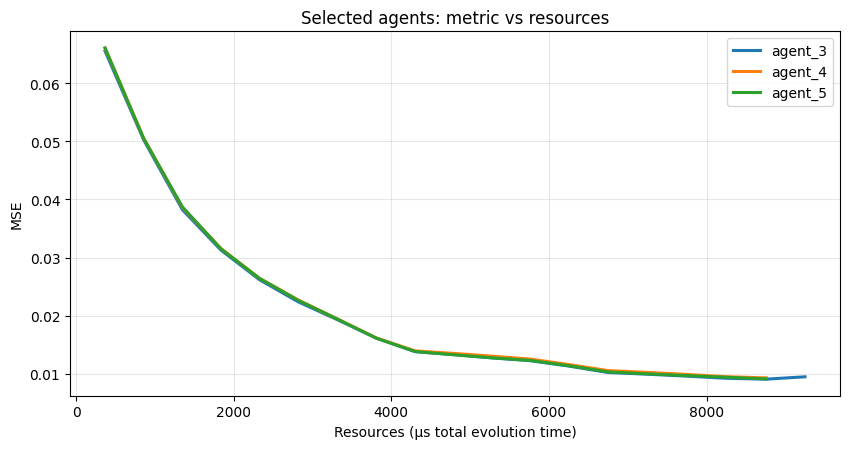

[saved] /blue/iruchkin/yuyangzhang/MagNavRL/eval_data_fid_10/figures/selected_agents_metric.png


agent metric     final      best  res_at_best  \
0      3    MSE  0.009492  0.009087       8757.8   
1      4    MSE  0.009305  0.009305       8758.1   
2      5    MSE  0.009128  0.009128       8758.1   

                                                 csv  
0  eval_idx3_batchsize_1024_num_steps_10000_max_r...  
1  eval_idx4_batchsize_1024_num_steps_10000_max_r...  
2  eval_idx5_batchsize_1024_num_steps_10000_max_r...

In [18]:
# --- Configuration ---
ROOT = DATA_ROOT                                   # where your eval folders live
CSV_GLOB = "*_eval.csv"                            # only look at eval curves
PICK_COLS = ["MSE", "Loss", "nnMse", "nnLoss", "loss"]  # metric priority
TRIM_LAST_RES = 500                                # trim last 500 ¬µs tail; set 0 to disable
# ---------------------

def _is_eval_dir(p: Path) -> bool:
    """An eval dir is either agent_<idx> or head<idx>."""
    return p.is_dir() and (re.match(r"agent_\d+$", p.name) or re.match(r"head\d+$", p.name))

def _dir_idx(name: str) -> int:
    """Extract the numeric id from 'agent_5' or 'head5'."""
    m = re.search(r"(\d+)$", name)
    if not m:
        raise ValueError(f"Cannot parse head id from folder name: {name}")
    return int(m.group(1))

def _newest_csv(folder: Path, pattern: str) -> Path:
    """Pick the most recent CSV that matches pattern."""
    files = sorted(folder.glob(pattern), key=lambda p: p.stat().st_mtime)
    if not files:
        raise FileNotFoundError(f"No CSV '{pattern}' in {folder}")
    return files[-1]

def _pick_metric_column(df: pd.DataFrame, prefer=PICK_COLS) -> str:
    """Choose a y-axis metric column in a deterministic priority order."""
    for c in prefer:
        if c in df.columns:
            return c
    raise KeyError(f"No metric column found. Available columns: {list(df.columns)}")

def _find_agent_dir(root: Path, idx: int) -> Path:
    """Return the folder for a given numeric head id (agent_<idx> or head<idx>)."""
    for cand in [root / f"agent_{idx}", root / f"head{idx}"]:
        if cand.exists() and cand.is_dir():
            return cand
    raise FileNotFoundError(f"No folder for agent/head {idx} under {root}")

def _normalize_ids(ids_like, root: Path):
    """
    Accepts a list like [3, 4, 5] or ["agent_3","head4","5"].
    If None, auto-discover all heads under ROOT.
    Returns a sorted list of numeric ids.
    """
    if ids_like is None:
        return sorted({_dir_idx(p.name) for p in root.iterdir() if _is_eval_dir(p)})
    out = []
    for v in ids_like:
        if isinstance(v, (int, np.integer)):
            out.append(int(v))
        else:
            m = re.search(r"(\d+)$", str(v))
            if not m:
                raise ValueError(f"Cannot parse head id from: {v}")
            out.append(int(m.group(1)))
    return sorted(set(out))

# Determine which heads to plot:
AGENT_IDs = _normalize_ids(head_list if 'head_list' in globals() else None, Path(ROOT))

# --- Plot ---
plt.figure(figsize=(8.6, 4.6))
summary = []

for i in AGENT_IDs:
    d = _find_agent_dir(Path(ROOT), i)
    f = _newest_csv(d, CSV_GLOB)
    df = pd.read_csv(f)

    # x-axis must be 'Resources'; y-axis chosen from PICK_COLS
    if "Resources" not in df.columns:
        raise KeyError(f"'Resources' column missing in {f}")
    ycol = _pick_metric_column(df)

    x = df["Resources"].astype(float).values
    y = df[ycol].astype(float).values

    # Optional: trim the last TRIM_LAST_RES ¬µs to remove the spurious final drop
    if TRIM_LAST_RES > 0 and len(x) > 1:
        xmax = np.nanmax(x)
        keep = x <= (xmax - TRIM_LAST_RES + 1e-9)
        if keep.sum() >= 2:
            x, y = x[keep], y[keep]

    # Sort by x (robust to unordered CSV rows)
    order = np.argsort(x)
    x, y = x[order], y[order]

    # Plot only the selected heads
    plt.plot(x, y, lw=2.2, label=f"agent_{i}")

    # Record quick summary stats
    best_idx = int(np.nanargmin(y))
    summary.append(dict(
        agent=i,
        metric=ycol,
        final=float(y[-1]),
        best=float(y[best_idx]),
        res_at_best=float(x[best_idx]),
        csv=f.name
    ))

# Labels and cosmetics
same_metric = len({s['metric'] for s in summary}) == 1
plt.xlabel("Resources (¬µs total evolution time)")
plt.ylabel(summary[0]['metric'] if (summary and same_metric) else "Metric")
plt.title("Selected agents: metric vs resources")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Save figure + show
fig_path = Path(ROOT) / "figures"
fig_path.mkdir(exist_ok=True)
out_png = fig_path / "selected_agents_metric.png"
plt.savefig(out_png, dpi=180)
plt.show()
print("[saved]", out_png)

# Small table for quick inspection
if summary:
    tbl = pd.DataFrame(summary).sort_values("agent")
    display(tbl)